In [1]:
# various import statements
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import scanpy as sc
import pyro
import cuml

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")
    
import random

import sys
import antipode
from antipode.antipode_model import *
import antipode.model_functions
from antipode.model_functions import *
import antipode.model_distributions
from antipode.model_distributions import *
import antipode.model_modules
from antipode.model_modules import *
import antipode.train_utils
from antipode.train_utils import *
import antipode.plotting
from antipode.plotting import *
from antipode.antipode_mixins import AntipodeTrainingMixin, AntipodeSaveLoadMixin


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available
Number of GPUs: 1
GPU Name: NVIDIA A100-PCIE-40GB


In [2]:
model_tag='1.9.1.8.5_Dev_final_600clusters'
out_path=os.path.join('/home/matthew.schmitz/Matthew/models/',model_tag)
batch_key='batch_name'
discov_key='species'
layer_key='spliced'

In [3]:
adata = antipode.anndata_utils.read_h5ad_backed_selective(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvM_cere_noX_mousectx.h5ad'),
    mode='r', selected_keys=['S_score','G2M_score','female','phase_sex','Class','Subclass','new_neighborhood_extended','phase','log10_n_counts','region','timepoint','general_region','new_ccl', batch_key,discov_key,layer_key, 'var', 'uns'])
# adata = sc.read_h5ad(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag,'p4_adata.h5ad'),backed='r')
# adata.obs['female']=adata.obs['batch_name'].replace(pd.read_csv('/home/matthew.schmitz/Matthew/data/taxtest/extra/inferred_sex.csv',index_col=0).to_dict()['female'])
# adata.obsm['phase_sex']=np.concatenate([adata.obs['S_score'].to_numpy().reshape(-1,1),adata.obs['G2M_score'].to_numpy().reshape(-1,1),adata.obs['log10_n_counts'].to_numpy().reshape(-1,1),antipode.model_functions.numpy_onehot(adata.obs['female'].cat.codes)],axis=1)
# adata.obsm['phase_sex']=adata.obsm['phase_sex']/np.abs(adata.obsm['phase_sex']).max(0)#Scale so max value is magnitude 1
adata.obsm['phase_sex'] = adata.obsm['phase_sex'][:,0:4]
np.nan_to_num(adata.obsm['phase_sex'],copy=False,nan=0.)

species_aggr_means=antipode.model_functions.group_aggr_anndata(adata,[discov_key],layer='spliced',normalize=True)
species_real_means=torch.tensor(species_aggr_means[0],requires_grad=False)
species_log_real_means=safe_log_transform(species_aggr_means[0]) # #species,#cluster,#genes array

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [01:25<02:50, 85.49s/it]

 67%|██████▋   | 2/3 [02:43<01:20, 80.94s/it]

100%|██████████| 3/3 [03:40<00:00, 69.97s/it]

100%|██████████| 3/3 [03:40<00:00, 73.39s/it]

In [4]:
adata.obs['general_region_sample'] = adata.obs['general_region'].astype(str)
adata.obs.loc[adata.obs['general_region_sample']=='bn','general_region_sample'] = 'ge'
adata.obs.loc[adata.obs['general_region_sample']=='cp','general_region_sample'] = 'ge'
grs = adata.obs['general_region_sample'].unique()
grs = grs[grs!='h']
adata.obs.loc[adata.obs['general_region_sample'].isin(['h']),'general_region_sample'] = np.random.choice(grs,(adata.obs['general_region_sample'].isin(['h'])).sum())
adata.obs['general_region_sample'] = adata.obs['general_region_sample'].astype(str)
adata.obs['general_region_species'] = adata.obs['species'].astype(str) +'_'+adata.obs['general_region_sample'].astype(str)
adata.obs['general_region_species'] = adata.obs['general_region_species'].astype('category')
adata.obs.drop('general_region_sample',axis=1,inplace=True)

In [5]:
adata.obs['general_region_species'].value_counts()

general_region_species
human_ctx      340105
macaque_ctx    329402
mouse_ctx      182942
macaque_ge     148493
human_hb       127956
human_de       118220
human_ge        96014
mouse_hb        86367
mouse_de        82081
mouse_mb        80440
macaque_hb      79850
macaque_de      60579
human_mb        44318
mouse_ge        41687
macaque_mb      36313
Name: count, dtype: int64

In [6]:
try:
    del adata.uns['hvg']
except:
    pass
try:
    del adata.uns['neighbors']
except:
    pass

In [7]:
adata

AnnData object with n_obs × n_vars = 1854767 × 16738 backed at '/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvM_cere_noX_mousectx.h5ad'
    obs: 'Class', 'G2M_score', 'S_score', 'Subclass', 'batch_name', 'female', 'general_region', 'log10_n_counts', 'new_ccl', 'new_neighborhood_extended', 'phase', 'region', 'species', 'timepoint', 'general_region_species'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'antipode_cluster_colors', 'dataset_name_colors', 'level_0_colors', 'level_1_colors', 'level_2_colors', 'new_ccl_colors', 'new_neighborhood_extended_colors', 'param_store', 'region_colors', 'species_colors'
    obsm: 'phase_sex'
    layers: 'spliced'

In [8]:
num_var=adata.shape[1]
batch_size=32
level_sizes=[1,75,600]
num_latent=200
steps=0
max_steps=[600000,600000,3000000]
num_particles=3
print_every=5000

# Clear Pyro param store so we don't conflict with previous run
try:
    pyro.clear_param_store()
    del antipode_model
    torch.cuda.empty_cache()
except:
    pass
# Fix random number seed to a lucky number
pyro.util.set_rng_seed(13)
# Enable optional validation warnings
pyro.enable_validation(False)

# Instantiate instance of model/guide and various neural networks
antipode_model = ANTIPODE(num_latent=num_latent,level_sizes=level_sizes,seccov_key='phase_sex',bi_depth=2,num_batch_embed=2,psi_levels=[0.,1.,1.],
                adata=adata,discov_pair=('obs',discov_key),batch_pair=('obs',batch_key),layer=layer_key,min_theta=.1,
                use_psi=True,use_q_score=False,prior_scale=150.,theta_prior=10,sampler_category='general_region_species',dist_normalize=False,dcd_prior=torch.tensor(species_log_real_means,requires_grad=False).float(),
                scale_init_val=0.01,loc_as_param=False,zdw_as_param=False,intercept_as_param=False,seccov_as_param=True)

INFO     Generating sequential column names                                                                        


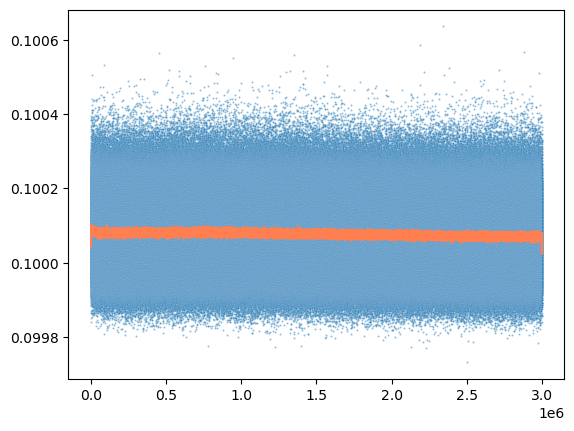

INFO     Generating sequential column names                                                                        


  0%|          | 0/57962 [00:00<?, ?it/s]

  0%|          | 29/57962 [00:00<03:22, 285.73it/s]

  0%|          | 59/57962 [00:00<03:17, 293.22it/s]

  0%|          | 89/57962 [00:00<03:17, 292.60it/s]

  0%|          | 123/57962 [00:00<03:06, 310.09it/s]

  0%|          | 158/57962 [00:00<02:59, 321.85it/s]

  0%|          | 196/57962 [00:00<02:51, 337.53it/s]

  0%|          | 230/57962 [00:00<02:52, 334.39it/s]

  0%|          | 265/57962 [00:00<02:50, 338.88it/s]

  1%|          | 303/57962 [00:00<02:44, 349.55it/s]

  1%|          | 339/57962 [00:01<02:43, 351.95it/s]

  1%|          | 378/57962 [00:01<02:38, 362.49it/s]

  1%|          | 415/57962 [00:01<02:42, 354.64it/s]

  1%|          | 454/57962 [00:01<02:38, 363.06it/s]

  1%|          | 491/57962 [00:01<02:41, 355.66it/s]

  1%|          | 529/57962 [00:01<02:39, 360.33it/s]

  1%|          | 568/57962 [00:01<02:35, 368.45it/s]

  1%|          | 609/57962 [00:01<02:31, 379.77it/s]

  1%|          | 652/57962 [00:01<02:26, 392.30it/s]

  1%|          | 692/57962 [00:01<02:31, 379.11it/s]

  1%|▏         | 731/57962 [00:02<02:42, 353.09it/s]

  1%|▏         | 771/57962 [00:02<02:36, 365.15it/s]

  1%|▏         | 813/57962 [00:02<02:31, 377.96it/s]

  1%|▏         | 856/57962 [00:02<02:26, 391.00it/s]

  2%|▏         | 896/57962 [00:02<02:26, 388.53it/s]

  2%|▏         | 936/57962 [00:02<02:41, 354.10it/s]

  2%|▏         | 973/57962 [00:02<02:49, 336.67it/s]

  2%|▏         | 1009/57962 [00:02<02:46, 342.61it/s]

  2%|▏         | 1047/57962 [00:02<02:41, 351.68it/s]

  2%|▏         | 1087/57962 [00:03<02:35, 364.69it/s]

  2%|▏         | 1129/57962 [00:03<02:29, 380.05it/s]

  2%|▏         | 1168/57962 [00:03<02:43, 347.32it/s]

  2%|▏         | 1204/57962 [00:03<03:07, 302.97it/s]

  2%|▏         | 1236/57962 [00:03<03:19, 284.97it/s]

  2%|▏         | 1266/57962 [00:03<03:24, 277.29it/s]

  2%|▏         | 1295/57962 [00:03<03:25, 275.15it/s]

  2%|▏         | 1324/57962 [00:03<03:24, 277.28it/s]

  2%|▏         | 1354/57962 [00:04<03:19, 283.40it/s]

  2%|▏         | 1387/57962 [00:04<03:11, 294.90it/s]

  2%|▏         | 1424/57962 [00:04<02:59, 314.35it/s]

  3%|▎         | 1456/57962 [00:04<03:04, 305.94it/s]

  3%|▎         | 1487/57962 [00:04<03:06, 303.44it/s]

  3%|▎         | 1519/57962 [00:04<03:03, 307.83it/s]

  3%|▎         | 1552/57962 [00:04<02:59, 313.54it/s]

  3%|▎         | 1587/57962 [00:04<02:55, 321.63it/s]

  3%|▎         | 1623/57962 [00:04<02:49, 331.81it/s]

  3%|▎         | 1661/57962 [00:04<02:43, 343.48it/s]

  3%|▎         | 1697/57962 [00:05<02:41, 347.40it/s]

  3%|▎         | 1736/57962 [00:05<02:36, 358.37it/s]

  3%|▎         | 1777/57962 [00:05<02:30, 372.72it/s]

  3%|▎         | 1818/57962 [00:05<02:26, 382.07it/s]

  3%|▎         | 1857/57962 [00:05<02:33, 365.79it/s]

  3%|▎         | 1894/57962 [00:05<02:50, 328.31it/s]

  3%|▎         | 1928/57962 [00:05<02:58, 313.14it/s]

  3%|▎         | 1960/57962 [00:05<03:01, 309.01it/s]

  3%|▎         | 1992/57962 [00:05<03:01, 308.52it/s]

  3%|▎         | 2025/57962 [00:06<02:58, 313.48it/s]

  4%|▎         | 2058/57962 [00:06<02:55, 317.92it/s]

  4%|▎         | 2090/57962 [00:06<02:58, 313.15it/s]

  4%|▎         | 2122/57962 [00:06<03:05, 301.77it/s]

  4%|▎         | 2153/57962 [00:06<03:07, 298.12it/s]

  4%|▍         | 2185/57962 [00:06<03:03, 303.78it/s]

  4%|▍         | 2218/57962 [00:06<02:59, 310.85it/s]

  4%|▍         | 2252/57962 [00:06<02:54, 318.55it/s]

  4%|▍         | 2287/57962 [00:06<02:50, 326.62it/s]

  4%|▍         | 2320/57962 [00:07<03:07, 296.66it/s]

  4%|▍         | 2351/57962 [00:07<03:09, 292.79it/s]

  4%|▍         | 2381/57962 [00:07<03:12, 288.20it/s]

  4%|▍         | 2414/57962 [00:07<03:06, 298.12it/s]

  4%|▍         | 2445/57962 [00:07<03:12, 289.10it/s]

  4%|▍         | 2475/57962 [00:07<03:20, 276.33it/s]

  4%|▍         | 2503/57962 [00:07<03:22, 273.86it/s]

  4%|▍         | 2536/57962 [00:07<03:12, 288.18it/s]

  4%|▍         | 2566/57962 [00:07<03:21, 274.69it/s]

  4%|▍         | 2594/57962 [00:07<03:20, 275.83it/s]

  5%|▍         | 2629/57962 [00:08<03:07, 295.57it/s]

  5%|▍         | 2666/57962 [00:08<02:55, 315.97it/s]

  5%|▍         | 2698/57962 [00:08<03:08, 292.97it/s]

  5%|▍         | 2728/57962 [00:08<03:07, 293.85it/s]

  5%|▍         | 2758/57962 [00:08<03:15, 282.37it/s]

  5%|▍         | 2787/57962 [00:08<03:19, 276.54it/s]

  5%|▍         | 2815/57962 [00:08<03:21, 274.09it/s]

  5%|▍         | 2843/57962 [00:08<03:40, 249.80it/s]

  5%|▍         | 2869/57962 [00:08<03:45, 244.58it/s]

  5%|▍         | 2896/57962 [00:09<03:40, 249.89it/s]

  5%|▌         | 2924/57962 [00:09<03:34, 256.35it/s]

  5%|▌         | 2952/57962 [00:09<03:30, 261.74it/s]

  5%|▌         | 2984/57962 [00:09<03:19, 276.18it/s]

  5%|▌         | 3012/57962 [00:09<03:21, 272.56it/s]

  5%|▌         | 3040/57962 [00:09<03:26, 266.51it/s]

  5%|▌         | 3069/57962 [00:09<03:22, 271.68it/s]

  5%|▌         | 3099/57962 [00:09<03:18, 276.86it/s]

  5%|▌         | 3127/57962 [00:09<03:24, 268.38it/s]

  5%|▌         | 3154/57962 [00:10<03:24, 267.73it/s]

  5%|▌         | 3183/57962 [00:10<03:20, 273.26it/s]

  6%|▌         | 3213/57962 [00:10<03:15, 280.67it/s]

  6%|▌         | 3247/57962 [00:10<03:03, 297.83it/s]

  6%|▌         | 3277/57962 [00:10<03:11, 286.15it/s]

  6%|▌         | 3306/57962 [00:10<03:15, 279.62it/s]

  6%|▌         | 3336/57962 [00:10<03:13, 282.98it/s]

  6%|▌         | 3365/57962 [00:10<03:19, 274.28it/s]

  6%|▌         | 3394/57962 [00:10<03:16, 278.36it/s]

  6%|▌         | 3422/57962 [00:10<03:15, 278.67it/s]

  6%|▌         | 3450/57962 [00:11<03:19, 272.58it/s]

  6%|▌         | 3479/57962 [00:11<03:17, 276.47it/s]

  6%|▌         | 3510/57962 [00:11<03:11, 283.88it/s]

  6%|▌         | 3539/57962 [00:11<03:15, 278.72it/s]

  6%|▌         | 3569/57962 [00:11<03:11, 283.50it/s]

  6%|▌         | 3602/57962 [00:11<03:04, 295.11it/s]

  6%|▋         | 3632/57962 [00:11<03:10, 284.72it/s]

  6%|▋         | 3661/57962 [00:11<03:09, 286.22it/s]

  6%|▋         | 3694/57962 [00:11<03:03, 296.45it/s]

  6%|▋         | 3724/57962 [00:12<03:04, 293.21it/s]

  6%|▋         | 3754/57962 [00:12<03:14, 279.30it/s]

  7%|▋         | 3784/57962 [00:12<03:11, 283.37it/s]

  7%|▋         | 3814/57962 [00:12<03:09, 285.75it/s]

  7%|▋         | 3846/57962 [00:12<03:03, 295.04it/s]

  7%|▋         | 3881/57962 [00:12<02:54, 310.61it/s]

  7%|▋         | 3916/57962 [00:12<02:49, 319.76it/s]

  7%|▋         | 3949/57962 [00:12<02:47, 321.53it/s]

  7%|▋         | 3986/57962 [00:12<02:41, 333.95it/s]

  7%|▋         | 4020/57962 [00:12<02:47, 321.60it/s]

  7%|▋         | 4053/57962 [00:13<02:49, 318.76it/s]

  7%|▋         | 4087/57962 [00:13<02:46, 324.19it/s]

  7%|▋         | 4120/57962 [00:13<02:53, 309.93it/s]

  7%|▋         | 4152/57962 [00:13<02:52, 311.09it/s]

  7%|▋         | 4185/57962 [00:13<02:51, 313.05it/s]

  7%|▋         | 4217/57962 [00:13<02:59, 299.69it/s]

  7%|▋         | 4249/57962 [00:13<02:57, 303.01it/s]

  7%|▋         | 4280/57962 [00:13<02:56, 304.50it/s]

  7%|▋         | 4315/57962 [00:13<02:49, 315.72it/s]

  7%|▋         | 4347/57962 [00:14<02:52, 310.13it/s]

  8%|▊         | 4381/57962 [00:14<02:48, 317.11it/s]

  8%|▊         | 4419/57962 [00:14<02:40, 334.02it/s]

  8%|▊         | 4453/57962 [00:14<02:43, 328.16it/s]

  8%|▊         | 4487/57962 [00:14<02:42, 329.96it/s]

  8%|▊         | 4521/57962 [00:14<02:42, 329.03it/s]

  8%|▊         | 4554/57962 [00:14<02:46, 320.59it/s]

  8%|▊         | 4588/57962 [00:14<02:44, 323.84it/s]

  8%|▊         | 4625/57962 [00:14<02:38, 336.88it/s]

  8%|▊         | 4659/57962 [00:14<02:41, 330.71it/s]

  8%|▊         | 4693/57962 [00:15<02:40, 332.07it/s]

  8%|▊         | 4727/57962 [00:15<02:40, 332.15it/s]

  8%|▊         | 4761/57962 [00:15<02:43, 325.45it/s]

  8%|▊         | 4794/57962 [00:15<02:44, 322.55it/s]

  8%|▊         | 4827/57962 [00:15<02:53, 306.46it/s]

  8%|▊         | 4858/57962 [00:15<02:52, 307.29it/s]

  8%|▊         | 4894/57962 [00:15<02:45, 320.91it/s]

  9%|▊         | 4930/57962 [00:15<02:41, 329.30it/s]

  9%|▊         | 4964/57962 [00:15<02:47, 317.06it/s]

  9%|▊         | 4997/57962 [00:16<02:45, 320.24it/s]

  9%|▊         | 5031/57962 [00:16<02:42, 325.49it/s]

  9%|▊         | 5064/57962 [00:16<02:46, 317.16it/s]

  9%|▉         | 5098/57962 [00:16<02:43, 322.60it/s]

  9%|▉         | 5135/57962 [00:16<02:38, 333.66it/s]

  9%|▉         | 5175/57962 [00:16<02:30, 350.72it/s]

  9%|▉         | 5211/57962 [00:16<02:32, 345.93it/s]

  9%|▉         | 5246/57962 [00:16<02:32, 346.53it/s]

  9%|▉         | 5284/57962 [00:16<02:27, 356.26it/s]

  9%|▉         | 5320/57962 [00:16<02:34, 341.26it/s]

  9%|▉         | 5358/57962 [00:17<02:29, 352.10it/s]

  9%|▉         | 5394/57962 [00:17<02:32, 344.74it/s]

  9%|▉         | 5429/57962 [00:17<02:38, 330.43it/s]

  9%|▉         | 5463/57962 [00:17<02:39, 328.76it/s]

  9%|▉         | 5497/57962 [00:17<02:39, 328.44it/s]

 10%|▉         | 5531/57962 [00:17<02:38, 330.01it/s]

 10%|▉         | 5569/57962 [00:17<02:32, 344.39it/s]

 10%|▉         | 5604/57962 [00:17<02:42, 321.81it/s]

 10%|▉         | 5637/57962 [00:17<02:42, 322.75it/s]

 10%|▉         | 5670/57962 [00:18<02:42, 322.64it/s]

 10%|▉         | 5703/57962 [00:18<02:41, 323.04it/s]

 10%|▉         | 5739/57962 [00:18<02:36, 332.69it/s]

 10%|▉         | 5773/57962 [00:18<02:37, 331.01it/s]

 10%|█         | 5807/57962 [00:18<02:36, 332.77it/s]

 10%|█         | 5845/57962 [00:18<02:30, 345.49it/s]

 10%|█         | 5880/57962 [00:18<02:40, 323.77it/s]

 10%|█         | 5913/57962 [00:18<02:44, 316.43it/s]

 10%|█         | 5946/57962 [00:18<02:43, 317.90it/s]

 10%|█         | 5982/57962 [00:18<02:38, 328.11it/s]

 10%|█         | 6015/57962 [00:19<02:44, 315.66it/s]

 10%|█         | 6047/57962 [00:19<02:53, 298.66it/s]

 10%|█         | 6078/57962 [00:19<02:55, 295.53it/s]

 11%|█         | 6108/57962 [00:19<02:55, 295.21it/s]

 11%|█         | 6140/57962 [00:19<02:52, 300.81it/s]

 11%|█         | 6174/57962 [00:19<02:46, 310.79it/s]

 11%|█         | 6206/57962 [00:19<02:50, 304.21it/s]

 11%|█         | 6241/57962 [00:19<02:43, 315.77it/s]

 11%|█         | 6273/57962 [00:19<02:46, 309.55it/s]

 11%|█         | 6307/57962 [00:20<02:43, 315.75it/s]

 11%|█         | 6341/57962 [00:20<02:40, 320.79it/s]

 11%|█         | 6374/57962 [00:20<02:45, 312.29it/s]

 11%|█         | 6408/57962 [00:20<02:41, 318.42it/s]

 11%|█         | 6440/57962 [00:20<02:47, 308.24it/s]

 11%|█         | 6473/57962 [00:20<02:44, 312.54it/s]

 11%|█         | 6507/57962 [00:20<02:41, 318.35it/s]

 11%|█▏        | 6539/57962 [00:20<02:42, 316.24it/s]

 11%|█▏        | 6575/57962 [00:20<02:36, 328.36it/s]

 11%|█▏        | 6608/57962 [00:21<02:42, 315.13it/s]

 11%|█▏        | 6641/57962 [00:21<02:40, 318.85it/s]

 12%|█▏        | 6674/57962 [00:21<02:39, 321.31it/s]

 12%|█▏        | 6708/57962 [00:21<02:37, 326.41it/s]

 12%|█▏        | 6741/57962 [00:21<02:38, 323.32it/s]

 12%|█▏        | 6774/57962 [00:21<02:38, 322.78it/s]

 12%|█▏        | 6807/57962 [00:21<02:38, 322.81it/s]

 12%|█▏        | 6842/57962 [00:21<02:34, 330.61it/s]

 12%|█▏        | 6876/57962 [00:21<02:36, 326.89it/s]

 12%|█▏        | 6910/57962 [00:21<02:35, 328.79it/s]

 12%|█▏        | 6944/57962 [00:22<02:33, 331.55it/s]

 12%|█▏        | 6978/57962 [00:22<02:35, 328.24it/s]

 12%|█▏        | 7015/57962 [00:22<02:30, 338.07it/s]

 12%|█▏        | 7051/57962 [00:22<02:28, 342.26it/s]

 12%|█▏        | 7086/57962 [00:22<02:34, 330.33it/s]

 12%|█▏        | 7120/57962 [00:22<02:43, 310.05it/s]

 12%|█▏        | 7152/57962 [00:22<02:42, 311.87it/s]

 12%|█▏        | 7186/57962 [00:22<02:39, 317.49it/s]

 12%|█▏        | 7220/57962 [00:22<02:36, 323.20it/s]

 13%|█▎        | 7253/57962 [00:23<02:48, 301.46it/s]

 13%|█▎        | 7284/57962 [00:23<02:52, 294.35it/s]

 13%|█▎        | 7314/57962 [00:23<02:55, 288.47it/s]

 13%|█▎        | 7345/57962 [00:23<02:52, 292.76it/s]

 13%|█▎        | 7381/57962 [00:23<02:43, 309.70it/s]

 13%|█▎        | 7413/57962 [00:23<02:46, 303.18it/s]

 13%|█▎        | 7446/57962 [00:23<02:43, 309.67it/s]

 13%|█▎        | 7478/57962 [00:23<02:41, 312.29it/s]

 13%|█▎        | 7511/57962 [00:23<02:40, 315.29it/s]

 13%|█▎        | 7548/57962 [00:23<02:32, 329.51it/s]

 13%|█▎        | 7582/57962 [00:24<02:37, 319.33it/s]

 13%|█▎        | 7616/57962 [00:24<02:35, 323.52it/s]

 13%|█▎        | 7651/57962 [00:24<02:32, 329.85it/s]

 13%|█▎        | 7685/57962 [00:24<02:34, 324.48it/s]

 13%|█▎        | 7720/57962 [00:24<02:31, 331.24it/s]

 13%|█▎        | 7754/57962 [00:24<02:32, 329.05it/s]

 13%|█▎        | 7787/57962 [00:24<02:34, 324.82it/s]

 13%|█▎        | 7823/57962 [00:24<02:29, 334.64it/s]

 14%|█▎        | 7857/57962 [00:24<02:30, 333.62it/s]

 14%|█▎        | 7893/57962 [00:25<02:27, 338.92it/s]

 14%|█▎        | 7927/57962 [00:25<02:30, 333.04it/s]

 14%|█▎        | 7964/57962 [00:25<02:26, 342.28it/s]

 14%|█▍        | 7999/57962 [00:25<02:29, 333.92it/s]

 14%|█▍        | 8037/57962 [00:25<02:23, 347.16it/s]

 14%|█▍        | 8072/57962 [00:25<02:27, 338.59it/s]

 14%|█▍        | 8109/57962 [00:25<02:24, 345.60it/s]

 14%|█▍        | 8144/57962 [00:25<02:25, 343.32it/s]

 14%|█▍        | 8179/57962 [00:25<02:26, 338.90it/s]

 14%|█▍        | 8213/57962 [00:25<02:31, 328.80it/s]

 14%|█▍        | 8246/57962 [00:26<02:31, 328.95it/s]

 14%|█▍        | 8281/57962 [00:26<02:28, 334.94it/s]

 14%|█▍        | 8319/57962 [00:26<02:23, 345.97it/s]

 14%|█▍        | 8354/57962 [00:26<02:28, 333.07it/s]

 14%|█▍        | 8388/57962 [00:26<02:28, 334.24it/s]

 15%|█▍        | 8422/57962 [00:26<02:29, 331.67it/s]

 15%|█▍        | 8456/57962 [00:26<02:28, 333.58it/s]

 15%|█▍        | 8493/57962 [00:26<02:24, 343.01it/s]

 15%|█▍        | 8528/57962 [00:26<02:29, 331.14it/s]

 15%|█▍        | 8564/57962 [00:26<02:26, 336.97it/s]

 15%|█▍        | 8598/57962 [00:27<02:30, 328.71it/s]

 15%|█▍        | 8633/57962 [00:27<02:28, 332.79it/s]

 15%|█▍        | 8669/57962 [00:27<02:25, 338.76it/s]

 15%|█▌        | 8703/57962 [00:27<02:27, 334.99it/s]

 15%|█▌        | 8740/57962 [00:27<02:22, 344.44it/s]

 15%|█▌        | 8775/57962 [00:27<02:25, 337.86it/s]

 15%|█▌        | 8813/57962 [00:27<02:20, 349.90it/s]

 15%|█▌        | 8849/57962 [00:27<02:27, 333.01it/s]

 15%|█▌        | 8885/57962 [00:27<02:24, 339.38it/s]

 15%|█▌        | 8920/57962 [00:28<02:26, 335.10it/s]

 15%|█▌        | 8957/57962 [00:28<02:22, 343.79it/s]

 16%|█▌        | 8992/57962 [00:28<02:27, 331.18it/s]

 16%|█▌        | 9026/57962 [00:28<02:40, 305.12it/s]

 16%|█▌        | 9057/57962 [00:28<02:39, 305.77it/s]

 16%|█▌        | 9089/57962 [00:28<02:37, 309.66it/s]

 16%|█▌        | 9127/57962 [00:28<02:28, 328.71it/s]

 16%|█▌        | 9161/57962 [00:28<02:30, 323.63it/s]

 16%|█▌        | 9194/57962 [00:28<02:29, 325.37it/s]

 16%|█▌        | 9227/57962 [00:29<02:33, 318.31it/s]

 16%|█▌        | 9262/57962 [00:29<02:29, 326.48it/s]

 16%|█▌        | 9295/57962 [00:29<02:28, 326.66it/s]

 16%|█▌        | 9328/57962 [00:29<02:36, 309.90it/s]

 16%|█▌        | 9364/57962 [00:29<02:31, 320.30it/s]

 16%|█▌        | 9397/57962 [00:29<02:43, 297.57it/s]

 16%|█▋        | 9428/57962 [00:29<02:41, 299.81it/s]

 16%|█▋        | 9459/57962 [00:29<02:42, 298.45it/s]

 16%|█▋        | 9492/57962 [00:29<02:39, 304.67it/s]

 16%|█▋        | 9523/57962 [00:30<02:52, 280.08it/s]

 16%|█▋        | 9552/57962 [00:30<02:54, 277.73it/s]

 17%|█▋        | 9581/57962 [00:30<03:04, 262.47it/s]

 17%|█▋        | 9608/57962 [00:30<03:05, 261.12it/s]

 17%|█▋        | 9635/57962 [00:30<03:13, 250.32it/s]

 17%|█▋        | 9661/57962 [00:30<03:15, 246.73it/s]

 17%|█▋        | 9688/57962 [00:30<03:10, 252.88it/s]

 17%|█▋        | 9720/57962 [00:30<02:58, 270.24it/s]

 17%|█▋        | 9756/57962 [00:30<02:42, 295.75it/s]

 17%|█▋        | 9786/57962 [00:30<02:44, 292.59it/s]

 17%|█▋        | 9818/57962 [00:31<02:40, 299.61it/s]

 17%|█▋        | 9857/57962 [00:31<02:28, 323.12it/s]

 17%|█▋        | 9890/57962 [00:31<02:47, 287.42it/s]

 17%|█▋        | 9920/57962 [00:31<02:54, 275.12it/s]

 17%|█▋        | 9949/57962 [00:31<02:55, 273.90it/s]

 17%|█▋        | 9982/57962 [00:31<02:46, 288.65it/s]

 17%|█▋        | 10021/57962 [00:31<02:32, 313.92it/s]

 17%|█▋        | 10053/57962 [00:31<02:37, 304.09it/s]

 17%|█▋        | 10087/57962 [00:31<02:33, 312.84it/s]

 17%|█▋        | 10125/57962 [00:32<02:24, 331.28it/s]

 18%|█▊        | 10159/57962 [00:32<02:29, 320.56it/s]

 18%|█▊        | 10194/57962 [00:32<02:25, 327.19it/s]

 18%|█▊        | 10232/57962 [00:32<02:20, 339.20it/s]

 18%|█▊        | 10267/57962 [00:32<02:20, 339.24it/s]

 18%|█▊        | 10302/57962 [00:32<02:21, 335.96it/s]

 18%|█▊        | 10336/57962 [00:32<02:24, 328.60it/s]

 18%|█▊        | 10369/57962 [00:32<02:28, 321.18it/s]

 18%|█▊        | 10404/57962 [00:32<02:25, 327.74it/s]

 18%|█▊        | 10443/57962 [00:33<02:18, 343.94it/s]

 18%|█▊        | 10478/57962 [00:33<02:25, 325.87it/s]

 18%|█▊        | 10511/57962 [00:33<02:25, 326.09it/s]

 18%|█▊        | 10545/57962 [00:33<02:23, 329.44it/s]

 18%|█▊        | 10580/57962 [00:33<02:21, 334.56it/s]

 18%|█▊        | 10617/57962 [00:33<02:18, 342.49it/s]

 18%|█▊        | 10652/57962 [00:33<02:18, 340.92it/s]

 18%|█▊        | 10687/57962 [00:33<02:24, 327.27it/s]

 18%|█▊        | 10721/57962 [00:33<02:23, 328.89it/s]

 19%|█▊        | 10757/57962 [00:33<02:20, 336.22it/s]

 19%|█▊        | 10796/57962 [00:34<02:14, 349.71it/s]

 19%|█▊        | 10838/57962 [00:34<02:07, 369.54it/s]

 19%|█▉        | 10876/57962 [00:34<02:14, 349.23it/s]

 19%|█▉        | 10912/57962 [00:34<02:17, 342.84it/s]

 19%|█▉        | 10947/57962 [00:34<02:17, 342.92it/s]

 19%|█▉        | 10983/57962 [00:34<02:16, 345.20it/s]

 19%|█▉        | 11020/57962 [00:34<02:13, 350.55it/s]

 19%|█▉        | 11058/57962 [00:34<02:10, 358.64it/s]

 19%|█▉        | 11094/57962 [00:34<02:12, 353.96it/s]

 19%|█▉        | 11130/57962 [00:35<02:18, 337.17it/s]

 19%|█▉        | 11165/57962 [00:35<02:18, 338.24it/s]

 19%|█▉        | 11201/57962 [00:35<02:16, 342.04it/s]

 19%|█▉        | 11238/57962 [00:35<02:14, 347.52it/s]

 19%|█▉        | 11275/57962 [00:35<02:12, 353.17it/s]

 20%|█▉        | 11313/57962 [00:35<02:09, 359.18it/s]

 20%|█▉        | 11352/57962 [00:35<02:07, 365.94it/s]

 20%|█▉        | 11392/57962 [00:35<02:04, 374.04it/s]

 20%|█▉        | 11434/57962 [00:35<02:00, 385.92it/s]

 20%|█▉        | 11473/57962 [00:35<02:03, 376.88it/s]

 20%|█▉        | 11511/57962 [00:36<02:05, 371.11it/s]

 20%|█▉        | 11549/57962 [00:36<02:06, 365.55it/s]

 20%|█▉        | 11586/57962 [00:36<02:10, 355.02it/s]

 20%|██        | 11622/57962 [00:36<02:10, 354.84it/s]

 20%|██        | 11660/57962 [00:36<02:08, 359.87it/s]

 20%|██        | 11700/57962 [00:36<02:05, 368.95it/s]

 20%|██        | 11741/57962 [00:36<02:01, 378.86it/s]

 20%|██        | 11784/57962 [00:36<01:57, 391.75it/s]

 20%|██        | 11824/57962 [00:36<01:59, 386.57it/s]

 20%|██        | 11866/57962 [00:37<01:56, 395.25it/s]

 21%|██        | 11910/57962 [00:37<01:53, 407.16it/s]

 21%|██        | 11951/57962 [00:37<01:54, 403.32it/s]

 21%|██        | 11993/57962 [00:37<01:53, 405.33it/s]

 21%|██        | 12034/57962 [00:37<01:59, 383.77it/s]

 21%|██        | 12073/57962 [00:37<02:02, 373.30it/s]

 21%|██        | 12111/57962 [00:37<02:02, 373.10it/s]

 21%|██        | 12150/57962 [00:37<02:01, 376.19it/s]

 21%|██        | 12190/57962 [00:37<02:00, 381.15it/s]

 21%|██        | 12231/57962 [00:37<01:58, 387.45it/s]

 21%|██        | 12272/57962 [00:38<01:56, 393.86it/s]

 21%|██        | 12314/57962 [00:38<01:53, 401.25it/s]

 21%|██▏       | 12357/57962 [00:38<01:51, 407.72it/s]

 21%|██▏       | 12400/57962 [00:38<01:50, 413.66it/s]

 21%|██▏       | 12442/57962 [00:38<01:56, 391.98it/s]

 22%|██▏       | 12482/57962 [00:38<02:00, 376.60it/s]

 22%|██▏       | 12520/57962 [00:38<02:01, 374.26it/s]

 22%|██▏       | 12558/57962 [00:38<02:00, 375.69it/s]

 22%|██▏       | 12598/57962 [00:38<01:59, 380.41it/s]

 22%|██▏       | 12639/57962 [00:39<01:57, 386.89it/s]

 22%|██▏       | 12681/57962 [00:39<01:54, 393.85it/s]

 22%|██▏       | 12723/57962 [00:39<01:52, 401.44it/s]

 22%|██▏       | 12764/57962 [00:39<01:58, 380.20it/s]

 22%|██▏       | 12803/57962 [00:39<01:58, 381.76it/s]

 22%|██▏       | 12844/57962 [00:39<01:56, 388.16it/s]

 22%|██▏       | 12883/57962 [00:39<01:57, 383.40it/s]

 22%|██▏       | 12923/57962 [00:39<01:56, 387.98it/s]

 22%|██▏       | 12965/57962 [00:39<01:53, 396.34it/s]

 22%|██▏       | 13006/57962 [00:39<01:52, 398.66it/s]

 23%|██▎       | 13046/57962 [00:40<02:01, 370.56it/s]

 23%|██▎       | 13084/57962 [00:40<02:02, 365.52it/s]

 23%|██▎       | 13122/57962 [00:40<02:02, 367.04it/s]

 23%|██▎       | 13161/57962 [00:40<02:00, 371.51it/s]

 23%|██▎       | 13201/57962 [00:40<01:58, 378.99it/s]

 23%|██▎       | 13242/57962 [00:40<01:56, 385.32it/s]

 23%|██▎       | 13284/57962 [00:40<01:53, 393.44it/s]

 23%|██▎       | 13326/57962 [00:40<01:51, 398.62it/s]

 23%|██▎       | 13369/57962 [00:40<01:49, 406.25it/s]

 23%|██▎       | 13410/57962 [00:41<01:50, 401.61it/s]

 23%|██▎       | 13451/57962 [00:41<02:01, 367.62it/s]

 23%|██▎       | 13489/57962 [00:41<02:04, 357.53it/s]

 23%|██▎       | 13526/57962 [00:41<02:05, 353.74it/s]

 23%|██▎       | 13562/57962 [00:41<02:05, 353.38it/s]

 23%|██▎       | 13598/57962 [00:41<02:04, 355.13it/s]

 24%|██▎       | 13635/57962 [00:41<02:03, 357.57it/s]

 24%|██▎       | 13672/57962 [00:41<02:02, 361.12it/s]

 24%|██▎       | 13711/57962 [00:41<02:00, 368.41it/s]

 24%|██▎       | 13748/57962 [00:41<02:01, 364.04it/s]

 24%|██▍       | 13785/57962 [00:42<02:07, 347.48it/s]

 24%|██▍       | 13820/57962 [00:42<02:08, 342.56it/s]

 24%|██▍       | 13855/57962 [00:42<02:08, 343.83it/s]

 24%|██▍       | 13892/57962 [00:42<02:05, 351.23it/s]

 24%|██▍       | 13932/57962 [00:42<02:01, 363.34it/s]

 24%|██▍       | 13969/57962 [00:42<02:03, 357.31it/s]

 24%|██▍       | 14005/57962 [00:42<02:03, 357.26it/s]

 24%|██▍       | 14048/57962 [00:42<01:57, 374.51it/s]

 24%|██▍       | 14086/57962 [00:42<02:03, 356.45it/s]

 24%|██▍       | 14122/57962 [00:43<02:08, 340.44it/s]

 24%|██▍       | 14157/57962 [00:43<02:23, 305.60it/s]

 24%|██▍       | 14189/57962 [00:43<02:32, 286.34it/s]

 25%|██▍       | 14219/57962 [00:43<02:31, 288.27it/s]

 25%|██▍       | 14249/57962 [00:43<02:30, 289.54it/s]

 25%|██▍       | 14280/57962 [00:43<02:28, 293.78it/s]

 25%|██▍       | 14315/57962 [00:43<02:21, 307.41it/s]

 25%|██▍       | 14353/57962 [00:43<02:13, 326.08it/s]

 25%|██▍       | 14392/57962 [00:43<02:07, 341.73it/s]

 25%|██▍       | 14427/57962 [00:44<02:13, 325.80it/s]

 25%|██▍       | 14462/57962 [00:44<02:11, 330.77it/s]

 25%|██▌       | 14496/57962 [00:44<02:12, 328.67it/s]

 25%|██▌       | 14530/57962 [00:44<02:13, 325.16it/s]

 25%|██▌       | 14564/57962 [00:44<02:11, 329.03it/s]

 25%|██▌       | 14600/57962 [00:44<02:08, 336.29it/s]

 25%|██▌       | 14640/57962 [00:44<02:02, 352.52it/s]

 25%|██▌       | 14676/57962 [00:44<02:06, 341.32it/s]

 25%|██▌       | 14712/57962 [00:44<02:05, 344.83it/s]

 25%|██▌       | 14752/57962 [00:44<02:00, 358.68it/s]

 26%|██▌       | 14793/57962 [00:45<01:57, 368.15it/s]

 26%|██▌       | 14830/57962 [00:45<02:05, 342.64it/s]

 26%|██▌       | 14865/57962 [00:45<02:06, 341.67it/s]

 26%|██▌       | 14903/57962 [00:45<02:02, 351.10it/s]

 26%|██▌       | 14939/57962 [00:45<02:02, 352.02it/s]

 26%|██▌       | 14975/57962 [00:45<02:04, 346.48it/s]

 26%|██▌       | 15012/57962 [00:45<02:02, 351.26it/s]

 26%|██▌       | 15049/57962 [00:45<02:00, 355.06it/s]

 26%|██▌       | 15085/57962 [00:45<02:09, 332.09it/s]

 26%|██▌       | 15119/57962 [00:46<02:10, 328.56it/s]

 26%|██▌       | 15156/57962 [00:46<02:06, 339.11it/s]

 26%|██▌       | 15191/57962 [00:46<02:10, 328.11it/s]

 26%|██▋       | 15225/57962 [00:46<02:09, 331.24it/s]

 26%|██▋       | 15263/57962 [00:46<02:03, 344.59it/s]

 26%|██▋       | 15298/57962 [00:46<02:03, 345.65it/s]

 26%|██▋       | 15335/57962 [00:46<02:01, 351.35it/s]

 27%|██▋       | 15373/57962 [00:46<01:59, 357.18it/s]

 27%|██▋       | 15412/57962 [00:46<01:56, 365.11it/s]

 27%|██▋       | 15452/57962 [00:46<01:53, 373.87it/s]

 27%|██▋       | 15494/57962 [00:47<01:50, 385.68it/s]

 27%|██▋       | 15533/57962 [00:47<01:52, 377.08it/s]

 27%|██▋       | 15571/57962 [00:47<01:55, 366.28it/s]

 27%|██▋       | 15608/57962 [00:47<01:55, 365.53it/s]

 27%|██▋       | 15647/57962 [00:47<01:53, 372.57it/s]

 27%|██▋       | 15685/57962 [00:47<01:56, 363.22it/s]

 27%|██▋       | 15722/57962 [00:47<01:57, 359.79it/s]

 27%|██▋       | 15759/57962 [00:47<01:56, 361.13it/s]

 27%|██▋       | 15797/57962 [00:47<01:55, 365.27it/s]

 27%|██▋       | 15836/57962 [00:48<01:53, 370.99it/s]

 27%|██▋       | 15876/57962 [00:48<01:51, 378.91it/s]

 27%|██▋       | 15918/57962 [00:48<01:47, 389.63it/s]

 28%|██▊       | 15957/57962 [00:48<01:53, 369.99it/s]

 28%|██▊       | 15995/57962 [00:48<01:54, 367.17it/s]

 28%|██▊       | 16033/57962 [00:48<01:53, 368.13it/s]

 28%|██▊       | 16072/57962 [00:48<01:52, 373.71it/s]

 28%|██▊       | 16113/57962 [00:48<01:49, 383.36it/s]

 28%|██▊       | 16155/57962 [00:48<01:46, 393.45it/s]

 28%|██▊       | 16198/57962 [00:48<01:43, 401.70it/s]

 28%|██▊       | 16239/57962 [00:49<01:44, 397.74it/s]

 28%|██▊       | 16279/57962 [00:49<01:49, 382.07it/s]

 28%|██▊       | 16318/57962 [00:49<01:50, 375.42it/s]

 28%|██▊       | 16356/57962 [00:49<01:52, 368.42it/s]

 28%|██▊       | 16393/57962 [00:49<01:55, 360.02it/s]

 28%|██▊       | 16430/57962 [00:49<02:01, 343.03it/s]

 28%|██▊       | 16465/57962 [00:49<02:02, 339.46it/s]

 28%|██▊       | 16500/57962 [00:49<02:01, 340.54it/s]

 29%|██▊       | 16537/57962 [00:49<01:58, 348.40it/s]

 29%|██▊       | 16572/57962 [00:50<01:58, 348.46it/s]

 29%|██▊       | 16611/57962 [00:50<01:55, 358.80it/s]

 29%|██▊       | 16647/57962 [00:50<01:56, 355.73it/s]

 29%|██▉       | 16683/57962 [00:50<02:06, 326.70it/s]

 29%|██▉       | 16717/57962 [00:50<02:05, 327.74it/s]

 29%|██▉       | 16752/57962 [00:50<02:03, 333.72it/s]

 29%|██▉       | 16789/57962 [00:50<02:00, 341.57it/s]

 29%|██▉       | 16827/57962 [00:50<01:56, 352.39it/s]

 29%|██▉       | 16863/57962 [00:50<01:58, 346.83it/s]

 29%|██▉       | 16904/57962 [00:50<01:52, 364.67it/s]

 29%|██▉       | 16941/57962 [00:51<01:57, 349.42it/s]

 29%|██▉       | 16977/57962 [00:51<01:56, 351.70it/s]

 29%|██▉       | 17016/57962 [00:51<01:53, 360.87it/s]

 29%|██▉       | 17053/57962 [00:51<01:57, 349.15it/s]

 29%|██▉       | 17089/57962 [00:51<02:07, 321.40it/s]

 30%|██▉       | 17122/57962 [00:51<02:09, 315.54it/s]

 30%|██▉       | 17157/57962 [00:51<02:05, 323.99it/s]

 30%|██▉       | 17193/57962 [00:51<02:02, 332.51it/s]

 30%|██▉       | 17227/57962 [00:51<02:08, 317.53it/s]

 30%|██▉       | 17260/57962 [00:52<02:12, 307.67it/s]

 30%|██▉       | 17292/57962 [00:52<02:10, 310.96it/s]

 30%|██▉       | 17326/57962 [00:52<02:07, 318.63it/s]

 30%|██▉       | 17359/57962 [00:52<02:10, 310.53it/s]

 30%|███       | 17393/57962 [00:52<02:07, 318.59it/s]

 30%|███       | 17429/57962 [00:52<02:03, 327.75it/s]

 30%|███       | 17462/57962 [00:52<02:15, 298.72it/s]

 30%|███       | 17493/57962 [00:52<02:19, 289.11it/s]

 30%|███       | 17523/57962 [00:52<02:19, 289.42it/s]

 30%|███       | 17555/57962 [00:53<02:16, 295.79it/s]

 30%|███       | 17588/57962 [00:53<02:12, 304.14it/s]

 30%|███       | 17622/57962 [00:53<02:09, 312.70it/s]

 30%|███       | 17659/57962 [00:53<02:02, 327.90it/s]

 31%|███       | 17692/57962 [00:53<02:14, 299.44it/s]

 31%|███       | 17723/57962 [00:53<02:18, 290.84it/s]

 31%|███       | 17754/57962 [00:53<02:16, 295.34it/s]

 31%|███       | 17791/57962 [00:53<02:07, 316.11it/s]

 31%|███       | 17832/57962 [00:53<01:57, 341.77it/s]

 31%|███       | 17873/57962 [00:54<01:51, 361.01it/s]

 31%|███       | 17910/57962 [00:54<01:53, 351.47it/s]

 31%|███       | 17947/57962 [00:54<01:52, 355.84it/s]

 31%|███       | 17987/57962 [00:54<01:48, 367.48it/s]

 31%|███       | 18030/57962 [00:54<01:44, 383.61it/s]

 31%|███       | 18069/57962 [00:54<01:55, 343.91it/s]

 31%|███       | 18105/57962 [00:54<02:02, 325.06it/s]

 31%|███▏      | 18139/57962 [00:54<02:04, 320.95it/s]

 31%|███▏      | 18172/57962 [00:54<02:03, 322.56it/s]

 31%|███▏      | 18206/57962 [00:55<02:01, 327.38it/s]

 31%|███▏      | 18241/57962 [00:55<01:59, 333.65it/s]

 32%|███▏      | 18278/57962 [00:55<01:55, 343.10it/s]

 32%|███▏      | 18318/57962 [00:55<01:50, 357.32it/s]

 32%|███▏      | 18354/57962 [00:55<01:52, 352.14it/s]

 32%|███▏      | 18390/57962 [00:55<01:55, 343.19it/s]

 32%|███▏      | 18426/57962 [00:55<01:54, 346.33it/s]

 32%|███▏      | 18461/57962 [00:55<02:13, 296.98it/s]

 32%|███▏      | 18492/57962 [00:55<02:16, 289.51it/s]

 32%|███▏      | 18524/57962 [00:56<02:13, 295.84it/s]

 32%|███▏      | 18562/57962 [00:56<02:03, 318.70it/s]

 32%|███▏      | 18604/57962 [00:56<01:54, 344.88it/s]

 32%|███▏      | 18640/57962 [00:56<01:56, 336.75it/s]

 32%|███▏      | 18676/57962 [00:56<01:55, 341.01it/s]

 32%|███▏      | 18717/57962 [00:56<01:49, 359.22it/s]

 32%|███▏      | 18754/57962 [00:56<01:53, 344.07it/s]

 32%|███▏      | 18790/57962 [00:56<01:52, 347.87it/s]

 32%|███▏      | 18830/57962 [00:56<01:48, 360.34it/s]

 33%|███▎      | 18872/57962 [00:56<01:43, 377.15it/s]

 33%|███▎      | 18910/57962 [00:57<01:46, 366.05it/s]

 33%|███▎      | 18947/57962 [00:57<01:52, 346.34it/s]

 33%|███▎      | 18982/57962 [00:57<01:53, 344.15it/s]

 33%|███▎      | 19020/57962 [00:57<01:50, 352.95it/s]

 33%|███▎      | 19060/57962 [00:57<01:46, 365.61it/s]

 33%|███▎      | 19097/57962 [00:57<01:47, 360.29it/s]

 33%|███▎      | 19134/57962 [00:57<01:58, 328.63it/s]

 33%|███▎      | 19168/57962 [00:57<02:01, 319.02it/s]

 33%|███▎      | 19201/57962 [00:57<02:01, 319.39it/s]

 33%|███▎      | 19236/57962 [00:58<01:58, 327.46it/s]

 33%|███▎      | 19271/57962 [00:58<01:56, 333.00it/s]

 33%|███▎      | 19307/57962 [00:58<01:54, 339.08it/s]

 33%|███▎      | 19344/57962 [00:58<01:51, 346.97it/s]

 33%|███▎      | 19384/57962 [00:58<01:47, 359.96it/s]

 34%|███▎      | 19426/57962 [00:58<01:42, 374.82it/s]

 34%|███▎      | 19464/57962 [00:58<01:48, 356.05it/s]

 34%|███▎      | 19500/57962 [00:58<01:48, 354.57it/s]

 34%|███▎      | 19537/57962 [00:58<01:47, 358.53it/s]

 34%|███▍      | 19573/57962 [00:59<01:49, 349.87it/s]

 34%|███▍      | 19609/57962 [00:59<01:49, 350.50it/s]

 34%|███▍      | 19645/57962 [00:59<01:55, 331.13it/s]

 34%|███▍      | 19679/57962 [00:59<02:05, 305.58it/s]

 34%|███▍      | 19711/57962 [00:59<02:09, 296.02it/s]

 34%|███▍      | 19741/57962 [00:59<02:09, 294.40it/s]

 34%|███▍      | 19773/57962 [00:59<02:07, 299.58it/s]

 34%|███▍      | 19807/57962 [00:59<02:03, 309.08it/s]

 34%|███▍      | 19839/57962 [00:59<02:11, 290.79it/s]

 34%|███▍      | 19869/57962 [01:00<02:12, 286.91it/s]

 34%|███▍      | 19899/57962 [01:00<02:11, 288.88it/s]

 34%|███▍      | 19931/57962 [01:00<02:08, 296.31it/s]

 34%|███▍      | 19965/57962 [01:00<02:03, 307.23it/s]

 35%|███▍      | 19999/57962 [01:00<02:00, 316.08it/s]

 35%|███▍      | 20031/57962 [01:00<02:00, 314.44it/s]

 35%|███▍      | 20066/57962 [01:00<01:57, 323.85it/s]

 35%|███▍      | 20104/57962 [01:00<01:51, 339.26it/s]

 35%|███▍      | 20143/57962 [01:00<01:47, 351.47it/s]

 35%|███▍      | 20181/57962 [01:00<01:45, 359.69it/s]

 35%|███▍      | 20223/57962 [01:01<01:40, 375.26it/s]

 35%|███▍      | 20261/57962 [01:01<01:42, 366.60it/s]

 35%|███▌      | 20298/57962 [01:01<01:44, 359.41it/s]

 35%|███▌      | 20335/57962 [01:01<01:44, 359.81it/s]

 35%|███▌      | 20373/57962 [01:01<01:43, 364.74it/s]

 35%|███▌      | 20413/57962 [01:01<01:40, 373.77it/s]

 35%|███▌      | 20452/57962 [01:01<01:39, 376.61it/s]

 35%|███▌      | 20490/57962 [01:01<01:44, 357.21it/s]

 35%|███▌      | 20526/57962 [01:01<01:51, 336.76it/s]

 35%|███▌      | 20561/57962 [01:02<01:50, 338.40it/s]

 36%|███▌      | 20598/57962 [01:02<01:48, 345.34it/s]

 36%|███▌      | 20636/57962 [01:02<01:45, 353.86it/s]

 36%|███▌      | 20672/57962 [01:02<01:46, 350.84it/s]

 36%|███▌      | 20708/57962 [01:02<01:47, 346.89it/s]

 36%|███▌      | 20743/57962 [01:02<01:51, 332.98it/s]

 36%|███▌      | 20777/57962 [01:02<01:51, 332.41it/s]

 36%|███▌      | 20817/57962 [01:02<01:45, 351.22it/s]

 36%|███▌      | 20853/57962 [01:02<01:51, 331.97it/s]

 36%|███▌      | 20887/57962 [01:02<01:54, 324.43it/s]

 36%|███▌      | 20920/57962 [01:03<01:53, 325.52it/s]

 36%|███▌      | 20957/57962 [01:03<01:49, 336.59it/s]

 36%|███▌      | 20991/57962 [01:03<01:53, 327.04it/s]

 36%|███▋      | 21028/57962 [01:03<01:48, 339.26it/s]

 36%|███▋      | 21070/57962 [01:03<01:42, 361.38it/s]

 36%|███▋      | 21107/57962 [01:03<01:45, 350.49it/s]

 36%|███▋      | 21143/57962 [01:03<01:56, 315.88it/s]

 37%|███▋      | 21176/57962 [01:03<01:59, 307.44it/s]

 37%|███▋      | 21209/57962 [01:03<01:57, 312.19it/s]

 37%|███▋      | 21245/57962 [01:04<01:53, 324.47it/s]

 37%|███▋      | 21282/57962 [01:04<01:48, 336.65it/s]

 37%|███▋      | 21320/57962 [01:04<01:44, 348.99it/s]

 37%|███▋      | 21359/57962 [01:04<01:41, 360.72it/s]

 37%|███▋      | 21399/57962 [01:04<01:38, 372.05it/s]

 37%|███▋      | 21440/57962 [01:04<01:35, 383.18it/s]

 37%|███▋      | 21482/57962 [01:04<01:32, 393.76it/s]

 37%|███▋      | 21522/57962 [01:04<01:37, 374.34it/s]

 37%|███▋      | 21560/57962 [01:04<01:46, 342.57it/s]

 37%|███▋      | 21595/57962 [01:05<01:46, 342.52it/s]

 37%|███▋      | 21630/57962 [01:05<01:51, 326.05it/s]

 37%|███▋      | 21664/57962 [01:05<01:51, 325.23it/s]

 37%|███▋      | 21702/57962 [01:05<01:47, 338.49it/s]

 38%|███▊      | 21738/57962 [01:05<01:45, 342.10it/s]

 38%|███▊      | 21773/57962 [01:05<01:55, 313.19it/s]

 38%|███▊      | 21805/57962 [01:05<01:58, 304.89it/s]

 38%|███▊      | 21836/57962 [01:05<01:58, 304.69it/s]

 38%|███▊      | 21869/57962 [01:05<01:56, 309.70it/s]

 38%|███▊      | 21903/57962 [01:05<01:53, 317.44it/s]

 38%|███▊      | 21936/57962 [01:06<01:52, 319.77it/s]

 38%|███▊      | 21969/57962 [01:06<01:59, 301.63it/s]

 38%|███▊      | 22002/57962 [01:06<01:56, 307.65it/s]

 38%|███▊      | 22038/57962 [01:06<01:51, 321.35it/s]

 38%|███▊      | 22078/57962 [01:06<01:44, 342.91it/s]

 38%|███▊      | 22121/57962 [01:06<01:37, 366.66it/s]

 38%|███▊      | 22158/57962 [01:06<01:40, 356.01it/s]

 38%|███▊      | 22194/57962 [01:06<01:41, 351.55it/s]

 38%|███▊      | 22230/57962 [01:06<01:47, 331.28it/s]

 38%|███▊      | 22264/57962 [01:07<01:48, 329.97it/s]

 38%|███▊      | 22301/57962 [01:07<01:45, 337.65it/s]

 39%|███▊      | 22335/57962 [01:07<01:53, 313.71it/s]

 39%|███▊      | 22367/57962 [01:07<01:55, 308.49it/s]

 39%|███▊      | 22399/57962 [01:07<01:55, 308.68it/s]

 39%|███▊      | 22432/57962 [01:07<01:53, 312.99it/s]

 39%|███▉      | 22466/57962 [01:07<01:51, 319.62it/s]

 39%|███▉      | 22502/57962 [01:07<01:47, 330.31it/s]

 39%|███▉      | 22536/57962 [01:07<02:02, 289.45it/s]

 39%|███▉      | 22566/57962 [01:08<02:07, 278.13it/s]

 39%|███▉      | 22595/57962 [01:08<02:06, 278.56it/s]

 39%|███▉      | 22626/57962 [01:08<02:03, 286.34it/s]

 39%|███▉      | 22661/57962 [01:08<01:56, 301.94it/s]

 39%|███▉      | 22700/57962 [01:08<01:48, 324.99it/s]

 39%|███▉      | 22733/57962 [01:08<02:05, 280.23it/s]

 39%|███▉      | 22763/57962 [01:08<02:11, 267.53it/s]

 39%|███▉      | 22791/57962 [01:08<02:12, 266.03it/s]

 39%|███▉      | 22820/57962 [01:08<02:09, 270.44it/s]

 39%|███▉      | 22852/57962 [01:09<02:04, 282.30it/s]

 39%|███▉      | 22887/57962 [01:09<01:56, 299.99it/s]

 40%|███▉      | 22926/57962 [01:09<01:47, 324.41it/s]

 40%|███▉      | 22959/57962 [01:09<02:15, 259.08it/s]

 40%|███▉      | 22988/57962 [01:09<02:14, 260.20it/s]

 40%|███▉      | 23018/57962 [01:09<02:09, 269.51it/s]

 40%|███▉      | 23051/57962 [01:09<02:02, 284.66it/s]

 40%|███▉      | 23087/57962 [01:09<01:55, 301.95it/s]

 40%|███▉      | 23119/57962 [01:10<02:13, 261.09it/s]

 40%|███▉      | 23147/57962 [01:10<02:13, 259.97it/s]

 40%|███▉      | 23179/57962 [01:10<02:06, 274.44it/s]

 40%|████      | 23215/57962 [01:10<01:57, 295.55it/s]

 40%|████      | 23254/57962 [01:10<01:48, 319.72it/s]

 40%|████      | 23292/57962 [01:10<01:43, 336.50it/s]

 40%|████      | 23327/57962 [01:10<01:42, 338.98it/s]

 40%|████      | 23367/57962 [01:10<01:37, 356.14it/s]

 40%|████      | 23403/57962 [01:10<01:38, 351.47it/s]

 40%|████      | 23439/57962 [01:11<01:44, 329.53it/s]

 40%|████      | 23473/57962 [01:11<01:44, 328.78it/s]

 41%|████      | 23508/57962 [01:11<01:43, 333.84it/s]

 41%|████      | 23545/57962 [01:11<01:40, 343.01it/s]

 41%|████      | 23584/57962 [01:11<01:36, 355.15it/s]

 41%|████      | 23625/57962 [01:11<01:32, 370.43it/s]

 41%|████      | 23663/57962 [01:11<01:41, 336.57it/s]

 41%|████      | 23698/57962 [01:11<01:50, 310.71it/s]

 41%|████      | 23730/57962 [01:11<01:52, 304.10it/s]

 41%|████      | 23762/57962 [01:12<01:51, 306.05it/s]

 41%|████      | 23796/57962 [01:12<01:48, 313.50it/s]

 41%|████      | 23832/57962 [01:12<01:44, 325.23it/s]

 41%|████      | 23865/57962 [01:12<01:49, 311.84it/s]

 41%|████      | 23897/57962 [01:12<01:55, 295.61it/s]

 41%|████▏     | 23927/57962 [01:12<01:54, 296.32it/s]

 41%|████▏     | 23960/57962 [01:12<01:51, 304.01it/s]

 41%|████▏     | 23991/57962 [01:12<01:54, 297.18it/s]

 41%|████▏     | 24023/57962 [01:12<01:52, 302.46it/s]

 42%|████▏     | 24056/57962 [01:12<01:49, 310.25it/s]

 42%|████▏     | 24088/57962 [01:13<01:48, 312.34it/s]

 42%|████▏     | 24122/57962 [01:13<01:45, 320.06it/s]

 42%|████▏     | 24158/57962 [01:13<01:42, 330.02it/s]

 42%|████▏     | 24195/57962 [01:13<01:39, 340.73it/s]

 42%|████▏     | 24233/57962 [01:13<01:35, 351.71it/s]

 42%|████▏     | 24272/57962 [01:13<01:33, 361.78it/s]

 42%|████▏     | 24312/57962 [01:13<01:30, 370.74it/s]

 42%|████▏     | 24353/57962 [01:13<01:28, 381.04it/s]

 42%|████▏     | 24395/57962 [01:13<01:25, 391.92it/s]

 42%|████▏     | 24435/57962 [01:14<01:31, 366.14it/s]

 42%|████▏     | 24472/57962 [01:14<01:37, 343.20it/s]

 42%|████▏     | 24507/57962 [01:14<01:39, 337.71it/s]

 42%|████▏     | 24542/57962 [01:14<01:39, 336.81it/s]

 42%|████▏     | 24577/57962 [01:14<01:38, 338.67it/s]

 42%|████▏     | 24613/57962 [01:14<01:37, 342.33it/s]

 43%|████▎     | 24649/57962 [01:14<01:35, 347.29it/s]

 43%|████▎     | 24686/57962 [01:14<01:34, 352.85it/s]

 43%|████▎     | 24724/57962 [01:14<01:32, 358.27it/s]

 43%|████▎     | 24762/57962 [01:14<01:31, 364.32it/s]

 43%|████▎     | 24801/57962 [01:15<01:29, 370.34it/s]

 43%|████▎     | 24841/57962 [01:15<01:27, 378.19it/s]

 43%|████▎     | 24882/57962 [01:15<01:25, 387.03it/s]

 43%|████▎     | 24924/57962 [01:15<01:23, 396.76it/s]

 43%|████▎     | 24964/57962 [01:15<01:24, 388.25it/s]

 43%|████▎     | 25003/57962 [01:15<01:27, 378.58it/s]

 43%|████▎     | 25042/57962 [01:15<01:26, 379.55it/s]

 43%|████▎     | 25083/57962 [01:15<01:24, 386.97it/s]

 43%|████▎     | 25125/57962 [01:15<01:22, 396.38it/s]

 43%|████▎     | 25165/57962 [01:15<01:23, 393.62it/s]

 43%|████▎     | 25205/57962 [01:16<01:29, 365.82it/s]

 44%|████▎     | 25245/57962 [01:16<01:27, 374.68it/s]

 44%|████▎     | 25286/57962 [01:16<01:25, 384.39it/s]

 44%|████▎     | 25325/57962 [01:16<01:25, 382.94it/s]

 44%|████▍     | 25367/57962 [01:16<01:23, 391.18it/s]

 44%|████▍     | 25410/57962 [01:16<01:21, 400.83it/s]

 44%|████▍     | 25451/57962 [01:16<01:30, 357.76it/s]

 44%|████▍     | 25488/57962 [01:16<01:33, 347.47it/s]

 44%|████▍     | 25524/57962 [01:16<01:34, 343.10it/s]

 44%|████▍     | 25559/57962 [01:17<01:34, 343.28it/s]

 44%|████▍     | 25595/57962 [01:17<01:33, 345.82it/s]

 44%|████▍     | 25632/57962 [01:17<01:32, 351.14it/s]

 44%|████▍     | 25670/57962 [01:17<01:30, 357.50it/s]

 44%|████▍     | 25709/57962 [01:17<01:28, 365.69it/s]

 44%|████▍     | 25750/57962 [01:17<01:25, 376.59it/s]

 44%|████▍     | 25789/57962 [01:17<01:25, 377.13it/s]

 45%|████▍     | 25827/57962 [01:17<01:33, 342.64it/s]

 45%|████▍     | 25862/57962 [01:17<01:35, 334.71it/s]

 45%|████▍     | 25896/57962 [01:18<01:35, 335.51it/s]

 45%|████▍     | 25932/57962 [01:18<01:33, 342.27it/s]

 45%|████▍     | 25967/57962 [01:18<01:34, 338.49it/s]

 45%|████▍     | 26002/57962 [01:18<01:34, 337.81it/s]

 45%|████▍     | 26040/57962 [01:18<01:31, 348.21it/s]

 45%|████▍     | 26080/57962 [01:18<01:28, 361.82it/s]

 45%|████▌     | 26117/57962 [01:18<01:29, 357.41it/s]

 45%|████▌     | 26153/57962 [01:18<01:31, 349.37it/s]

 45%|████▌     | 26192/57962 [01:18<01:28, 360.51it/s]

 45%|████▌     | 26229/57962 [01:19<01:35, 331.60it/s]

 45%|████▌     | 26263/57962 [01:19<01:42, 308.08it/s]

 45%|████▌     | 26295/57962 [01:19<01:45, 299.78it/s]

 45%|████▌     | 26326/57962 [01:19<01:52, 281.97it/s]

 45%|████▌     | 26355/57962 [01:19<01:52, 279.99it/s]

 46%|████▌     | 26388/57962 [01:19<01:47, 293.39it/s]

 46%|████▌     | 26425/57962 [01:19<01:40, 313.91it/s]

 46%|████▌     | 26457/57962 [01:19<01:40, 313.12it/s]

 46%|████▌     | 26489/57962 [01:19<01:40, 311.94it/s]

 46%|████▌     | 26521/57962 [01:19<01:42, 305.34it/s]

 46%|████▌     | 26556/57962 [01:20<01:38, 317.65it/s]

 46%|████▌     | 26594/57962 [01:20<01:34, 333.66it/s]

 46%|████▌     | 26629/57962 [01:20<01:33, 335.65it/s]

 46%|████▌     | 26663/57962 [01:20<01:34, 331.39it/s]

 46%|████▌     | 26699/57962 [01:20<01:32, 339.16it/s]

 46%|████▌     | 26737/57962 [01:20<01:29, 349.49it/s]

 46%|████▌     | 26777/57962 [01:20<01:26, 362.12it/s]

 46%|████▋     | 26817/57962 [01:20<01:24, 369.59it/s]

 46%|████▋     | 26854/57962 [01:20<01:28, 352.63it/s]

 46%|████▋     | 26890/57962 [01:21<01:28, 352.45it/s]

 46%|████▋     | 26928/57962 [01:21<01:26, 359.93it/s]

 47%|████▋     | 26970/57962 [01:21<01:22, 376.23it/s]

 47%|████▋     | 27008/57962 [01:21<01:24, 367.42it/s]

 47%|████▋     | 27045/57962 [01:21<01:27, 352.61it/s]

 47%|████▋     | 27081/57962 [01:21<01:27, 352.00it/s]

 47%|████▋     | 27118/57962 [01:21<01:26, 355.70it/s]

 47%|████▋     | 27156/57962 [01:21<01:25, 362.07it/s]

 47%|████▋     | 27196/57962 [01:21<01:22, 372.52it/s]

 47%|████▋     | 27234/57962 [01:21<01:25, 360.38it/s]

 47%|████▋     | 27272/57962 [01:22<01:24, 363.94it/s]

 47%|████▋     | 27314/57962 [01:22<01:20, 379.68it/s]

 47%|████▋     | 27353/57962 [01:22<01:24, 361.73it/s]

 47%|████▋     | 27390/57962 [01:22<01:24, 362.49it/s]

 47%|████▋     | 27431/57962 [01:22<01:21, 375.97it/s]

 47%|████▋     | 27469/57962 [01:22<01:23, 365.37it/s]

 47%|████▋     | 27506/57962 [01:22<01:29, 340.57it/s]

 48%|████▊     | 27541/57962 [01:22<01:29, 338.04it/s]

 48%|████▊     | 27583/57962 [01:22<01:24, 359.38it/s]

 48%|████▊     | 27620/57962 [01:23<01:30, 336.27it/s]

 48%|████▊     | 27655/57962 [01:23<01:30, 335.82it/s]

 48%|████▊     | 27695/57962 [01:23<01:25, 352.29it/s]

 48%|████▊     | 27731/57962 [01:23<01:25, 351.86it/s]

 48%|████▊     | 27767/57962 [01:23<01:27, 346.26it/s]

 48%|████▊     | 27803/57962 [01:23<01:26, 349.27it/s]

 48%|████▊     | 27839/57962 [01:23<01:28, 341.88it/s]

 48%|████▊     | 27874/57962 [01:23<01:29, 337.31it/s]

 48%|████▊     | 27910/57962 [01:23<01:28, 341.39it/s]

 48%|████▊     | 27949/57962 [01:24<01:25, 352.45it/s]

 48%|████▊     | 27985/57962 [01:24<01:28, 338.18it/s]

 48%|████▊     | 28022/57962 [01:24<01:26, 346.80it/s]

 48%|████▊     | 28057/57962 [01:24<01:27, 341.45it/s]

 48%|████▊     | 28092/57962 [01:24<01:27, 342.14it/s]

 49%|████▊     | 28129/57962 [01:24<01:25, 348.16it/s]

 49%|████▊     | 28168/57962 [01:24<01:22, 360.06it/s]

 49%|████▊     | 28210/57962 [01:24<01:19, 376.00it/s]

 49%|████▊     | 28253/57962 [01:24<01:15, 390.95it/s]

 49%|████▉     | 28296/57962 [01:24<01:14, 400.42it/s]

 49%|████▉     | 28337/57962 [01:25<01:15, 391.32it/s]

 49%|████▉     | 28377/57962 [01:25<01:16, 385.97it/s]

 49%|████▉     | 28417/57962 [01:25<01:15, 389.26it/s]

 49%|████▉     | 28457/57962 [01:25<01:15, 391.72it/s]

 49%|████▉     | 28498/57962 [01:25<01:14, 394.95it/s]

 49%|████▉     | 28540/57962 [01:25<01:13, 400.03it/s]

 49%|████▉     | 28582/57962 [01:25<01:12, 403.49it/s]

 49%|████▉     | 28623/57962 [01:25<01:12, 403.70it/s]

 49%|████▉     | 28664/57962 [01:25<01:13, 401.09it/s]

 50%|████▉     | 28705/57962 [01:25<01:16, 382.61it/s]

 50%|████▉     | 28744/57962 [01:26<01:22, 353.23it/s]

 50%|████▉     | 28780/57962 [01:26<01:22, 354.94it/s]

 50%|████▉     | 28819/57962 [01:26<01:20, 363.67it/s]

 50%|████▉     | 28861/57962 [01:26<01:16, 378.63it/s]

 50%|████▉     | 28900/57962 [01:26<01:16, 380.19it/s]

 50%|████▉     | 28941/57962 [01:26<01:14, 387.95it/s]

 50%|█████     | 28984/57962 [01:26<01:12, 399.36it/s]

 50%|█████     | 29025/57962 [01:26<01:13, 393.18it/s]

 50%|█████     | 29065/57962 [01:26<01:17, 373.81it/s]

 50%|█████     | 29103/57962 [01:27<01:22, 351.61it/s]

 50%|█████     | 29139/57962 [01:27<01:22, 351.06it/s]

 50%|█████     | 29176/57962 [01:27<01:21, 354.66it/s]

 50%|█████     | 29214/57962 [01:27<01:19, 360.84it/s]

 50%|█████     | 29253/57962 [01:27<01:17, 369.12it/s]

 51%|█████     | 29294/57962 [01:27<01:15, 378.65it/s]

 51%|█████     | 29336/57962 [01:27<01:13, 388.19it/s]

 51%|█████     | 29379/57962 [01:27<01:11, 398.04it/s]

 51%|█████     | 29419/57962 [01:27<01:15, 379.58it/s]

 51%|█████     | 29458/57962 [01:28<01:15, 379.73it/s]

 51%|█████     | 29499/57962 [01:28<01:13, 388.21it/s]

 51%|█████     | 29542/57962 [01:28<01:11, 399.36it/s]

 51%|█████     | 29583/57962 [01:28<01:17, 366.61it/s]

 51%|█████     | 29621/57962 [01:28<01:18, 363.29it/s]

 51%|█████     | 29660/57962 [01:28<01:16, 368.72it/s]

 51%|█████     | 29698/57962 [01:28<01:17, 364.16it/s]

 51%|█████▏    | 29737/57962 [01:28<01:16, 369.33it/s]

 51%|█████▏    | 29778/57962 [01:28<01:14, 379.92it/s]

 51%|█████▏    | 29820/57962 [01:28<01:11, 391.28it/s]

 52%|█████▏    | 29863/57962 [01:29<01:09, 402.01it/s]

 52%|█████▏    | 29904/57962 [01:29<01:11, 390.33it/s]

 52%|█████▏    | 29944/57962 [01:29<01:12, 385.48it/s]

 52%|█████▏    | 29983/57962 [01:29<01:17, 362.04it/s]

 52%|█████▏    | 30023/57962 [01:29<01:15, 372.43it/s]

 52%|█████▏    | 30065/57962 [01:29<01:12, 385.09it/s]

 52%|█████▏    | 30108/57962 [01:29<01:10, 396.50it/s]

 52%|█████▏    | 30148/57962 [01:29<01:12, 386.14it/s]

 52%|█████▏    | 30187/57962 [01:29<01:13, 378.10it/s]

 52%|█████▏    | 30226/57962 [01:30<01:12, 380.58it/s]

 52%|█████▏    | 30267/57962 [01:30<01:11, 387.79it/s]

 52%|█████▏    | 30309/57962 [01:30<01:09, 397.14it/s]

 52%|█████▏    | 30349/57962 [01:30<01:13, 376.40it/s]

 52%|█████▏    | 30387/57962 [01:30<01:14, 370.66it/s]

 52%|█████▏    | 30425/57962 [01:30<01:14, 367.24it/s]

 53%|█████▎    | 30462/57962 [01:30<01:15, 364.48it/s]

 53%|█████▎    | 30501/57962 [01:30<01:14, 369.47it/s]

 53%|█████▎    | 30542/57962 [01:30<01:12, 380.35it/s]

 53%|█████▎    | 30581/57962 [01:30<01:16, 359.89it/s]

 53%|█████▎    | 30618/57962 [01:31<01:16, 358.08it/s]

 53%|█████▎    | 30656/57962 [01:31<01:15, 362.70it/s]

 53%|█████▎    | 30697/57962 [01:31<01:12, 374.67it/s]

 53%|█████▎    | 30735/57962 [01:31<01:12, 374.01it/s]

 53%|█████▎    | 30773/57962 [01:31<01:14, 362.54it/s]

 53%|█████▎    | 30810/57962 [01:31<01:14, 364.07it/s]

 53%|█████▎    | 30849/57962 [01:31<01:13, 369.98it/s]

 53%|█████▎    | 30887/57962 [01:31<01:19, 339.26it/s]

 53%|█████▎    | 30922/57962 [01:31<01:20, 337.40it/s]

 53%|█████▎    | 30958/57962 [01:32<01:18, 342.65it/s]

 53%|█████▎    | 30995/57962 [01:32<01:17, 349.99it/s]

 54%|█████▎    | 31031/57962 [01:32<01:22, 327.77it/s]

 54%|█████▎    | 31065/57962 [01:32<01:22, 327.70it/s]

 54%|█████▎    | 31101/57962 [01:32<01:20, 334.33it/s]

 54%|█████▎    | 31135/57962 [01:32<01:19, 335.77it/s]

 54%|█████▍    | 31169/57962 [01:32<01:21, 330.31it/s]

 54%|█████▍    | 31203/57962 [01:32<01:25, 313.00it/s]

 54%|█████▍    | 31235/57962 [01:32<01:27, 305.51it/s]

 54%|█████▍    | 31266/57962 [01:33<01:27, 306.57it/s]

 54%|█████▍    | 31299/57962 [01:33<01:25, 312.11it/s]

 54%|█████▍    | 31333/57962 [01:33<01:23, 318.84it/s]

 54%|█████▍    | 31368/57962 [01:33<01:21, 327.01it/s]

 54%|█████▍    | 31404/57962 [01:33<01:19, 336.16it/s]

 54%|█████▍    | 31442/57962 [01:33<01:16, 346.84it/s]

 54%|█████▍    | 31481/57962 [01:33<01:13, 359.08it/s]

 54%|█████▍    | 31523/57962 [01:33<01:10, 374.93it/s]

 54%|█████▍    | 31561/57962 [01:33<01:14, 354.64it/s]

 55%|█████▍    | 31597/57962 [01:33<01:18, 337.58it/s]

 55%|█████▍    | 31632/57962 [01:34<01:18, 334.47it/s]

 55%|█████▍    | 31667/57962 [01:34<01:18, 336.35it/s]

 55%|█████▍    | 31703/57962 [01:34<01:16, 341.51it/s]

 55%|█████▍    | 31740/57962 [01:34<01:15, 347.86it/s]

 55%|█████▍    | 31778/57962 [01:34<01:13, 356.50it/s]

 55%|█████▍    | 31818/57962 [01:34<01:11, 367.46it/s]

 55%|█████▍    | 31860/57962 [01:34<01:08, 380.82it/s]

 55%|█████▌    | 31899/57962 [01:34<01:12, 359.68it/s]

 55%|█████▌    | 31936/57962 [01:34<01:19, 328.44it/s]

 55%|█████▌    | 31970/57962 [01:35<01:21, 317.97it/s]

 55%|█████▌    | 32003/57962 [01:35<01:21, 317.03it/s]

 55%|█████▌    | 32037/57962 [01:35<01:20, 321.08it/s]

 55%|█████▌    | 32072/57962 [01:35<01:18, 328.14it/s]

 55%|█████▌    | 32109/57962 [01:35<01:16, 338.65it/s]

 55%|█████▌    | 32148/57962 [01:35<01:13, 352.61it/s]

 56%|█████▌    | 32189/57962 [01:35<01:09, 369.08it/s]

 56%|█████▌    | 32232/57962 [01:35<01:06, 385.97it/s]

 56%|█████▌    | 32271/57962 [01:35<01:19, 323.22it/s]

 56%|█████▌    | 32306/57962 [01:36<01:19, 321.13it/s]

 56%|█████▌    | 32341/57962 [01:36<01:18, 327.35it/s]

 56%|█████▌    | 32378/57962 [01:36<01:16, 336.62it/s]

 56%|█████▌    | 32417/57962 [01:36<01:12, 350.19it/s]

 56%|█████▌    | 32459/57962 [01:36<01:09, 368.26it/s]

 56%|█████▌    | 32497/57962 [01:36<01:14, 340.84it/s]

 56%|█████▌    | 32532/57962 [01:36<01:15, 337.72it/s]

 56%|█████▌    | 32568/57962 [01:36<01:14, 342.40it/s]

 56%|█████▋    | 32606/57962 [01:36<01:12, 351.82it/s]

 56%|█████▋    | 32647/57962 [01:37<01:09, 366.86it/s]

 56%|█████▋    | 32684/57962 [01:37<01:10, 357.93it/s]

 56%|█████▋    | 32721/57962 [01:37<01:11, 354.00it/s]

 57%|█████▋    | 32758/57962 [01:37<01:10, 356.02it/s]

 57%|█████▋    | 32795/57962 [01:37<01:09, 360.01it/s]

 57%|█████▋    | 32834/57962 [01:37<01:08, 366.22it/s]

 57%|█████▋    | 32873/57962 [01:37<01:07, 372.62it/s]

 57%|█████▋    | 32914/57962 [01:37<01:05, 381.14it/s]

 57%|█████▋    | 32956/57962 [01:37<01:03, 390.83it/s]

 57%|█████▋    | 32998/57962 [01:37<01:02, 399.38it/s]

 57%|█████▋    | 33042/57962 [01:38<01:00, 408.94it/s]

 57%|█████▋    | 33083/57962 [01:38<01:00, 409.22it/s]

 57%|█████▋    | 33124/57962 [01:38<01:04, 382.33it/s]

 57%|█████▋    | 33163/57962 [01:38<01:06, 370.50it/s]

 57%|█████▋    | 33201/57962 [01:38<01:07, 369.36it/s]

 57%|█████▋    | 33239/57962 [01:38<01:06, 370.99it/s]

 57%|█████▋    | 33278/57962 [01:38<01:05, 375.58it/s]

 57%|█████▋    | 33319/57962 [01:38<01:04, 383.06it/s]

 58%|█████▊    | 33361/57962 [01:38<01:02, 391.44it/s]

 58%|█████▊    | 33403/57962 [01:38<01:01, 399.01it/s]

 58%|█████▊    | 33444/57962 [01:39<01:01, 401.80it/s]

 58%|█████▊    | 33485/57962 [01:39<01:03, 385.14it/s]

 58%|█████▊    | 33527/57962 [01:39<01:02, 393.64it/s]

 58%|█████▊    | 33567/57962 [01:39<01:15, 323.84it/s]

 58%|█████▊    | 33602/57962 [01:39<01:18, 308.69it/s]

 58%|█████▊    | 33635/57962 [01:39<01:17, 313.20it/s]

 58%|█████▊    | 33668/57962 [01:39<01:18, 309.65it/s]

 58%|█████▊    | 33700/57962 [01:39<01:20, 301.27it/s]

 58%|█████▊    | 33731/57962 [01:40<01:20, 301.50it/s]

 58%|█████▊    | 33764/57962 [01:40<01:18, 308.31it/s]

 58%|█████▊    | 33799/57962 [01:40<01:15, 319.46it/s]

 58%|█████▊    | 33833/57962 [01:40<01:14, 322.87it/s]

 58%|█████▊    | 33866/57962 [01:40<01:21, 295.88it/s]

 58%|█████▊    | 33897/57962 [01:40<01:24, 284.21it/s]

 59%|█████▊    | 33926/57962 [01:40<01:25, 281.95it/s]

 59%|█████▊    | 33958/57962 [01:40<01:22, 290.51it/s]

 59%|█████▊    | 33995/57962 [01:40<01:16, 312.63it/s]

 59%|█████▊    | 34035/57962 [01:41<01:11, 336.59it/s]

 59%|█████▉    | 34076/57962 [01:41<01:06, 357.71it/s]

 59%|█████▉    | 34119/57962 [01:41<01:03, 377.08it/s]

 59%|█████▉    | 34157/57962 [01:41<01:04, 370.38it/s]

 59%|█████▉    | 34195/57962 [01:41<01:05, 362.32it/s]

 59%|█████▉    | 34232/57962 [01:41<01:05, 362.86it/s]

 59%|█████▉    | 34270/57962 [01:41<01:04, 366.55it/s]

 59%|█████▉    | 34309/57962 [01:41<01:03, 372.76it/s]

 59%|█████▉    | 34350/57962 [01:41<01:01, 381.49it/s]

 59%|█████▉    | 34391/57962 [01:41<01:00, 389.38it/s]

 59%|█████▉    | 34433/57962 [01:42<00:59, 398.42it/s]

 59%|█████▉    | 34475/57962 [01:42<00:58, 404.57it/s]

 60%|█████▉    | 34516/57962 [01:42<01:00, 390.36it/s]

 60%|█████▉    | 34556/57962 [01:42<01:00, 389.85it/s]

 60%|█████▉    | 34596/57962 [01:42<01:02, 376.25it/s]

 60%|█████▉    | 34634/57962 [01:42<01:04, 362.19it/s]

 60%|█████▉    | 34671/57962 [01:42<01:08, 338.40it/s]

 60%|█████▉    | 34711/57962 [01:42<01:05, 353.28it/s]

 60%|█████▉    | 34747/57962 [01:42<01:06, 348.87it/s]

 60%|██████    | 34783/57962 [01:43<01:05, 351.25it/s]

 60%|██████    | 34821/57962 [01:43<01:04, 357.31it/s]

 60%|██████    | 34860/57962 [01:43<01:03, 365.70it/s]

 60%|██████    | 34901/57962 [01:43<01:01, 376.83it/s]

 60%|██████    | 34941/57962 [01:43<01:00, 381.51it/s]

 60%|██████    | 34980/57962 [01:43<01:03, 362.16it/s]

 60%|██████    | 35017/57962 [01:43<01:03, 362.98it/s]

 60%|██████    | 35055/57962 [01:43<01:02, 367.78it/s]

 61%|██████    | 35095/57962 [01:43<01:00, 375.87it/s]

 61%|██████    | 35137/57962 [01:43<00:59, 386.16it/s]

 61%|██████    | 35180/57962 [01:44<00:57, 395.18it/s]

 61%|██████    | 35220/57962 [01:44<00:58, 392.08it/s]

 61%|██████    | 35263/57962 [01:44<00:56, 401.69it/s]

 61%|██████    | 35304/57962 [01:44<00:57, 397.20it/s]

 61%|██████    | 35347/57962 [01:44<00:56, 403.56it/s]

 61%|██████    | 35388/57962 [01:44<00:56, 398.43it/s]

 61%|██████    | 35430/57962 [01:44<00:55, 402.79it/s]

 61%|██████    | 35473/57962 [01:44<00:54, 409.35it/s]

 61%|██████▏   | 35514/57962 [01:44<00:55, 408.05it/s]

 61%|██████▏   | 35556/57962 [01:44<00:54, 409.32it/s]

 61%|██████▏   | 35597/57962 [01:45<00:55, 400.44it/s]

 61%|██████▏   | 35638/57962 [01:45<00:55, 402.31it/s]

 62%|██████▏   | 35679/57962 [01:45<00:56, 395.43it/s]

 62%|██████▏   | 35719/57962 [01:45<00:57, 389.35it/s]

 62%|██████▏   | 35760/57962 [01:45<00:56, 393.58it/s]

 62%|██████▏   | 35803/57962 [01:45<00:55, 402.11it/s]

 62%|██████▏   | 35844/57962 [01:45<00:56, 393.16it/s]

 62%|██████▏   | 35884/57962 [01:45<01:01, 357.44it/s]

 62%|██████▏   | 35921/57962 [01:45<01:01, 358.39it/s]

 62%|██████▏   | 35961/57962 [01:46<00:59, 368.28it/s]

 62%|██████▏   | 36003/57962 [01:46<00:57, 380.70it/s]

 62%|██████▏   | 36046/57962 [01:46<00:55, 391.94it/s]

 62%|██████▏   | 36086/57962 [01:46<00:56, 388.37it/s]

 62%|██████▏   | 36128/57962 [01:46<00:55, 396.57it/s]

 62%|██████▏   | 36168/57962 [01:46<00:55, 395.38it/s]

 62%|██████▏   | 36208/57962 [01:46<00:58, 370.66it/s]

 63%|██████▎   | 36246/57962 [01:46<00:59, 367.66it/s]

 63%|██████▎   | 36284/57962 [01:46<00:58, 370.37it/s]

 63%|██████▎   | 36324/57962 [01:46<00:57, 377.86it/s]

 63%|██████▎   | 36366/57962 [01:47<00:55, 387.86it/s]

 63%|██████▎   | 36409/57962 [01:47<00:54, 397.53it/s]

 63%|██████▎   | 36449/57962 [01:47<00:54, 391.41it/s]

 63%|██████▎   | 36489/57962 [01:47<00:55, 386.50it/s]

 63%|██████▎   | 36528/57962 [01:47<00:55, 383.91it/s]

 63%|██████▎   | 36569/57962 [01:47<00:54, 390.21it/s]

 63%|██████▎   | 36612/57962 [01:47<00:53, 399.45it/s]

 63%|██████▎   | 36656/57962 [01:47<00:52, 408.80it/s]

 63%|██████▎   | 36697/57962 [01:47<00:54, 391.66it/s]

 63%|██████▎   | 36737/57962 [01:48<00:53, 393.86it/s]

 63%|██████▎   | 36779/57962 [01:48<00:52, 401.32it/s]

 64%|██████▎   | 36822/57962 [01:48<00:51, 408.42it/s]

 64%|██████▎   | 36863/57962 [01:48<00:54, 383.84it/s]

 64%|██████▎   | 36902/57962 [01:48<00:58, 360.83it/s]

 64%|██████▎   | 36939/57962 [01:48<00:59, 354.16it/s]

 64%|██████▍   | 36975/57962 [01:48<00:59, 354.34it/s]

 64%|██████▍   | 37012/57962 [01:48<00:58, 358.56it/s]

 64%|██████▍   | 37051/57962 [01:48<00:56, 367.34it/s]

 64%|██████▍   | 37093/57962 [01:48<00:54, 381.06it/s]

 64%|██████▍   | 37132/57962 [01:49<00:56, 367.18it/s]

 64%|██████▍   | 37170/57962 [01:49<00:56, 370.32it/s]

 64%|██████▍   | 37210/57962 [01:49<00:55, 377.29it/s]

 64%|██████▍   | 37252/57962 [01:49<00:53, 387.63it/s]

 64%|██████▍   | 37292/57962 [01:49<00:53, 388.17it/s]

 64%|██████▍   | 37331/57962 [01:49<00:54, 376.90it/s]

 64%|██████▍   | 37369/57962 [01:49<00:57, 358.05it/s]

 65%|██████▍   | 37408/57962 [01:49<00:56, 366.43it/s]

 65%|██████▍   | 37449/57962 [01:49<00:54, 377.75it/s]

 65%|██████▍   | 37488/57962 [01:50<00:53, 381.11it/s]

 65%|██████▍   | 37528/57962 [01:50<00:52, 385.99it/s]

 65%|██████▍   | 37570/57962 [01:50<00:51, 395.37it/s]

 65%|██████▍   | 37610/57962 [01:50<00:51, 394.59it/s]

 65%|██████▍   | 37653/57962 [01:50<00:50, 403.56it/s]

 65%|██████▌   | 37694/57962 [01:50<00:50, 404.79it/s]

 65%|██████▌   | 37735/57962 [01:50<00:50, 401.99it/s]

 65%|██████▌   | 37777/57962 [01:50<00:49, 406.33it/s]

 65%|██████▌   | 37818/57962 [01:50<00:49, 407.41it/s]

 65%|██████▌   | 37859/57962 [01:50<00:53, 375.03it/s]

 65%|██████▌   | 37898/57962 [01:51<00:53, 374.75it/s]

 65%|██████▌   | 37937/57962 [01:51<00:52, 378.91it/s]

 66%|██████▌   | 37978/57962 [01:51<00:51, 387.45it/s]

 66%|██████▌   | 38017/57962 [01:51<00:57, 345.53it/s]

 66%|██████▌   | 38053/57962 [01:51<01:00, 329.11it/s]

 66%|██████▌   | 38089/57962 [01:51<00:59, 335.91it/s]

 66%|██████▌   | 38129/57962 [01:51<00:56, 353.17it/s]

 66%|██████▌   | 38165/57962 [01:51<00:58, 337.40it/s]

 66%|██████▌   | 38200/57962 [01:52<01:02, 316.38it/s]

 66%|██████▌   | 38235/57962 [01:52<01:00, 323.90it/s]

 66%|██████▌   | 38273/57962 [01:52<00:58, 338.20it/s]

 66%|██████▌   | 38315/57962 [01:52<00:54, 359.73it/s]

 66%|██████▌   | 38352/57962 [01:52<00:59, 328.78it/s]

 66%|██████▌   | 38386/57962 [01:52<00:59, 328.48it/s]

 66%|██████▋   | 38422/57962 [01:52<00:58, 335.00it/s]

 66%|██████▋   | 38461/57962 [01:52<00:55, 348.76it/s]

 66%|██████▋   | 38497/57962 [01:52<00:55, 347.92it/s]

 66%|██████▋   | 38533/57962 [01:52<00:58, 331.64it/s]

 67%|██████▋   | 38567/57962 [01:53<00:58, 329.67it/s]

 67%|██████▋   | 38602/57962 [01:53<00:57, 334.63it/s]

 67%|██████▋   | 38639/57962 [01:53<00:56, 343.96it/s]

 67%|██████▋   | 38679/57962 [01:53<00:53, 359.84it/s]

 67%|██████▋   | 38716/57962 [01:53<00:56, 339.65it/s]

 67%|██████▋   | 38753/57962 [01:53<00:55, 346.00it/s]

 67%|██████▋   | 38794/57962 [01:53<00:52, 363.08it/s]

 67%|██████▋   | 38837/57962 [01:53<00:50, 379.98it/s]

 67%|██████▋   | 38879/57962 [01:53<00:49, 388.44it/s]

 67%|██████▋   | 38919/57962 [01:54<00:52, 361.88it/s]

 67%|██████▋   | 38956/57962 [01:54<00:53, 357.92it/s]

 67%|██████▋   | 38994/57962 [01:54<00:52, 363.71it/s]

 67%|██████▋   | 39035/57962 [01:54<00:50, 376.17it/s]

 67%|██████▋   | 39074/57962 [01:54<00:50, 376.73it/s]

 67%|██████▋   | 39112/57962 [01:54<00:54, 347.78it/s]

 68%|██████▊   | 39148/57962 [01:54<00:54, 344.69it/s]

 68%|██████▊   | 39184/57962 [01:54<00:54, 347.21it/s]

 68%|██████▊   | 39223/57962 [01:54<00:52, 357.74it/s]

 68%|██████▊   | 39264/57962 [01:55<00:50, 371.00it/s]

 68%|██████▊   | 39306/57962 [01:55<00:48, 385.14it/s]

 68%|██████▊   | 39345/57962 [01:55<00:55, 332.82it/s]

 68%|██████▊   | 39380/57962 [01:55<00:57, 324.34it/s]

 68%|██████▊   | 39415/57962 [01:55<00:56, 328.49it/s]

 68%|██████▊   | 39452/57962 [01:55<00:54, 338.40it/s]

 68%|██████▊   | 39487/57962 [01:55<00:54, 339.03it/s]

 68%|██████▊   | 39526/57962 [01:55<00:52, 352.50it/s]

 68%|██████▊   | 39568/57962 [01:55<00:49, 368.85it/s]

 68%|██████▊   | 39606/57962 [01:56<00:58, 313.99it/s]

 68%|██████▊   | 39639/57962 [01:56<01:03, 286.31it/s]

 68%|██████▊   | 39670/57962 [01:56<01:04, 282.41it/s]

 68%|██████▊   | 39703/57962 [01:56<01:02, 293.18it/s]

 69%|██████▊   | 39737/57962 [01:56<00:59, 304.95it/s]

 69%|██████▊   | 39772/57962 [01:56<00:57, 316.46it/s]

 69%|██████▊   | 39809/57962 [01:56<00:55, 329.19it/s]

 69%|██████▊   | 39843/57962 [01:56<00:54, 331.50it/s]

 69%|██████▉   | 39877/57962 [01:56<00:54, 330.95it/s]

 69%|██████▉   | 39914/57962 [01:57<00:52, 342.22it/s]

 69%|██████▉   | 39955/57962 [01:57<00:49, 360.29it/s]

 69%|██████▉   | 39993/57962 [01:57<00:49, 363.88it/s]

 69%|██████▉   | 40030/57962 [01:57<00:55, 325.66it/s]

 69%|██████▉   | 40064/57962 [01:57<00:56, 318.11it/s]

 69%|██████▉   | 40098/57962 [01:57<00:55, 323.82it/s]

 69%|██████▉   | 40134/57962 [01:57<00:53, 333.16it/s]

 69%|██████▉   | 40172/57962 [01:57<00:51, 346.51it/s]

 69%|██████▉   | 40213/57962 [01:57<00:48, 362.55it/s]

 69%|██████▉   | 40255/57962 [01:57<00:46, 378.41it/s]

 70%|██████▉   | 40294/57962 [01:58<00:50, 348.75it/s]

 70%|██████▉   | 40330/57962 [01:58<00:55, 319.70it/s]

 70%|██████▉   | 40363/57962 [01:58<00:56, 313.14it/s]

 70%|██████▉   | 40396/57962 [01:58<00:55, 315.54it/s]

 70%|██████▉   | 40430/57962 [01:58<00:54, 321.30it/s]

 70%|██████▉   | 40466/57962 [01:58<00:53, 329.69it/s]

 70%|██████▉   | 40503/57962 [01:58<00:51, 339.06it/s]

 70%|██████▉   | 40540/57962 [01:58<00:50, 347.94it/s]

 70%|███████   | 40580/57962 [01:58<00:47, 362.87it/s]

 70%|███████   | 40617/57962 [01:59<00:52, 327.99it/s]

 70%|███████   | 40652/57962 [01:59<00:51, 333.48it/s]

 70%|███████   | 40689/57962 [01:59<00:50, 343.18it/s]

 70%|███████   | 40726/57962 [01:59<00:49, 347.35it/s]

 70%|███████   | 40762/57962 [01:59<00:53, 324.50it/s]

 70%|███████   | 40798/57962 [01:59<00:51, 333.35it/s]

 70%|███████   | 40836/57962 [01:59<00:49, 346.33it/s]

 71%|███████   | 40877/57962 [01:59<00:46, 363.70it/s]

 71%|███████   | 40916/57962 [01:59<00:45, 371.32it/s]

 71%|███████   | 40954/57962 [02:00<00:52, 324.47it/s]

 71%|███████   | 40988/57962 [02:00<00:54, 311.19it/s]

 71%|███████   | 41021/57962 [02:00<00:54, 310.35it/s]

 71%|███████   | 41055/57962 [02:00<00:53, 317.22it/s]

 71%|███████   | 41091/57962 [02:00<00:51, 327.61it/s]

 71%|███████   | 41129/57962 [02:00<00:49, 340.98it/s]

 71%|███████   | 41167/57962 [02:00<00:47, 349.90it/s]

 71%|███████   | 41203/57962 [02:00<00:52, 316.69it/s]

 71%|███████   | 41236/57962 [02:00<00:54, 305.49it/s]

 71%|███████   | 41268/57962 [02:01<00:54, 305.24it/s]

 71%|███████▏  | 41301/57962 [02:01<00:53, 311.37it/s]

 71%|███████▏  | 41337/57962 [02:01<00:51, 323.43it/s]

 71%|███████▏  | 41370/57962 [02:01<00:52, 314.08it/s]

 71%|███████▏  | 41402/57962 [02:01<00:53, 307.74it/s]

 71%|███████▏  | 41435/57962 [02:01<00:52, 312.22it/s]

 72%|███████▏  | 41470/57962 [02:01<00:51, 321.65it/s]

 72%|███████▏  | 41507/57962 [02:01<00:49, 333.46it/s]

 72%|███████▏  | 41545/57962 [02:01<00:47, 345.30it/s]

 72%|███████▏  | 41584/57962 [02:02<00:45, 356.91it/s]

 72%|███████▏  | 41626/57962 [02:02<00:43, 372.71it/s]

 72%|███████▏  | 41664/57962 [02:02<00:47, 345.94it/s]

 72%|███████▏  | 41700/57962 [02:02<00:46, 346.32it/s]

 72%|███████▏  | 41740/57962 [02:02<00:45, 359.57it/s]

 72%|███████▏  | 41777/57962 [02:02<00:46, 346.76it/s]

 72%|███████▏  | 41814/57962 [02:02<00:45, 351.36it/s]

 72%|███████▏  | 41850/57962 [02:02<00:46, 345.30it/s]

 72%|███████▏  | 41888/57962 [02:02<00:45, 353.56it/s]

 72%|███████▏  | 41931/57962 [02:02<00:42, 374.01it/s]

 72%|███████▏  | 41974/57962 [02:03<00:40, 390.16it/s]

 72%|███████▏  | 42014/57962 [02:03<00:41, 383.64it/s]

 73%|███████▎  | 42053/57962 [02:03<00:42, 370.15it/s]

 73%|███████▎  | 42091/57962 [02:03<00:43, 368.11it/s]

 73%|███████▎  | 42129/57962 [02:03<00:42, 370.01it/s]

 73%|███████▎  | 42168/57962 [02:03<00:42, 374.03it/s]

 73%|███████▎  | 42208/57962 [02:03<00:41, 380.13it/s]

 73%|███████▎  | 42250/57962 [02:03<00:40, 390.51it/s]

 73%|███████▎  | 42290/57962 [02:03<00:40, 388.89it/s]

 73%|███████▎  | 42329/57962 [02:04<00:44, 349.82it/s]

 73%|███████▎  | 42365/57962 [02:04<00:45, 344.50it/s]

 73%|███████▎  | 42401/57962 [02:04<00:44, 347.06it/s]

 73%|███████▎  | 42439/57962 [02:04<00:43, 354.11it/s]

 73%|███████▎  | 42479/57962 [02:04<00:42, 365.19it/s]

 73%|███████▎  | 42521/57962 [02:04<00:40, 379.87it/s]

 73%|███████▎  | 42560/57962 [02:04<00:41, 370.61it/s]

 73%|███████▎  | 42598/57962 [02:04<00:42, 365.14it/s]

 74%|███████▎  | 42637/57962 [02:04<00:41, 371.75it/s]

 74%|███████▎  | 42679/57962 [02:05<00:39, 383.53it/s]

 74%|███████▎  | 42722/57962 [02:05<00:38, 396.64it/s]

 74%|███████▍  | 42762/57962 [02:05<00:41, 368.26it/s]

 74%|███████▍  | 42800/57962 [02:05<00:40, 370.75it/s]

 74%|███████▍  | 42842/57962 [02:05<00:39, 382.61it/s]

 74%|███████▍  | 42885/57962 [02:05<00:38, 394.81it/s]

 74%|███████▍  | 42927/57962 [02:05<00:37, 400.40it/s]

 74%|███████▍  | 42968/57962 [02:05<00:40, 373.51it/s]

 74%|███████▍  | 43006/57962 [02:05<00:40, 369.13it/s]

 74%|███████▍  | 43045/57962 [02:05<00:39, 373.54it/s]

 74%|███████▍  | 43087/57962 [02:06<00:38, 384.81it/s]

 74%|███████▍  | 43126/57962 [02:06<00:39, 372.42it/s]

 74%|███████▍  | 43164/57962 [02:06<00:41, 356.89it/s]

 75%|███████▍  | 43200/57962 [02:06<00:41, 351.91it/s]

 75%|███████▍  | 43236/57962 [02:06<00:41, 354.14it/s]

 75%|███████▍  | 43274/57962 [02:06<00:40, 359.02it/s]

 75%|███████▍  | 43312/57962 [02:06<00:40, 364.37it/s]

 75%|███████▍  | 43352/57962 [02:06<00:39, 372.16it/s]

 75%|███████▍  | 43393/57962 [02:06<00:38, 380.94it/s]

 75%|███████▍  | 43434/57962 [02:07<00:37, 389.08it/s]

 75%|███████▌  | 43476/57962 [02:07<00:36, 397.71it/s]

 75%|███████▌  | 43519/57962 [02:07<00:35, 405.95it/s]

 75%|███████▌  | 43563/57962 [02:07<00:34, 413.71it/s]

 75%|███████▌  | 43605/57962 [02:07<00:35, 406.56it/s]

 75%|███████▌  | 43646/57962 [02:07<00:36, 392.77it/s]

 75%|███████▌  | 43686/57962 [02:07<00:37, 380.70it/s]

 75%|███████▌  | 43725/57962 [02:07<00:37, 377.78it/s]

 76%|███████▌  | 43764/57962 [02:07<00:37, 380.25it/s]

 76%|███████▌  | 43805/57962 [02:07<00:36, 387.61it/s]

 76%|███████▌  | 43848/57962 [02:08<00:35, 397.93it/s]

 76%|███████▌  | 43888/57962 [02:08<00:36, 386.61it/s]

 76%|███████▌  | 43927/57962 [02:08<00:38, 365.63it/s]

 76%|███████▌  | 43964/57962 [02:08<00:39, 357.24it/s]

 76%|███████▌  | 44000/57962 [02:08<00:39, 354.37it/s]

 76%|███████▌  | 44036/57962 [02:08<00:39, 353.76it/s]

 76%|███████▌  | 44073/57962 [02:08<00:38, 356.59it/s]

 76%|███████▌  | 44111/57962 [02:08<00:38, 360.63it/s]

 76%|███████▌  | 44150/57962 [02:08<00:37, 369.00it/s]

 76%|███████▌  | 44191/57962 [02:09<00:36, 380.91it/s]

 76%|███████▋  | 44234/57962 [02:09<00:34, 393.75it/s]

 76%|███████▋  | 44274/57962 [02:09<00:37, 365.02it/s]

 76%|███████▋  | 44311/57962 [02:09<00:38, 355.35it/s]

 77%|███████▋  | 44347/57962 [02:09<00:40, 337.87it/s]

 77%|███████▋  | 44382/57962 [02:09<00:41, 331.21it/s]

 77%|███████▋  | 44420/57962 [02:09<00:39, 343.84it/s]

 77%|███████▋  | 44459/57962 [02:09<00:37, 356.77it/s]

 77%|███████▋  | 44500/57962 [02:09<00:36, 372.04it/s]

 77%|███████▋  | 44543/57962 [02:09<00:34, 387.05it/s]

 77%|███████▋  | 44582/57962 [02:10<00:35, 376.87it/s]

 77%|███████▋  | 44621/57962 [02:10<00:35, 380.02it/s]

 77%|███████▋  | 44660/57962 [02:10<00:35, 374.45it/s]

 77%|███████▋  | 44698/57962 [02:10<00:36, 360.91it/s]

 77%|███████▋  | 44735/57962 [02:10<00:36, 357.87it/s]

 77%|███████▋  | 44772/57962 [02:10<00:36, 358.97it/s]

 77%|███████▋  | 44811/57962 [02:10<00:35, 367.09it/s]

 77%|███████▋  | 44852/57962 [02:10<00:34, 379.59it/s]

 77%|███████▋  | 44891/57962 [02:10<00:35, 372.59it/s]

 78%|███████▊  | 44929/57962 [02:11<00:36, 354.73it/s]

 78%|███████▊  | 44966/57962 [02:11<00:36, 357.13it/s]

 78%|███████▊  | 45004/57962 [02:11<00:35, 363.10it/s]

 78%|███████▊  | 45044/57962 [02:11<00:34, 373.32it/s]

 78%|███████▊  | 45086/57962 [02:11<00:33, 386.06it/s]

 78%|███████▊  | 45125/57962 [02:11<00:33, 380.10it/s]

 78%|███████▊  | 45164/57962 [02:11<00:36, 353.40it/s]

 78%|███████▊  | 45200/57962 [02:11<00:36, 346.41it/s]

 78%|███████▊  | 45235/57962 [02:11<00:36, 344.18it/s]

 78%|███████▊  | 45270/57962 [02:12<00:36, 344.84it/s]

 78%|███████▊  | 45306/57962 [02:12<00:36, 347.32it/s]

 78%|███████▊  | 45343/57962 [02:12<00:35, 352.61it/s]

 78%|███████▊  | 45381/57962 [02:12<00:35, 359.42it/s]

 78%|███████▊  | 45421/57962 [02:12<00:33, 370.38it/s]

 78%|███████▊  | 45460/57962 [02:12<00:33, 376.02it/s]

 78%|███████▊  | 45498/57962 [02:12<00:33, 370.33it/s]

 79%|███████▊  | 45536/57962 [02:12<00:34, 355.16it/s]

 79%|███████▊  | 45573/57962 [02:12<00:34, 358.22it/s]

 79%|███████▊  | 45616/57962 [02:12<00:32, 377.23it/s]

 79%|███████▉  | 45657/57962 [02:13<00:31, 386.36it/s]

 79%|███████▉  | 45696/57962 [02:13<00:32, 379.55it/s]

 79%|███████▉  | 45735/57962 [02:13<00:32, 381.39it/s]

 79%|███████▉  | 45777/57962 [02:13<00:31, 392.10it/s]

 79%|███████▉  | 45817/57962 [02:13<00:31, 387.51it/s]

 79%|███████▉  | 45857/57962 [02:13<00:31, 389.09it/s]

 79%|███████▉  | 45898/57962 [02:13<00:30, 395.05it/s]

 79%|███████▉  | 45940/57962 [02:13<00:29, 402.21it/s]

 79%|███████▉  | 45983/57962 [02:13<00:29, 409.93it/s]

 79%|███████▉  | 46027/57962 [02:13<00:28, 416.66it/s]

 79%|███████▉  | 46069/57962 [02:14<00:29, 403.79it/s]

 80%|███████▉  | 46110/57962 [02:14<00:29, 405.23it/s]

 80%|███████▉  | 46153/57962 [02:14<00:28, 410.85it/s]

 80%|███████▉  | 46195/57962 [02:14<00:30, 384.68it/s]

 80%|███████▉  | 46234/57962 [02:14<00:30, 385.05it/s]

 80%|███████▉  | 46275/57962 [02:14<00:29, 392.04it/s]

 80%|███████▉  | 46318/57962 [02:14<00:28, 402.21it/s]

 80%|███████▉  | 46359/57962 [02:14<00:29, 387.75it/s]

 80%|████████  | 46400/57962 [02:14<00:29, 394.04it/s]

 80%|████████  | 46440/57962 [02:15<00:29, 388.50it/s]

 80%|████████  | 46480/57962 [02:15<00:29, 390.20it/s]

 80%|████████  | 46520/57962 [02:15<00:29, 392.39it/s]

 80%|████████  | 46562/57962 [02:15<00:28, 398.22it/s]

 80%|████████  | 46603/57962 [02:15<00:28, 398.74it/s]

 80%|████████  | 46643/57962 [02:15<00:28, 399.07it/s]

 81%|████████  | 46683/57962 [02:15<00:28, 396.19it/s]

 81%|████████  | 46725/57962 [02:15<00:28, 400.86it/s]

 81%|████████  | 46767/57962 [02:15<00:27, 405.59it/s]

 81%|████████  | 46808/57962 [02:15<00:28, 393.04it/s]

 81%|████████  | 46848/57962 [02:16<00:31, 350.98it/s]

 81%|████████  | 46885/57962 [02:16<00:31, 355.45it/s]

 81%|████████  | 46925/57962 [02:16<00:30, 366.28it/s]

 81%|████████  | 46968/57962 [02:16<00:28, 381.93it/s]

 81%|████████  | 47007/57962 [02:16<00:29, 372.29it/s]

 81%|████████  | 47047/57962 [02:16<00:28, 378.39it/s]

 81%|████████  | 47089/57962 [02:16<00:27, 390.07it/s]

 81%|████████▏ | 47129/57962 [02:16<00:27, 389.96it/s]

 81%|████████▏ | 47169/57962 [02:16<00:28, 382.96it/s]

 81%|████████▏ | 47210/57962 [02:17<00:27, 389.60it/s]

 82%|████████▏ | 47254/57962 [02:17<00:26, 402.21it/s]

 82%|████████▏ | 47295/57962 [02:17<00:27, 391.12it/s]

 82%|████████▏ | 47338/57962 [02:17<00:26, 397.74it/s]

 82%|████████▏ | 47378/57962 [02:17<00:28, 376.71it/s]

 82%|████████▏ | 47416/57962 [02:17<00:28, 376.51it/s]

 82%|████████▏ | 47457/57962 [02:17<00:27, 384.71it/s]

 82%|████████▏ | 47498/57962 [02:17<00:26, 391.31it/s]

 82%|████████▏ | 47541/57962 [02:17<00:26, 399.90it/s]

 82%|████████▏ | 47582/57962 [02:17<00:25, 400.84it/s]

 82%|████████▏ | 47623/57962 [02:18<00:25, 400.61it/s]

 82%|████████▏ | 47664/57962 [02:18<00:25, 396.84it/s]

 82%|████████▏ | 47707/57962 [02:18<00:25, 404.31it/s]

 82%|████████▏ | 47748/57962 [02:18<00:26, 380.71it/s]

 82%|████████▏ | 47790/57962 [02:18<00:26, 390.79it/s]

 83%|████████▎ | 47830/57962 [02:18<00:25, 392.24it/s]

 83%|████████▎ | 47872/57962 [02:18<00:25, 398.82it/s]

 83%|████████▎ | 47914/57962 [02:18<00:24, 404.33it/s]

 83%|████████▎ | 47955/57962 [02:18<00:25, 394.00it/s]

 83%|████████▎ | 47995/57962 [02:19<00:26, 378.71it/s]

 83%|████████▎ | 48034/57962 [02:19<00:27, 364.35it/s]

 83%|████████▎ | 48071/57962 [02:19<00:29, 339.75it/s]

 83%|████████▎ | 48106/57962 [02:19<00:29, 339.35it/s]

 83%|████████▎ | 48144/57962 [02:19<00:28, 349.99it/s]

 83%|████████▎ | 48184/57962 [02:19<00:27, 361.26it/s]

 83%|████████▎ | 48225/57962 [02:19<00:26, 372.88it/s]

 83%|████████▎ | 48267/57962 [02:19<00:25, 385.44it/s]

 83%|████████▎ | 48309/57962 [02:19<00:24, 391.06it/s]

 83%|████████▎ | 48349/57962 [02:20<00:27, 352.62it/s]

 83%|████████▎ | 48386/57962 [02:20<00:27, 344.01it/s]

 84%|████████▎ | 48422/57962 [02:20<00:27, 346.27it/s]

 84%|████████▎ | 48459/57962 [02:20<00:26, 352.88it/s]

 84%|████████▎ | 48498/57962 [02:20<00:26, 360.85it/s]

 84%|████████▎ | 48538/57962 [02:20<00:25, 371.31it/s]

 84%|████████▍ | 48579/57962 [02:20<00:24, 382.21it/s]

 84%|████████▍ | 48619/57962 [02:20<00:24, 386.50it/s]

 84%|████████▍ | 48658/57962 [02:20<00:27, 339.27it/s]

 84%|████████▍ | 48694/57962 [02:21<00:27, 331.92it/s]

 84%|████████▍ | 48728/57962 [02:21<00:27, 332.56it/s]

 84%|████████▍ | 48763/57962 [02:21<00:27, 337.40it/s]

 84%|████████▍ | 48801/57962 [02:21<00:26, 348.46it/s]

 84%|████████▍ | 48837/57962 [02:21<00:27, 327.32it/s]

 84%|████████▍ | 48871/57962 [02:21<00:28, 323.90it/s]

 84%|████████▍ | 48907/57962 [02:21<00:27, 331.93it/s]

 84%|████████▍ | 48944/57962 [02:21<00:26, 342.59it/s]

 85%|████████▍ | 48984/57962 [02:21<00:25, 357.33it/s]

 85%|████████▍ | 49020/57962 [02:21<00:26, 333.02it/s]

 85%|████████▍ | 49054/57962 [02:22<00:28, 317.72it/s]

 85%|████████▍ | 49087/57962 [02:22<00:28, 316.59it/s]

 85%|████████▍ | 49121/57962 [02:22<00:27, 320.87it/s]

 85%|████████▍ | 49156/57962 [02:22<00:26, 328.84it/s]

 85%|████████▍ | 49190/57962 [02:22<00:26, 331.42it/s]

 85%|████████▍ | 49224/57962 [02:22<00:26, 324.65it/s]

 85%|████████▍ | 49261/57962 [02:22<00:25, 336.93it/s]

 85%|████████▌ | 49295/57962 [02:22<00:25, 335.44it/s]

 85%|████████▌ | 49332/57962 [02:22<00:24, 345.42it/s]

 85%|████████▌ | 49372/57962 [02:23<00:23, 359.33it/s]

 85%|████████▌ | 49414/57962 [02:23<00:22, 376.91it/s]

 85%|████████▌ | 49452/57962 [02:23<00:23, 369.73it/s]

 85%|████████▌ | 49490/57962 [02:23<00:25, 330.56it/s]

 85%|████████▌ | 49524/57962 [02:23<00:26, 322.81it/s]

 86%|████████▌ | 49558/57962 [02:23<00:25, 325.21it/s]

 86%|████████▌ | 49594/57962 [02:23<00:25, 332.52it/s]

 86%|████████▌ | 49628/57962 [02:23<00:25, 322.92it/s]

 86%|████████▌ | 49664/57962 [02:23<00:25, 331.90it/s]

 86%|████████▌ | 49702/57962 [02:24<00:24, 343.35it/s]

 86%|████████▌ | 49737/57962 [02:24<00:24, 337.70it/s]

 86%|████████▌ | 49771/57962 [02:24<00:25, 320.41it/s]

 86%|████████▌ | 49804/57962 [02:24<00:25, 322.45it/s]

 86%|████████▌ | 49840/57962 [02:24<00:24, 330.81it/s]

 86%|████████▌ | 49877/57962 [02:24<00:23, 341.11it/s]

 86%|████████▌ | 49916/57962 [02:24<00:22, 352.87it/s]

 86%|████████▌ | 49956/57962 [02:24<00:21, 366.18it/s]

 86%|████████▋ | 49997/57962 [02:24<00:21, 378.88it/s]

 86%|████████▋ | 50040/57962 [02:24<00:20, 391.73it/s]

 86%|████████▋ | 50080/57962 [02:25<00:23, 336.44it/s]

 86%|████████▋ | 50116/57962 [02:25<00:23, 327.10it/s]

 87%|████████▋ | 50150/57962 [02:25<00:23, 330.09it/s]

 87%|████████▋ | 50188/57962 [02:25<00:22, 341.68it/s]

 87%|████████▋ | 50223/57962 [02:25<00:24, 314.64it/s]

 87%|████████▋ | 50256/57962 [02:25<00:25, 307.46it/s]

 87%|████████▋ | 50289/57962 [02:25<00:24, 313.31it/s]

 87%|████████▋ | 50325/57962 [02:25<00:23, 324.23it/s]

 87%|████████▋ | 50358/57962 [02:25<00:24, 316.46it/s]

 87%|████████▋ | 50393/57962 [02:26<00:23, 325.39it/s]

 87%|████████▋ | 50426/57962 [02:26<00:24, 310.89it/s]

 87%|████████▋ | 50458/57962 [02:26<00:25, 294.66it/s]

 87%|████████▋ | 50488/57962 [02:26<00:25, 295.81it/s]

 87%|████████▋ | 50521/57962 [02:26<00:24, 303.04it/s]

 87%|████████▋ | 50556/57962 [02:26<00:23, 315.12it/s]

 87%|████████▋ | 50593/57962 [02:26<00:22, 329.14it/s]

 87%|████████▋ | 50629/57962 [02:26<00:21, 336.82it/s]

 87%|████████▋ | 50663/57962 [02:26<00:23, 310.97it/s]

 87%|████████▋ | 50695/57962 [02:27<00:23, 310.49it/s]

 88%|████████▊ | 50729/57962 [02:27<00:22, 316.39it/s]

 88%|████████▊ | 50764/57962 [02:27<00:22, 325.26it/s]

 88%|████████▊ | 50801/57962 [02:27<00:21, 337.67it/s]

 88%|████████▊ | 50841/57962 [02:27<00:20, 354.84it/s]

 88%|████████▊ | 50877/57962 [02:27<00:22, 316.09it/s]

 88%|████████▊ | 50910/57962 [02:27<00:23, 305.08it/s]

 88%|████████▊ | 50942/57962 [02:27<00:22, 306.85it/s]

 88%|████████▊ | 50974/57962 [02:27<00:23, 295.70it/s]

 88%|████████▊ | 51004/57962 [02:28<00:25, 277.72it/s]

 88%|████████▊ | 51033/57962 [02:28<00:25, 273.98it/s]

 88%|████████▊ | 51064/57962 [02:28<00:24, 282.11it/s]

 88%|████████▊ | 51100/57962 [02:28<00:22, 303.03it/s]

 88%|████████▊ | 51131/57962 [02:28<00:24, 281.74it/s]

 88%|████████▊ | 51160/57962 [02:28<00:24, 278.94it/s]

 88%|████████▊ | 51191/57962 [02:28<00:23, 286.26it/s]

 88%|████████▊ | 51227/57962 [02:28<00:22, 304.97it/s]

 88%|████████▊ | 51258/57962 [02:28<00:23, 279.69it/s]

 88%|████████▊ | 51287/57962 [02:29<00:25, 265.96it/s]

 89%|████████▊ | 51315/57962 [02:29<00:25, 261.79it/s]

 89%|████████▊ | 51342/57962 [02:29<00:27, 244.89it/s]

 89%|████████▊ | 51371/57962 [02:29<00:25, 255.81it/s]

 89%|████████▊ | 51405/57962 [02:29<00:23, 277.73it/s]

 89%|████████▊ | 51434/57962 [02:29<00:23, 277.20it/s]

 89%|████████▉ | 51463/57962 [02:29<00:25, 259.18it/s]

 89%|████████▉ | 51490/57962 [02:29<00:25, 254.26it/s]

 89%|████████▉ | 51517/57962 [02:29<00:25, 256.18it/s]

 89%|████████▉ | 51546/57962 [02:30<00:24, 265.06it/s]

 89%|████████▉ | 51579/57962 [02:30<00:22, 281.28it/s]

 89%|████████▉ | 51614/57962 [02:30<00:21, 300.30it/s]

 89%|████████▉ | 51645/57962 [02:30<00:21, 299.19it/s]

 89%|████████▉ | 51679/57962 [02:30<00:20, 309.23it/s]

 89%|████████▉ | 51716/57962 [02:30<00:19, 326.38it/s]

 89%|████████▉ | 51756/57962 [02:30<00:17, 347.30it/s]

 89%|████████▉ | 51791/57962 [02:30<00:18, 335.21it/s]

 89%|████████▉ | 51825/57962 [02:30<00:18, 335.05it/s]

 89%|████████▉ | 51863/57962 [02:31<00:17, 346.77it/s]

 90%|████████▉ | 51904/57962 [02:31<00:16, 363.84it/s]

 90%|████████▉ | 51941/57962 [02:31<00:16, 363.19it/s]

 90%|████████▉ | 51982/57962 [02:31<00:15, 375.21it/s]

 90%|████████▉ | 52020/57962 [02:31<00:16, 366.73it/s]

 90%|████████▉ | 52057/57962 [02:31<00:16, 359.53it/s]

 90%|████████▉ | 52097/57962 [02:31<00:15, 370.55it/s]

 90%|████████▉ | 52135/57962 [02:31<00:15, 367.34it/s]

 90%|█████████ | 52173/57962 [02:31<00:15, 370.87it/s]

 90%|█████████ | 52214/57962 [02:31<00:15, 380.62it/s]

 90%|█████████ | 52256/57962 [02:32<00:14, 391.15it/s]

 90%|█████████ | 52296/57962 [02:32<00:14, 384.47it/s]

 90%|█████████ | 52335/57962 [02:32<00:14, 377.33it/s]

 90%|█████████ | 52375/57962 [02:32<00:14, 382.97it/s]

 90%|█████████ | 52417/57962 [02:32<00:14, 393.75it/s]

 91%|█████████ | 52457/57962 [02:32<00:15, 354.72it/s]

 91%|█████████ | 52494/57962 [02:32<00:16, 325.47it/s]

 91%|█████████ | 52528/57962 [02:32<00:16, 323.83it/s]

 91%|█████████ | 52562/57962 [02:32<00:16, 326.20it/s]

 91%|█████████ | 52596/57962 [02:33<00:16, 329.58it/s]

 91%|█████████ | 52630/57962 [02:33<00:18, 293.37it/s]

 91%|█████████ | 52661/57962 [02:33<00:19, 273.89it/s]

 91%|█████████ | 52690/57962 [02:33<00:19, 266.04it/s]

 91%|█████████ | 52718/57962 [02:33<00:19, 263.39it/s]

 91%|█████████ | 52745/57962 [02:33<00:19, 263.65it/s]

 91%|█████████ | 52773/57962 [02:33<00:19, 266.29it/s]

 91%|█████████ | 52801/57962 [02:33<00:19, 269.91it/s]

 91%|█████████ | 52830/57962 [02:33<00:18, 274.91it/s]

 91%|█████████ | 52860/57962 [02:34<00:18, 281.77it/s]

 91%|█████████▏| 52892/57962 [02:34<00:17, 291.49it/s]

 91%|█████████▏| 52927/57962 [02:34<00:16, 306.16it/s]

 91%|█████████▏| 52958/57962 [02:34<00:18, 269.81it/s]

 91%|█████████▏| 52986/57962 [02:34<00:19, 259.32it/s]

 91%|█████████▏| 53013/57962 [02:34<00:19, 255.05it/s]

 92%|█████████▏| 53039/57962 [02:34<00:19, 254.49it/s]

 92%|█████████▏| 53065/57962 [02:34<00:19, 255.80it/s]

 92%|█████████▏| 53092/57962 [02:34<00:18, 258.41it/s]

 92%|█████████▏| 53120/57962 [02:35<00:18, 262.50it/s]

 92%|█████████▏| 53148/57962 [02:35<00:18, 267.41it/s]

 92%|█████████▏| 53177/57962 [02:35<00:17, 273.71it/s]

 92%|█████████▏| 53208/57962 [02:35<00:16, 281.72it/s]

 92%|█████████▏| 53240/57962 [02:35<00:16, 292.16it/s]

 92%|█████████▏| 53278/57962 [02:35<00:14, 316.50it/s]

 92%|█████████▏| 53319/57962 [02:35<00:13, 341.80it/s]

 92%|█████████▏| 53359/57962 [02:35<00:12, 357.06it/s]

 92%|█████████▏| 53395/57962 [02:35<00:13, 350.55it/s]

 92%|█████████▏| 53431/57962 [02:35<00:13, 325.31it/s]

 92%|█████████▏| 53466/57962 [02:36<00:13, 329.63it/s]

 92%|█████████▏| 53502/57962 [02:36<00:13, 335.80it/s]

 92%|█████████▏| 53537/57962 [02:36<00:13, 339.61it/s]

 92%|█████████▏| 53573/57962 [02:36<00:12, 343.18it/s]

 92%|█████████▏| 53609/57962 [02:36<00:12, 345.89it/s]

 93%|█████████▎| 53644/57962 [02:36<00:12, 345.89it/s]

 93%|█████████▎| 53680/57962 [02:36<00:12, 348.12it/s]

 93%|█████████▎| 53716/57962 [02:36<00:12, 350.73it/s]

 93%|█████████▎| 53753/57962 [02:36<00:11, 354.58it/s]

 93%|█████████▎| 53789/57962 [02:37<00:11, 356.15it/s]

 93%|█████████▎| 53826/57962 [02:37<00:11, 358.05it/s]

 93%|█████████▎| 53862/57962 [02:37<00:11, 357.83it/s]

 93%|█████████▎| 53898/57962 [02:37<00:11, 351.93it/s]

 93%|█████████▎| 53934/57962 [02:37<00:11, 340.45it/s]

 93%|█████████▎| 53969/57962 [02:37<00:11, 341.84it/s]

 93%|█████████▎| 54006/57962 [02:37<00:11, 348.97it/s]

 93%|█████████▎| 54042/57962 [02:37<00:11, 351.61it/s]

 93%|█████████▎| 54079/57962 [02:37<00:10, 354.36it/s]

 93%|█████████▎| 54115/57962 [02:37<00:10, 355.33it/s]

 93%|█████████▎| 54151/57962 [02:38<00:10, 355.61it/s]

 93%|█████████▎| 54187/57962 [02:38<00:10, 356.67it/s]

 94%|█████████▎| 54224/57962 [02:38<00:10, 358.44it/s]

 94%|█████████▎| 54260/57962 [02:38<00:10, 353.85it/s]

 94%|█████████▎| 54296/57962 [02:38<00:10, 341.80it/s]

 94%|█████████▎| 54331/57962 [02:38<00:10, 334.88it/s]

 94%|█████████▍| 54365/57962 [02:38<00:10, 330.34it/s]

 94%|█████████▍| 54399/57962 [02:38<00:10, 326.60it/s]

 94%|█████████▍| 54434/57962 [02:38<00:10, 331.68it/s]

 94%|█████████▍| 54471/57962 [02:38<00:10, 341.12it/s]

 94%|█████████▍| 54508/57962 [02:39<00:09, 348.27it/s]

 94%|█████████▍| 54546/57962 [02:39<00:09, 355.12it/s]

 94%|█████████▍| 54584/57962 [02:39<00:09, 360.55it/s]

 94%|█████████▍| 54621/57962 [02:39<00:09, 360.38it/s]

 94%|█████████▍| 54658/57962 [02:39<00:09, 359.46it/s]

 94%|█████████▍| 54695/57962 [02:39<00:09, 359.37it/s]

 94%|█████████▍| 54731/57962 [02:40<00:21, 152.53it/s]

 94%|█████████▍| 54764/57962 [02:40<00:17, 179.27it/s]

 95%|█████████▍| 54797/57962 [02:40<00:15, 205.50it/s]

 95%|█████████▍| 54833/57962 [02:40<00:13, 235.84it/s]

 95%|█████████▍| 54870/57962 [02:40<00:11, 265.72it/s]

 95%|█████████▍| 54907/57962 [02:40<00:10, 290.83it/s]

 95%|█████████▍| 54944/57962 [02:40<00:09, 310.66it/s]

 95%|█████████▍| 54981/57962 [02:40<00:09, 326.39it/s]

 95%|█████████▍| 55019/57962 [02:40<00:08, 338.86it/s]

 95%|█████████▍| 55056/57962 [02:41<00:08, 345.97it/s]

 95%|█████████▌| 55093/57962 [02:41<00:08, 350.79it/s]

 95%|█████████▌| 55130/57962 [02:41<00:08, 353.21it/s]

 95%|█████████▌| 55167/57962 [02:41<00:07, 356.84it/s]

 95%|█████████▌| 55204/57962 [02:41<00:08, 328.37it/s]

 95%|█████████▌| 55238/57962 [02:41<00:08, 322.53it/s]

 95%|█████████▌| 55272/57962 [02:41<00:08, 324.83it/s]

 95%|█████████▌| 55308/57962 [02:41<00:07, 332.69it/s]

 95%|█████████▌| 55346/57962 [02:41<00:07, 344.47it/s]

 96%|█████████▌| 55382/57962 [02:42<00:07, 345.86it/s]

 96%|█████████▌| 55417/57962 [02:42<00:08, 312.46it/s]

 96%|█████████▌| 55449/57962 [02:42<00:08, 302.68it/s]

 96%|█████████▌| 55480/57962 [02:42<00:08, 299.89it/s]

 96%|█████████▌| 55511/57962 [02:42<00:08, 300.54it/s]

 96%|█████████▌| 55543/57962 [02:42<00:07, 303.43it/s]

 96%|█████████▌| 55575/57962 [02:42<00:07, 308.01it/s]

 96%|█████████▌| 55608/57962 [02:42<00:07, 314.29it/s]

 96%|█████████▌| 55642/57962 [02:42<00:07, 321.47it/s]

 96%|█████████▌| 55675/57962 [02:42<00:07, 320.10it/s]

 96%|█████████▌| 55708/57962 [02:43<00:07, 290.03it/s]

 96%|█████████▌| 55738/57962 [02:43<00:07, 290.41it/s]

 96%|█████████▌| 55770/57962 [02:43<00:07, 296.39it/s]

 96%|█████████▋| 55803/57962 [02:43<00:07, 304.25it/s]

 96%|█████████▋| 55837/57962 [02:43<00:06, 313.49it/s]

 96%|█████████▋| 55873/57962 [02:43<00:06, 324.83it/s]

 96%|█████████▋| 55911/57962 [02:43<00:06, 339.45it/s]

 97%|█████████▋| 55951/57962 [02:43<00:05, 355.67it/s]

 97%|█████████▋| 55987/57962 [02:43<00:05, 347.16it/s]

 97%|█████████▋| 56022/57962 [02:44<00:05, 328.79it/s]

 97%|█████████▋| 56057/57962 [02:44<00:05, 332.98it/s]

 97%|█████████▋| 56095/57962 [02:44<00:05, 341.26it/s]

 97%|█████████▋| 56130/57962 [02:44<00:06, 286.47it/s]

 97%|█████████▋| 56161/57962 [02:44<00:06, 270.57it/s]

 97%|█████████▋| 56190/57962 [02:44<00:06, 264.01it/s]

 97%|█████████▋| 56218/57962 [02:44<00:06, 262.76it/s]

 97%|█████████▋| 56246/57962 [02:44<00:06, 264.86it/s]

 97%|█████████▋| 56275/57962 [02:45<00:06, 270.19it/s]

 97%|█████████▋| 56305/57962 [02:45<00:05, 277.58it/s]

 97%|█████████▋| 56337/57962 [02:45<00:05, 287.10it/s]

 97%|█████████▋| 56370/57962 [02:45<00:05, 297.57it/s]

 97%|█████████▋| 56404/57962 [02:45<00:05, 309.65it/s]

 97%|█████████▋| 56440/57962 [02:45<00:04, 322.35it/s]

 97%|█████████▋| 56478/57962 [02:45<00:04, 337.68it/s]

 98%|█████████▊| 56518/57962 [02:45<00:04, 354.26it/s]

 98%|█████████▊| 56554/57962 [02:45<00:04, 351.61it/s]

 98%|█████████▊| 56590/57962 [02:45<00:04, 312.55it/s]

 98%|█████████▊| 56623/57962 [02:46<00:04, 304.04it/s]

 98%|█████████▊| 56654/57962 [02:46<00:04, 304.89it/s]

 98%|█████████▊| 56685/57962 [02:46<00:04, 304.99it/s]

 98%|█████████▊| 56716/57962 [02:46<00:04, 270.04it/s]

 98%|█████████▊| 56744/57962 [02:46<00:04, 255.81it/s]

 98%|█████████▊| 56771/57962 [02:46<00:04, 252.94it/s]

 98%|█████████▊| 56798/57962 [02:46<00:04, 255.51it/s]

 98%|█████████▊| 56826/57962 [02:46<00:04, 260.63it/s]

 98%|█████████▊| 56855/57962 [02:46<00:04, 267.68it/s]

 98%|█████████▊| 56885/57962 [02:47<00:03, 275.19it/s]

 98%|█████████▊| 56916/57962 [02:47<00:03, 284.25it/s]

 98%|█████████▊| 56948/57962 [02:47<00:03, 294.12it/s]

 98%|█████████▊| 56982/57962 [02:47<00:03, 305.82it/s]

 98%|█████████▊| 57019/57962 [02:47<00:02, 323.83it/s]

 98%|█████████▊| 57052/57962 [02:47<00:03, 289.32it/s]

 98%|█████████▊| 57082/57962 [02:47<00:03, 280.06it/s]

 99%|█████████▊| 57111/57962 [02:47<00:03, 282.50it/s]

 99%|█████████▊| 57144/57962 [02:47<00:02, 295.06it/s]

 99%|█████████▊| 57174/57962 [02:48<00:02, 275.59it/s]

 99%|█████████▊| 57203/57962 [02:48<00:02, 261.23it/s]

 99%|█████████▊| 57230/57962 [02:48<00:02, 258.13it/s]

 99%|█████████▉| 57257/57962 [02:48<00:02, 260.70it/s]

 99%|█████████▉| 57286/57962 [02:48<00:02, 267.42it/s]

 99%|█████████▉| 57317/57962 [02:48<00:02, 278.17it/s]

 99%|█████████▉| 57352/57962 [02:48<00:02, 297.01it/s]

 99%|█████████▉| 57382/57962 [02:48<00:02, 256.89it/s]

 99%|█████████▉| 57409/57962 [02:49<00:02, 241.14it/s]

 99%|█████████▉| 57434/57962 [02:49<00:02, 234.91it/s]

 99%|█████████▉| 57459/57962 [02:49<00:02, 233.09it/s]

 99%|█████████▉| 57483/57962 [02:49<00:02, 233.63it/s]

 99%|█████████▉| 57508/57962 [02:49<00:01, 236.64it/s]

 99%|█████████▉| 57534/57962 [02:49<00:01, 241.70it/s]

 99%|█████████▉| 57559/57962 [02:49<00:01, 240.55it/s]

 99%|█████████▉| 57584/57962 [02:49<00:01, 236.91it/s]

 99%|█████████▉| 57611/57962 [02:49<00:01, 244.24it/s]

 99%|█████████▉| 57636/57962 [02:49<00:01, 238.28it/s]

 99%|█████████▉| 57661/57962 [02:50<00:01, 241.01it/s]

100%|█████████▉| 57687/57962 [02:50<00:01, 246.02it/s]

100%|█████████▉| 57715/57962 [02:50<00:00, 254.66it/s]

100%|█████████▉| 57745/57962 [02:50<00:00, 266.04it/s]

100%|█████████▉| 57777/57962 [02:50<00:00, 280.60it/s]

100%|█████████▉| 57806/57962 [02:50<00:00, 281.03it/s]

100%|█████████▉| 57835/57962 [02:50<00:00, 250.01it/s]

100%|█████████▉| 57861/57962 [02:50<00:00, 244.76it/s]

100%|█████████▉| 57887/57962 [02:50<00:00, 247.21it/s]

100%|█████████▉| 57915/57962 [02:51<00:00, 254.04it/s]

100%|█████████▉| 57945/57962 [02:51<00:00, 265.53it/s]

100%|██████████| 57962/57962 [02:51<00:00, 338.59it/s]

  0%|          | 0/906 [00:00<?, ?it/s]

  1%|          | 11/906 [00:00<00:08, 102.08it/s]

  3%|▎         | 24/906 [00:00<00:07, 115.92it/s]

  4%|▍         | 36/906 [00:00<00:07, 117.08it/s]

  6%|▌         | 52/906 [00:00<00:06, 132.13it/s]

  7%|▋         | 67/906 [00:00<00:06, 138.09it/s]

  9%|▉         | 82/906 [00:00<00:05, 140.42it/s]

 11%|█         | 98/906 [00:00<00:05, 144.87it/s]

 13%|█▎        | 114/906 [00:00<00:05, 147.00it/s]

 14%|█▍        | 129/906 [00:00<00:05, 147.06it/s]

 16%|█▌        | 145/906 [00:01<00:05, 148.10it/s]

 18%|█▊        | 160/906 [00:01<00:05, 146.43it/s]

 19%|█▉        | 176/906 [00:01<00:04, 148.36it/s]

 21%|██        | 192/906 [00:01<00:04, 148.95it/s]

 23%|██▎       | 207/906 [00:01<00:04, 146.97it/s]

 25%|██▍       | 223/906 [00:01<00:04, 148.25it/s]

 26%|██▋       | 239/906 [00:01<00:04, 150.27it/s]

 28%|██▊       | 255/906 [00:01<00:04, 151.43it/s]

 30%|██▉       | 271/906 [00:01<00:04, 151.12it/s]

 32%|███▏      | 287/906 [00:01<00:04, 150.98it/s]

 33%|███▎      | 303/906 [00:02<00:03, 151.17it/s]

 35%|███▌      | 319/906 [00:02<00:03, 151.06it/s]

 37%|███▋      | 335/906 [00:02<00:03, 150.72it/s]

 39%|███▊      | 351/906 [00:02<00:03, 150.95it/s]

 41%|████      | 367/906 [00:02<00:03, 150.73it/s]

 42%|████▏     | 383/906 [00:02<00:03, 150.80it/s]

 44%|████▍     | 399/906 [00:02<00:03, 148.80it/s]

 46%|████▌     | 414/906 [00:02<00:03, 147.82it/s]

 47%|████▋     | 429/906 [00:02<00:03, 146.05it/s]

 49%|████▉     | 444/906 [00:03<00:03, 144.67it/s]

 51%|█████     | 459/906 [00:03<00:03, 144.30it/s]

 52%|█████▏    | 474/906 [00:03<00:02, 144.74it/s]

 54%|█████▍    | 489/906 [00:03<00:02, 144.51it/s]

 56%|█████▌    | 504/906 [00:03<00:02, 144.15it/s]

 57%|█████▋    | 519/906 [00:03<00:02, 141.53it/s]

 59%|█████▉    | 534/906 [00:03<00:02, 143.66it/s]

 61%|██████    | 549/906 [00:03<00:02, 145.23it/s]

 62%|██████▏   | 565/906 [00:03<00:02, 146.75it/s]

 64%|██████▍   | 580/906 [00:03<00:02, 147.36it/s]

 66%|██████▌   | 595/906 [00:04<00:02, 146.11it/s]

 67%|██████▋   | 610/906 [00:04<00:02, 144.67it/s]

 69%|██████▉   | 625/906 [00:04<00:01, 143.49it/s]

 71%|███████   | 640/906 [00:04<00:01, 142.57it/s]

 72%|███████▏  | 655/906 [00:04<00:01, 141.88it/s]

 74%|███████▍  | 670/906 [00:04<00:01, 143.05it/s]

 76%|███████▌  | 686/906 [00:04<00:01, 145.59it/s]

 77%|███████▋  | 702/906 [00:04<00:01, 147.05it/s]

 79%|███████▉  | 717/906 [00:04<00:01, 147.45it/s]

 81%|████████  | 732/906 [00:05<00:01, 147.66it/s]

 82%|████████▏ | 747/906 [00:05<00:01, 148.13it/s]

 84%|████████▍ | 762/906 [00:05<00:00, 148.10it/s]

 86%|████████▌ | 778/906 [00:05<00:00, 148.79it/s]

 88%|████████▊ | 794/906 [00:05<00:00, 149.42it/s]

 89%|████████▉ | 810/906 [00:05<00:00, 149.95it/s]

 91%|█████████ | 826/906 [00:05<00:00, 150.07it/s]

 93%|█████████▎| 842/906 [00:05<00:00, 150.17it/s]

 95%|█████████▍| 858/906 [00:05<00:00, 149.90it/s]

 96%|█████████▋| 874/906 [00:05<00:00, 151.34it/s]

 98%|█████████▊| 890/906 [00:06<00:00, 144.26it/s]

100%|█████████▉| 905/906 [00:06<00:00, 140.94it/s]

100%|██████████| 906/906 [00:06<00:00, 145.79it/s]

IORegistryError: No method registered for writing <class 'bytes'> into <class 'h5py._hl.group.Group'>

In [9]:
antipode_model = antipode_model.run_standard_protocol(out_path,
                                     max_steps=max_steps,
                                     num_particles=num_particles,
                                     device=device,
                                     max_learning_rate=1e-3,
                                     one_cycle_lr=True,
                                     batch_size=batch_size,
                                     correction_steps=None)
adata = antipode_model.adata_manager.adata

In [10]:
# To redo correction
# antipode_model = antipode.post.load_and_recorrect_standard(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag),batch_size=128, n_steps = 20000,device=device)
# adata=antipode_model.adata_manager.adata

In [11]:
!nvidia-smi
antipode_model.clear_cuda()
!nvidia-smi

Fri Jun 27 00:04:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          Off |   00000000:CA:00.0 Off |                    0 |
| N/A   28C    P0             32W /  250W |    2811MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

Fri Jun 27 00:04:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          Off |   00000000:CA:00.0 Off |                    0 |
| N/A   29C    P0             51W /  250W |    2811MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [12]:
MDE_KEY = "X_antipode_UMAP"
umap = cuml.UMAP(n_neighbors = 60,min_dist=0.2,spread=1,metric='manhattan',)
adata.obsm[MDE_KEY] = clip_latent_dimensions(umap.fit_transform(adata.obsm['X_antipode']),0.1)

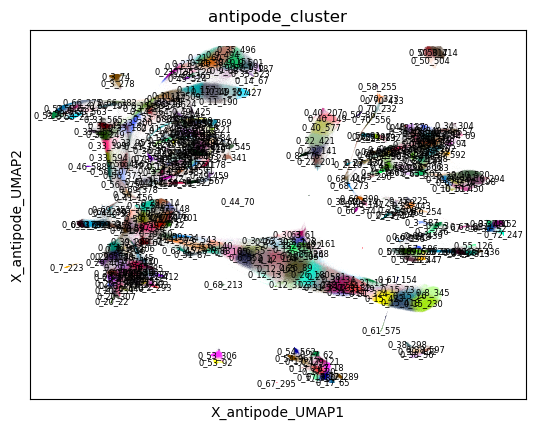

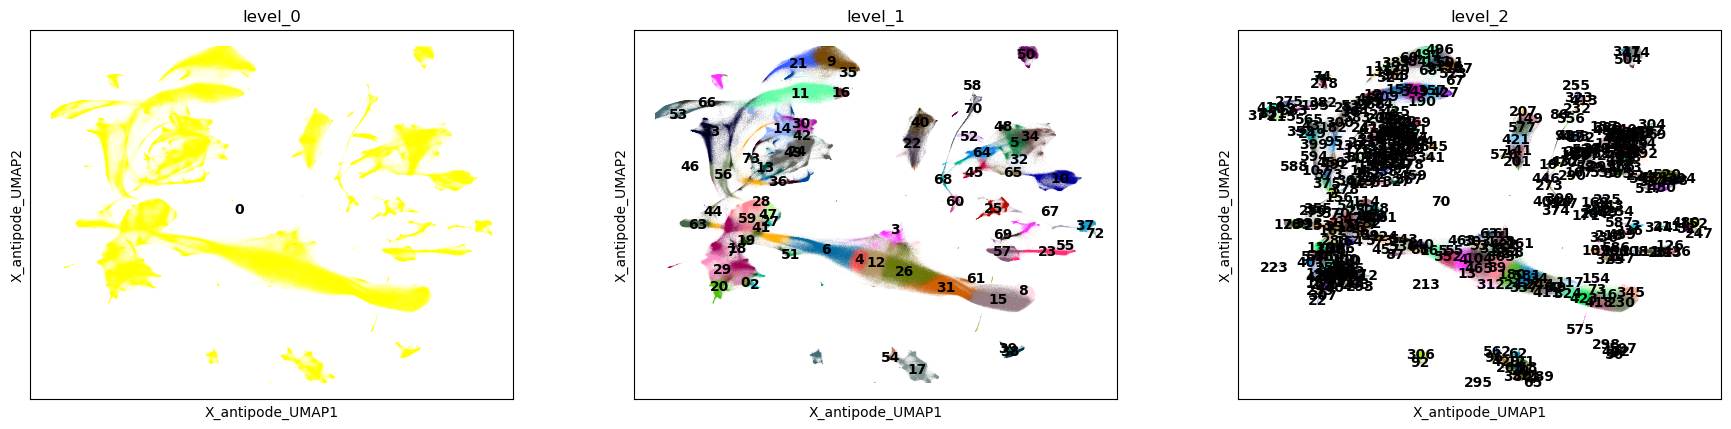

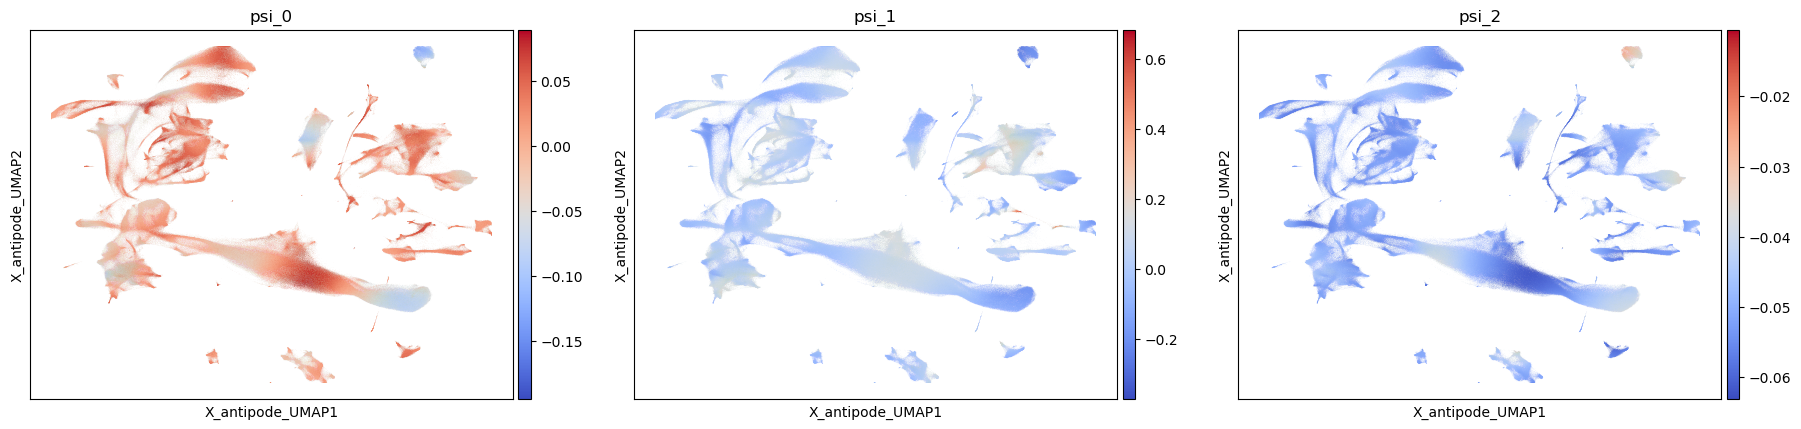

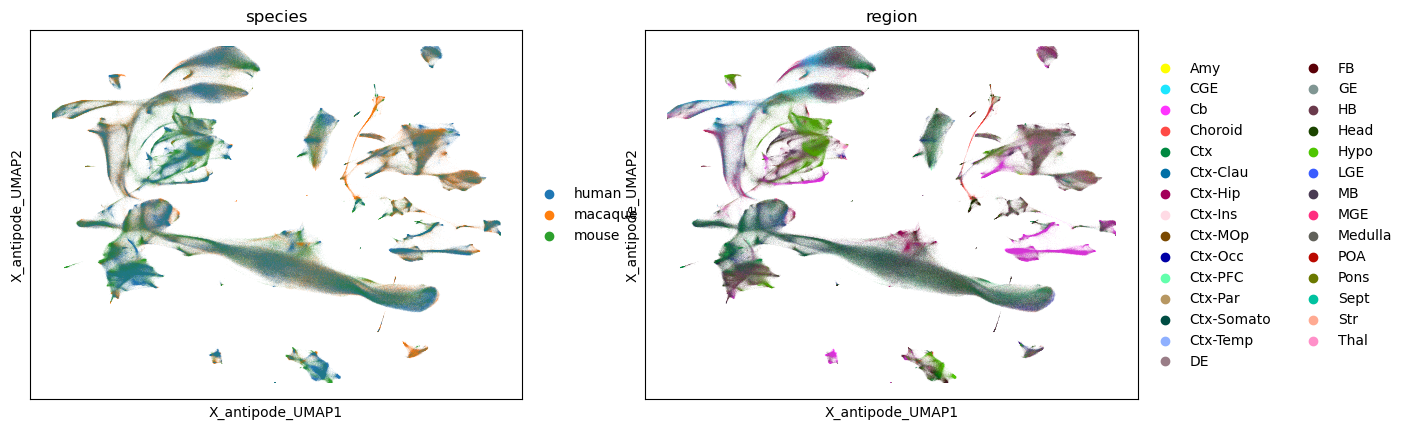

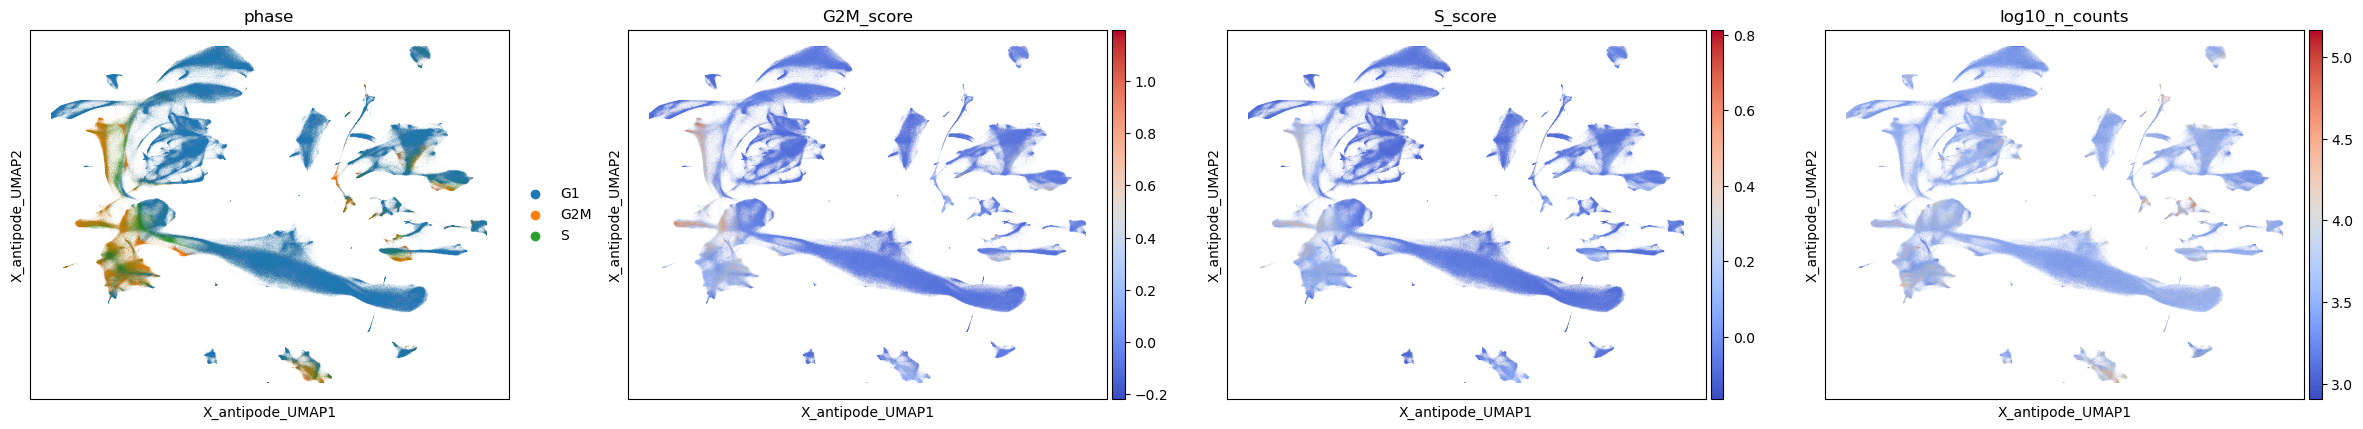

In [13]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=["antipode_cluster"],legend_fontsize=6,legend_fontweight='normal',#,"kmeans"
    legend_loc='on data',palette=sc.pl.palettes.godsnot_102
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[x for x in adata.obs.columns if 'level' in x],
    palette=sc.pl.palettes.godsnot_102,
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=[x for x in adata.obs.columns if 'psi' in x],
    cmap='coolwarm',
    legend_loc='on data'
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['species','region']
)

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['phase','G2M_score','S_score','log10_n_counts'],cmap='coolwarm'
)


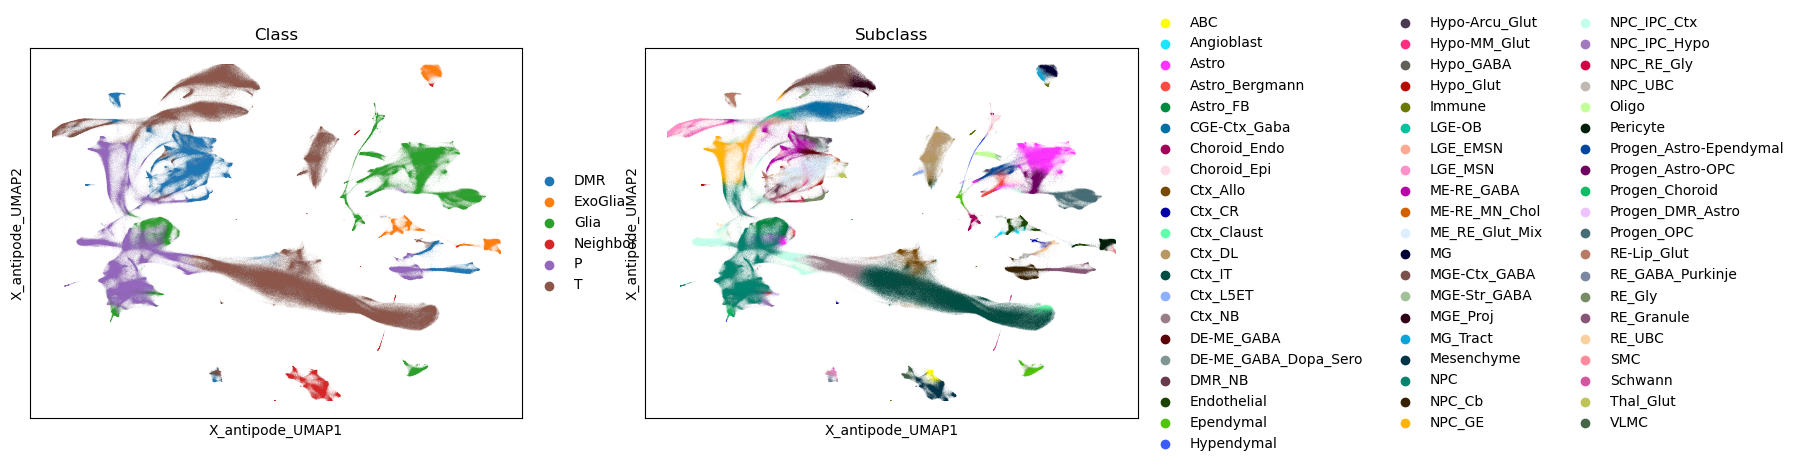

In [14]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['Class','Subclass']
)


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


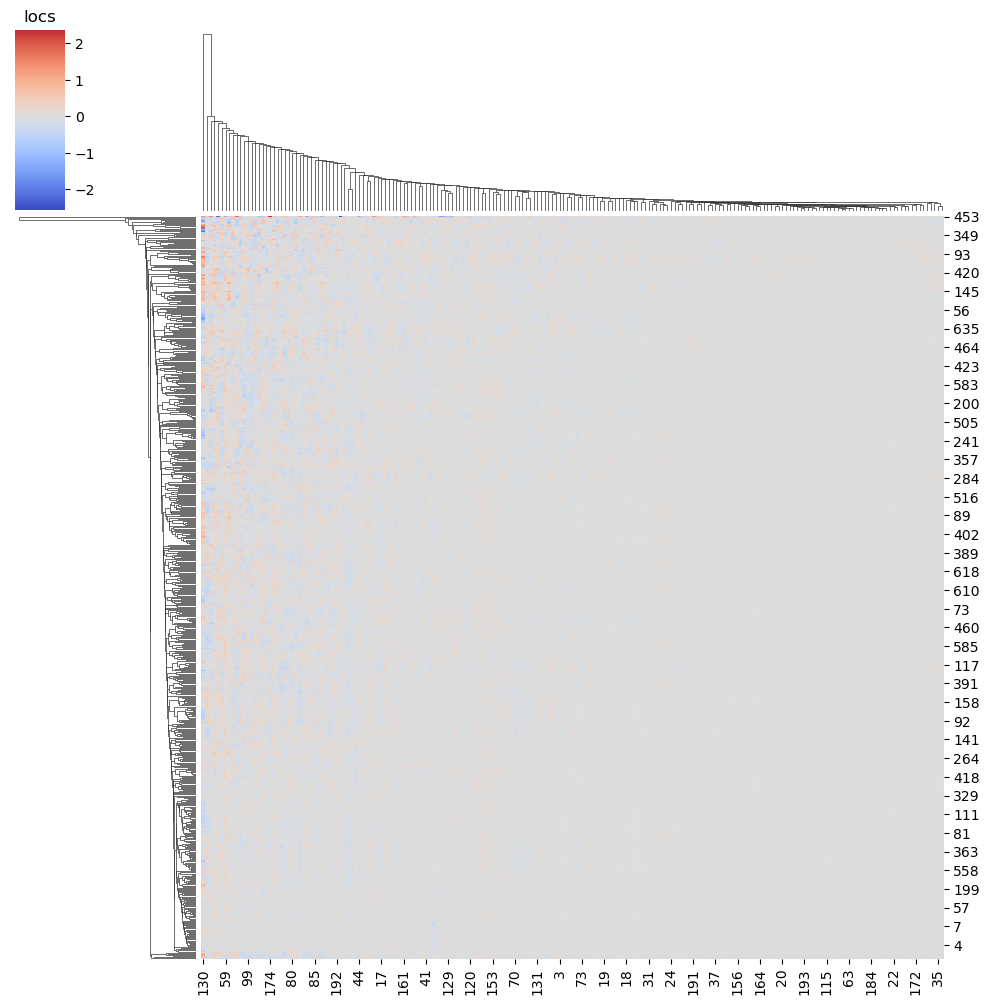

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


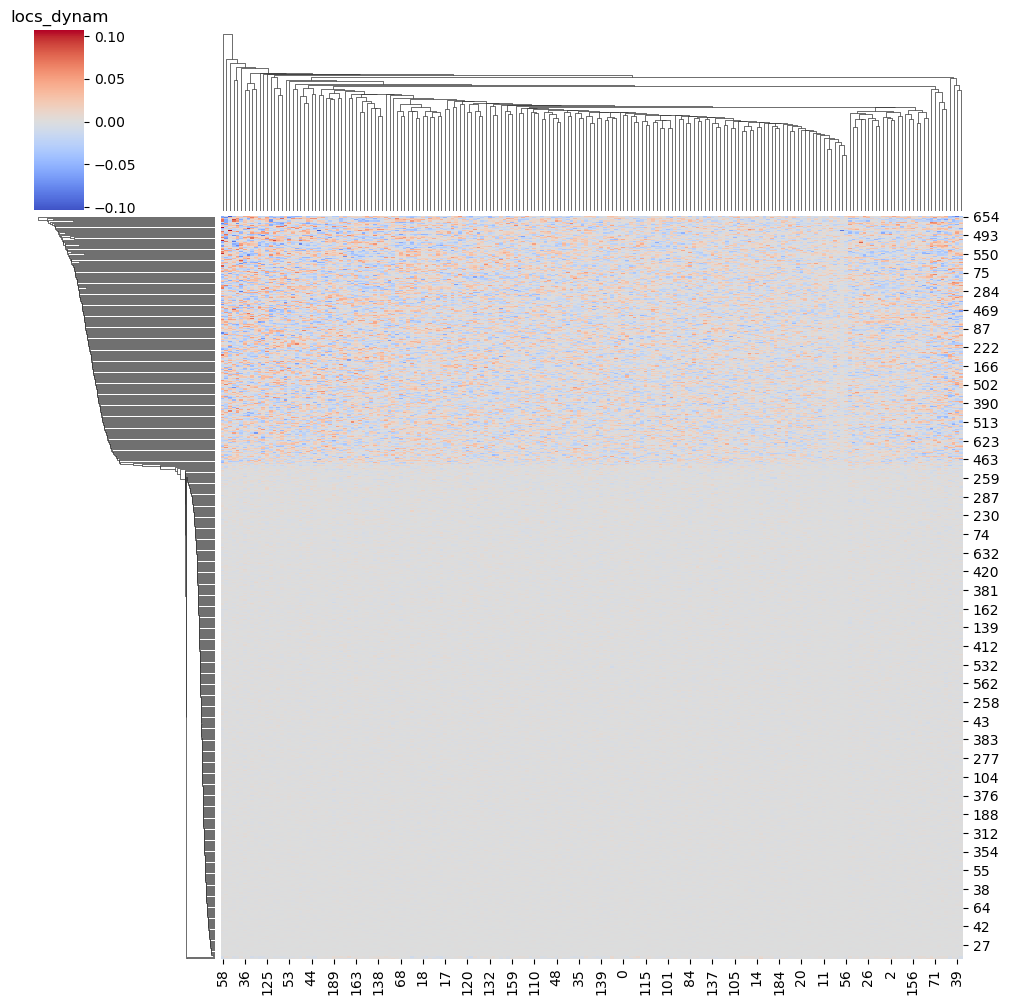

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


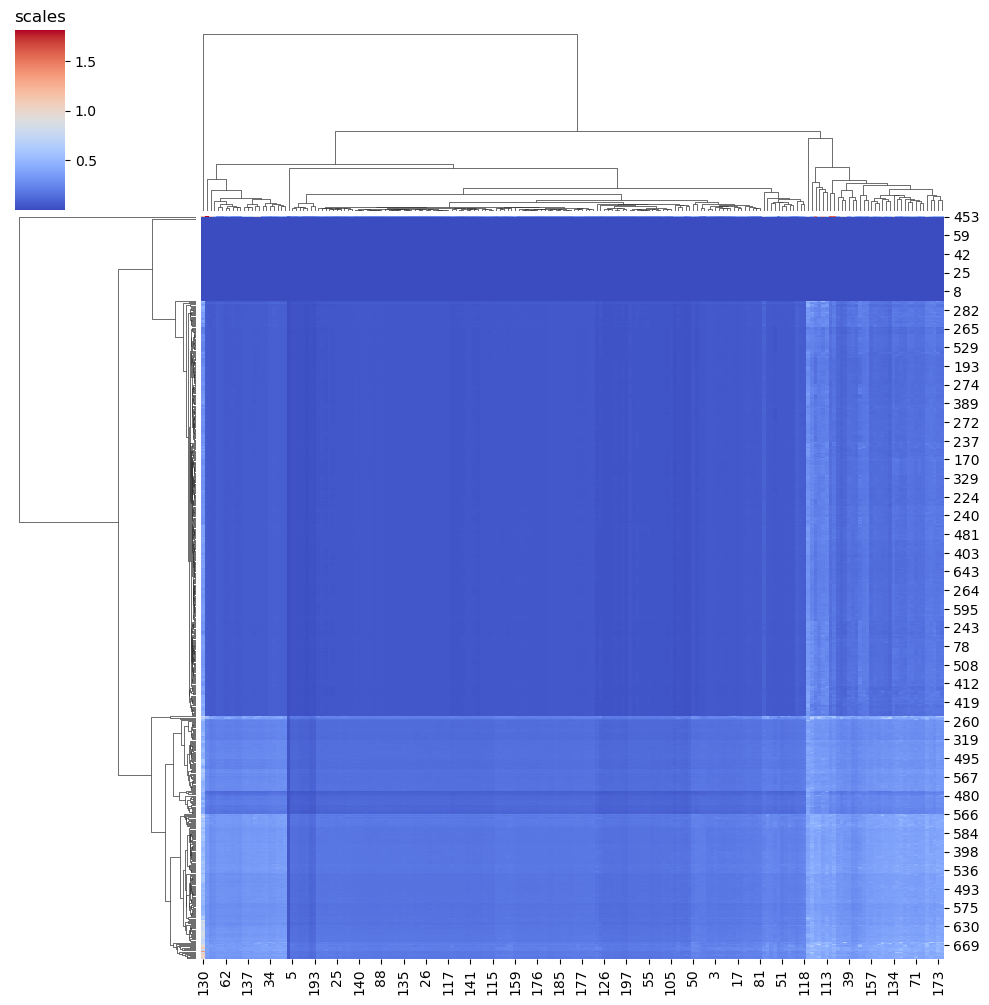

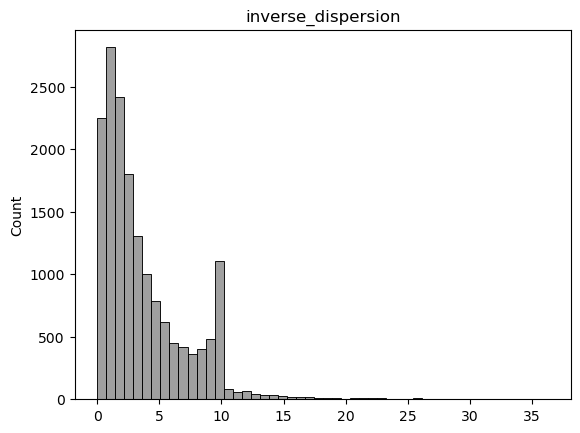

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


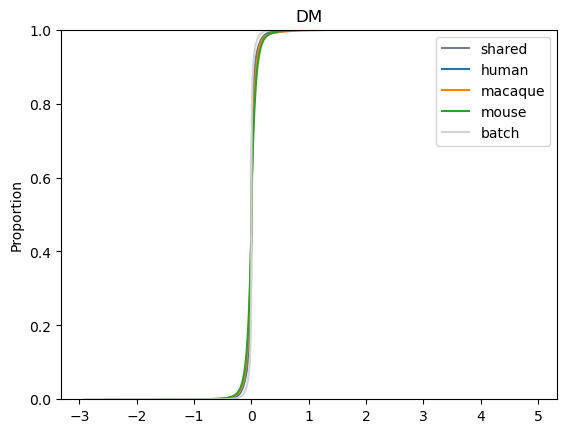

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


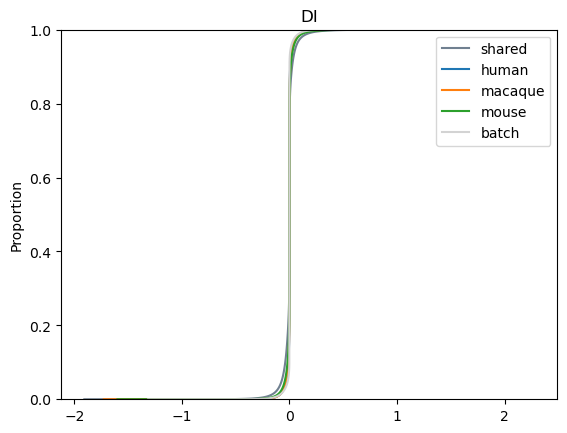

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


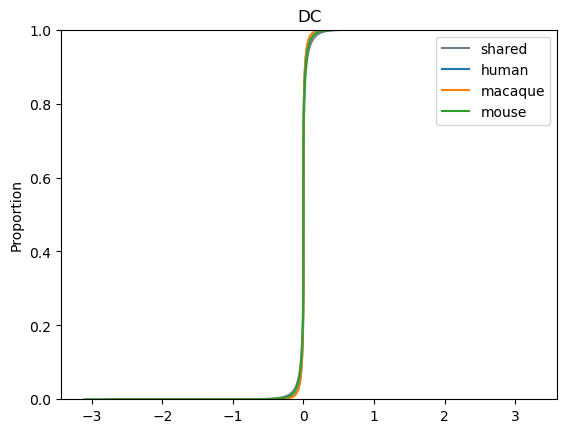

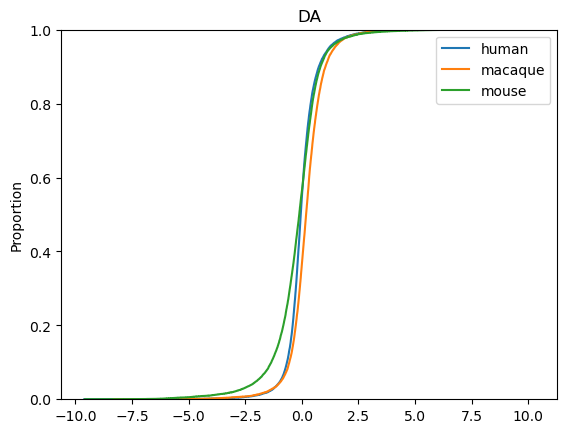

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/plotting.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(antipode_model.batch_key)[color_key]


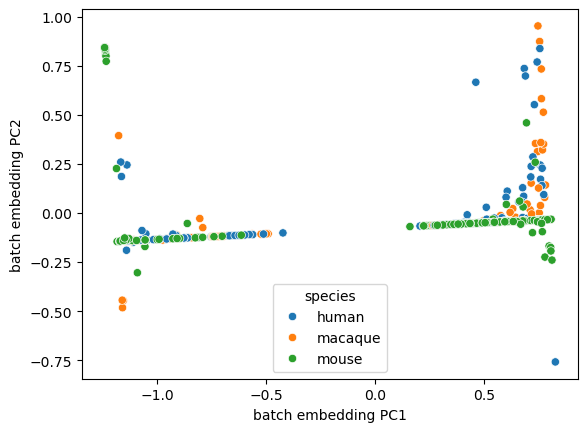

0         1                   batch_name species
0   -0.963063 -0.132712        CS12OpticVesicle_kOut   human
1    0.425462 -0.053974  CS13_anterior_midbrain_kOut   human
2    0.436141 -0.053193   CS13_central_midbrain_kOut   human
3   -0.752397 -0.120658          CS13_hindbrain_kOut   human
4   -1.044344 -0.137283   CS13_olfactory_pacode_kOut   human
..        ...       ...                          ...     ...
415  0.632760 -0.043174                       p0-WT2   mouse
416  0.393658 -0.056411                       p0-WT3   mouse
417  0.380067 -0.056397                       p0-WT4   mouse
418  0.159202 -0.069150       p07_Cortex_SRR11947654   mouse
419 -0.990361 -0.133878       p07_Cortex_SRR11947655   mouse

[420 rows x 4 columns]

In [15]:
# plot_loss(antipode_model.losses)
plot_gmm_heatmaps(antipode_model)
plot_d_hists(antipode_model,ecdf=True)
plot_batch_embedding_pca(antipode_model)

In [16]:
leaf_key = 'level_2'
log_real_means,real_mean_levels=antipode.model_functions.get_real_leaf_means(adata,discov_key,leaf_key,layer=layer_key)
real_means=pd.DataFrame(log_real_means.mean(0),columns=adata.var.index,index=real_mean_levels[leaf_key])
real_means=real_means.loc[real_mean_levels[leaf_key],:]
aggr_sums=group_aggr_anndata(adata,[leaf_key],layer=layer_key,normalize=False,agg_func=np.sum)


  0%|          | 0/1140 [00:00<?, ?it/s]

  0%|          | 1/1140 [00:00<02:34,  7.36it/s]

  0%|          | 2/1140 [00:00<04:11,  4.52it/s]

  0%|          | 3/1140 [00:01<14:40,  1.29it/s]

  0%|          | 4/1140 [00:02<11:19,  1.67it/s]

  1%|          | 7/1140 [00:02<05:45,  3.28it/s]

  1%|          | 8/1140 [00:02<04:52,  3.87it/s]

  1%|          | 10/1140 [00:02<03:26,  5.46it/s]

  1%|          | 11/1140 [00:03<04:38,  4.05it/s]

  1%|          | 12/1140 [00:03<05:16,  3.57it/s]

  1%|          | 13/1140 [00:04<08:03,  2.33it/s]

  1%|▏         | 16/1140 [00:04<04:46,  3.92it/s]

  1%|▏         | 17/1140 [00:05<05:16,  3.54it/s]

  2%|▏         | 18/1140 [00:05<04:41,  3.98it/s]

  2%|▏         | 19/1140 [00:05<05:10,  3.61it/s]

  2%|▏         | 20/1140 [00:05<04:43,  3.95it/s]

  2%|▏         | 21/1140 [00:06<04:45,  3.91it/s]

  2%|▏         | 23/1140 [00:06<03:34,  5.21it/s]

  2%|▏         | 24/1140 [00:06<03:52,  4.80it/s]

  2%|▏         | 25/1140 [00:06<03:31,  5.26it/s]

  2%|▏         | 27/1140 [00:06<02:32,  7.28it/s]

  2%|▏         | 28/1140 [00:07<02:38,  7.00it/s]

  3%|▎         | 29/1140 [00:07<02:38,  7.01it/s]

  3%|▎         | 30/1140 [00:07<03:18,  5.60it/s]

  3%|▎         | 32/1140 [00:07<03:25,  5.39it/s]

  3%|▎         | 34/1140 [00:08<03:29,  5.28it/s]

  3%|▎         | 35/1140 [00:08<04:48,  3.83it/s]

  3%|▎         | 36/1140 [00:08<04:13,  4.35it/s]

  3%|▎         | 37/1140 [00:09<04:02,  4.54it/s]

  3%|▎         | 38/1140 [00:09<04:16,  4.30it/s]

  4%|▎         | 42/1140 [00:09<02:11,  8.34it/s]

  4%|▍         | 44/1140 [00:09<01:54,  9.53it/s]

  4%|▍         | 46/1140 [00:10<02:19,  7.83it/s]

  4%|▍         | 47/1140 [00:10<02:53,  6.30it/s]

  4%|▍         | 48/1140 [00:10<03:49,  4.76it/s]

  4%|▍         | 50/1140 [00:10<03:05,  5.87it/s]

  4%|▍         | 51/1140 [00:12<07:21,  2.47it/s]

  5%|▍         | 52/1140 [00:12<06:18,  2.88it/s]

  5%|▍         | 54/1140 [00:12<04:24,  4.10it/s]

  5%|▍         | 56/1140 [00:12<03:28,  5.21it/s]

  5%|▌         | 57/1140 [00:13<04:03,  4.46it/s]

  5%|▌         | 58/1140 [00:14<10:10,  1.77it/s]

  5%|▌         | 61/1140 [00:15<05:43,  3.14it/s]

  5%|▌         | 62/1140 [00:15<05:16,  3.41it/s]

  6%|▌         | 63/1140 [00:15<04:42,  3.82it/s]

  6%|▌         | 64/1140 [00:15<04:03,  4.41it/s]

  6%|▌         | 65/1140 [00:15<03:47,  4.73it/s]

  6%|▌         | 67/1140 [00:16<06:29,  2.76it/s]

  6%|▌         | 68/1140 [00:17<06:13,  2.87it/s]

  6%|▌         | 69/1140 [00:17<05:44,  3.10it/s]

  6%|▌         | 70/1140 [00:17<06:00,  2.97it/s]

  6%|▌         | 71/1140 [00:17<05:05,  3.50it/s]

  6%|▋         | 72/1140 [00:18<05:35,  3.18it/s]

  6%|▋         | 73/1140 [00:18<05:08,  3.46it/s]

  6%|▋         | 74/1140 [00:18<04:51,  3.66it/s]

  7%|▋         | 76/1140 [00:18<03:21,  5.28it/s]

  7%|▋         | 77/1140 [00:19<04:56,  3.59it/s]

  7%|▋         | 78/1140 [00:19<04:13,  4.19it/s]

  7%|▋         | 79/1140 [00:19<04:31,  3.91it/s]

  7%|▋         | 80/1140 [00:20<03:46,  4.68it/s]

  7%|▋         | 81/1140 [00:20<03:24,  5.18it/s]

  7%|▋         | 83/1140 [00:20<02:24,  7.32it/s]

  7%|▋         | 84/1140 [00:20<02:28,  7.10it/s]

  8%|▊         | 87/1140 [00:20<02:01,  8.67it/s]

  8%|▊         | 88/1140 [00:20<02:09,  8.13it/s]

  8%|▊         | 89/1140 [00:21<02:33,  6.86it/s]

  8%|▊         | 90/1140 [00:21<04:24,  3.97it/s]

  8%|▊         | 92/1140 [00:22<03:46,  4.62it/s]

  8%|▊         | 93/1140 [00:22<04:02,  4.32it/s]

  8%|▊         | 94/1140 [00:22<04:45,  3.67it/s]

  8%|▊         | 95/1140 [00:22<04:39,  3.74it/s]

  8%|▊         | 96/1140 [00:23<04:06,  4.24it/s]

  9%|▊         | 99/1140 [00:23<03:22,  5.13it/s]

  9%|▉         | 100/1140 [00:24<05:24,  3.20it/s]

  9%|▉         | 101/1140 [00:24<04:44,  3.66it/s]

  9%|▉         | 102/1140 [00:25<07:11,  2.40it/s]

  9%|▉         | 103/1140 [00:25<07:03,  2.45it/s]

  9%|▉         | 104/1140 [00:25<05:42,  3.02it/s]

  9%|▉         | 106/1140 [00:26<05:10,  3.32it/s]

  9%|▉         | 108/1140 [00:27<06:21,  2.70it/s]

 10%|▉         | 109/1140 [00:27<05:30,  3.12it/s]

 10%|▉         | 111/1140 [00:27<05:01,  3.42it/s]

 10%|▉         | 112/1140 [00:28<05:01,  3.41it/s]

 10%|▉         | 113/1140 [00:29<07:29,  2.29it/s]

 10%|█         | 114/1140 [00:29<06:11,  2.76it/s]

 10%|█         | 117/1140 [00:29<03:53,  4.38it/s]

 10%|█         | 118/1140 [00:29<03:36,  4.73it/s]

 11%|█         | 122/1140 [00:30<04:20,  3.91it/s]

 11%|█         | 124/1140 [00:31<03:30,  4.83it/s]

 11%|█         | 126/1140 [00:31<03:04,  5.51it/s]

 11%|█         | 127/1140 [00:31<03:38,  4.63it/s]

 11%|█▏        | 129/1140 [00:31<02:51,  5.88it/s]

 11%|█▏        | 131/1140 [00:32<02:52,  5.85it/s]

 12%|█▏        | 132/1140 [00:32<02:42,  6.20it/s]

 12%|█▏        | 133/1140 [00:32<03:05,  5.44it/s]

 12%|█▏        | 134/1140 [00:32<02:45,  6.07it/s]

 12%|█▏        | 135/1140 [00:33<03:41,  4.54it/s]

 12%|█▏        | 136/1140 [00:33<03:22,  4.95it/s]

 12%|█▏        | 138/1140 [00:33<02:41,  6.21it/s]

 12%|█▏        | 140/1140 [00:33<02:13,  7.47it/s]

 12%|█▏        | 142/1140 [00:33<01:57,  8.51it/s]

 13%|█▎        | 143/1140 [00:33<01:56,  8.54it/s]

 13%|█▎        | 145/1140 [00:34<01:45,  9.41it/s]

 13%|█▎        | 148/1140 [00:34<01:40,  9.84it/s]

 13%|█▎        | 150/1140 [00:35<03:04,  5.37it/s]

 13%|█▎        | 153/1140 [00:35<02:18,  7.13it/s]

 14%|█▍        | 157/1140 [00:37<04:44,  3.46it/s]

 14%|█▍        | 158/1140 [00:37<04:19,  3.78it/s]

 14%|█▍        | 161/1140 [00:37<03:49,  4.26it/s]

 14%|█▍        | 162/1140 [00:38<03:36,  4.52it/s]

 14%|█▍        | 164/1140 [00:38<03:05,  5.27it/s]

 14%|█▍        | 165/1140 [00:39<05:46,  2.81it/s]

 15%|█▍        | 166/1140 [00:39<05:19,  3.05it/s]

 15%|█▍        | 168/1140 [00:40<05:18,  3.05it/s]

 15%|█▍        | 169/1140 [00:40<04:32,  3.56it/s]

 15%|█▍        | 170/1140 [00:40<04:04,  3.96it/s]

 15%|█▌        | 171/1140 [00:41<04:33,  3.54it/s]

 15%|█▌        | 172/1140 [00:41<04:09,  3.87it/s]

 15%|█▌        | 175/1140 [00:41<04:07,  3.90it/s]

 15%|█▌        | 176/1140 [00:42<03:44,  4.29it/s]

 16%|█▌        | 177/1140 [00:42<05:45,  2.79it/s]

 16%|█▌        | 180/1140 [00:43<03:22,  4.75it/s]

 16%|█▌        | 181/1140 [00:43<04:12,  3.80it/s]

 16%|█▌        | 182/1140 [00:43<04:14,  3.77it/s]

 16%|█▌        | 184/1140 [00:43<02:59,  5.31it/s]

 16%|█▌        | 185/1140 [00:44<03:59,  3.98it/s]

 16%|█▋        | 186/1140 [00:44<03:38,  4.36it/s]

 16%|█▋        | 188/1140 [00:44<02:32,  6.23it/s]

 17%|█▋        | 190/1140 [00:45<02:48,  5.63it/s]

 17%|█▋        | 191/1140 [00:45<03:14,  4.89it/s]

 17%|█▋        | 192/1140 [00:45<03:03,  5.16it/s]

 17%|█▋        | 193/1140 [00:45<02:44,  5.75it/s]

 17%|█▋        | 197/1140 [00:45<01:23, 11.26it/s]

 17%|█▋        | 199/1140 [00:46<02:01,  7.75it/s]

 18%|█▊        | 202/1140 [00:46<01:28, 10.60it/s]

 18%|█▊        | 204/1140 [00:47<02:24,  6.49it/s]

 18%|█▊        | 206/1140 [00:47<02:00,  7.73it/s]

 18%|█▊        | 208/1140 [00:47<02:11,  7.06it/s]

 18%|█▊        | 210/1140 [00:48<03:22,  4.58it/s]

 19%|█▊        | 212/1140 [00:48<02:50,  5.43it/s]

 19%|█▊        | 213/1140 [00:49<04:00,  3.85it/s]

 19%|█▉        | 215/1140 [00:50<05:17,  2.91it/s]

 19%|█▉        | 216/1140 [00:50<04:49,  3.19it/s]

 19%|█▉        | 217/1140 [00:50<04:41,  3.28it/s]

 19%|█▉        | 218/1140 [00:50<04:01,  3.81it/s]

 19%|█▉        | 219/1140 [00:50<03:35,  4.28it/s]

 19%|█▉        | 220/1140 [00:51<05:19,  2.88it/s]

 19%|█▉        | 221/1140 [00:52<06:30,  2.35it/s]

 20%|█▉        | 223/1140 [00:52<04:01,  3.79it/s]

 20%|█▉        | 224/1140 [00:52<03:38,  4.19it/s]

 20%|█▉        | 225/1140 [00:52<03:16,  4.67it/s]

 20%|█▉        | 227/1140 [00:52<03:03,  4.97it/s]

 20%|██        | 228/1140 [00:53<03:43,  4.08it/s]

 20%|██        | 229/1140 [00:53<04:15,  3.57it/s]

 20%|██        | 232/1140 [00:54<04:51,  3.12it/s]

 21%|██        | 234/1140 [00:56<08:04,  1.87it/s]

 21%|██        | 235/1140 [00:56<06:52,  2.19it/s]

 21%|██        | 237/1140 [00:57<04:51,  3.10it/s]

 21%|██        | 239/1140 [00:57<03:43,  4.04it/s]

 21%|██        | 240/1140 [00:57<03:45,  3.98it/s]

 21%|██        | 241/1140 [00:58<04:55,  3.04it/s]

 21%|██▏       | 243/1140 [00:58<03:31,  4.23it/s]

 21%|██▏       | 244/1140 [00:58<03:28,  4.29it/s]

 22%|██▏       | 246/1140 [00:58<02:53,  5.15it/s]

 22%|██▏       | 247/1140 [00:59<03:03,  4.86it/s]

 22%|██▏       | 248/1140 [00:59<02:43,  5.47it/s]

 22%|██▏       | 249/1140 [00:59<02:35,  5.72it/s]

 22%|██▏       | 250/1140 [00:59<04:19,  3.43it/s]

 22%|██▏       | 251/1140 [01:00<04:33,  3.25it/s]

 22%|██▏       | 252/1140 [01:00<04:02,  3.65it/s]

 22%|██▏       | 254/1140 [01:00<02:55,  5.04it/s]

 22%|██▏       | 255/1140 [01:01<04:11,  3.51it/s]

 23%|██▎       | 257/1140 [01:01<03:13,  4.56it/s]

 23%|██▎       | 260/1140 [01:02<04:06,  3.58it/s]

 23%|██▎       | 261/1140 [01:02<04:19,  3.38it/s]

 23%|██▎       | 264/1140 [01:03<02:48,  5.18it/s]

 23%|██▎       | 265/1140 [01:03<03:14,  4.50it/s]

 23%|██▎       | 266/1140 [01:03<03:04,  4.73it/s]

 24%|██▍       | 271/1140 [01:03<01:29,  9.76it/s]

 24%|██▍       | 273/1140 [01:04<01:44,  8.27it/s]

 24%|██▍       | 275/1140 [01:04<02:34,  5.60it/s]

 24%|██▍       | 277/1140 [01:05<02:35,  5.56it/s]

 24%|██▍       | 278/1140 [01:06<05:51,  2.45it/s]

 24%|██▍       | 279/1140 [01:07<07:25,  1.93it/s]

 25%|██▍       | 281/1140 [01:09<08:12,  1.74it/s]

 25%|██▍       | 282/1140 [01:09<06:58,  2.05it/s]

 25%|██▍       | 284/1140 [01:09<05:09,  2.76it/s]

 25%|██▌       | 285/1140 [01:09<04:31,  3.15it/s]

 25%|██▌       | 286/1140 [01:09<03:51,  3.68it/s]

 25%|██▌       | 287/1140 [01:09<03:25,  4.15it/s]

 25%|██▌       | 289/1140 [01:10<02:33,  5.55it/s]

 25%|██▌       | 290/1140 [01:10<02:25,  5.86it/s]

 26%|██▌       | 291/1140 [01:10<02:52,  4.92it/s]

 26%|██▌       | 292/1140 [01:10<03:06,  4.54it/s]

 26%|██▌       | 293/1140 [01:10<02:54,  4.85it/s]

 26%|██▌       | 295/1140 [01:11<02:04,  6.81it/s]

 26%|██▌       | 296/1140 [01:11<02:09,  6.53it/s]

 26%|██▌       | 297/1140 [01:11<02:01,  6.92it/s]

 26%|██▌       | 298/1140 [01:12<05:07,  2.74it/s]

 26%|██▌       | 299/1140 [01:12<04:06,  3.42it/s]

 26%|██▋       | 300/1140 [01:12<03:39,  3.82it/s]

 26%|██▋       | 301/1140 [01:12<03:10,  4.40it/s]

 27%|██▋       | 304/1140 [01:14<05:14,  2.66it/s]

 27%|██▋       | 305/1140 [01:14<04:31,  3.07it/s]

 27%|██▋       | 308/1140 [01:14<03:20,  4.15it/s]

 27%|██▋       | 309/1140 [01:14<03:07,  4.43it/s]

 27%|██▋       | 310/1140 [01:15<03:26,  4.02it/s]

 27%|██▋       | 311/1140 [01:15<03:04,  4.49it/s]

 28%|██▊       | 314/1140 [01:15<01:47,  7.66it/s]

 28%|██▊       | 316/1140 [01:15<01:41,  8.11it/s]

 28%|██▊       | 318/1140 [01:17<04:11,  3.27it/s]

 28%|██▊       | 320/1140 [01:17<03:29,  3.92it/s]

 28%|██▊       | 321/1140 [01:17<03:36,  3.79it/s]

 28%|██▊       | 322/1140 [01:17<03:17,  4.14it/s]

 28%|██▊       | 323/1140 [01:18<03:27,  3.93it/s]

 28%|██▊       | 324/1140 [01:18<03:22,  4.04it/s]

 29%|██▊       | 325/1140 [01:18<03:07,  4.34it/s]

 29%|██▊       | 327/1140 [01:19<03:43,  3.64it/s]

 29%|██▉       | 328/1140 [01:19<03:11,  4.23it/s]

 29%|██▉       | 329/1140 [01:19<03:02,  4.44it/s]

 29%|██▉       | 332/1140 [01:19<02:21,  5.72it/s]

 29%|██▉       | 334/1140 [01:20<01:59,  6.77it/s]

 30%|██▉       | 337/1140 [01:20<01:30,  8.87it/s]

 30%|██▉       | 339/1140 [01:20<01:52,  7.15it/s]

 30%|██▉       | 341/1140 [01:21<02:00,  6.64it/s]

 30%|███       | 342/1140 [01:21<03:10,  4.18it/s]

 30%|███       | 343/1140 [01:21<02:55,  4.55it/s]

 30%|███       | 344/1140 [01:22<03:10,  4.18it/s]

 30%|███       | 345/1140 [01:22<02:56,  4.50it/s]

 30%|███       | 346/1140 [01:22<02:58,  4.44it/s]

 30%|███       | 347/1140 [01:22<03:09,  4.18it/s]

 31%|███       | 348/1140 [01:23<04:45,  2.78it/s]

 31%|███       | 350/1140 [01:24<04:52,  2.70it/s]

 31%|███       | 351/1140 [01:24<04:05,  3.21it/s]

 31%|███       | 353/1140 [01:24<02:49,  4.65it/s]

 31%|███       | 355/1140 [01:24<02:19,  5.61it/s]

 31%|███▏      | 357/1140 [01:25<02:30,  5.20it/s]

 31%|███▏      | 359/1140 [01:25<02:05,  6.23it/s]

 32%|███▏      | 360/1140 [01:25<02:07,  6.10it/s]

 32%|███▏      | 361/1140 [01:26<02:35,  5.02it/s]

 32%|███▏      | 363/1140 [01:26<02:32,  5.09it/s]

 32%|███▏      | 364/1140 [01:26<02:42,  4.78it/s]

 32%|███▏      | 366/1140 [01:26<02:13,  5.82it/s]

 32%|███▏      | 367/1140 [01:27<03:51,  3.34it/s]

 32%|███▏      | 368/1140 [01:28<06:26,  2.00it/s]

 33%|███▎      | 371/1140 [01:28<03:29,  3.67it/s]

 33%|███▎      | 375/1140 [01:29<02:01,  6.32it/s]

 33%|███▎      | 377/1140 [01:29<02:06,  6.05it/s]

 33%|███▎      | 379/1140 [01:29<01:50,  6.91it/s]

 33%|███▎      | 381/1140 [01:29<01:42,  7.37it/s]

 34%|███▎      | 383/1140 [01:31<03:30,  3.59it/s]

 34%|███▎      | 384/1140 [01:31<03:45,  3.36it/s]

 34%|███▍      | 387/1140 [01:32<02:59,  4.19it/s]

 34%|███▍      | 390/1140 [01:32<02:02,  6.11it/s]

 34%|███▍      | 392/1140 [01:32<02:26,  5.10it/s]

 35%|███▍      | 396/1140 [01:32<01:42,  7.26it/s]

 35%|███▍      | 398/1140 [01:33<01:39,  7.44it/s]

 35%|███▌      | 400/1140 [01:33<01:51,  6.62it/s]

 35%|███▌      | 401/1140 [01:33<01:51,  6.66it/s]

 35%|███▌      | 403/1140 [01:34<01:49,  6.75it/s]

 35%|███▌      | 404/1140 [01:34<02:48,  4.38it/s]

 36%|███▌      | 405/1140 [01:34<03:00,  4.07it/s]

 36%|███▌      | 407/1140 [01:35<02:16,  5.37it/s]

 36%|███▌      | 408/1140 [01:35<02:24,  5.06it/s]

 36%|███▌      | 410/1140 [01:35<02:27,  4.96it/s]

 36%|███▌      | 412/1140 [01:36<02:31,  4.82it/s]

 36%|███▌      | 413/1140 [01:36<03:31,  3.43it/s]

 36%|███▋      | 414/1140 [01:37<03:29,  3.47it/s]

 36%|███▋      | 415/1140 [01:37<03:30,  3.44it/s]

 37%|███▋      | 417/1140 [01:37<02:38,  4.57it/s]

 37%|███▋      | 418/1140 [01:37<02:25,  4.96it/s]

 37%|███▋      | 422/1140 [01:37<01:22,  8.73it/s]

 37%|███▋      | 425/1140 [01:38<01:19,  8.98it/s]

 37%|███▋      | 427/1140 [01:39<02:09,  5.52it/s]

 38%|███▊      | 428/1140 [01:39<02:23,  4.97it/s]

 38%|███▊      | 431/1140 [01:40<03:06,  3.79it/s]

 38%|███▊      | 432/1140 [01:40<03:03,  3.86it/s]

 38%|███▊      | 436/1140 [01:40<01:54,  6.17it/s]

 38%|███▊      | 437/1140 [01:41<02:15,  5.18it/s]

 38%|███▊      | 438/1140 [01:42<05:22,  2.18it/s]

 39%|███▊      | 439/1140 [01:43<04:38,  2.52it/s]

 39%|███▊      | 440/1140 [01:43<04:01,  2.89it/s]

 39%|███▉      | 442/1140 [01:43<03:11,  3.64it/s]

 39%|███▉      | 443/1140 [01:43<02:57,  3.92it/s]

 39%|███▉      | 444/1140 [01:43<02:34,  4.51it/s]

 39%|███▉      | 446/1140 [01:44<01:49,  6.34it/s]

 39%|███▉      | 447/1140 [01:44<03:26,  3.36it/s]

 39%|███▉      | 448/1140 [01:45<03:25,  3.37it/s]

 39%|███▉      | 449/1140 [01:45<03:02,  3.79it/s]

 39%|███▉      | 450/1140 [01:45<02:45,  4.16it/s]

 40%|███▉      | 451/1140 [01:45<02:23,  4.81it/s]

 40%|███▉      | 452/1140 [01:45<02:31,  4.53it/s]

 40%|███▉      | 453/1140 [01:46<02:45,  4.15it/s]

 40%|███▉      | 454/1140 [01:46<03:23,  3.38it/s]

 40%|███▉      | 455/1140 [01:46<02:57,  3.86it/s]

 40%|████      | 456/1140 [01:47<03:09,  3.61it/s]

 40%|████      | 457/1140 [01:47<03:13,  3.53it/s]

 40%|████      | 461/1140 [01:47<01:31,  7.44it/s]

 41%|████      | 464/1140 [01:47<01:05, 10.38it/s]

 41%|████      | 466/1140 [01:47<00:59, 11.28it/s]

 41%|████      | 468/1140 [01:48<02:14,  4.99it/s]

 41%|████      | 470/1140 [01:49<03:14,  3.44it/s]

 41%|████▏     | 471/1140 [01:49<02:53,  3.86it/s]

 41%|████▏     | 472/1140 [01:50<03:09,  3.52it/s]

 41%|████▏     | 473/1140 [01:50<03:13,  3.45it/s]

 42%|████▏     | 474/1140 [01:50<03:07,  3.56it/s]

 42%|████▏     | 475/1140 [01:51<03:19,  3.34it/s]

 42%|████▏     | 476/1140 [01:51<03:12,  3.45it/s]

 42%|████▏     | 479/1140 [01:51<02:06,  5.21it/s]

 42%|████▏     | 480/1140 [01:51<02:02,  5.40it/s]

 42%|████▏     | 482/1140 [01:52<02:48,  3.92it/s]

 42%|████▏     | 483/1140 [01:52<02:48,  3.90it/s]

 43%|████▎     | 486/1140 [01:53<01:42,  6.39it/s]

 43%|████▎     | 488/1140 [01:53<02:14,  4.83it/s]

 43%|████▎     | 491/1140 [01:54<02:03,  5.25it/s]

 43%|████▎     | 492/1140 [01:54<02:11,  4.93it/s]

 43%|████▎     | 493/1140 [01:55<03:00,  3.58it/s]

 43%|████▎     | 494/1140 [01:55<02:52,  3.74it/s]

 43%|████▎     | 495/1140 [01:55<02:31,  4.25it/s]

 44%|████▎     | 497/1140 [01:55<02:11,  4.91it/s]

 44%|████▎     | 498/1140 [01:55<02:13,  4.79it/s]

 44%|████▍     | 502/1140 [01:57<03:07,  3.40it/s]

 44%|████▍     | 503/1140 [01:57<02:49,  3.75it/s]

 44%|████▍     | 504/1140 [01:57<02:38,  4.01it/s]

 44%|████▍     | 506/1140 [01:57<01:57,  5.38it/s]

 44%|████▍     | 507/1140 [01:57<01:46,  5.92it/s]

 45%|████▍     | 510/1140 [01:58<01:17,  8.11it/s]

 45%|████▍     | 512/1140 [01:58<01:21,  7.71it/s]

 45%|████▌     | 513/1140 [01:58<01:23,  7.51it/s]

 45%|████▌     | 514/1140 [01:58<01:25,  7.29it/s]

 45%|████▌     | 515/1140 [01:59<03:15,  3.20it/s]

 45%|████▌     | 516/1140 [02:00<03:19,  3.14it/s]

 45%|████▌     | 518/1140 [02:00<02:51,  3.63it/s]

 46%|████▌     | 519/1140 [02:00<02:30,  4.13it/s]

 46%|████▌     | 521/1140 [02:00<01:52,  5.51it/s]

 46%|████▌     | 524/1140 [02:00<01:23,  7.35it/s]

 46%|████▌     | 525/1140 [02:01<01:38,  6.26it/s]

 46%|████▋     | 528/1140 [02:01<01:24,  7.20it/s]

 46%|████▋     | 529/1140 [02:01<01:48,  5.64it/s]

 47%|████▋     | 531/1140 [02:02<01:25,  7.11it/s]

 47%|████▋     | 535/1140 [02:02<01:03,  9.52it/s]

 47%|████▋     | 537/1140 [02:03<02:24,  4.17it/s]

 47%|████▋     | 538/1140 [02:03<02:16,  4.41it/s]

 47%|████▋     | 539/1140 [02:04<02:27,  4.08it/s]

 47%|████▋     | 541/1140 [02:04<01:47,  5.56it/s]

 48%|████▊     | 544/1140 [02:04<01:25,  6.98it/s]

 48%|████▊     | 546/1140 [02:05<02:01,  4.88it/s]

 48%|████▊     | 548/1140 [02:05<02:05,  4.71it/s]

 48%|████▊     | 550/1140 [02:05<01:42,  5.74it/s]

 48%|████▊     | 551/1140 [02:05<01:40,  5.88it/s]

 48%|████▊     | 552/1140 [02:06<01:34,  6.22it/s]

 49%|████▊     | 553/1140 [02:06<01:31,  6.45it/s]

 49%|████▉     | 556/1140 [02:06<01:54,  5.12it/s]

 49%|████▉     | 560/1140 [02:07<01:11,  8.06it/s]

 49%|████▉     | 562/1140 [02:07<01:19,  7.31it/s]

 49%|████▉     | 564/1140 [02:07<01:16,  7.55it/s]

 50%|████▉     | 565/1140 [02:07<01:19,  7.23it/s]

 50%|████▉     | 566/1140 [02:08<01:17,  7.40it/s]

 50%|█████     | 571/1140 [02:08<00:52, 10.86it/s]

 50%|█████     | 573/1140 [02:08<01:00,  9.35it/s]

 51%|█████     | 576/1140 [02:08<00:52, 10.83it/s]

 51%|█████     | 578/1140 [02:09<00:59,  9.37it/s]

 51%|█████     | 580/1140 [02:09<00:56,  9.97it/s]

 51%|█████     | 583/1140 [02:09<00:51, 10.87it/s]

 51%|█████▏    | 585/1140 [02:09<00:47, 11.79it/s]

 51%|█████▏    | 587/1140 [02:10<01:00,  9.07it/s]

 52%|█████▏    | 589/1140 [02:10<01:03,  8.67it/s]

 52%|█████▏    | 590/1140 [02:10<01:05,  8.44it/s]

 52%|█████▏    | 592/1140 [02:10<00:59,  9.13it/s]

 52%|█████▏    | 594/1140 [02:10<00:50, 10.74it/s]

 52%|█████▏    | 596/1140 [02:11<01:32,  5.90it/s]

 53%|█████▎    | 599/1140 [02:11<01:02,  8.62it/s]

 53%|█████▎    | 601/1140 [02:11<01:04,  8.30it/s]

 53%|█████▎    | 604/1140 [02:11<00:53, 10.06it/s]

 53%|█████▎    | 607/1140 [02:12<00:42, 12.50it/s]

 53%|█████▎    | 609/1140 [02:12<00:57,  9.27it/s]

 54%|█████▎    | 611/1140 [02:12<00:50, 10.53it/s]

 54%|█████▍    | 613/1140 [02:12<00:57,  9.09it/s]

 54%|█████▍    | 615/1140 [02:13<01:32,  5.65it/s]

 54%|█████▍    | 617/1140 [02:13<01:24,  6.20it/s]

 54%|█████▍    | 618/1140 [02:14<01:33,  5.58it/s]

 54%|█████▍    | 621/1140 [02:14<01:28,  5.84it/s]

 55%|█████▍    | 624/1140 [02:14<01:04,  8.02it/s]

 55%|█████▍    | 626/1140 [02:15<01:12,  7.09it/s]

 55%|█████▌    | 629/1140 [02:15<01:03,  8.09it/s]

 55%|█████▌    | 631/1140 [02:15<00:56,  9.04it/s]

 56%|█████▌    | 633/1140 [02:15<00:52,  9.67it/s]

 56%|█████▌    | 635/1140 [02:16<01:05,  7.70it/s]

 56%|█████▌    | 638/1140 [02:16<00:50,  9.90it/s]

 56%|█████▌    | 640/1140 [02:16<01:09,  7.20it/s]

 56%|█████▌    | 641/1140 [02:16<01:15,  6.61it/s]

 56%|█████▋    | 642/1140 [02:17<01:18,  6.34it/s]

 56%|█████▋    | 644/1140 [02:17<01:02,  7.95it/s]

 57%|█████▋    | 645/1140 [02:17<01:11,  6.95it/s]

 57%|█████▋    | 647/1140 [02:17<01:13,  6.68it/s]

 57%|█████▋    | 652/1140 [02:17<00:41, 11.66it/s]

 57%|█████▋    | 655/1140 [02:18<00:48,  9.91it/s]

 58%|█████▊    | 657/1140 [02:18<00:46, 10.49it/s]

 58%|█████▊    | 659/1140 [02:19<01:28,  5.42it/s]

 58%|█████▊    | 660/1140 [02:19<01:24,  5.67it/s]

 58%|█████▊    | 661/1140 [02:20<01:56,  4.10it/s]

 58%|█████▊    | 664/1140 [02:20<01:25,  5.56it/s]

 58%|█████▊    | 666/1140 [02:20<01:15,  6.28it/s]

 59%|█████▊    | 668/1140 [02:20<01:01,  7.73it/s]

 59%|█████▉    | 672/1140 [02:20<00:42, 11.13it/s]

 59%|█████▉    | 674/1140 [02:21<00:55,  8.34it/s]

 59%|█████▉    | 676/1140 [02:21<01:04,  7.19it/s]

 59%|█████▉    | 678/1140 [02:21<00:54,  8.55it/s]

 60%|█████▉    | 680/1140 [02:22<00:54,  8.41it/s]

 60%|█████▉    | 682/1140 [02:22<00:45,  9.99it/s]

 60%|██████    | 684/1140 [02:22<01:14,  6.12it/s]

 60%|██████    | 686/1140 [02:22<01:02,  7.24it/s]

 60%|██████    | 688/1140 [02:23<00:55,  8.12it/s]

 61%|██████    | 690/1140 [02:23<00:53,  8.46it/s]

 61%|██████    | 692/1140 [02:23<00:50,  8.84it/s]

 61%|██████    | 694/1140 [02:23<00:53,  8.37it/s]

 61%|██████    | 696/1140 [02:23<00:48,  9.16it/s]

 61%|██████    | 698/1140 [02:24<01:07,  6.51it/s]

 61%|██████▏   | 699/1140 [02:24<01:06,  6.63it/s]

 61%|██████▏   | 700/1140 [02:24<01:03,  6.98it/s]

 61%|██████▏   | 701/1140 [02:24<00:59,  7.44it/s]

 62%|██████▏   | 704/1140 [02:25<00:49,  8.74it/s]

 62%|██████▏   | 705/1140 [02:25<00:57,  7.60it/s]

 62%|██████▏   | 707/1140 [02:25<01:01,  7.05it/s]

 62%|██████▏   | 710/1140 [02:25<00:43,  9.99it/s]

 62%|██████▏   | 712/1140 [02:26<01:10,  6.06it/s]

 63%|██████▎   | 715/1140 [02:26<00:51,  8.29it/s]

 63%|██████▎   | 717/1140 [02:26<00:51,  8.14it/s]

 63%|██████▎   | 719/1140 [02:27<00:57,  7.36it/s]

 63%|██████▎   | 721/1140 [02:27<00:53,  7.83it/s]

 63%|██████▎   | 722/1140 [02:27<01:06,  6.32it/s]

 64%|██████▎   | 725/1140 [02:27<00:52,  7.94it/s]

 64%|██████▍   | 727/1140 [02:28<00:45,  9.10it/s]

 64%|██████▍   | 729/1140 [02:28<00:53,  7.64it/s]

 64%|██████▍   | 730/1140 [02:28<01:07,  6.06it/s]

 64%|██████▍   | 731/1140 [02:28<01:08,  5.96it/s]

 64%|██████▍   | 732/1140 [02:29<01:10,  5.78it/s]

 64%|██████▍   | 735/1140 [02:29<00:50,  8.01it/s]

 65%|██████▍   | 737/1140 [02:29<00:45,  8.92it/s]

 65%|██████▍   | 740/1140 [02:29<00:35, 11.18it/s]

 65%|██████▌   | 742/1140 [02:30<00:51,  7.75it/s]

 65%|██████▌   | 743/1140 [02:30<00:55,  7.10it/s]

 65%|██████▌   | 745/1140 [02:30<00:45,  8.76it/s]

 66%|██████▌   | 747/1140 [02:30<00:50,  7.84it/s]

 66%|██████▌   | 748/1140 [02:31<01:35,  4.10it/s]

 66%|██████▌   | 751/1140 [02:31<00:59,  6.54it/s]

 66%|██████▌   | 753/1140 [02:31<00:48,  7.93it/s]

 66%|██████▋   | 756/1140 [02:31<00:38,  9.95it/s]

 66%|██████▋   | 758/1140 [02:32<00:47,  8.01it/s]

 67%|██████▋   | 760/1140 [02:32<00:43,  8.81it/s]

 67%|██████▋   | 762/1140 [02:32<00:40,  9.26it/s]

 67%|██████▋   | 764/1140 [02:33<00:52,  7.16it/s]

 67%|██████▋   | 766/1140 [02:33<00:43,  8.61it/s]

 67%|██████▋   | 768/1140 [02:33<00:45,  8.13it/s]

 68%|██████▊   | 770/1140 [02:33<00:42,  8.80it/s]

 68%|██████▊   | 772/1140 [02:34<00:46,  7.98it/s]

 68%|██████▊   | 773/1140 [02:34<00:47,  7.81it/s]

 68%|██████▊   | 776/1140 [02:34<00:51,  7.03it/s]

 68%|██████▊   | 778/1140 [02:34<00:48,  7.52it/s]

 68%|██████▊   | 780/1140 [02:35<00:45,  8.00it/s]

 69%|██████▊   | 781/1140 [02:35<00:48,  7.36it/s]

 69%|██████▉   | 784/1140 [02:35<00:38,  9.35it/s]

 69%|██████▉   | 787/1140 [02:35<00:28, 12.52it/s]

 69%|██████▉   | 789/1140 [02:35<00:29, 11.95it/s]

 69%|██████▉   | 791/1140 [02:35<00:27, 12.70it/s]

 70%|██████▉   | 793/1140 [02:36<00:27, 12.47it/s]

 70%|██████▉   | 795/1140 [02:36<00:29, 11.60it/s]

 70%|██████▉   | 797/1140 [02:36<00:32, 10.57it/s]

 70%|███████   | 799/1140 [02:36<00:30, 11.03it/s]

 70%|███████   | 801/1140 [02:36<00:35,  9.63it/s]

 71%|███████   | 805/1140 [02:37<00:23, 14.15it/s]

 71%|███████   | 807/1140 [02:37<00:26, 12.76it/s]

 71%|███████   | 810/1140 [02:37<00:22, 14.80it/s]

 71%|███████   | 812/1140 [02:37<00:32,  9.96it/s]

 71%|███████▏  | 814/1140 [02:38<00:33,  9.72it/s]

 72%|███████▏  | 816/1140 [02:38<00:35,  9.21it/s]

 72%|███████▏  | 818/1140 [02:38<00:46,  6.90it/s]

 72%|███████▏  | 822/1140 [02:38<00:31, 10.02it/s]

 72%|███████▏  | 824/1140 [02:39<00:37,  8.34it/s]

 73%|███████▎  | 827/1140 [02:39<00:39,  7.98it/s]

 73%|███████▎  | 829/1140 [02:39<00:34,  9.06it/s]

 73%|███████▎  | 831/1140 [02:40<00:33,  9.22it/s]

 73%|███████▎  | 834/1140 [02:40<00:26, 11.50it/s]

 73%|███████▎  | 836/1140 [02:40<00:28, 10.80it/s]

 74%|███████▎  | 838/1140 [02:40<00:41,  7.27it/s]

 74%|███████▎  | 839/1140 [02:41<00:41,  7.32it/s]

 74%|███████▍  | 841/1140 [02:41<00:34,  8.60it/s]

 74%|███████▍  | 844/1140 [02:41<00:30,  9.63it/s]

 74%|███████▍  | 846/1140 [02:41<00:27, 10.64it/s]

 74%|███████▍  | 849/1140 [02:41<00:22, 12.96it/s]

 75%|███████▍  | 851/1140 [02:41<00:24, 11.91it/s]

 75%|███████▍  | 854/1140 [02:42<00:26, 10.93it/s]

 75%|███████▌  | 856/1140 [02:42<00:25, 11.09it/s]

 75%|███████▌  | 859/1140 [02:42<00:20, 13.75it/s]

 76%|███████▌  | 861/1140 [02:42<00:20, 13.72it/s]

 76%|███████▌  | 863/1140 [02:43<00:28,  9.60it/s]

 76%|███████▌  | 866/1140 [02:43<00:23, 11.79it/s]

 76%|███████▌  | 869/1140 [02:43<00:23, 11.78it/s]

 76%|███████▋  | 871/1140 [02:43<00:26, 10.22it/s]

 77%|███████▋  | 873/1140 [02:44<00:41,  6.41it/s]

 77%|███████▋  | 876/1140 [02:44<00:33,  7.94it/s]

 77%|███████▋  | 878/1140 [02:44<00:28,  9.13it/s]

 77%|███████▋  | 880/1140 [02:44<00:27,  9.52it/s]

 77%|███████▋  | 882/1140 [02:45<00:35,  7.23it/s]

 78%|███████▊  | 884/1140 [02:45<00:29,  8.70it/s]

 78%|███████▊  | 886/1140 [02:45<00:28,  9.01it/s]

 78%|███████▊  | 888/1140 [02:46<00:38,  6.56it/s]

 78%|███████▊  | 891/1140 [02:46<00:33,  7.44it/s]

 78%|███████▊  | 892/1140 [02:46<00:32,  7.67it/s]

 78%|███████▊  | 893/1140 [02:46<00:36,  6.79it/s]

 79%|███████▊  | 896/1140 [02:46<00:24, 10.02it/s]

 79%|███████▉  | 898/1140 [02:47<00:33,  7.16it/s]

 79%|███████▉  | 900/1140 [02:47<00:27,  8.82it/s]

 79%|███████▉  | 902/1140 [02:47<00:23, 10.23it/s]

 79%|███████▉  | 906/1140 [02:47<00:15, 14.88it/s]

 80%|███████▉  | 908/1140 [02:48<00:18, 12.34it/s]

 80%|████████  | 912/1140 [02:48<00:15, 14.48it/s]

 80%|████████  | 914/1140 [02:48<00:19, 11.62it/s]

 80%|████████  | 917/1140 [02:48<00:19, 11.30it/s]

 81%|████████  | 920/1140 [02:49<00:17, 12.25it/s]

 81%|████████  | 922/1140 [02:49<00:18, 12.11it/s]

 81%|████████  | 924/1140 [02:49<00:16, 13.06it/s]

 81%|████████  | 926/1140 [02:49<00:19, 10.75it/s]

 81%|████████▏ | 928/1140 [02:49<00:18, 11.45it/s]

 82%|████████▏ | 930/1140 [02:49<00:17, 12.28it/s]

 82%|████████▏ | 932/1140 [02:50<00:16, 12.48it/s]

 82%|████████▏ | 935/1140 [02:50<00:16, 12.55it/s]

 82%|████████▏ | 937/1140 [02:50<00:24,  8.36it/s]

 82%|████████▏ | 939/1140 [02:50<00:22,  8.94it/s]

 83%|████████▎ | 941/1140 [02:51<00:23,  8.57it/s]

 83%|████████▎ | 942/1140 [02:51<00:24,  8.09it/s]

 83%|████████▎ | 944/1140 [02:51<00:21,  9.11it/s]

 83%|████████▎ | 946/1140 [02:51<00:18, 10.74it/s]

 83%|████████▎ | 950/1140 [02:51<00:12, 15.49it/s]

 84%|████████▎ | 953/1140 [02:51<00:10, 17.18it/s]

 84%|████████▍ | 958/1140 [02:52<00:08, 20.97it/s]

 84%|████████▍ | 961/1140 [02:52<00:13, 13.22it/s]

 84%|████████▍ | 963/1140 [02:52<00:14, 12.02it/s]

 85%|████████▍ | 966/1140 [02:52<00:14, 12.41it/s]

 85%|████████▌ | 969/1140 [02:53<00:12, 13.82it/s]

 85%|████████▌ | 971/1140 [02:53<00:12, 13.28it/s]

 85%|████████▌ | 973/1140 [02:53<00:13, 12.12it/s]

 86%|████████▌ | 975/1140 [02:53<00:15, 10.75it/s]

 86%|████████▌ | 977/1140 [02:53<00:14, 11.64it/s]

 86%|████████▌ | 979/1140 [02:54<00:17,  9.36it/s]

 86%|████████▌ | 981/1140 [02:54<00:18,  8.43it/s]

 86%|████████▌ | 982/1140 [02:54<00:18,  8.55it/s]

 86%|████████▌ | 983/1140 [02:54<00:17,  8.76it/s]

 86%|████████▋ | 985/1140 [02:54<00:18,  8.38it/s]

 87%|████████▋ | 988/1140 [02:55<00:14, 10.31it/s]

 87%|████████▋ | 990/1140 [02:55<00:14, 10.55it/s]

 87%|████████▋ | 992/1140 [02:55<00:14, 10.21it/s]

 87%|████████▋ | 994/1140 [02:55<00:15,  9.73it/s]

 87%|████████▋ | 997/1140 [02:55<00:11, 12.78it/s]

 88%|████████▊ | 1000/1140 [02:56<00:09, 15.10it/s]

 88%|████████▊ | 1002/1140 [02:56<00:13, 10.53it/s]

 88%|████████▊ | 1004/1140 [02:56<00:12, 11.21it/s]

 88%|████████▊ | 1007/1140 [02:56<00:10, 13.09it/s]

 89%|████████▊ | 1009/1140 [02:56<00:10, 12.82it/s]

 89%|████████▊ | 1011/1140 [02:57<00:11, 11.25it/s]

 89%|████████▉ | 1013/1140 [02:57<00:12, 10.21it/s]

 89%|████████▉ | 1015/1140 [02:57<00:11, 10.75it/s]

 89%|████████▉ | 1017/1140 [02:57<00:10, 11.43it/s]

 89%|████████▉ | 1019/1140 [02:57<00:10, 12.08it/s]

 90%|████████▉ | 1021/1140 [02:57<00:10, 11.81it/s]

 90%|████████▉ | 1023/1140 [02:58<00:09, 12.01it/s]

 90%|████████▉ | 1025/1140 [02:58<00:10, 10.60it/s]

 90%|█████████ | 1027/1140 [02:58<00:13,  8.56it/s]

 90%|█████████ | 1031/1140 [02:58<00:08, 13.22it/s]

 91%|█████████ | 1033/1140 [02:58<00:07, 13.92it/s]

 91%|█████████ | 1035/1140 [02:59<00:07, 14.50it/s]

 91%|█████████ | 1037/1140 [02:59<00:09, 10.80it/s]

 91%|█████████ | 1039/1140 [02:59<00:12,  7.82it/s]

 91%|█████████▏| 1041/1140 [03:00<00:14,  7.06it/s]

 91%|█████████▏| 1042/1140 [03:00<00:14,  6.91it/s]

 91%|█████████▏| 1043/1140 [03:00<00:13,  7.25it/s]

 92%|█████████▏| 1045/1140 [03:00<00:13,  7.04it/s]

 92%|█████████▏| 1047/1140 [03:00<00:11,  8.00it/s]

 92%|█████████▏| 1050/1140 [03:01<00:08, 10.81it/s]

 92%|█████████▏| 1052/1140 [03:01<00:12,  7.14it/s]

 92%|█████████▏| 1053/1140 [03:01<00:12,  6.93it/s]

 93%|█████████▎| 1056/1140 [03:01<00:08,  9.62it/s]

 93%|█████████▎| 1058/1140 [03:02<00:10,  7.52it/s]

 93%|█████████▎| 1060/1140 [03:02<00:09,  8.87it/s]

 93%|█████████▎| 1062/1140 [03:02<00:07,  9.82it/s]

 93%|█████████▎| 1064/1140 [03:02<00:09,  8.11it/s]

 94%|█████████▎| 1066/1140 [03:03<00:08,  9.13it/s]

 94%|█████████▎| 1068/1140 [03:03<00:07,  9.56it/s]

 94%|█████████▍| 1070/1140 [03:03<00:06, 10.53it/s]

 94%|█████████▍| 1075/1140 [03:03<00:04, 15.82it/s]

 94%|█████████▍| 1077/1140 [03:03<00:05, 11.01it/s]

 95%|█████████▍| 1080/1140 [03:04<00:05, 11.81it/s]

 95%|█████████▍| 1082/1140 [03:04<00:05, 11.52it/s]

 95%|█████████▌| 1084/1140 [03:04<00:04, 11.39it/s]

 95%|█████████▌| 1087/1140 [03:04<00:04, 12.00it/s]

 96%|█████████▌| 1089/1140 [03:05<00:05, 10.10it/s]

 96%|█████████▌| 1091/1140 [03:05<00:04,  9.94it/s]

 96%|█████████▌| 1094/1140 [03:05<00:04, 10.86it/s]

 96%|█████████▌| 1097/1140 [03:05<00:03, 13.74it/s]

 96%|█████████▋| 1099/1140 [03:05<00:02, 14.37it/s]

 97%|█████████▋| 1102/1140 [03:06<00:03, 11.08it/s]

 97%|█████████▋| 1104/1140 [03:06<00:03, 11.06it/s]

 97%|█████████▋| 1106/1140 [03:06<00:03, 10.42it/s]

 97%|█████████▋| 1109/1140 [03:06<00:02, 11.29it/s]

 97%|█████████▋| 1111/1140 [03:07<00:02,  9.82it/s]

 98%|█████████▊| 1114/1140 [03:07<00:02, 12.42it/s]

 98%|█████████▊| 1116/1140 [03:07<00:01, 12.45it/s]

 98%|█████████▊| 1118/1140 [03:07<00:01, 13.42it/s]

 98%|█████████▊| 1120/1140 [03:07<00:01, 10.12it/s]

 99%|█████████▊| 1123/1140 [03:07<00:01, 12.50it/s]

 99%|█████████▊| 1125/1140 [03:08<00:01, 12.72it/s]

 99%|█████████▉| 1127/1140 [03:08<00:01,  8.41it/s]

 99%|█████████▉| 1129/1140 [03:08<00:01,  6.97it/s]

 99%|█████████▉| 1131/1140 [03:09<00:01,  8.02it/s]

 99%|█████████▉| 1134/1140 [03:09<00:00, 10.22it/s]

100%|█████████▉| 1137/1140 [03:09<00:00, 12.81it/s]

100%|██████████| 1140/1140 [03:09<00:00, 14.99it/s]

100%|██████████| 1140/1140 [03:09<00:00,  6.02it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 1/380 [00:00<00:49,  7.62it/s]

  1%|          | 2/380 [00:00<01:17,  4.90it/s]

  1%|          | 3/380 [00:01<03:15,  1.93it/s]

  1%|          | 4/380 [00:01<03:02,  2.06it/s]

  2%|▏         | 6/380 [00:01<01:35,  3.90it/s]

  2%|▏         | 7/380 [00:02<01:42,  3.62it/s]

  2%|▏         | 9/380 [00:02<01:10,  5.28it/s]

  3%|▎         | 10/380 [00:02<01:03,  5.86it/s]

  3%|▎         | 11/380 [00:02<01:24,  4.34it/s]

  3%|▎         | 12/380 [00:03<01:23,  4.39it/s]

  3%|▎         | 13/380 [00:03<01:35,  3.82it/s]

  4%|▍         | 16/380 [00:03<01:13,  4.94it/s]

  4%|▍         | 17/380 [00:04<01:14,  4.89it/s]

  5%|▍         | 18/380 [00:04<01:10,  5.15it/s]

  5%|▌         | 19/380 [00:04<01:09,  5.20it/s]

  5%|▌         | 20/380 [00:04<01:16,  4.74it/s]

  6%|▌         | 21/380 [00:04<01:25,  4.20it/s]

  6%|▌         | 23/380 [00:05<01:07,  5.28it/s]

  6%|▋         | 24/380 [00:05<01:22,  4.32it/s]

  7%|▋         | 25/380 [00:05<01:18,  4.53it/s]

  7%|▋         | 27/380 [00:05<00:55,  6.30it/s]

  7%|▋         | 28/380 [00:06<00:59,  5.97it/s]

  8%|▊         | 29/380 [00:06<00:54,  6.47it/s]

  8%|▊         | 30/380 [00:06<01:01,  5.67it/s]

  8%|▊         | 32/380 [00:06<01:03,  5.49it/s]

  9%|▊         | 33/380 [00:07<01:07,  5.15it/s]

  9%|▉         | 34/380 [00:07<01:13,  4.72it/s]

  9%|▉         | 35/380 [00:07<01:20,  4.30it/s]

  9%|▉         | 36/380 [00:07<01:14,  4.64it/s]

 10%|▉         | 37/380 [00:08<01:10,  4.88it/s]

 10%|█         | 38/380 [00:08<01:09,  4.95it/s]

 11%|█         | 40/380 [00:08<00:59,  5.67it/s]

 11%|█         | 42/380 [00:08<00:48,  6.95it/s]

 12%|█▏        | 45/380 [00:08<00:38,  8.64it/s]

 12%|█▏        | 46/380 [00:09<00:45,  7.28it/s]

 12%|█▏        | 47/380 [00:09<00:56,  5.92it/s]

 13%|█▎        | 48/380 [00:09<01:02,  5.33it/s]

 13%|█▎        | 50/380 [00:09<00:48,  6.79it/s]

 13%|█▎        | 51/380 [00:10<01:41,  3.24it/s]

 14%|█▎        | 52/380 [00:10<01:31,  3.60it/s]

 14%|█▍        | 54/380 [00:11<01:07,  4.82it/s]

 14%|█▍        | 55/380 [00:11<01:02,  5.23it/s]

 15%|█▍        | 56/380 [00:11<00:58,  5.56it/s]

 15%|█▌        | 57/380 [00:11<01:10,  4.57it/s]

 15%|█▌        | 58/380 [00:13<02:47,  1.92it/s]

 16%|█▌        | 60/380 [00:13<01:46,  2.99it/s]

 16%|█▋        | 62/380 [00:13<01:22,  3.84it/s]

 17%|█▋        | 63/380 [00:13<01:21,  3.90it/s]

 17%|█▋        | 64/380 [00:13<01:13,  4.30it/s]

 17%|█▋        | 65/380 [00:14<01:02,  5.01it/s]

 18%|█▊        | 67/380 [00:14<01:31,  3.43it/s]

 18%|█▊        | 68/380 [00:15<01:29,  3.50it/s]

 18%|█▊        | 69/380 [00:15<01:19,  3.93it/s]

 18%|█▊        | 70/380 [00:15<01:15,  4.13it/s]

 19%|█▊        | 71/380 [00:15<01:16,  4.02it/s]

 19%|█▉        | 72/380 [00:16<01:13,  4.17it/s]

 19%|█▉        | 73/380 [00:16<01:08,  4.46it/s]

 19%|█▉        | 74/380 [00:16<01:10,  4.33it/s]

 20%|█▉        | 75/380 [00:16<01:06,  4.59it/s]

 20%|██        | 76/380 [00:16<01:02,  4.83it/s]

 20%|██        | 77/380 [00:17<01:32,  3.29it/s]

 21%|██        | 79/380 [00:17<01:07,  4.45it/s]

 21%|██▏       | 81/380 [00:17<00:53,  5.63it/s]

 22%|██▏       | 83/380 [00:17<00:40,  7.42it/s]

 22%|██▏       | 84/380 [00:18<00:43,  6.88it/s]

 23%|██▎       | 86/380 [00:18<00:35,  8.28it/s]

 23%|██▎       | 87/380 [00:18<00:44,  6.59it/s]

 23%|██▎       | 88/380 [00:18<00:47,  6.17it/s]

 23%|██▎       | 89/380 [00:19<00:57,  5.10it/s]

 24%|██▎       | 90/380 [00:19<01:21,  3.54it/s]

 24%|██▍       | 92/380 [00:19<01:03,  4.50it/s]

 24%|██▍       | 93/380 [00:20<01:04,  4.46it/s]

 25%|██▍       | 94/380 [00:20<01:12,  3.96it/s]

 25%|██▌       | 95/380 [00:20<01:14,  3.83it/s]

 25%|██▌       | 96/380 [00:20<01:05,  4.34it/s]

 26%|██▌       | 99/380 [00:21<00:47,  5.85it/s]

 26%|██▋       | 100/380 [00:21<00:59,  4.69it/s]

 27%|██▋       | 102/380 [00:22<01:14,  3.72it/s]

 27%|██▋       | 103/380 [00:22<01:17,  3.59it/s]

 28%|██▊       | 105/380 [00:22<00:54,  5.04it/s]

 28%|██▊       | 106/380 [00:23<00:56,  4.82it/s]

 28%|██▊       | 108/380 [00:23<01:01,  4.42it/s]

 29%|██▊       | 109/380 [00:23<00:57,  4.68it/s]

 29%|██▉       | 111/380 [00:24<01:01,  4.41it/s]

 29%|██▉       | 112/380 [00:24<01:06,  4.04it/s]

 30%|██▉       | 113/380 [00:25<01:31,  2.93it/s]

 30%|███       | 114/380 [00:25<01:16,  3.47it/s]

 31%|███       | 116/380 [00:25<00:55,  4.72it/s]

 31%|███       | 117/380 [00:25<01:02,  4.19it/s]

 31%|███       | 118/380 [00:25<00:55,  4.69it/s]

 32%|███▏      | 120/380 [00:26<00:40,  6.36it/s]

 32%|███▏      | 121/380 [00:26<00:38,  6.71it/s]

 32%|███▏      | 122/380 [00:27<01:28,  2.90it/s]

 33%|███▎      | 124/380 [00:27<01:03,  4.02it/s]

 33%|███▎      | 126/380 [00:27<00:50,  4.99it/s]

 33%|███▎      | 127/380 [00:27<00:55,  4.52it/s]

 34%|███▎      | 128/380 [00:28<00:53,  4.74it/s]

 34%|███▍      | 130/380 [00:28<00:39,  6.27it/s]

 34%|███▍      | 131/380 [00:28<00:46,  5.34it/s]

 35%|███▍      | 132/380 [00:28<00:45,  5.48it/s]

 35%|███▌      | 133/380 [00:29<00:50,  4.93it/s]

 35%|███▌      | 134/380 [00:29<00:48,  5.03it/s]

 36%|███▌      | 135/380 [00:29<01:08,  3.60it/s]

 36%|███▌      | 136/380 [00:29<01:00,  4.06it/s]

 36%|███▌      | 137/380 [00:30<00:53,  4.56it/s]

 36%|███▋      | 138/380 [00:30<00:58,  4.10it/s]

 37%|███▋      | 140/380 [00:30<00:41,  5.75it/s]

 37%|███▋      | 141/380 [00:30<00:39,  6.09it/s]

 38%|███▊      | 143/380 [00:30<00:29,  8.02it/s]

 38%|███▊      | 145/380 [00:31<00:29,  7.88it/s]

 39%|███▊      | 147/380 [00:31<00:24,  9.58it/s]

 39%|███▉      | 149/380 [00:31<00:37,  6.19it/s]

 39%|███▉      | 150/380 [00:31<00:34,  6.68it/s]

 40%|████      | 152/380 [00:31<00:28,  8.11it/s]

 41%|████      | 154/380 [00:32<00:27,  8.32it/s]

 41%|████      | 155/380 [00:32<00:26,  8.37it/s]

 41%|████▏     | 157/380 [00:33<01:03,  3.50it/s]

 42%|████▏     | 158/380 [00:33<00:58,  3.82it/s]

 42%|████▏     | 159/380 [00:33<00:55,  4.00it/s]

 42%|████▏     | 161/380 [00:34<00:47,  4.57it/s]

 43%|████▎     | 162/380 [00:34<00:43,  4.98it/s]

 43%|████▎     | 164/380 [00:34<00:38,  5.57it/s]

 43%|████▎     | 165/380 [00:35<01:11,  3.02it/s]

 44%|████▎     | 166/380 [00:35<01:00,  3.52it/s]

 44%|████▍     | 168/380 [00:36<01:04,  3.30it/s]

 45%|████▍     | 170/380 [00:36<00:50,  4.17it/s]

 45%|████▌     | 171/380 [00:36<00:50,  4.11it/s]

 45%|████▌     | 172/380 [00:36<00:48,  4.31it/s]

 46%|████▌     | 173/380 [00:37<00:41,  4.94it/s]

 46%|████▌     | 175/380 [00:37<00:39,  5.15it/s]

 46%|████▋     | 176/380 [00:37<00:48,  4.25it/s]

 47%|████▋     | 177/380 [00:38<00:59,  3.38it/s]

 47%|████▋     | 178/380 [00:38<00:49,  4.05it/s]

 47%|████▋     | 180/380 [00:38<00:37,  5.34it/s]

 48%|████▊     | 181/380 [00:39<00:47,  4.20it/s]

 48%|████▊     | 182/380 [00:39<00:50,  3.92it/s]

 48%|████▊     | 184/380 [00:39<00:40,  4.86it/s]

 49%|████▊     | 185/380 [00:39<00:43,  4.47it/s]

 49%|████▉     | 186/380 [00:40<00:41,  4.66it/s]

 49%|████▉     | 188/380 [00:40<00:28,  6.67it/s]

 50%|█████     | 190/380 [00:40<00:24,  7.91it/s]

 50%|█████     | 191/380 [00:40<00:30,  6.18it/s]

 51%|█████     | 192/380 [00:40<00:33,  5.62it/s]

 51%|█████     | 194/380 [00:41<00:23,  7.82it/s]

 52%|█████▏    | 196/380 [00:41<00:19,  9.42it/s]

 52%|█████▏    | 198/380 [00:41<00:24,  7.55it/s]

 52%|█████▏    | 199/380 [00:41<00:31,  5.78it/s]

 53%|█████▎    | 202/380 [00:42<00:23,  7.74it/s]

 53%|█████▎    | 203/380 [00:42<00:27,  6.40it/s]

 54%|█████▎    | 204/380 [00:42<00:30,  5.76it/s]

 54%|█████▍    | 206/380 [00:42<00:27,  6.27it/s]

 55%|█████▍    | 208/380 [00:43<00:26,  6.44it/s]

 55%|█████▌    | 209/380 [00:43<00:29,  5.84it/s]

 55%|█████▌    | 210/380 [00:43<00:30,  5.50it/s]

 56%|█████▌    | 211/380 [00:43<00:27,  6.16it/s]

 56%|█████▌    | 212/380 [00:43<00:26,  6.24it/s]

 56%|█████▌    | 213/380 [00:44<00:34,  4.91it/s]

 57%|█████▋    | 215/380 [00:45<00:47,  3.44it/s]

 57%|█████▋    | 216/380 [00:45<00:45,  3.62it/s]

 57%|█████▋    | 217/380 [00:45<00:40,  4.01it/s]

 58%|█████▊    | 219/380 [00:45<00:31,  5.14it/s]

 58%|█████▊    | 220/380 [00:46<00:38,  4.17it/s]

 58%|█████▊    | 221/380 [00:46<00:45,  3.52it/s]

 59%|█████▊    | 223/380 [00:46<00:32,  4.81it/s]

 59%|█████▉    | 224/380 [00:46<00:31,  5.00it/s]

 59%|█████▉    | 225/380 [00:47<00:29,  5.25it/s]

 60%|█████▉    | 227/380 [00:47<00:24,  6.22it/s]

 60%|██████    | 228/380 [00:47<00:26,  5.67it/s]

 60%|██████    | 229/380 [00:47<00:35,  4.28it/s]

 61%|██████    | 231/380 [00:48<00:24,  6.00it/s]

 61%|██████    | 232/380 [00:48<00:39,  3.75it/s]

 61%|██████▏   | 233/380 [00:48<00:33,  4.43it/s]

 62%|██████▏   | 234/380 [00:49<01:03,  2.31it/s]

 62%|██████▏   | 235/380 [00:49<00:49,  2.91it/s]

 62%|██████▏   | 237/380 [00:50<00:34,  4.14it/s]

 63%|██████▎   | 238/380 [00:50<00:32,  4.38it/s]

 63%|██████▎   | 240/380 [00:50<00:25,  5.58it/s]

 63%|██████▎   | 241/380 [00:50<00:35,  3.94it/s]

 64%|██████▎   | 242/380 [00:51<00:30,  4.46it/s]

 64%|██████▍   | 243/380 [00:51<00:27,  5.01it/s]

 64%|██████▍   | 244/380 [00:51<00:25,  5.38it/s]

 64%|██████▍   | 245/380 [00:51<00:22,  5.92it/s]

 65%|██████▍   | 246/380 [00:51<00:24,  5.40it/s]

 65%|██████▌   | 247/380 [00:51<00:23,  5.67it/s]

 65%|██████▌   | 248/380 [00:52<00:21,  6.09it/s]

 66%|██████▌   | 249/380 [00:52<00:21,  6.02it/s]

 66%|██████▌   | 250/380 [00:52<00:23,  5.50it/s]

 66%|██████▌   | 251/380 [00:52<00:30,  4.21it/s]

 66%|██████▋   | 252/380 [00:52<00:28,  4.42it/s]

 67%|██████▋   | 253/380 [00:53<00:24,  5.21it/s]

 67%|██████▋   | 254/380 [00:53<00:24,  5.04it/s]

 67%|██████▋   | 255/380 [00:53<00:30,  4.07it/s]

 68%|██████▊   | 257/380 [00:53<00:21,  5.61it/s]

 68%|██████▊   | 258/380 [00:54<00:20,  6.06it/s]

 68%|██████▊   | 259/380 [00:54<00:18,  6.51it/s]

 68%|██████▊   | 260/380 [00:54<00:29,  4.05it/s]

 69%|██████▊   | 261/380 [00:54<00:29,  4.02it/s]

 69%|██████▉   | 262/380 [00:55<00:26,  4.49it/s]

 69%|██████▉   | 264/380 [00:55<00:21,  5.51it/s]

 70%|██████▉   | 265/380 [00:55<00:23,  4.84it/s]

 70%|███████   | 266/380 [00:55<00:26,  4.38it/s]

 70%|███████   | 267/380 [00:56<00:26,  4.24it/s]

 71%|███████▏  | 271/380 [00:56<00:12,  8.66it/s]

 72%|███████▏  | 273/380 [00:56<00:12,  8.31it/s]

 72%|███████▏  | 275/380 [00:57<00:17,  6.00it/s]

 73%|███████▎  | 276/380 [00:57<00:16,  6.21it/s]

 73%|███████▎  | 277/380 [00:57<00:18,  5.60it/s]

 73%|███████▎  | 278/380 [00:58<00:34,  2.99it/s]

 73%|███████▎  | 279/380 [00:59<00:42,  2.39it/s]

 74%|███████▎  | 280/380 [00:59<00:34,  2.90it/s]

 74%|███████▍  | 281/380 [01:00<00:50,  1.96it/s]

 74%|███████▍  | 282/380 [01:00<00:41,  2.38it/s]

 75%|███████▍  | 284/380 [01:00<00:28,  3.31it/s]

 75%|███████▌  | 285/380 [01:00<00:26,  3.58it/s]

 75%|███████▌  | 286/380 [01:00<00:22,  4.20it/s]

 76%|███████▌  | 287/380 [01:01<00:19,  4.68it/s]

 76%|███████▌  | 289/380 [01:01<00:14,  6.38it/s]

 76%|███████▋  | 290/380 [01:01<00:12,  6.93it/s]

 77%|███████▋  | 291/380 [01:01<00:14,  6.01it/s]

 77%|███████▋  | 292/380 [01:01<00:17,  4.90it/s]

 77%|███████▋  | 293/380 [01:02<00:20,  4.24it/s]

 77%|███████▋  | 294/380 [01:02<00:17,  4.89it/s]

 78%|███████▊  | 295/380 [01:02<00:15,  5.38it/s]

 78%|███████▊  | 296/380 [01:02<00:19,  4.29it/s]

 78%|███████▊  | 297/380 [01:02<00:16,  5.13it/s]

 78%|███████▊  | 298/380 [01:03<00:24,  3.32it/s]

 79%|███████▊  | 299/380 [01:03<00:19,  4.07it/s]

 79%|███████▉  | 300/380 [01:03<00:18,  4.38it/s]

 79%|███████▉  | 301/380 [01:03<00:15,  5.05it/s]

 80%|███████▉  | 303/380 [01:04<00:10,  7.06it/s]

 80%|████████  | 304/380 [01:04<00:25,  2.95it/s]

 80%|████████  | 305/380 [01:05<00:21,  3.50it/s]

 81%|████████  | 306/380 [01:05<00:17,  4.20it/s]

 81%|████████  | 307/380 [01:05<00:14,  4.92it/s]

 81%|████████  | 308/380 [01:05<00:15,  4.74it/s]

 81%|████████▏ | 309/380 [01:05<00:13,  5.45it/s]

 82%|████████▏ | 310/380 [01:05<00:12,  5.44it/s]

 82%|████████▏ | 311/380 [01:06<00:11,  6.10it/s]

 82%|████████▏ | 313/380 [01:06<00:09,  7.32it/s]

 83%|████████▎ | 315/380 [01:06<00:08,  7.97it/s]

 83%|████████▎ | 316/380 [01:06<00:09,  6.82it/s]

 83%|████████▎ | 317/380 [01:07<00:19,  3.21it/s]

 84%|████████▍ | 319/380 [01:07<00:12,  4.71it/s]

 84%|████████▍ | 320/380 [01:07<00:12,  4.76it/s]

 84%|████████▍ | 321/380 [01:08<00:12,  4.85it/s]

 85%|████████▍ | 322/380 [01:08<00:11,  5.14it/s]

 85%|████████▌ | 323/380 [01:08<00:11,  5.14it/s]

 85%|████████▌ | 324/380 [01:08<00:11,  5.03it/s]

 86%|████████▌ | 325/380 [01:08<00:11,  4.97it/s]

 86%|████████▌ | 326/380 [01:08<00:09,  5.74it/s]

 86%|████████▌ | 327/380 [01:09<00:12,  4.41it/s]

 86%|████████▋ | 328/380 [01:09<00:10,  4.81it/s]

 87%|████████▋ | 329/380 [01:09<00:09,  5.18it/s]

 87%|████████▋ | 331/380 [01:09<00:07,  6.52it/s]

 87%|████████▋ | 332/380 [01:10<00:12,  3.92it/s]

 88%|████████▊ | 334/380 [01:10<00:09,  5.01it/s]

 88%|████████▊ | 336/380 [01:10<00:06,  6.80it/s]

 89%|████████▊ | 337/380 [01:10<00:06,  6.74it/s]

 89%|████████▉ | 338/380 [01:11<00:06,  6.41it/s]

 89%|████████▉ | 339/380 [01:11<00:06,  5.99it/s]

 90%|████████▉ | 341/380 [01:11<00:06,  6.30it/s]

 90%|█████████ | 342/380 [01:12<00:09,  3.96it/s]

 90%|█████████ | 343/380 [01:12<00:08,  4.55it/s]

 91%|█████████ | 344/380 [01:12<00:07,  4.73it/s]

 91%|█████████ | 345/380 [01:12<00:06,  5.08it/s]

 91%|█████████ | 346/380 [01:12<00:07,  4.83it/s]

 91%|█████████▏| 347/380 [01:12<00:06,  5.32it/s]

 92%|█████████▏| 348/380 [01:13<00:09,  3.37it/s]

 92%|█████████▏| 349/380 [01:13<00:07,  4.14it/s]

 92%|█████████▏| 350/380 [01:14<00:10,  2.88it/s]

 92%|█████████▏| 351/380 [01:14<00:08,  3.42it/s]

 93%|█████████▎| 352/380 [01:14<00:06,  4.18it/s]

 93%|█████████▎| 354/380 [01:14<00:04,  5.79it/s]

 93%|█████████▎| 355/380 [01:14<00:04,  5.50it/s]

 94%|█████████▍| 357/380 [01:15<00:03,  5.79it/s]

 94%|█████████▍| 359/380 [01:15<00:03,  6.49it/s]

 95%|█████████▍| 360/380 [01:15<00:03,  6.12it/s]

 95%|█████████▌| 361/380 [01:15<00:03,  5.70it/s]

 95%|█████████▌| 362/380 [01:15<00:02,  6.15it/s]

 96%|█████████▌| 363/380 [01:16<00:03,  5.09it/s]

 96%|█████████▌| 364/380 [01:16<00:03,  5.18it/s]

 96%|█████████▋| 366/380 [01:16<00:02,  5.44it/s]

 97%|█████████▋| 367/380 [01:17<00:03,  3.51it/s]

 97%|█████████▋| 368/380 [01:18<00:05,  2.15it/s]

 97%|█████████▋| 370/380 [01:18<00:02,  3.34it/s]

 98%|█████████▊| 371/380 [01:18<00:02,  3.91it/s]

 98%|█████████▊| 373/380 [01:18<00:01,  5.54it/s]

 99%|█████████▊| 375/380 [01:18<00:00,  7.02it/s]

 99%|█████████▉| 377/380 [01:19<00:00,  6.72it/s]

 99%|█████████▉| 378/380 [01:19<00:00,  6.64it/s]

100%|█████████▉| 379/380 [01:19<00:00,  6.50it/s]

100%|██████████| 380/380 [01:19<00:00,  4.77it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 1/380 [00:00<00:52,  7.22it/s]

  1%|          | 2/380 [00:00<01:38,  3.85it/s]

  1%|          | 3/380 [00:01<03:33,  1.76it/s]

  1%|          | 4/380 [00:01<03:00,  2.08it/s]

  2%|▏         | 6/380 [00:01<01:34,  3.97it/s]

  2%|▏         | 7/380 [00:02<01:40,  3.72it/s]

  2%|▏         | 9/380 [00:02<01:08,  5.43it/s]

  3%|▎         | 10/380 [00:02<01:01,  6.06it/s]

  3%|▎         | 11/380 [00:02<01:23,  4.44it/s]

  3%|▎         | 12/380 [00:03<01:22,  4.47it/s]

  3%|▎         | 13/380 [00:03<01:35,  3.86it/s]

  4%|▍         | 16/380 [00:03<01:19,  4.59it/s]

  4%|▍         | 17/380 [00:04<01:19,  4.57it/s]

  5%|▍         | 18/380 [00:04<01:15,  4.82it/s]

  5%|▌         | 19/380 [00:04<01:13,  4.89it/s]

  5%|▌         | 20/380 [00:04<01:19,  4.51it/s]

  6%|▌         | 21/380 [00:05<01:21,  4.43it/s]

  6%|▌         | 23/380 [00:05<01:03,  5.61it/s]

  6%|▋         | 24/380 [00:05<01:18,  4.56it/s]

  7%|▋         | 25/380 [00:05<01:14,  4.78it/s]

  7%|▋         | 27/380 [00:05<00:53,  6.59it/s]

  7%|▋         | 28/380 [00:06<00:57,  6.15it/s]

  8%|▊         | 29/380 [00:06<00:52,  6.63it/s]

  8%|▊         | 30/380 [00:06<01:00,  5.77it/s]

  8%|▊         | 32/380 [00:06<01:02,  5.56it/s]

  9%|▊         | 33/380 [00:07<01:14,  4.68it/s]

  9%|▉         | 34/380 [00:07<01:19,  4.35it/s]

  9%|▉         | 35/380 [00:07<01:25,  4.02it/s]

  9%|▉         | 36/380 [00:07<01:18,  4.36it/s]

 10%|▉         | 37/380 [00:08<01:13,  4.65it/s]

 10%|█         | 38/380 [00:08<01:11,  4.77it/s]

 11%|█         | 40/380 [00:08<00:55,  6.13it/s]

 11%|█         | 42/380 [00:08<00:45,  7.44it/s]

 12%|█▏        | 45/380 [00:08<00:36,  9.19it/s]

 12%|█▏        | 46/380 [00:09<00:43,  7.70it/s]

 12%|█▏        | 47/380 [00:09<00:53,  6.17it/s]

 13%|█▎        | 48/380 [00:09<01:00,  5.47it/s]

 13%|█▎        | 50/380 [00:09<00:47,  6.92it/s]

 13%|█▎        | 51/380 [00:10<01:48,  3.03it/s]

 14%|█▎        | 52/380 [00:11<01:37,  3.37it/s]

 14%|█▍        | 54/380 [00:11<01:11,  4.54it/s]

 14%|█▍        | 55/380 [00:11<01:05,  4.99it/s]

 15%|█▍        | 56/380 [00:11<01:00,  5.33it/s]

 15%|█▌        | 57/380 [00:11<01:08,  4.71it/s]

 15%|█▌        | 58/380 [00:13<02:39,  2.01it/s]

 16%|█▌        | 60/380 [00:13<01:42,  3.13it/s]

 16%|█▋        | 62/380 [00:13<01:24,  3.78it/s]

 17%|█▋        | 63/380 [00:13<01:23,  3.78it/s]

 17%|█▋        | 64/380 [00:14<01:15,  4.16it/s]

 17%|█▋        | 65/380 [00:14<01:05,  4.82it/s]

 18%|█▊        | 67/380 [00:15<01:34,  3.33it/s]

 18%|█▊        | 68/380 [00:15<01:31,  3.42it/s]

 18%|█▊        | 69/380 [00:15<01:20,  3.86it/s]

 18%|█▊        | 70/380 [00:15<01:15,  4.09it/s]

 19%|█▊        | 71/380 [00:15<01:10,  4.36it/s]

 19%|█▉        | 72/380 [00:16<01:08,  4.47it/s]

 19%|█▉        | 73/380 [00:16<01:04,  4.75it/s]

 19%|█▉        | 74/380 [00:16<01:06,  4.60it/s]

 20%|█▉        | 75/380 [00:16<01:03,  4.84it/s]

 20%|██        | 76/380 [00:16<01:00,  5.02it/s]

 20%|██        | 77/380 [00:17<01:39,  3.04it/s]

 21%|██        | 79/380 [00:17<01:12,  4.15it/s]

 21%|██▏       | 81/380 [00:17<00:56,  5.28it/s]

 22%|██▏       | 83/380 [00:18<00:42,  7.02it/s]

 22%|██▏       | 84/380 [00:18<00:44,  6.61it/s]

 23%|██▎       | 86/380 [00:18<00:36,  8.03it/s]

 23%|██▎       | 87/380 [00:18<00:45,  6.43it/s]

 23%|██▎       | 88/380 [00:18<00:48,  6.06it/s]

 23%|██▎       | 89/380 [00:19<00:51,  5.63it/s]

 24%|██▎       | 90/380 [00:19<01:16,  3.81it/s]

 24%|██▍       | 92/380 [00:19<00:59,  4.80it/s]

 24%|██▍       | 93/380 [00:20<01:01,  4.70it/s]

 25%|██▍       | 94/380 [00:20<01:15,  3.77it/s]

 25%|██▌       | 95/380 [00:20<01:17,  3.65it/s]

 25%|██▌       | 96/380 [00:21<01:08,  4.14it/s]

 26%|██▌       | 99/380 [00:21<00:50,  5.55it/s]

 26%|██▋       | 100/380 [00:21<01:01,  4.53it/s]

 27%|██▋       | 102/380 [00:22<01:14,  3.72it/s]

 27%|██▋       | 103/380 [00:22<01:13,  3.75it/s]

 28%|██▊       | 105/380 [00:22<00:52,  5.26it/s]

 28%|██▊       | 106/380 [00:23<00:54,  5.04it/s]

 28%|██▊       | 108/380 [00:23<00:59,  4.58it/s]

 29%|██▊       | 109/380 [00:23<00:56,  4.82it/s]

 29%|██▉       | 110/380 [00:23<00:53,  5.06it/s]

 29%|██▉       | 111/380 [00:24<01:08,  3.91it/s]

 29%|██▉       | 112/380 [00:24<01:14,  3.59it/s]

 30%|██▉       | 113/380 [00:25<01:42,  2.62it/s]

 30%|███       | 114/380 [00:25<01:22,  3.22it/s]

 31%|███       | 116/380 [00:25<00:57,  4.56it/s]

 31%|███       | 117/380 [00:25<00:59,  4.42it/s]

 31%|███       | 118/380 [00:26<00:52,  4.95it/s]

 32%|███▏      | 120/380 [00:26<00:38,  6.76it/s]

 32%|███▏      | 121/380 [00:26<00:36,  7.12it/s]

 32%|███▏      | 122/380 [00:27<01:30,  2.86it/s]

 32%|███▏      | 123/380 [00:27<01:13,  3.49it/s]

 33%|███▎      | 124/380 [00:27<01:03,  4.00it/s]

 33%|███▎      | 126/380 [00:27<00:49,  5.14it/s]

 33%|███▎      | 127/380 [00:28<00:56,  4.51it/s]

 34%|███▎      | 128/380 [00:28<00:53,  4.74it/s]

 34%|███▍      | 130/380 [00:28<00:38,  6.46it/s]

 34%|███▍      | 131/380 [00:28<00:46,  5.40it/s]

 35%|███▍      | 132/380 [00:28<00:44,  5.52it/s]

 35%|███▌      | 133/380 [00:29<00:50,  4.93it/s]

 35%|███▌      | 134/380 [00:29<00:43,  5.67it/s]

 36%|███▌      | 135/380 [00:29<01:02,  3.91it/s]

 36%|███▌      | 136/380 [00:29<00:55,  4.39it/s]

 36%|███▌      | 137/380 [00:30<00:49,  4.90it/s]

 36%|███▋      | 138/380 [00:30<00:56,  4.31it/s]

 37%|███▋      | 140/380 [00:30<00:39,  6.00it/s]

 37%|███▋      | 141/380 [00:30<00:43,  5.55it/s]

 38%|███▊      | 143/380 [00:30<00:32,  7.39it/s]

 38%|███▊      | 145/380 [00:31<00:32,  7.34it/s]

 39%|███▊      | 147/380 [00:31<00:26,  8.96it/s]

 39%|███▉      | 149/380 [00:31<00:38,  5.94it/s]

 40%|███▉      | 151/380 [00:32<00:32,  7.12it/s]

 40%|████      | 153/380 [00:32<00:31,  7.25it/s]

 41%|████      | 155/380 [00:32<00:27,  8.20it/s]

 41%|████▏     | 157/380 [00:33<00:54,  4.08it/s]

 42%|████▏     | 158/380 [00:33<00:50,  4.39it/s]

 42%|████▏     | 159/380 [00:33<00:48,  4.52it/s]

 42%|████▏     | 161/380 [00:34<00:43,  5.00it/s]

 43%|████▎     | 162/380 [00:34<00:40,  5.37it/s]

 43%|████▎     | 164/380 [00:34<00:38,  5.56it/s]

 43%|████▎     | 165/380 [00:35<01:11,  3.02it/s]

 44%|████▎     | 166/380 [00:35<01:01,  3.51it/s]

 44%|████▍     | 168/380 [00:36<01:00,  3.52it/s]

 45%|████▍     | 170/380 [00:36<00:47,  4.42it/s]

 45%|████▌     | 171/380 [00:36<00:49,  4.21it/s]

 45%|████▌     | 172/380 [00:37<00:48,  4.33it/s]

 46%|████▌     | 173/380 [00:37<00:42,  4.88it/s]

 46%|████▌     | 175/380 [00:37<00:40,  5.08it/s]

 46%|████▋     | 176/380 [00:37<00:52,  3.89it/s]

 47%|████▋     | 177/380 [00:38<01:04,  3.15it/s]

 47%|████▋     | 178/380 [00:38<00:53,  3.78it/s]

 47%|████▋     | 180/380 [00:38<00:40,  4.98it/s]

 48%|████▊     | 181/380 [00:39<00:49,  4.02it/s]

 48%|████▊     | 182/380 [00:39<00:47,  4.14it/s]

 48%|████▊     | 184/380 [00:39<00:38,  5.11it/s]

 49%|████▊     | 185/380 [00:39<00:41,  4.69it/s]

 49%|████▉     | 186/380 [00:40<00:39,  4.88it/s]

 49%|████▉     | 188/380 [00:40<00:27,  6.95it/s]

 50%|█████     | 190/380 [00:40<00:23,  8.11it/s]

 50%|█████     | 191/380 [00:40<00:30,  6.29it/s]

 51%|█████     | 192/380 [00:40<00:32,  5.72it/s]

 51%|█████     | 194/380 [00:41<00:23,  7.93it/s]

 52%|█████▏    | 196/380 [00:41<00:22,  8.31it/s]

 52%|█████▏    | 198/380 [00:41<00:26,  6.92it/s]

 52%|█████▏    | 199/380 [00:42<00:33,  5.36it/s]

 53%|█████▎    | 202/380 [00:42<00:24,  7.27it/s]

 53%|█████▎    | 203/380 [00:42<00:29,  6.08it/s]

 54%|█████▎    | 204/380 [00:42<00:28,  6.16it/s]

 54%|█████▍    | 206/380 [00:42<00:26,  6.66it/s]

 55%|█████▍    | 208/380 [00:43<00:25,  6.81it/s]

 55%|█████▌    | 209/380 [00:43<00:27,  6.15it/s]

 55%|█████▌    | 210/380 [00:43<00:29,  5.68it/s]

 56%|█████▌    | 211/380 [00:43<00:26,  6.32it/s]

 56%|█████▌    | 212/380 [00:43<00:26,  6.38it/s]

 56%|█████▌    | 213/380 [00:44<00:33,  4.97it/s]

 57%|█████▋    | 215/380 [00:45<00:51,  3.19it/s]

 57%|█████▋    | 216/380 [00:45<00:48,  3.38it/s]

 57%|█████▋    | 217/380 [00:45<00:43,  3.78it/s]

 58%|█████▊    | 219/380 [00:45<00:32,  4.92it/s]

 58%|█████▊    | 220/380 [00:46<00:36,  4.38it/s]

 58%|█████▊    | 221/380 [00:46<00:43,  3.69it/s]

 59%|█████▊    | 223/380 [00:46<00:31,  5.05it/s]

 59%|█████▉    | 224/380 [00:46<00:29,  5.25it/s]

 59%|█████▉    | 225/380 [00:47<00:28,  5.45it/s]

 60%|█████▉    | 227/380 [00:47<00:24,  6.36it/s]

 60%|██████    | 228/380 [00:47<00:26,  5.77it/s]

 60%|██████    | 229/380 [00:48<00:38,  3.95it/s]

 61%|██████    | 231/380 [00:48<00:26,  5.58it/s]

 61%|██████    | 232/380 [00:48<00:41,  3.53it/s]

 61%|██████▏   | 233/380 [00:48<00:35,  4.20it/s]

 62%|██████▏   | 234/380 [00:49<01:00,  2.39it/s]

 62%|██████▏   | 236/380 [00:49<00:38,  3.78it/s]

 62%|██████▏   | 237/380 [00:50<00:35,  4.04it/s]

 63%|██████▎   | 238/380 [00:50<00:32,  4.34it/s]

 63%|██████▎   | 240/380 [00:50<00:25,  5.58it/s]

 63%|██████▎   | 241/380 [00:51<00:35,  3.92it/s]

 64%|██████▎   | 242/380 [00:51<00:33,  4.07it/s]

 64%|██████▍   | 243/380 [00:51<00:29,  4.62it/s]

 64%|██████▍   | 244/380 [00:51<00:27,  5.01it/s]

 64%|██████▍   | 245/380 [00:51<00:24,  5.54it/s]

 65%|██████▍   | 246/380 [00:51<00:26,  5.07it/s]

 65%|██████▌   | 247/380 [00:52<00:24,  5.36it/s]

 65%|██████▌   | 248/380 [00:52<00:22,  5.82it/s]

 66%|██████▌   | 249/380 [00:52<00:22,  5.82it/s]

 66%|██████▌   | 250/380 [00:52<00:24,  5.35it/s]

 66%|██████▌   | 251/380 [00:52<00:27,  4.64it/s]

 66%|██████▋   | 252/380 [00:53<00:26,  4.81it/s]

 67%|██████▋   | 253/380 [00:53<00:22,  5.64it/s]

 67%|██████▋   | 254/380 [00:53<00:23,  5.40it/s]

 67%|██████▋   | 255/380 [00:53<00:29,  4.28it/s]

 68%|██████▊   | 257/380 [00:53<00:21,  5.80it/s]

 68%|██████▊   | 258/380 [00:54<00:19,  6.25it/s]

 68%|██████▊   | 259/380 [00:54<00:18,  6.67it/s]

 68%|██████▊   | 260/380 [00:54<00:32,  3.72it/s]

 69%|██████▊   | 261/380 [00:55<00:31,  3.72it/s]

 69%|██████▉   | 262/380 [00:55<00:28,  4.18it/s]

 69%|██████▉   | 264/380 [00:55<00:22,  5.19it/s]

 70%|██████▉   | 265/380 [00:55<00:24,  4.65it/s]

 70%|███████   | 266/380 [00:56<00:26,  4.26it/s]

 70%|███████   | 267/380 [00:56<00:24,  4.60it/s]

 71%|███████▏  | 271/380 [00:56<00:11,  9.31it/s]

 72%|███████▏  | 273/380 [00:56<00:12,  8.87it/s]

 72%|███████▏  | 275/380 [00:57<00:16,  6.29it/s]

 73%|███████▎  | 276/380 [00:57<00:16,  6.44it/s]

 73%|███████▎  | 277/380 [00:57<00:17,  5.75it/s]

 73%|███████▎  | 278/380 [00:58<00:36,  2.82it/s]

 73%|███████▎  | 279/380 [00:59<00:44,  2.29it/s]

 74%|███████▎  | 280/380 [00:59<00:35,  2.78it/s]

 74%|███████▍  | 281/380 [01:00<00:48,  2.04it/s]

 74%|███████▍  | 282/380 [01:00<00:39,  2.48it/s]

 75%|███████▍  | 284/380 [01:00<00:28,  3.42it/s]

 75%|███████▌  | 285/380 [01:00<00:25,  3.68it/s]

 75%|███████▌  | 286/380 [01:01<00:21,  4.30it/s]

 76%|███████▌  | 287/380 [01:01<00:21,  4.35it/s]

 76%|███████▌  | 289/380 [01:01<00:15,  5.92it/s]

 76%|███████▋  | 290/380 [01:01<00:13,  6.45it/s]

 77%|███████▋  | 291/380 [01:01<00:15,  5.65it/s]

 77%|███████▋  | 292/380 [01:02<00:18,  4.64it/s]

 77%|███████▋  | 293/380 [01:02<00:21,  4.09it/s]

 77%|███████▋  | 294/380 [01:02<00:18,  4.74it/s]

 78%|███████▊  | 295/380 [01:02<00:16,  5.24it/s]

 78%|███████▊  | 296/380 [01:02<00:17,  4.74it/s]

 78%|███████▊  | 298/380 [01:03<00:21,  3.88it/s]

 79%|███████▊  | 299/380 [01:03<00:17,  4.51it/s]

 79%|███████▉  | 300/380 [01:03<00:17,  4.69it/s]

 79%|███████▉  | 301/380 [01:03<00:14,  5.27it/s]

 80%|███████▉  | 303/380 [01:04<00:10,  7.22it/s]

 80%|████████  | 304/380 [01:05<00:26,  2.83it/s]

 80%|████████  | 305/380 [01:05<00:22,  3.33it/s]

 81%|████████  | 306/380 [01:05<00:18,  4.00it/s]

 81%|████████  | 307/380 [01:05<00:15,  4.68it/s]

 81%|████████  | 308/380 [01:05<00:15,  4.58it/s]

 81%|████████▏ | 309/380 [01:05<00:13,  5.29it/s]

 82%|████████▏ | 310/380 [01:06<00:13,  5.32it/s]

 82%|████████▏ | 311/380 [01:06<00:11,  5.98it/s]

 82%|████████▏ | 313/380 [01:06<00:09,  7.22it/s]

 83%|████████▎ | 315/380 [01:06<00:08,  7.98it/s]

 83%|████████▎ | 316/380 [01:06<00:08,  7.75it/s]

 83%|████████▎ | 317/380 [01:07<00:18,  3.45it/s]

 84%|████████▍ | 319/380 [01:07<00:12,  5.02it/s]

 84%|████████▍ | 320/380 [01:07<00:13,  4.57it/s]

 84%|████████▍ | 321/380 [01:08<00:12,  4.65it/s]

 85%|████████▍ | 322/380 [01:08<00:11,  4.92it/s]

 85%|████████▌ | 323/380 [01:08<00:11,  4.93it/s]

 85%|████████▌ | 324/380 [01:08<00:11,  4.80it/s]

 86%|████████▌ | 325/380 [01:08<00:11,  4.79it/s]

 86%|████████▌ | 326/380 [01:09<00:09,  5.58it/s]

 86%|████████▌ | 327/380 [01:09<00:12,  4.34it/s]

 86%|████████▋ | 328/380 [01:09<00:10,  4.75it/s]

 87%|████████▋ | 329/380 [01:09<00:09,  5.13it/s]

 87%|████████▋ | 331/380 [01:09<00:07,  6.44it/s]

 87%|████████▋ | 332/380 [01:10<00:11,  4.31it/s]

 88%|████████▊ | 334/380 [01:10<00:08,  5.45it/s]

 88%|████████▊ | 336/380 [01:10<00:05,  7.35it/s]

 89%|████████▊ | 337/380 [01:10<00:05,  7.24it/s]

 89%|████████▉ | 338/380 [01:11<00:06,  6.75it/s]

 89%|████████▉ | 339/380 [01:11<00:07,  5.47it/s]

 90%|████████▉ | 341/380 [01:11<00:06,  5.85it/s]

 90%|█████████ | 342/380 [01:12<00:10,  3.74it/s]

 90%|█████████ | 343/380 [01:12<00:08,  4.33it/s]

 91%|█████████ | 344/380 [01:12<00:07,  4.54it/s]

 91%|█████████ | 345/380 [01:12<00:07,  4.93it/s]

 91%|█████████ | 346/380 [01:13<00:07,  4.72it/s]

 91%|█████████▏| 347/380 [01:13<00:06,  5.22it/s]

 92%|█████████▏| 348/380 [01:13<00:08,  3.65it/s]

 92%|█████████▏| 349/380 [01:13<00:06,  4.47it/s]

 92%|█████████▏| 350/380 [01:14<00:09,  3.07it/s]

 92%|█████████▏| 351/380 [01:14<00:07,  3.63it/s]

 93%|█████████▎| 352/380 [01:14<00:06,  4.40it/s]

 93%|█████████▎| 353/380 [01:14<00:05,  5.09it/s]

 93%|█████████▎| 354/380 [01:14<00:04,  5.50it/s]

 93%|█████████▎| 355/380 [01:15<00:04,  5.16it/s]

 94%|█████████▍| 357/380 [01:15<00:04,  5.63it/s]

 94%|█████████▍| 359/380 [01:15<00:03,  6.51it/s]

 95%|█████████▍| 360/380 [01:15<00:03,  6.29it/s]

 95%|█████████▌| 361/380 [01:16<00:03,  5.83it/s]

 95%|█████████▌| 362/380 [01:16<00:02,  6.28it/s]

 96%|█████████▌| 363/380 [01:16<00:03,  5.19it/s]

 96%|█████████▌| 364/380 [01:16<00:03,  5.27it/s]

 96%|█████████▋| 366/380 [01:16<00:02,  6.20it/s]

 97%|█████████▋| 367/380 [01:17<00:03,  3.85it/s]

 97%|█████████▋| 368/380 [01:18<00:05,  2.11it/s]

 97%|█████████▋| 370/380 [01:18<00:03,  3.28it/s]

 98%|█████████▊| 371/380 [01:18<00:02,  3.80it/s]

 98%|█████████▊| 373/380 [01:18<00:01,  5.27it/s]

 99%|█████████▊| 375/380 [01:19<00:00,  6.80it/s]

 99%|█████████▉| 377/380 [01:19<00:00,  6.43it/s]

 99%|█████████▉| 378/380 [01:19<00:00,  6.40it/s]

100%|█████████▉| 379/380 [01:19<00:00,  6.44it/s]

100%|██████████| 380/380 [01:19<00:00,  4.76it/s]

In [17]:
antipode_model=ANTIPODE.load(out_path,prefix='p1_',device=device,adata=adata) 
antipode_model.adata_manager.adata = adata
antipode_model.store_outputs()

INFO     Generating sequential column names                                                                        


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/pyro/params/param_store.py:334: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s

INFO     Generating sequential column names                                                                        


  0%|          | 0/57962 [00:00<?, ?it/s]

  0%|          | 27/57962 [00:00<03:34, 269.93it/s]

  0%|          | 55/57962 [00:00<03:31, 273.92it/s]

  0%|          | 86/57962 [00:00<03:20, 288.32it/s]

  0%|          | 119/57962 [00:00<03:10, 304.08it/s]

  0%|          | 151/57962 [00:00<03:06, 309.70it/s]

  0%|          | 189/57962 [00:00<02:53, 333.00it/s]

  0%|          | 223/57962 [00:00<02:58, 323.14it/s]

  0%|          | 259/57962 [00:00<02:54, 331.35it/s]

  1%|          | 295/57962 [00:00<02:50, 338.18it/s]

  1%|          | 332/57962 [00:01<02:46, 346.89it/s]

  1%|          | 370/57962 [00:01<02:42, 354.79it/s]

  1%|          | 406/57962 [00:01<02:45, 348.12it/s]

  1%|          | 441/57962 [00:01<02:54, 329.21it/s]

  1%|          | 475/57962 [00:01<02:53, 331.90it/s]

  1%|          | 511/57962 [00:01<02:49, 338.70it/s]

  1%|          | 548/57962 [00:01<02:45, 347.28it/s]

  1%|          | 588/57962 [00:01<02:38, 361.02it/s]

  1%|          | 630/57962 [00:01<02:32, 376.03it/s]

  1%|          | 673/57962 [00:01<02:26, 389.94it/s]

  1%|          | 713/57962 [00:02<02:31, 377.98it/s]

  1%|▏         | 752/57962 [00:02<02:30, 379.39it/s]

  1%|▏         | 793/57962 [00:02<02:27, 387.15it/s]

  1%|▏         | 835/57962 [00:02<02:24, 396.28it/s]

  2%|▏         | 878/57962 [00:02<02:21, 404.13it/s]

  2%|▏         | 919/57962 [00:02<02:23, 397.92it/s]

  2%|▏         | 959/57962 [00:02<02:48, 338.47it/s]

  2%|▏         | 995/57962 [00:02<02:47, 340.00it/s]

  2%|▏         | 1033/57962 [00:02<02:43, 349.11it/s]

  2%|▏         | 1073/57962 [00:03<02:37, 361.02it/s]

  2%|▏         | 1115/57962 [00:03<02:31, 375.34it/s]

  2%|▏         | 1155/57962 [00:03<02:30, 376.90it/s]

  2%|▏         | 1194/57962 [00:03<03:03, 309.91it/s]

  2%|▏         | 1228/57962 [00:03<03:17, 287.22it/s]

  2%|▏         | 1259/57962 [00:03<03:24, 277.74it/s]

  2%|▏         | 1288/57962 [00:03<03:26, 274.31it/s]

  2%|▏         | 1317/57962 [00:03<03:25, 275.32it/s]

  2%|▏         | 1347/57962 [00:04<03:21, 280.30it/s]

  2%|▏         | 1379/57962 [00:04<03:14, 290.63it/s]

  2%|▏         | 1414/57962 [00:04<03:04, 306.44it/s]

  2%|▏         | 1446/57962 [00:04<03:03, 308.25it/s]

  3%|▎         | 1478/57962 [00:04<03:06, 302.44it/s]

  3%|▎         | 1509/57962 [00:04<03:07, 301.08it/s]

  3%|▎         | 1540/57962 [00:04<03:18, 283.62it/s]

  3%|▎         | 1574/57962 [00:04<03:09, 296.97it/s]

  3%|▎         | 1609/57962 [00:04<03:00, 311.35it/s]

  3%|▎         | 1646/57962 [00:04<02:52, 327.07it/s]

  3%|▎         | 1682/57962 [00:05<02:48, 334.86it/s]

  3%|▎         | 1720/57962 [00:05<02:42, 346.13it/s]

  3%|▎         | 1760/57962 [00:05<02:35, 361.00it/s]

  3%|▎         | 1802/57962 [00:05<02:29, 376.85it/s]

  3%|▎         | 1845/57962 [00:05<02:23, 390.19it/s]

  3%|▎         | 1885/57962 [00:05<02:33, 365.05it/s]

  3%|▎         | 1922/57962 [00:05<02:47, 335.18it/s]

  3%|▎         | 1957/57962 [00:05<02:52, 323.79it/s]

  3%|▎         | 1990/57962 [00:05<02:54, 321.33it/s]

  3%|▎         | 2023/57962 [00:06<02:53, 321.79it/s]

  4%|▎         | 2058/57962 [00:06<02:50, 327.18it/s]

  4%|▎         | 2091/57962 [00:06<02:54, 320.42it/s]

  4%|▎         | 2124/57962 [00:06<03:01, 307.68it/s]

  4%|▎         | 2155/57962 [00:06<03:02, 306.26it/s]

  4%|▍         | 2187/57962 [00:06<02:59, 310.15it/s]

  4%|▍         | 2221/57962 [00:06<02:56, 316.18it/s]

  4%|▍         | 2256/57962 [00:06<02:51, 325.00it/s]

  4%|▍         | 2290/57962 [00:06<02:50, 326.70it/s]

  4%|▍         | 2323/57962 [00:07<03:04, 301.30it/s]

  4%|▍         | 2354/57962 [00:07<03:08, 295.26it/s]

  4%|▍         | 2384/57962 [00:07<03:10, 291.43it/s]

  4%|▍         | 2418/57962 [00:07<03:03, 303.00it/s]

  4%|▍         | 2449/57962 [00:07<03:12, 288.57it/s]

  4%|▍         | 2479/57962 [00:07<03:20, 277.17it/s]

  4%|▍         | 2507/57962 [00:07<03:20, 276.08it/s]

  4%|▍         | 2539/57962 [00:07<03:14, 285.15it/s]

  4%|▍         | 2568/57962 [00:07<03:39, 252.08it/s]

  4%|▍         | 2597/57962 [00:08<03:33, 259.88it/s]

  5%|▍         | 2632/57962 [00:08<03:14, 284.15it/s]

  5%|▍         | 2668/57962 [00:08<03:02, 303.25it/s]

  5%|▍         | 2699/57962 [00:08<03:13, 285.47it/s]

  5%|▍         | 2729/57962 [00:08<03:11, 288.80it/s]

  5%|▍         | 2759/57962 [00:08<03:18, 277.75it/s]

  5%|▍         | 2788/57962 [00:08<03:22, 272.89it/s]

  5%|▍         | 2818/57962 [00:08<03:16, 280.22it/s]

  5%|▍         | 2847/57962 [00:08<03:26, 267.12it/s]

  5%|▍         | 2874/57962 [00:09<03:32, 258.96it/s]

  5%|▌         | 2902/57962 [00:09<03:28, 263.94it/s]

  5%|▌         | 2929/57962 [00:09<03:27, 264.71it/s]

  5%|▌         | 2958/57962 [00:09<03:23, 269.80it/s]

  5%|▌         | 2991/57962 [00:09<03:12, 285.35it/s]

  5%|▌         | 3020/57962 [00:09<03:21, 272.93it/s]

  5%|▌         | 3048/57962 [00:09<03:23, 269.57it/s]

  5%|▌         | 3079/57962 [00:09<03:16, 279.42it/s]

  5%|▌         | 3108/57962 [00:09<03:21, 272.87it/s]

  5%|▌         | 3137/57962 [00:09<03:17, 277.19it/s]

  5%|▌         | 3165/57962 [00:10<03:26, 264.86it/s]

  6%|▌         | 3196/57962 [00:10<03:17, 277.01it/s]

  6%|▌         | 3229/57962 [00:10<03:08, 289.99it/s]

  6%|▌         | 3262/57962 [00:10<03:02, 300.13it/s]

  6%|▌         | 3293/57962 [00:10<03:12, 284.39it/s]

  6%|▌         | 3322/57962 [00:10<03:11, 285.88it/s]

  6%|▌         | 3351/57962 [00:10<03:15, 279.75it/s]

  6%|▌         | 3380/57962 [00:10<03:16, 277.83it/s]

  6%|▌         | 3412/57962 [00:10<03:09, 287.42it/s]

  6%|▌         | 3441/57962 [00:11<03:18, 274.37it/s]

  6%|▌         | 3469/57962 [00:11<03:31, 257.21it/s]

  6%|▌         | 3498/57962 [00:11<03:25, 265.01it/s]

  6%|▌         | 3525/57962 [00:11<03:25, 264.62it/s]

  6%|▌         | 3554/57962 [00:11<03:22, 269.26it/s]

  6%|▌         | 3586/57962 [00:11<03:13, 281.70it/s]

  6%|▌         | 3615/57962 [00:11<03:12, 282.55it/s]

  6%|▋         | 3644/57962 [00:11<03:14, 279.57it/s]

  6%|▋         | 3675/57962 [00:11<03:09, 286.92it/s]

  6%|▋         | 3705/57962 [00:12<03:06, 290.42it/s]

  6%|▋         | 3736/57962 [00:12<03:04, 293.71it/s]

  7%|▋         | 3769/57962 [00:12<02:58, 303.74it/s]

  7%|▋         | 3800/57962 [00:12<03:01, 298.61it/s]

  7%|▋         | 3831/57962 [00:12<02:59, 301.12it/s]

  7%|▋         | 3865/57962 [00:12<02:54, 310.28it/s]

  7%|▋         | 3903/57962 [00:12<02:44, 329.35it/s]

  7%|▋         | 3936/57962 [00:12<02:47, 322.63it/s]

  7%|▋         | 3971/57962 [00:12<02:43, 330.25it/s]

  7%|▋         | 4005/57962 [00:12<02:42, 331.04it/s]

  7%|▋         | 4039/57962 [00:13<02:48, 320.44it/s]

  7%|▋         | 4072/57962 [00:13<02:47, 321.89it/s]

  7%|▋         | 4105/57962 [00:13<02:51, 314.93it/s]

  7%|▋         | 4137/57962 [00:13<02:53, 310.06it/s]

  7%|▋         | 4170/57962 [00:13<02:50, 314.92it/s]

  7%|▋         | 4202/57962 [00:13<02:57, 303.50it/s]

  7%|▋         | 4233/57962 [00:13<02:59, 299.84it/s]

  7%|▋         | 4265/57962 [00:13<02:55, 305.26it/s]

  7%|▋         | 4297/57962 [00:13<02:54, 308.00it/s]

  7%|▋         | 4330/57962 [00:13<02:51, 312.59it/s]

  8%|▊         | 4362/57962 [00:14<02:51, 312.61it/s]

  8%|▊         | 4397/57962 [00:14<02:45, 323.34it/s]

  8%|▊         | 4434/57962 [00:14<02:40, 334.05it/s]

  8%|▊         | 4468/57962 [00:14<02:44, 324.41it/s]

  8%|▊         | 4501/57962 [00:14<02:54, 306.56it/s]

  8%|▊         | 4532/57962 [00:14<02:57, 300.69it/s]

  8%|▊         | 4563/57962 [00:14<02:56, 303.07it/s]

  8%|▊         | 4597/57962 [00:14<02:50, 313.24it/s]

  8%|▊         | 4635/57962 [00:14<02:40, 331.63it/s]

  8%|▊         | 4669/57962 [00:15<02:44, 323.02it/s]

  8%|▊         | 4705/57962 [00:15<02:40, 331.48it/s]

  8%|▊         | 4739/57962 [00:15<02:42, 326.83it/s]

  8%|▊         | 4772/57962 [00:15<02:46, 319.41it/s]

  8%|▊         | 4805/57962 [00:15<02:45, 321.39it/s]

  8%|▊         | 4841/57962 [00:15<02:40, 330.93it/s]

  8%|▊         | 4875/57962 [00:15<02:39, 332.40it/s]

  8%|▊         | 4914/57962 [00:15<02:32, 347.02it/s]

  9%|▊         | 4949/57962 [00:15<02:40, 330.13it/s]

  9%|▊         | 4983/57962 [00:16<02:42, 326.85it/s]

  9%|▊         | 5019/57962 [00:16<02:38, 334.50it/s]

  9%|▊         | 5053/57962 [00:16<02:43, 323.37it/s]

  9%|▉         | 5086/57962 [00:16<02:42, 324.74it/s]

  9%|▉         | 5123/57962 [00:16<02:37, 335.49it/s]

  9%|▉         | 5161/57962 [00:16<02:32, 346.60it/s]

  9%|▉         | 5198/57962 [00:16<02:29, 353.12it/s]

  9%|▉         | 5234/57962 [00:16<02:32, 346.62it/s]

  9%|▉         | 5273/57962 [00:16<02:27, 356.73it/s]

  9%|▉         | 5309/57962 [00:16<02:32, 344.74it/s]

  9%|▉         | 5345/57962 [00:17<02:30, 348.64it/s]

  9%|▉         | 5380/57962 [00:17<02:31, 347.68it/s]

  9%|▉         | 5415/57962 [00:17<02:34, 340.81it/s]

  9%|▉         | 5450/57962 [00:17<02:39, 329.35it/s]

  9%|▉         | 5485/57962 [00:17<02:37, 332.98it/s]

 10%|▉         | 5519/57962 [00:17<02:39, 328.64it/s]

 10%|▉         | 5555/57962 [00:17<02:35, 336.89it/s]

 10%|▉         | 5589/57962 [00:17<02:41, 324.79it/s]

 10%|▉         | 5622/57962 [00:17<02:57, 294.94it/s]

 10%|▉         | 5657/57962 [00:18<02:49, 308.60it/s]

 10%|▉         | 5689/57962 [00:18<02:50, 306.48it/s]

 10%|▉         | 5724/57962 [00:18<02:45, 316.54it/s]

 10%|▉         | 5761/57962 [00:18<02:37, 330.95it/s]

 10%|▉         | 5795/57962 [00:18<02:41, 323.83it/s]

 10%|█         | 5832/57962 [00:18<02:35, 335.06it/s]

 10%|█         | 5867/57962 [00:18<02:34, 336.96it/s]

 10%|█         | 5901/57962 [00:18<02:45, 314.28it/s]

 10%|█         | 5933/57962 [00:18<02:46, 312.29it/s]

 10%|█         | 5968/57962 [00:18<02:41, 321.33it/s]

 10%|█         | 6001/57962 [00:19<02:40, 323.41it/s]

 10%|█         | 6034/57962 [00:19<02:47, 310.38it/s]

 10%|█         | 6068/57962 [00:19<02:44, 316.26it/s]

 11%|█         | 6100/57962 [00:19<02:43, 316.96it/s]

 11%|█         | 6132/57962 [00:19<02:44, 315.18it/s]

 11%|█         | 6169/57962 [00:19<02:37, 328.41it/s]

 11%|█         | 6202/57962 [00:19<02:45, 312.68it/s]

 11%|█         | 6236/57962 [00:19<02:41, 319.53it/s]

 11%|█         | 6269/57962 [00:19<02:43, 316.61it/s]

 11%|█         | 6303/57962 [00:20<02:41, 320.81it/s]

 11%|█         | 6338/57962 [00:20<02:37, 327.43it/s]

 11%|█         | 6371/57962 [00:20<02:43, 315.63it/s]

 11%|█         | 6405/57962 [00:20<02:39, 322.37it/s]

 11%|█         | 6438/57962 [00:20<02:45, 310.77it/s]

 11%|█         | 6471/57962 [00:20<02:43, 314.31it/s]

 11%|█         | 6505/57962 [00:20<02:40, 321.08it/s]

 11%|█▏        | 6538/57962 [00:20<02:41, 318.01it/s]

 11%|█▏        | 6574/57962 [00:20<02:35, 329.67it/s]

 11%|█▏        | 6608/57962 [00:21<02:41, 317.75it/s]

 11%|█▏        | 6640/57962 [00:21<02:41, 316.99it/s]

 12%|█▏        | 6672/57962 [00:21<02:52, 296.68it/s]

 12%|█▏        | 6706/57962 [00:21<02:46, 308.46it/s]

 12%|█▏        | 6738/57962 [00:21<02:45, 309.01it/s]

 12%|█▏        | 6771/57962 [00:21<02:43, 313.72it/s]

 12%|█▏        | 6803/57962 [00:21<02:42, 315.38it/s]

 12%|█▏        | 6838/57962 [00:21<02:37, 324.49it/s]

 12%|█▏        | 6871/57962 [00:21<02:37, 324.00it/s]

 12%|█▏        | 6904/57962 [00:21<02:37, 324.98it/s]

 12%|█▏        | 6941/57962 [00:22<02:31, 335.91it/s]

 12%|█▏        | 6975/57962 [00:22<02:35, 328.64it/s]

 12%|█▏        | 7011/57962 [00:22<02:31, 336.95it/s]

 12%|█▏        | 7048/57962 [00:22<02:27, 344.91it/s]

 12%|█▏        | 7083/57962 [00:22<02:33, 331.20it/s]

 12%|█▏        | 7117/57962 [00:22<02:32, 333.57it/s]

 12%|█▏        | 7151/57962 [00:22<02:32, 332.60it/s]

 12%|█▏        | 7185/57962 [00:22<02:32, 332.84it/s]

 12%|█▏        | 7219/57962 [00:22<02:31, 334.06it/s]

 13%|█▎        | 7253/57962 [00:23<02:44, 308.71it/s]

 13%|█▎        | 7285/57962 [00:23<02:48, 299.97it/s]

 13%|█▎        | 7316/57962 [00:23<02:53, 291.71it/s]

 13%|█▎        | 7347/57962 [00:23<02:50, 296.02it/s]

 13%|█▎        | 7383/57962 [00:23<02:41, 312.59it/s]

 13%|█▎        | 7415/57962 [00:23<02:46, 303.65it/s]

 13%|█▎        | 7448/57962 [00:23<02:42, 310.42it/s]

 13%|█▎        | 7480/57962 [00:23<02:42, 311.32it/s]

 13%|█▎        | 7513/57962 [00:23<02:40, 314.81it/s]

 13%|█▎        | 7550/57962 [00:23<02:32, 329.69it/s]

 13%|█▎        | 7584/57962 [00:24<02:38, 317.70it/s]

 13%|█▎        | 7618/57962 [00:24<02:36, 322.66it/s]

 13%|█▎        | 7652/57962 [00:24<02:33, 327.54it/s]

 13%|█▎        | 7685/57962 [00:24<02:36, 322.20it/s]

 13%|█▎        | 7718/57962 [00:24<02:46, 302.24it/s]

 13%|█▎        | 7750/57962 [00:24<02:43, 307.05it/s]

 13%|█▎        | 7781/57962 [00:24<02:44, 305.93it/s]

 13%|█▎        | 7817/57962 [00:24<02:36, 320.90it/s]

 14%|█▎        | 7850/57962 [00:24<02:35, 321.73it/s]

 14%|█▎        | 7887/57962 [00:25<02:30, 333.25it/s]

 14%|█▎        | 7921/57962 [00:25<02:34, 324.85it/s]

 14%|█▎        | 7956/57962 [00:25<02:31, 329.92it/s]

 14%|█▍        | 7990/57962 [00:25<02:32, 327.58it/s]

 14%|█▍        | 8026/57962 [00:25<02:28, 335.29it/s]

 14%|█▍        | 8060/57962 [00:25<02:29, 334.44it/s]

 14%|█▍        | 8095/57962 [00:25<02:27, 337.21it/s]

 14%|█▍        | 8133/57962 [00:25<02:23, 348.38it/s]

 14%|█▍        | 8168/57962 [00:25<02:29, 333.91it/s]

 14%|█▍        | 8203/57962 [00:25<02:27, 338.04it/s]

 14%|█▍        | 8241/57962 [00:26<02:22, 349.97it/s]

 14%|█▍        | 8277/57962 [00:26<02:20, 352.41it/s]

 14%|█▍        | 8314/57962 [00:26<02:19, 355.62it/s]

 14%|█▍        | 8350/57962 [00:26<02:24, 343.74it/s]

 14%|█▍        | 8385/57962 [00:26<02:25, 341.69it/s]

 15%|█▍        | 8420/57962 [00:26<02:26, 338.73it/s]

 15%|█▍        | 8454/57962 [00:26<02:26, 338.86it/s]

 15%|█▍        | 8492/57962 [00:26<02:21, 349.07it/s]

 15%|█▍        | 8527/57962 [00:26<02:27, 335.92it/s]

 15%|█▍        | 8563/57962 [00:26<02:24, 341.47it/s]

 15%|█▍        | 8598/57962 [00:27<02:28, 332.78it/s]

 15%|█▍        | 8633/57962 [00:27<02:26, 336.09it/s]

 15%|█▍        | 8669/57962 [00:27<02:24, 341.43it/s]

 15%|█▌        | 8704/57962 [00:27<02:25, 337.70it/s]

 15%|█▌        | 8741/57962 [00:27<02:22, 346.16it/s]

 15%|█▌        | 8776/57962 [00:27<02:24, 340.75it/s]

 15%|█▌        | 8813/57962 [00:27<02:21, 346.59it/s]

 15%|█▌        | 8848/57962 [00:27<02:39, 308.23it/s]

 15%|█▌        | 8884/57962 [00:27<02:33, 320.44it/s]

 15%|█▌        | 8917/57962 [00:28<02:32, 321.77it/s]

 15%|█▌        | 8953/57962 [00:28<02:27, 332.01it/s]

 16%|█▌        | 8987/57962 [00:28<02:28, 330.25it/s]

 16%|█▌        | 9021/57962 [00:28<02:42, 300.50it/s]

 16%|█▌        | 9052/57962 [00:28<02:42, 301.79it/s]

 16%|█▌        | 9083/57962 [00:28<02:41, 302.89it/s]

 16%|█▌        | 9120/57962 [00:28<02:32, 321.32it/s]

 16%|█▌        | 9153/57962 [00:28<02:31, 321.34it/s]

 16%|█▌        | 9189/57962 [00:28<02:27, 330.44it/s]

 16%|█▌        | 9223/57962 [00:29<02:32, 319.30it/s]

 16%|█▌        | 9258/57962 [00:29<02:29, 326.71it/s]

 16%|█▌        | 9292/57962 [00:29<02:27, 329.29it/s]

 16%|█▌        | 9326/57962 [00:29<02:26, 332.38it/s]

 16%|█▌        | 9365/57962 [00:29<02:20, 345.52it/s]

 16%|█▌        | 9400/57962 [00:29<02:33, 315.89it/s]

 16%|█▋        | 9433/57962 [00:29<02:35, 313.08it/s]

 16%|█▋        | 9465/57962 [00:29<02:34, 313.97it/s]

 16%|█▋        | 9497/57962 [00:29<02:36, 310.46it/s]

 16%|█▋        | 9529/57962 [00:30<02:48, 287.56it/s]

 16%|█▋        | 9559/57962 [00:30<02:47, 288.75it/s]

 17%|█▋        | 9589/57962 [00:30<03:01, 266.58it/s]

 17%|█▋        | 9617/57962 [00:30<03:01, 265.71it/s]

 17%|█▋        | 9644/57962 [00:30<03:08, 255.71it/s]

 17%|█▋        | 9670/57962 [00:30<03:08, 255.56it/s]

 17%|█▋        | 9702/57962 [00:30<02:58, 271.04it/s]

 17%|█▋        | 9736/57962 [00:30<02:46, 289.11it/s]

 17%|█▋        | 9773/57962 [00:30<02:35, 310.37it/s]

 17%|█▋        | 9805/57962 [00:31<02:39, 302.39it/s]

 17%|█▋        | 9836/57962 [00:31<02:42, 296.45it/s]

 17%|█▋        | 9866/57962 [00:31<02:42, 296.56it/s]

 17%|█▋        | 9896/57962 [00:31<02:49, 283.74it/s]

 17%|█▋        | 9925/57962 [00:31<02:59, 267.32it/s]

 17%|█▋        | 9954/57962 [00:31<02:56, 272.20it/s]

 17%|█▋        | 9988/57962 [00:31<02:45, 290.55it/s]

 17%|█▋        | 10024/57962 [00:31<02:34, 310.33it/s]

 17%|█▋        | 10056/57962 [00:31<02:38, 303.16it/s]

 17%|█▋        | 10090/57962 [00:31<02:33, 311.62it/s]

 17%|█▋        | 10129/57962 [00:32<02:24, 332.08it/s]

 18%|█▊        | 10163/57962 [00:32<02:29, 319.08it/s]

 18%|█▊        | 10199/57962 [00:32<02:25, 328.41it/s]

 18%|█▊        | 10235/57962 [00:32<02:21, 336.36it/s]

 18%|█▊        | 10270/57962 [00:32<02:21, 337.78it/s]

 18%|█▊        | 10309/57962 [00:32<02:15, 352.64it/s]

 18%|█▊        | 10345/57962 [00:32<02:18, 343.47it/s]

 18%|█▊        | 10380/57962 [00:32<02:20, 337.91it/s]

 18%|█▊        | 10416/57962 [00:32<02:18, 342.63it/s]

 18%|█▊        | 10452/57962 [00:33<02:17, 345.50it/s]

 18%|█▊        | 10487/57962 [00:33<02:22, 332.32it/s]

 18%|█▊        | 10521/57962 [00:33<02:22, 331.85it/s]

 18%|█▊        | 10556/57962 [00:33<02:21, 335.24it/s]

 18%|█▊        | 10591/57962 [00:33<02:19, 338.96it/s]

 18%|█▊        | 10628/57962 [00:33<02:16, 347.46it/s]

 18%|█▊        | 10663/57962 [00:33<02:21, 334.62it/s]

 18%|█▊        | 10697/57962 [00:33<02:24, 327.29it/s]

 19%|█▊        | 10731/57962 [00:33<02:23, 330.19it/s]

 19%|█▊        | 10768/57962 [00:33<02:18, 339.62it/s]

 19%|█▊        | 10808/57962 [00:34<02:12, 354.81it/s]

 19%|█▊        | 10850/57962 [00:34<02:07, 370.21it/s]

 19%|█▉        | 10888/57962 [00:34<02:20, 334.61it/s]

 19%|█▉        | 10923/57962 [00:34<02:29, 315.08it/s]

 19%|█▉        | 10958/57962 [00:34<02:25, 322.75it/s]

 19%|█▉        | 10994/57962 [00:34<02:21, 331.03it/s]

 19%|█▉        | 11031/57962 [00:34<02:17, 340.47it/s]

 19%|█▉        | 11070/57962 [00:34<02:12, 352.58it/s]

 19%|█▉        | 11106/57962 [00:34<02:18, 337.29it/s]

 19%|█▉        | 11141/57962 [00:35<02:21, 331.98it/s]

 19%|█▉        | 11176/57962 [00:35<02:19, 335.57it/s]

 19%|█▉        | 11212/57962 [00:35<02:17, 340.61it/s]

 19%|█▉        | 11249/57962 [00:35<02:14, 346.81it/s]

 19%|█▉        | 11286/57962 [00:35<02:12, 352.78it/s]

 20%|█▉        | 11324/57962 [00:35<02:09, 359.49it/s]

 20%|█▉        | 11363/57962 [00:35<02:07, 366.55it/s]

 20%|█▉        | 11403/57962 [00:35<02:04, 375.29it/s]

 20%|█▉        | 11445/57962 [00:35<01:59, 388.35it/s]

 20%|█▉        | 11484/57962 [00:35<01:59, 388.40it/s]

 20%|█▉        | 11527/57962 [00:36<01:55, 400.41it/s]

 20%|█▉        | 11568/57962 [00:36<02:04, 373.32it/s]

 20%|██        | 11606/57962 [00:36<02:06, 365.56it/s]

 20%|██        | 11643/57962 [00:36<02:06, 365.21it/s]

 20%|██        | 11682/57962 [00:36<02:04, 371.62it/s]

 20%|██        | 11721/57962 [00:36<02:02, 376.35it/s]

 20%|██        | 11764/57962 [00:36<01:57, 391.58it/s]

 20%|██        | 11804/57962 [00:36<01:58, 389.50it/s]

 20%|██        | 11844/57962 [00:36<01:57, 391.75it/s]

 21%|██        | 11887/57962 [00:37<01:54, 400.95it/s]

 21%|██        | 11928/57962 [00:37<01:54, 402.26it/s]

 21%|██        | 11970/57962 [00:37<01:53, 406.23it/s]

 21%|██        | 12011/57962 [00:37<01:53, 404.45it/s]

 21%|██        | 12052/57962 [00:37<02:03, 373.14it/s]

 21%|██        | 12090/57962 [00:37<02:04, 368.91it/s]

 21%|██        | 12128/57962 [00:37<02:04, 369.10it/s]

 21%|██        | 12166/57962 [00:37<02:12, 346.69it/s]

 21%|██        | 12205/57962 [00:37<02:07, 358.17it/s]

 21%|██        | 12246/57962 [00:38<02:03, 371.51it/s]

 21%|██        | 12288/57962 [00:38<01:59, 383.58it/s]

 21%|██▏       | 12330/57962 [00:38<01:55, 393.93it/s]

 21%|██▏       | 12373/57962 [00:38<01:53, 402.57it/s]

 21%|██▏       | 12416/57962 [00:38<01:51, 409.65it/s]

 21%|██▏       | 12458/57962 [00:38<02:00, 377.46it/s]

 22%|██▏       | 12497/57962 [00:38<02:02, 369.64it/s]

 22%|██▏       | 12535/57962 [00:38<02:02, 370.91it/s]

 22%|██▏       | 12574/57962 [00:38<02:01, 374.83it/s]

 22%|██▏       | 12614/57962 [00:38<01:59, 380.08it/s]

 22%|██▏       | 12655/57962 [00:39<01:56, 387.88it/s]

 22%|██▏       | 12696/57962 [00:39<01:55, 392.94it/s]

 22%|██▏       | 12739/57962 [00:39<01:52, 401.62it/s]

 22%|██▏       | 12782/57962 [00:39<01:50, 408.95it/s]

 22%|██▏       | 12823/57962 [00:39<01:51, 403.35it/s]

 22%|██▏       | 12864/57962 [00:39<01:51, 403.30it/s]

 22%|██▏       | 12905/57962 [00:39<01:54, 394.23it/s]

 22%|██▏       | 12947/57962 [00:39<01:52, 401.03it/s]

 22%|██▏       | 12988/57962 [00:39<01:52, 400.64it/s]

 22%|██▏       | 13029/57962 [00:39<01:57, 383.82it/s]

 23%|██▎       | 13068/57962 [00:40<02:01, 370.49it/s]

 23%|██▎       | 13106/57962 [00:40<02:01, 368.70it/s]

 23%|██▎       | 13144/57962 [00:40<02:00, 370.43it/s]

 23%|██▎       | 13183/57962 [00:40<01:59, 375.91it/s]

 23%|██▎       | 13224/57962 [00:40<01:56, 383.33it/s]

 23%|██▎       | 13266/57962 [00:40<01:54, 391.65it/s]

 23%|██▎       | 13308/57962 [00:40<01:51, 399.01it/s]

 23%|██▎       | 13351/57962 [00:40<01:49, 406.36it/s]

 23%|██▎       | 13393/57962 [00:40<01:49, 407.33it/s]

 23%|██▎       | 13434/57962 [00:41<02:07, 348.22it/s]

 23%|██▎       | 13471/57962 [00:41<02:10, 341.37it/s]

 23%|██▎       | 13507/57962 [00:41<02:10, 341.03it/s]

 23%|██▎       | 13542/57962 [00:41<02:09, 342.74it/s]

 23%|██▎       | 13578/57962 [00:41<02:08, 346.23it/s]

 23%|██▎       | 13614/57962 [00:41<02:06, 350.07it/s]

 24%|██▎       | 13651/57962 [00:41<02:04, 354.91it/s]

 24%|██▎       | 13689/57962 [00:41<02:02, 361.13it/s]

 24%|██▎       | 13729/57962 [00:41<01:59, 371.68it/s]

 24%|██▍       | 13767/57962 [00:42<02:05, 351.08it/s]

 24%|██▍       | 13803/57962 [00:42<02:06, 348.75it/s]

 24%|██▍       | 13839/57962 [00:42<02:09, 341.46it/s]

 24%|██▍       | 13876/57962 [00:42<02:06, 347.53it/s]

 24%|██▍       | 13915/57962 [00:42<02:03, 357.85it/s]

 24%|██▍       | 13956/57962 [00:42<01:58, 370.69it/s]

 24%|██▍       | 13998/57962 [00:42<01:54, 384.19it/s]

 24%|██▍       | 14041/57962 [00:42<01:50, 396.47it/s]

 24%|██▍       | 14081/57962 [00:42<01:57, 372.33it/s]

 24%|██▍       | 14119/57962 [00:42<02:04, 352.29it/s]

 24%|██▍       | 14155/57962 [00:43<02:19, 314.94it/s]

 24%|██▍       | 14188/57962 [00:43<02:28, 295.09it/s]

 25%|██▍       | 14219/57962 [00:43<02:28, 294.89it/s]

 25%|██▍       | 14249/57962 [00:43<02:28, 294.95it/s]

 25%|██▍       | 14280/57962 [00:43<02:26, 298.04it/s]

 25%|██▍       | 14315/57962 [00:43<02:20, 310.67it/s]

 25%|██▍       | 14353/57962 [00:43<02:12, 328.56it/s]

 25%|██▍       | 14392/57962 [00:43<02:06, 344.00it/s]

 25%|██▍       | 14427/57962 [00:44<02:12, 327.76it/s]

 25%|██▍       | 14462/57962 [00:44<02:10, 332.81it/s]

 25%|██▌       | 14496/57962 [00:44<02:11, 330.10it/s]

 25%|██▌       | 14530/57962 [00:44<02:13, 325.93it/s]

 25%|██▌       | 14564/57962 [00:44<02:11, 329.20it/s]

 25%|██▌       | 14598/57962 [00:44<02:13, 323.96it/s]

 25%|██▌       | 14631/57962 [00:44<02:14, 320.98it/s]

 25%|██▌       | 14664/57962 [00:44<02:14, 323.06it/s]

 25%|██▌       | 14698/57962 [00:44<02:12, 326.86it/s]

 25%|██▌       | 14736/57962 [00:44<02:07, 340.31it/s]

 25%|██▌       | 14777/57962 [00:45<01:59, 360.21it/s]

 26%|██▌       | 14814/57962 [00:45<02:06, 340.72it/s]

 26%|██▌       | 14849/57962 [00:45<02:08, 334.95it/s]

 26%|██▌       | 14885/57962 [00:45<02:06, 340.50it/s]

 26%|██▌       | 14925/57962 [00:45<02:01, 355.59it/s]

 26%|██▌       | 14961/57962 [00:45<02:06, 340.53it/s]

 26%|██▌       | 14996/57962 [00:45<02:05, 343.09it/s]

 26%|██▌       | 15034/57962 [00:45<02:01, 352.05it/s]

 26%|██▌       | 15075/57962 [00:45<01:56, 367.48it/s]

 26%|██▌       | 15112/57962 [00:46<02:04, 345.40it/s]

 26%|██▌       | 15148/57962 [00:46<02:03, 347.93it/s]

 26%|██▌       | 15184/57962 [00:46<02:06, 337.84it/s]

 26%|██▋       | 15219/57962 [00:46<02:07, 335.92it/s]

 26%|██▋       | 15258/57962 [00:46<02:02, 349.52it/s]

 26%|██▋       | 15294/57962 [00:46<02:02, 346.93it/s]

 26%|██▋       | 15330/57962 [00:46<02:01, 350.48it/s]

 27%|██▋       | 15368/57962 [00:46<01:59, 356.40it/s]

 27%|██▋       | 15406/57962 [00:46<01:57, 363.23it/s]

 27%|██▋       | 15445/57962 [00:46<01:54, 371.02it/s]

 27%|██▋       | 15486/57962 [00:47<01:51, 381.38it/s]

 27%|██▋       | 15525/57962 [00:47<01:51, 379.84it/s]

 27%|██▋       | 15564/57962 [00:47<01:56, 365.26it/s]

 27%|██▋       | 15601/57962 [00:47<01:56, 362.81it/s]

 27%|██▋       | 15639/57962 [00:47<01:55, 367.52it/s]

 27%|██▋       | 15676/57962 [00:47<01:56, 363.49it/s]

 27%|██▋       | 15713/57962 [00:47<01:58, 357.66it/s]

 27%|██▋       | 15749/57962 [00:47<02:04, 339.09it/s]

 27%|██▋       | 15784/57962 [00:47<02:05, 335.81it/s]

 27%|██▋       | 15822/57962 [00:48<02:01, 347.15it/s]

 27%|██▋       | 15861/57962 [00:48<01:57, 359.17it/s]

 27%|██▋       | 15902/57962 [00:48<01:52, 372.36it/s]

 28%|██▊       | 15940/57962 [00:48<01:54, 368.31it/s]

 28%|██▊       | 15977/57962 [00:48<01:57, 357.00it/s]

 28%|██▊       | 16014/57962 [00:48<01:56, 360.48it/s]

 28%|██▊       | 16051/57962 [00:48<01:55, 362.78it/s]

 28%|██▊       | 16091/57962 [00:48<01:52, 372.01it/s]

 28%|██▊       | 16132/57962 [00:48<01:49, 382.23it/s]

 28%|██▊       | 16174/57962 [00:48<01:46, 392.10it/s]

 28%|██▊       | 16217/57962 [00:49<01:44, 401.23it/s]

 28%|██▊       | 16260/57962 [00:49<01:42, 408.75it/s]

 28%|██▊       | 16302/57962 [00:49<01:41, 409.91it/s]

 28%|██▊       | 16344/57962 [00:49<01:48, 384.84it/s]

 28%|██▊       | 16383/57962 [00:49<01:49, 380.76it/s]

 28%|██▊       | 16422/57962 [00:49<01:57, 352.33it/s]

 28%|██▊       | 16458/57962 [00:49<02:00, 344.43it/s]

 28%|██▊       | 16493/57962 [00:49<02:00, 343.80it/s]

 29%|██▊       | 16530/57962 [00:49<01:58, 348.73it/s]

 29%|██▊       | 16566/57962 [00:50<01:58, 349.98it/s]

 29%|██▊       | 16604/57962 [00:50<01:55, 357.75it/s]

 29%|██▊       | 16643/57962 [00:50<01:53, 363.04it/s]

 29%|██▉       | 16680/57962 [00:50<02:06, 327.43it/s]

 29%|██▉       | 16714/57962 [00:50<02:05, 327.60it/s]

 29%|██▉       | 16749/57962 [00:50<02:03, 332.89it/s]

 29%|██▉       | 16785/57962 [00:50<02:01, 339.80it/s]

 29%|██▉       | 16823/57962 [00:50<01:57, 349.75it/s]

 29%|██▉       | 16859/57962 [00:50<01:58, 346.07it/s]

 29%|██▉       | 16900/57962 [00:50<01:53, 362.68it/s]

 29%|██▉       | 16937/57962 [00:51<01:58, 346.17it/s]

 29%|██▉       | 16972/57962 [00:51<02:06, 323.79it/s]

 29%|██▉       | 17010/57962 [00:51<02:01, 337.13it/s]

 29%|██▉       | 17046/57962 [00:51<01:59, 341.85it/s]

 29%|██▉       | 17081/57962 [00:51<02:10, 312.92it/s]

 30%|██▉       | 17113/57962 [00:51<02:13, 305.76it/s]

 30%|██▉       | 17147/57962 [00:51<02:10, 313.52it/s]

 30%|██▉       | 17184/57962 [00:51<02:04, 327.39it/s]

 30%|██▉       | 17218/57962 [00:51<02:07, 319.16it/s]

 30%|██▉       | 17251/57962 [00:52<02:13, 304.35it/s]

 30%|██▉       | 17282/57962 [00:52<02:13, 305.76it/s]

 30%|██▉       | 17316/57962 [00:52<02:09, 313.14it/s]

 30%|██▉       | 17351/57962 [00:52<02:05, 323.46it/s]

 30%|███       | 17389/57962 [00:52<01:59, 338.48it/s]

 30%|███       | 17427/57962 [00:52<01:56, 347.22it/s]

 30%|███       | 17462/57962 [00:52<02:11, 309.03it/s]

 30%|███       | 17494/57962 [00:52<02:15, 297.96it/s]

 30%|███       | 17525/57962 [00:52<02:16, 296.44it/s]

 30%|███       | 17557/57962 [00:53<02:14, 301.44it/s]

 30%|███       | 17590/57962 [00:53<02:10, 309.25it/s]

 30%|███       | 17625/57962 [00:53<02:06, 319.24it/s]

 30%|███       | 17664/57962 [00:53<01:59, 337.43it/s]

 31%|███       | 17698/57962 [00:53<02:13, 301.03it/s]

 31%|███       | 17729/57962 [00:53<02:16, 295.11it/s]

 31%|███       | 17762/57962 [00:53<02:12, 304.49it/s]

 31%|███       | 17801/57962 [00:53<02:02, 327.44it/s]

 31%|███       | 17843/57962 [00:53<01:53, 353.52it/s]

 31%|███       | 17881/57962 [00:54<01:51, 358.85it/s]

 31%|███       | 17918/57962 [00:54<01:53, 352.98it/s]

 31%|███       | 17956/57962 [00:54<01:51, 358.21it/s]

 31%|███       | 17997/57962 [00:54<01:47, 371.13it/s]

 31%|███       | 18035/57962 [00:54<01:49, 364.28it/s]

 31%|███       | 18072/57962 [00:54<02:05, 317.93it/s]

 31%|███       | 18105/57962 [00:54<02:09, 307.91it/s]

 31%|███▏      | 18137/57962 [00:54<02:09, 307.18it/s]

 31%|███▏      | 18170/57962 [00:54<02:07, 311.83it/s]

 31%|███▏      | 18204/57962 [00:55<02:04, 319.15it/s]

 31%|███▏      | 18240/57962 [00:55<02:00, 328.34it/s]

 32%|███▏      | 18277/57962 [00:55<01:57, 338.57it/s]

 32%|███▏      | 18316/57962 [00:55<01:52, 352.54it/s]

 32%|███▏      | 18352/57962 [00:55<01:52, 350.54it/s]

 32%|███▏      | 18388/57962 [00:55<01:56, 341.06it/s]

 32%|███▏      | 18424/57962 [00:55<01:54, 344.13it/s]

 32%|███▏      | 18459/57962 [00:55<02:02, 323.33it/s]

 32%|███▏      | 18492/57962 [00:55<02:08, 308.34it/s]

 32%|███▏      | 18524/57962 [00:56<02:07, 310.14it/s]

 32%|███▏      | 18562/57962 [00:56<01:59, 329.66it/s]

 32%|███▏      | 18603/57962 [00:56<01:51, 352.52it/s]

 32%|███▏      | 18639/57962 [00:56<01:54, 342.69it/s]

 32%|███▏      | 18674/57962 [00:56<01:54, 344.02it/s]

 32%|███▏      | 18714/57962 [00:56<01:49, 359.92it/s]

 32%|███▏      | 18751/57962 [00:56<01:53, 345.22it/s]

 32%|███▏      | 18787/57962 [00:56<01:52, 347.23it/s]

 32%|███▏      | 18826/57962 [00:56<01:49, 358.78it/s]

 33%|███▎      | 18868/57962 [00:56<01:44, 375.21it/s]

 33%|███▎      | 18906/57962 [00:57<01:45, 370.08it/s]

 33%|███▎      | 18944/57962 [00:57<01:52, 346.50it/s]

 33%|███▎      | 18980/57962 [00:57<01:53, 343.36it/s]

 33%|███▎      | 19018/57962 [00:57<01:50, 351.07it/s]

 33%|███▎      | 19058/57962 [00:57<01:46, 364.40it/s]

 33%|███▎      | 19095/57962 [00:57<01:47, 361.39it/s]

 33%|███▎      | 19132/57962 [00:57<02:08, 301.60it/s]

 33%|███▎      | 19164/57962 [00:57<02:09, 299.23it/s]

 33%|███▎      | 19196/57962 [00:57<02:07, 304.18it/s]

 33%|███▎      | 19231/57962 [00:58<02:03, 314.31it/s]

 33%|███▎      | 19267/57962 [00:58<01:59, 324.97it/s]

 33%|███▎      | 19302/57962 [00:58<01:56, 331.13it/s]

 33%|███▎      | 19339/57962 [00:58<01:53, 341.75it/s]

 33%|███▎      | 19378/57962 [00:58<01:48, 354.09it/s]

 34%|███▎      | 19420/57962 [00:58<01:43, 372.22it/s]

 34%|███▎      | 19458/57962 [00:58<01:48, 354.57it/s]

 34%|███▎      | 19494/57962 [00:58<01:49, 352.90it/s]

 34%|███▎      | 19531/57962 [00:58<01:47, 355.98it/s]

 34%|███▍      | 19570/57962 [00:59<01:45, 364.17it/s]

 34%|███▍      | 19611/57962 [00:59<01:42, 375.30it/s]

 34%|███▍      | 19649/57962 [00:59<01:51, 342.59it/s]

 34%|███▍      | 19684/57962 [00:59<02:01, 314.79it/s]

 34%|███▍      | 19717/57962 [00:59<02:06, 303.21it/s]

 34%|███▍      | 19748/57962 [00:59<02:06, 301.19it/s]

 34%|███▍      | 19780/57962 [00:59<02:05, 305.23it/s]

 34%|███▍      | 19812/57962 [00:59<02:03, 307.82it/s]

 34%|███▍      | 19843/57962 [00:59<02:10, 292.62it/s]

 34%|███▍      | 19873/57962 [01:00<02:11, 289.25it/s]

 34%|███▍      | 19903/57962 [01:00<02:10, 291.29it/s]

 34%|███▍      | 19935/57962 [01:00<02:07, 298.61it/s]

 34%|███▍      | 19969/57962 [01:00<02:02, 309.30it/s]

 35%|███▍      | 20003/57962 [01:00<02:00, 315.32it/s]

 35%|███▍      | 20035/57962 [01:00<02:00, 315.54it/s]

 35%|███▍      | 20070/57962 [01:00<01:56, 324.82it/s]

 35%|███▍      | 20108/57962 [01:00<01:51, 340.85it/s]

 35%|███▍      | 20146/57962 [01:00<01:47, 350.34it/s]

 35%|███▍      | 20184/57962 [01:00<01:45, 358.07it/s]

 35%|███▍      | 20220/57962 [01:01<01:48, 349.12it/s]

 35%|███▍      | 20255/57962 [01:01<01:49, 345.52it/s]

 35%|███▌      | 20290/57962 [01:01<01:50, 342.41it/s]

 35%|███▌      | 20326/57962 [01:01<01:48, 345.86it/s]

 35%|███▌      | 20364/57962 [01:01<01:46, 353.47it/s]

 35%|███▌      | 20403/57962 [01:01<01:43, 363.27it/s]

 35%|███▌      | 20442/57962 [01:01<01:41, 370.60it/s]

 35%|███▌      | 20480/57962 [01:01<01:42, 365.20it/s]

 35%|███▌      | 20517/57962 [01:01<01:52, 332.53it/s]

 35%|███▌      | 20551/57962 [01:02<01:52, 332.45it/s]

 36%|███▌      | 20587/57962 [01:02<01:49, 339.87it/s]

 36%|███▌      | 20624/57962 [01:02<01:47, 348.05it/s]

 36%|███▌      | 20662/57962 [01:02<01:44, 357.21it/s]

 36%|███▌      | 20702/57962 [01:02<01:41, 368.60it/s]

 36%|███▌      | 20740/57962 [01:02<01:45, 351.94it/s]

 36%|███▌      | 20776/57962 [01:02<01:47, 345.05it/s]

 36%|███▌      | 20816/57962 [01:02<01:43, 359.26it/s]

 36%|███▌      | 20853/57962 [01:02<01:49, 338.56it/s]

 36%|███▌      | 20888/57962 [01:02<01:52, 328.96it/s]

 36%|███▌      | 20922/57962 [01:03<01:52, 328.97it/s]

 36%|███▌      | 20959/57962 [01:03<01:49, 337.59it/s]

 36%|███▌      | 20993/57962 [01:03<01:52, 328.96it/s]

 36%|███▋      | 21030/57962 [01:03<01:48, 340.46it/s]

 36%|███▋      | 21072/57962 [01:03<01:42, 361.54it/s]

 36%|███▋      | 21109/57962 [01:03<01:46, 346.85it/s]

 36%|███▋      | 21144/57962 [01:03<01:56, 314.92it/s]

 37%|███▋      | 21177/57962 [01:03<01:59, 306.55it/s]

 37%|███▋      | 21210/57962 [01:03<01:57, 311.51it/s]

 37%|███▋      | 21246/57962 [01:04<01:53, 323.27it/s]

 37%|███▋      | 21283/57962 [01:04<01:49, 335.59it/s]

 37%|███▋      | 21317/57962 [01:04<01:49, 333.16it/s]

 37%|███▋      | 21351/57962 [01:04<01:51, 329.62it/s]

 37%|███▋      | 21391/57962 [01:04<01:45, 347.59it/s]

 37%|███▋      | 21432/57962 [01:04<01:40, 363.99it/s]

 37%|███▋      | 21474/57962 [01:04<01:36, 378.96it/s]

 37%|███▋      | 21514/57962 [01:04<01:35, 381.08it/s]

 37%|███▋      | 21553/57962 [01:04<01:48, 335.30it/s]

 37%|███▋      | 21588/57962 [01:05<01:48, 335.41it/s]

 37%|███▋      | 21623/57962 [01:05<01:51, 325.75it/s]

 37%|███▋      | 21657/57962 [01:05<01:53, 320.03it/s]

 37%|███▋      | 21694/57962 [01:05<01:49, 332.02it/s]

 37%|███▋      | 21733/57962 [01:05<01:44, 347.64it/s]

 38%|███▊      | 21769/57962 [01:05<01:55, 312.04it/s]

 38%|███▊      | 21802/57962 [01:05<01:59, 303.20it/s]

 38%|███▊      | 21833/57962 [01:05<01:59, 302.87it/s]

 38%|███▊      | 21866/57962 [01:05<01:57, 307.99it/s]

 38%|███▊      | 21900/57962 [01:06<01:53, 316.59it/s]

 38%|███▊      | 21937/57962 [01:06<01:49, 330.26it/s]

 38%|███▊      | 21971/57962 [01:06<01:49, 327.77it/s]

 38%|███▊      | 22004/57962 [01:06<01:49, 327.26it/s]

 38%|███▊      | 22040/57962 [01:06<01:46, 336.20it/s]

 38%|███▊      | 22080/57962 [01:06<01:41, 354.43it/s]

 38%|███▊      | 22123/57962 [01:06<01:35, 375.69it/s]

 38%|███▊      | 22161/57962 [01:06<01:38, 362.36it/s]

 38%|███▊      | 22198/57962 [01:06<01:41, 352.25it/s]

 38%|███▊      | 22234/57962 [01:07<01:46, 335.08it/s]

 38%|███▊      | 22268/57962 [01:07<01:46, 334.82it/s]

 38%|███▊      | 22303/57962 [01:07<01:45, 338.44it/s]

 39%|███▊      | 22337/57962 [01:07<01:52, 315.81it/s]

 39%|███▊      | 22369/57962 [01:07<01:54, 310.42it/s]

 39%|███▊      | 22401/57962 [01:07<01:59, 298.25it/s]

 39%|███▊      | 22432/57962 [01:07<02:02, 290.23it/s]

 39%|███▉      | 22466/57962 [01:07<01:57, 302.74it/s]

 39%|███▉      | 22502/57962 [01:07<01:51, 317.87it/s]

 39%|███▉      | 22535/57962 [01:08<02:05, 283.00it/s]

 39%|███▉      | 22565/57962 [01:08<02:09, 273.10it/s]

 39%|███▉      | 22593/57962 [01:08<02:09, 274.09it/s]

 39%|███▉      | 22624/57962 [01:08<02:05, 282.46it/s]

 39%|███▉      | 22658/57962 [01:08<01:58, 297.89it/s]

 39%|███▉      | 22696/57962 [01:08<01:49, 320.76it/s]

 39%|███▉      | 22729/57962 [01:08<02:03, 284.66it/s]

 39%|███▉      | 22759/57962 [01:08<02:10, 269.15it/s]

 39%|███▉      | 22787/57962 [01:08<02:11, 267.25it/s]

 39%|███▉      | 22816/57962 [01:09<02:09, 272.28it/s]

 39%|███▉      | 22848/57962 [01:09<02:03, 284.12it/s]

 39%|███▉      | 22883/57962 [01:09<01:56, 302.29it/s]

 40%|███▉      | 22923/57962 [01:09<01:46, 328.78it/s]

 40%|███▉      | 22957/57962 [01:09<02:01, 288.36it/s]

 40%|███▉      | 22987/57962 [01:09<02:03, 283.02it/s]

 40%|███▉      | 23018/57962 [01:09<02:00, 289.53it/s]

 40%|███▉      | 23052/57962 [01:09<01:55, 303.20it/s]

 40%|███▉      | 23088/57962 [01:09<01:50, 316.74it/s]

 40%|███▉      | 23121/57962 [01:10<02:07, 273.04it/s]

 40%|███▉      | 23150/57962 [01:10<02:07, 272.88it/s]

 40%|███▉      | 23184/57962 [01:10<01:59, 290.02it/s]

 40%|████      | 23222/57962 [01:10<01:50, 313.10it/s]

 40%|████      | 23262/57962 [01:10<01:43, 336.74it/s]

 40%|████      | 23300/57962 [01:10<01:40, 346.14it/s]

 40%|████      | 23337/57962 [01:10<01:38, 350.68it/s]

 40%|████      | 23378/57962 [01:10<01:34, 366.47it/s]

 40%|████      | 23415/57962 [01:10<01:50, 312.82it/s]

 40%|████      | 23448/57962 [01:11<01:51, 309.85it/s]

 41%|████      | 23481/57962 [01:11<01:49, 314.98it/s]

 41%|████      | 23516/57962 [01:11<01:46, 324.29it/s]

 41%|████      | 23553/57962 [01:11<01:42, 336.22it/s]

 41%|████      | 23592/57962 [01:11<01:38, 350.46it/s]

 41%|████      | 23633/57962 [01:11<01:33, 367.01it/s]

 41%|████      | 23671/57962 [01:11<01:45, 323.57it/s]

 41%|████      | 23705/57962 [01:11<01:52, 305.77it/s]

 41%|████      | 23737/57962 [01:11<01:53, 302.22it/s]

 41%|████      | 23769/57962 [01:12<01:51, 305.79it/s]

 41%|████      | 23803/57962 [01:12<01:48, 313.80it/s]

 41%|████      | 23839/57962 [01:12<01:44, 326.67it/s]

 41%|████      | 23873/57962 [01:12<01:52, 303.10it/s]

 41%|████      | 23904/57962 [01:12<01:55, 295.05it/s]

 41%|████▏     | 23935/57962 [01:12<01:54, 297.92it/s]

 41%|████▏     | 23968/57962 [01:12<01:51, 306.10it/s]

 41%|████▏     | 24002/57962 [01:12<01:47, 315.70it/s]

 41%|████▏     | 24040/57962 [01:12<01:41, 334.23it/s]

 42%|████▏     | 24074/57962 [01:12<01:44, 323.02it/s]

 42%|████▏     | 24108/57962 [01:13<01:43, 326.18it/s]

 42%|████▏     | 24143/57962 [01:13<01:41, 332.41it/s]

 42%|████▏     | 24179/57962 [01:13<01:39, 340.14it/s]

 42%|████▏     | 24217/57962 [01:13<01:36, 349.71it/s]

 42%|████▏     | 24256/57962 [01:13<01:33, 359.98it/s]

 42%|████▏     | 24296/57962 [01:13<01:31, 369.48it/s]

 42%|████▏     | 24337/57962 [01:13<01:28, 379.53it/s]

 42%|████▏     | 24379/57962 [01:13<01:26, 389.57it/s]

 42%|████▏     | 24420/57962 [01:13<01:25, 394.38it/s]

 42%|████▏     | 24460/57962 [01:14<01:38, 339.64it/s]

 42%|████▏     | 24496/57962 [01:14<01:47, 312.07it/s]

 42%|████▏     | 24529/57962 [01:14<01:45, 316.41it/s]

 42%|████▏     | 24563/57962 [01:14<01:43, 322.58it/s]

 42%|████▏     | 24598/57962 [01:14<01:41, 329.25it/s]

 43%|████▎     | 24634/57962 [01:14<01:39, 336.04it/s]

 43%|████▎     | 24671/57962 [01:14<01:36, 343.30it/s]

 43%|████▎     | 24708/57962 [01:14<01:35, 349.34it/s]

 43%|████▎     | 24746/57962 [01:14<01:33, 356.95it/s]

 43%|████▎     | 24785/57962 [01:15<01:31, 364.34it/s]

 43%|████▎     | 24824/57962 [01:15<01:29, 371.63it/s]

 43%|████▎     | 24865/57962 [01:15<01:26, 380.50it/s]

 43%|████▎     | 24907/57962 [01:15<01:24, 390.48it/s]

 43%|████▎     | 24949/57962 [01:15<01:23, 395.80it/s]

 43%|████▎     | 24989/57962 [01:15<01:27, 378.61it/s]

 43%|████▎     | 25028/57962 [01:15<01:27, 376.98it/s]

 43%|████▎     | 25068/57962 [01:15<01:26, 382.43it/s]

 43%|████▎     | 25110/57962 [01:15<01:23, 391.48it/s]

 43%|████▎     | 25153/57962 [01:15<01:21, 400.15it/s]

 43%|████▎     | 25194/57962 [01:16<01:23, 393.38it/s]

 44%|████▎     | 25235/57962 [01:16<01:22, 397.79it/s]

 44%|████▎     | 25277/57962 [01:16<01:21, 401.23it/s]

 44%|████▎     | 25318/57962 [01:16<01:22, 396.01it/s]

 44%|████▍     | 25359/57962 [01:16<01:21, 399.56it/s]

 44%|████▍     | 25401/57962 [01:16<01:20, 405.30it/s]

 44%|████▍     | 25442/57962 [01:16<01:28, 369.49it/s]

 44%|████▍     | 25480/57962 [01:16<01:32, 352.88it/s]

 44%|████▍     | 25516/57962 [01:16<01:33, 347.35it/s]

 44%|████▍     | 25552/57962 [01:17<01:33, 345.86it/s]

 44%|████▍     | 25588/57962 [01:17<01:33, 347.35it/s]

 44%|████▍     | 25625/57962 [01:17<01:31, 351.79it/s]

 44%|████▍     | 25661/57962 [01:17<01:33, 345.28it/s]

 44%|████▍     | 25696/57962 [01:17<01:35, 337.62it/s]

 44%|████▍     | 25736/57962 [01:17<01:31, 353.41it/s]

 44%|████▍     | 25778/57962 [01:17<01:26, 370.14it/s]

 45%|████▍     | 25816/57962 [01:17<01:34, 338.98it/s]

 45%|████▍     | 25851/57962 [01:17<01:37, 328.76it/s]

 45%|████▍     | 25885/57962 [01:18<01:37, 329.14it/s]

 45%|████▍     | 25920/57962 [01:18<01:35, 334.94it/s]

 45%|████▍     | 25957/57962 [01:18<01:32, 344.46it/s]

 45%|████▍     | 25992/57962 [01:18<01:36, 331.87it/s]

 45%|████▍     | 26029/57962 [01:18<01:33, 340.22it/s]

 45%|████▍     | 26069/57962 [01:18<01:29, 356.49it/s]

 45%|████▌     | 26108/57962 [01:18<01:27, 363.17it/s]

 45%|████▌     | 26145/57962 [01:18<01:31, 347.47it/s]

 45%|████▌     | 26183/57962 [01:18<01:29, 354.88it/s]

 45%|████▌     | 26219/57962 [01:18<01:32, 344.01it/s]

 45%|████▌     | 26254/57962 [01:19<01:42, 310.00it/s]

 45%|████▌     | 26286/57962 [01:19<01:45, 299.32it/s]

 45%|████▌     | 26317/57962 [01:19<01:46, 296.83it/s]

 45%|████▌     | 26348/57962 [01:19<01:45, 299.26it/s]

 46%|████▌     | 26381/57962 [01:19<01:42, 306.84it/s]

 46%|████▌     | 26417/57962 [01:19<01:38, 321.43it/s]

 46%|████▌     | 26450/57962 [01:19<01:38, 320.42it/s]

 46%|████▌     | 26484/57962 [01:19<01:36, 324.66it/s]

 46%|████▌     | 26517/57962 [01:19<01:41, 309.84it/s]

 46%|████▌     | 26552/57962 [01:20<01:38, 320.37it/s]

 46%|████▌     | 26590/57962 [01:20<01:33, 335.17it/s]

 46%|████▌     | 26626/57962 [01:20<01:31, 340.93it/s]

 46%|████▌     | 26661/57962 [01:20<01:33, 333.16it/s]

 46%|████▌     | 26697/57962 [01:20<01:31, 340.08it/s]

 46%|████▌     | 26735/57962 [01:20<01:29, 349.67it/s]

 46%|████▌     | 26772/57962 [01:20<01:28, 354.07it/s]

 46%|████▋     | 26808/57962 [01:20<01:30, 346.08it/s]

 46%|████▋     | 26843/57962 [01:20<01:33, 334.02it/s]

 46%|████▋     | 26878/57962 [01:21<01:32, 337.28it/s]

 46%|████▋     | 26915/57962 [01:21<01:29, 345.61it/s]

 47%|████▋     | 26956/57962 [01:21<01:25, 362.80it/s]

 47%|████▋     | 26997/57962 [01:21<01:22, 373.95it/s]

 47%|████▋     | 27035/57962 [01:21<01:28, 349.24it/s]

 47%|████▋     | 27071/57962 [01:21<01:28, 347.53it/s]

 47%|████▋     | 27107/57962 [01:21<01:28, 350.53it/s]

 47%|████▋     | 27145/57962 [01:21<01:26, 357.02it/s]

 47%|████▋     | 27185/57962 [01:21<01:23, 368.17it/s]

 47%|████▋     | 27222/57962 [01:21<01:25, 360.14it/s]

 47%|████▋     | 27260/57962 [01:22<01:24, 364.91it/s]

 47%|████▋     | 27302/57962 [01:22<01:20, 378.69it/s]

 47%|████▋     | 27340/57962 [01:22<01:23, 368.73it/s]

 47%|████▋     | 27377/57962 [01:22<01:23, 364.12it/s]

 47%|████▋     | 27417/57962 [01:22<01:21, 373.24it/s]

 47%|████▋     | 27455/57962 [01:22<01:21, 373.14it/s]

 47%|████▋     | 27494/57962 [01:22<01:21, 375.73it/s]

 48%|████▊     | 27532/57962 [01:22<01:24, 360.42it/s]

 48%|████▊     | 27572/57962 [01:22<01:21, 371.68it/s]

 48%|████▊     | 27610/57962 [01:23<01:24, 357.88it/s]

 48%|████▊     | 27646/57962 [01:23<01:28, 342.59it/s]

 48%|████▊     | 27685/57962 [01:23<01:25, 354.78it/s]

 48%|████▊     | 27724/57962 [01:23<01:23, 362.58it/s]

 48%|████▊     | 27761/57962 [01:23<01:26, 348.42it/s]

 48%|████▊     | 27798/57962 [01:23<01:25, 353.04it/s]

 48%|████▊     | 27834/57962 [01:23<01:27, 345.47it/s]

 48%|████▊     | 27869/57962 [01:23<01:29, 337.68it/s]

 48%|████▊     | 27904/57962 [01:23<01:28, 340.72it/s]

 48%|████▊     | 27942/57962 [01:23<01:25, 351.42it/s]

 48%|████▊     | 27978/57962 [01:24<01:35, 313.64it/s]

 48%|████▊     | 28013/57962 [01:24<01:32, 323.19it/s]

 48%|████▊     | 28048/57962 [01:24<01:31, 328.24it/s]

 48%|████▊     | 28082/57962 [01:24<01:30, 328.52it/s]

 49%|████▊     | 28118/57962 [01:24<01:28, 336.37it/s]

 49%|████▊     | 28156/57962 [01:24<01:25, 347.70it/s]

 49%|████▊     | 28197/57962 [01:24<01:21, 364.53it/s]

 49%|████▊     | 28239/57962 [01:24<01:18, 379.78it/s]

 49%|████▉     | 28282/57962 [01:24<01:15, 392.85it/s]

 49%|████▉     | 28323/57962 [01:25<01:14, 395.87it/s]

 49%|████▉     | 28363/57962 [01:25<01:17, 380.14it/s]

 49%|████▉     | 28404/57962 [01:25<01:16, 386.37it/s]

 49%|████▉     | 28444/57962 [01:25<01:15, 389.97it/s]

 49%|████▉     | 28484/57962 [01:25<01:16, 387.12it/s]

 49%|████▉     | 28527/57962 [01:25<01:13, 399.35it/s]

 49%|████▉     | 28568/57962 [01:25<01:14, 396.57it/s]

 49%|████▉     | 28609/57962 [01:25<01:13, 399.11it/s]

 49%|████▉     | 28651/57962 [01:25<01:12, 404.25it/s]

 50%|████▉     | 28692/57962 [01:25<01:13, 399.95it/s]

 50%|████▉     | 28733/57962 [01:26<01:15, 386.93it/s]

 50%|████▉     | 28772/57962 [01:26<01:17, 374.78it/s]

 50%|████▉     | 28811/57962 [01:26<01:17, 377.32it/s]

 50%|████▉     | 28852/57962 [01:26<01:15, 386.61it/s]

 50%|████▉     | 28892/57962 [01:26<01:14, 388.13it/s]

 50%|████▉     | 28933/57962 [01:26<01:13, 392.74it/s]

 50%|████▉     | 28976/57962 [01:26<01:12, 401.93it/s]

 50%|█████     | 29017/57962 [01:26<01:12, 397.30it/s]

 50%|█████     | 29057/57962 [01:26<01:14, 390.53it/s]

 50%|█████     | 29097/57962 [01:27<01:21, 353.96it/s]

 50%|█████     | 29134/57962 [01:27<01:21, 351.77it/s]

 50%|█████     | 29170/57962 [01:27<01:24, 339.75it/s]

 50%|█████     | 29205/57962 [01:27<01:25, 336.39it/s]

 50%|█████     | 29244/57962 [01:27<01:22, 349.54it/s]

 51%|█████     | 29284/57962 [01:27<01:19, 362.95it/s]

 51%|█████     | 29325/57962 [01:27<01:16, 375.69it/s]

 51%|█████     | 29367/57962 [01:27<01:13, 388.29it/s]

 51%|█████     | 29407/57962 [01:27<01:15, 378.07it/s]

 51%|█████     | 29445/57962 [01:27<01:16, 374.51it/s]

 51%|█████     | 29485/57962 [01:28<01:14, 381.70it/s]

 51%|█████     | 29527/57962 [01:28<01:12, 392.86it/s]

 51%|█████     | 29567/57962 [01:28<01:16, 371.82it/s]

 51%|█████     | 29605/57962 [01:28<01:18, 362.17it/s]

 51%|█████     | 29642/57962 [01:28<01:17, 363.42it/s]

 51%|█████     | 29679/57962 [01:28<01:17, 364.72it/s]

 51%|█████▏    | 29716/57962 [01:28<01:17, 363.96it/s]

 51%|█████▏    | 29756/57962 [01:28<01:15, 372.53it/s]

 51%|█████▏    | 29798/57962 [01:28<01:13, 384.11it/s]

 51%|█████▏    | 29841/57962 [01:29<01:11, 395.44it/s]

 52%|█████▏    | 29882/57962 [01:29<01:10, 399.35it/s]

 52%|█████▏    | 29922/57962 [01:29<01:12, 385.99it/s]

 52%|█████▏    | 29961/57962 [01:29<01:12, 386.57it/s]

 52%|█████▏    | 30002/57962 [01:29<01:11, 391.86it/s]

 52%|█████▏    | 30044/57962 [01:29<01:10, 398.76it/s]

 52%|█████▏    | 30087/57962 [01:29<01:08, 405.80it/s]

 52%|█████▏    | 30129/57962 [01:29<01:08, 407.97it/s]

 52%|█████▏    | 30170/57962 [01:29<01:11, 386.47it/s]

 52%|█████▏    | 30209/57962 [01:29<01:12, 384.04it/s]

 52%|█████▏    | 30249/57962 [01:30<01:11, 387.08it/s]

 52%|█████▏    | 30291/57962 [01:30<01:10, 395.11it/s]

 52%|█████▏    | 30331/57962 [01:30<01:10, 389.83it/s]

 52%|█████▏    | 30371/57962 [01:30<01:14, 372.16it/s]

 52%|█████▏    | 30409/57962 [01:30<01:15, 364.96it/s]

 53%|█████▎    | 30446/57962 [01:30<01:21, 335.89it/s]

 53%|█████▎    | 30484/57962 [01:30<01:19, 345.91it/s]

 53%|█████▎    | 30524/57962 [01:30<01:16, 359.32it/s]

 53%|█████▎    | 30561/57962 [01:30<01:16, 356.18it/s]

 53%|█████▎    | 30597/57962 [01:31<01:17, 351.02it/s]

 53%|█████▎    | 30634/57962 [01:31<01:17, 353.96it/s]

 53%|█████▎    | 30673/57962 [01:31<01:15, 361.86it/s]

 53%|█████▎    | 30715/57962 [01:31<01:12, 376.70it/s]

 53%|█████▎    | 30753/57962 [01:31<01:15, 361.17it/s]

 53%|█████▎    | 30790/57962 [01:31<01:15, 358.91it/s]

 53%|█████▎    | 30828/57962 [01:31<01:14, 364.27it/s]

 53%|█████▎    | 30865/57962 [01:31<01:17, 347.66it/s]

 53%|█████▎    | 30900/57962 [01:31<01:20, 336.29it/s]

 53%|█████▎    | 30935/57962 [01:32<01:20, 337.83it/s]

 53%|█████▎    | 30972/57962 [01:32<01:17, 346.18it/s]

 53%|█████▎    | 31007/57962 [01:32<01:19, 337.58it/s]

 54%|█████▎    | 31041/57962 [01:32<01:22, 326.75it/s]

 54%|█████▎    | 31075/57962 [01:32<01:21, 328.04it/s]

 54%|█████▎    | 31111/57962 [01:32<01:19, 335.94it/s]

 54%|█████▎    | 31150/57962 [01:32<01:16, 349.61it/s]

 54%|█████▍    | 31186/57962 [01:32<01:16, 350.40it/s]

 54%|█████▍    | 31222/57962 [01:32<01:22, 322.84it/s]

 54%|█████▍    | 31255/57962 [01:32<01:24, 316.81it/s]

 54%|█████▍    | 31288/57962 [01:33<01:23, 318.06it/s]

 54%|█████▍    | 31322/57962 [01:33<01:22, 322.41it/s]

 54%|█████▍    | 31357/57962 [01:33<01:21, 328.42it/s]

 54%|█████▍    | 31393/57962 [01:33<01:18, 336.37it/s]

 54%|█████▍    | 31430/57962 [01:33<01:16, 344.74it/s]

 54%|█████▍    | 31469/57962 [01:33<01:14, 356.05it/s]

 54%|█████▍    | 31510/57962 [01:33<01:11, 369.89it/s]

 54%|█████▍    | 31548/57962 [01:33<01:11, 370.00it/s]

 54%|█████▍    | 31586/57962 [01:33<01:18, 338.12it/s]

 55%|█████▍    | 31621/57962 [01:34<01:19, 332.85it/s]

 55%|█████▍    | 31655/57962 [01:34<01:18, 333.62it/s]

 55%|█████▍    | 31690/57962 [01:34<01:17, 337.67it/s]

 55%|█████▍    | 31724/57962 [01:34<01:21, 322.69it/s]

 55%|█████▍    | 31758/57962 [01:34<01:20, 326.65it/s]

 55%|█████▍    | 31797/57962 [01:34<01:16, 342.47it/s]

 55%|█████▍    | 31837/57962 [01:34<01:12, 358.72it/s]

 55%|█████▍    | 31879/57962 [01:34<01:09, 376.44it/s]

 55%|█████▌    | 31917/57962 [01:34<01:18, 329.97it/s]

 55%|█████▌    | 31952/57962 [01:35<01:22, 314.68it/s]

 55%|█████▌    | 31985/57962 [01:35<01:23, 311.32it/s]

 55%|█████▌    | 32017/57962 [01:35<01:22, 313.23it/s]

 55%|█████▌    | 32051/57962 [01:35<01:20, 320.02it/s]

 55%|█████▌    | 32086/57962 [01:35<01:18, 328.42it/s]

 55%|█████▌    | 32124/57962 [01:35<01:15, 340.89it/s]

 55%|█████▌    | 32164/57962 [01:35<01:12, 356.69it/s]

 56%|█████▌    | 32206/57962 [01:35<01:08, 373.71it/s]

 56%|█████▌    | 32245/57962 [01:35<01:07, 378.48it/s]

 56%|█████▌    | 32283/57962 [01:35<01:14, 343.71it/s]

 56%|█████▌    | 32319/57962 [01:36<01:15, 339.42it/s]

 56%|█████▌    | 32355/57962 [01:36<01:14, 342.74it/s]

 56%|█████▌    | 32392/57962 [01:36<01:13, 350.14it/s]

 56%|█████▌    | 32428/57962 [01:36<02:43, 155.89it/s]

 56%|█████▌    | 32470/57962 [01:36<02:09, 196.16it/s]

 56%|█████▌    | 32502/57962 [01:37<02:01, 209.84it/s]

 56%|█████▌    | 32536/57962 [01:37<01:48, 234.44it/s]

 56%|█████▌    | 32572/57962 [01:37<01:37, 260.94it/s]

 56%|█████▋    | 32610/57962 [01:37<01:27, 288.34it/s]

 56%|█████▋    | 32651/57962 [01:37<01:19, 317.44it/s]

 56%|█████▋    | 32687/57962 [01:37<01:21, 308.95it/s]

 56%|█████▋    | 32721/57962 [01:37<01:23, 301.97it/s]

 57%|█████▋    | 32757/57962 [01:37<01:19, 315.99it/s]

 57%|█████▋    | 32794/57962 [01:37<01:16, 329.45it/s]

 57%|█████▋    | 32832/57962 [01:38<01:13, 342.86it/s]

 57%|█████▋    | 32871/57962 [01:38<01:10, 354.97it/s]

 57%|█████▋    | 32911/57962 [01:38<01:08, 367.52it/s]

 57%|█████▋    | 32952/57962 [01:38<01:05, 379.82it/s]

 57%|█████▋    | 32993/57962 [01:38<01:04, 388.35it/s]

 57%|█████▋    | 33036/57962 [01:38<01:02, 399.32it/s]

 57%|█████▋    | 33077/57962 [01:38<01:02, 399.62it/s]

 57%|█████▋    | 33118/57962 [01:38<01:05, 381.26it/s]

 57%|█████▋    | 33157/57962 [01:38<01:07, 366.82it/s]

 57%|█████▋    | 33194/57962 [01:38<01:07, 365.04it/s]

 57%|█████▋    | 33232/57962 [01:39<01:07, 367.39it/s]

 57%|█████▋    | 33271/57962 [01:39<01:06, 372.70it/s]

 57%|█████▋    | 33311/57962 [01:39<01:04, 379.70it/s]

 58%|█████▊    | 33352/57962 [01:39<01:03, 388.35it/s]

 58%|█████▊    | 33394/57962 [01:39<01:02, 395.52it/s]

 58%|█████▊    | 33437/57962 [01:39<01:00, 403.02it/s]

 58%|█████▊    | 33480/57962 [01:39<00:59, 410.36it/s]

 58%|█████▊    | 33524/57962 [01:39<00:58, 417.60it/s]

 58%|█████▊    | 33566/57962 [01:39<01:11, 340.54it/s]

 58%|█████▊    | 33603/57962 [01:40<01:16, 319.92it/s]

 58%|█████▊    | 33637/57962 [01:40<01:15, 322.88it/s]

 58%|█████▊    | 33671/57962 [01:40<01:17, 314.82it/s]

 58%|█████▊    | 33704/57962 [01:40<01:19, 306.12it/s]

 58%|█████▊    | 33736/57962 [01:40<01:18, 307.16it/s]

 58%|█████▊    | 33769/57962 [01:40<01:17, 313.22it/s]

 58%|█████▊    | 33805/57962 [01:40<01:14, 324.57it/s]

 58%|█████▊    | 33838/57962 [01:40<01:17, 311.37it/s]

 58%|█████▊    | 33870/57962 [01:41<01:29, 269.74it/s]

 58%|█████▊    | 33899/57962 [01:41<01:30, 267.32it/s]

 59%|█████▊    | 33927/57962 [01:41<01:29, 267.42it/s]

 59%|█████▊    | 33959/57962 [01:41<01:25, 280.08it/s]

 59%|█████▊    | 33996/57962 [01:41<01:18, 304.36it/s]

 59%|█████▊    | 34036/57962 [01:41<01:12, 329.97it/s]

 59%|█████▉    | 34077/57962 [01:41<01:07, 352.16it/s]

 59%|█████▉    | 34120/57962 [01:41<01:04, 372.19it/s]

 59%|█████▉    | 34158/57962 [01:41<01:05, 365.57it/s]

 59%|█████▉    | 34195/57962 [01:41<01:06, 358.34it/s]

 59%|█████▉    | 34232/57962 [01:42<01:05, 359.64it/s]

 59%|█████▉    | 34270/57962 [01:42<01:04, 364.64it/s]

 59%|█████▉    | 34309/57962 [01:42<01:03, 371.39it/s]

 59%|█████▉    | 34350/57962 [01:42<01:02, 380.13it/s]

 59%|█████▉    | 34392/57962 [01:42<01:00, 390.19it/s]

 59%|█████▉    | 34435/57962 [01:42<00:58, 399.67it/s]

 59%|█████▉    | 34477/57962 [01:42<00:57, 405.58it/s]

 60%|█████▉    | 34518/57962 [01:42<01:00, 390.42it/s]

 60%|█████▉    | 34558/57962 [01:42<00:59, 390.23it/s]

 60%|█████▉    | 34600/57962 [01:42<00:58, 398.53it/s]

 60%|█████▉    | 34640/57962 [01:43<01:01, 376.34it/s]

 60%|█████▉    | 34678/57962 [01:43<01:05, 356.04it/s]

 60%|█████▉    | 34718/57962 [01:43<01:03, 367.32it/s]

 60%|█████▉    | 34756/57962 [01:43<01:04, 357.26it/s]

 60%|██████    | 34793/57962 [01:43<01:04, 358.86it/s]

 60%|██████    | 34831/57962 [01:43<01:03, 364.16it/s]

 60%|██████    | 34871/57962 [01:43<01:02, 372.11it/s]

 60%|██████    | 34912/57962 [01:43<01:00, 382.85it/s]

 60%|██████    | 34951/57962 [01:43<01:01, 374.49it/s]

 60%|██████    | 34989/57962 [01:44<01:02, 365.11it/s]

 60%|██████    | 35026/57962 [01:44<01:05, 349.84it/s]

 60%|██████    | 35062/57962 [01:44<01:06, 343.38it/s]

 61%|██████    | 35102/57962 [01:44<01:03, 358.48it/s]

 61%|██████    | 35143/57962 [01:44<01:01, 373.00it/s]

 61%|██████    | 35184/57962 [01:44<00:59, 381.87it/s]

 61%|██████    | 35224/57962 [01:44<00:59, 385.18it/s]

 61%|██████    | 35267/57962 [01:44<00:57, 394.79it/s]

 61%|██████    | 35307/57962 [01:44<00:57, 391.99it/s]

 61%|██████    | 35349/57962 [01:44<00:56, 399.10it/s]

 61%|██████    | 35389/57962 [01:45<00:57, 395.45it/s]

 61%|██████    | 35431/57962 [01:45<00:56, 401.05it/s]

 61%|██████    | 35474/57962 [01:45<00:55, 408.73it/s]

 61%|██████▏   | 35515/57962 [01:45<00:55, 407.92it/s]

 61%|██████▏   | 35557/57962 [01:45<00:54, 410.18it/s]

 61%|██████▏   | 35599/57962 [01:45<00:55, 401.18it/s]

 61%|██████▏   | 35640/57962 [01:45<00:55, 403.72it/s]

 62%|██████▏   | 35681/57962 [01:45<00:56, 395.92it/s]

 62%|██████▏   | 35721/57962 [01:45<00:57, 389.01it/s]

 62%|██████▏   | 35762/57962 [01:46<00:56, 394.00it/s]

 62%|██████▏   | 35805/57962 [01:46<00:55, 402.56it/s]

 62%|██████▏   | 35846/57962 [01:46<00:56, 390.08it/s]

 62%|██████▏   | 35886/57962 [01:46<00:57, 382.02it/s]

 62%|██████▏   | 35925/57962 [01:46<00:58, 379.79it/s]

 62%|██████▏   | 35965/57962 [01:46<00:57, 384.37it/s]

 62%|██████▏   | 36007/57962 [01:46<00:55, 392.60it/s]

 62%|██████▏   | 36049/57962 [01:46<00:55, 398.22it/s]

 62%|██████▏   | 36089/57962 [01:46<00:55, 394.60it/s]

 62%|██████▏   | 36131/57962 [01:46<00:54, 401.60it/s]

 62%|██████▏   | 36172/57962 [01:47<00:55, 392.50it/s]

 62%|██████▏   | 36212/57962 [01:47<00:58, 372.37it/s]

 63%|██████▎   | 36250/57962 [01:47<00:58, 368.69it/s]

 63%|██████▎   | 36288/57962 [01:47<01:00, 358.73it/s]

 63%|██████▎   | 36325/57962 [01:47<01:01, 349.55it/s]

 63%|██████▎   | 36366/57962 [01:47<00:59, 365.59it/s]

 63%|██████▎   | 36408/57962 [01:47<00:56, 380.63it/s]

 63%|██████▎   | 36447/57962 [01:47<00:56, 378.89it/s]

 63%|██████▎   | 36486/57962 [01:47<00:56, 378.05it/s]

 63%|██████▎   | 36524/57962 [01:48<00:57, 375.91it/s]

 63%|██████▎   | 36564/57962 [01:48<00:55, 382.86it/s]

 63%|██████▎   | 36606/57962 [01:48<00:54, 392.54it/s]

 63%|██████▎   | 36649/57962 [01:48<00:52, 402.38it/s]

 63%|██████▎   | 36690/57962 [01:48<00:54, 388.44it/s]

 63%|██████▎   | 36730/57962 [01:48<00:54, 390.14it/s]

 63%|██████▎   | 36772/57962 [01:48<00:53, 397.18it/s]

 64%|██████▎   | 36814/57962 [01:48<00:52, 403.35it/s]

 64%|██████▎   | 36855/57962 [01:48<00:54, 390.12it/s]

 64%|██████▎   | 36895/57962 [01:49<00:58, 360.23it/s]

 64%|██████▎   | 36932/57962 [01:49<00:59, 352.12it/s]

 64%|██████▍   | 36968/57962 [01:49<00:59, 351.73it/s]

 64%|██████▍   | 37005/57962 [01:49<00:58, 356.01it/s]

 64%|██████▍   | 37044/57962 [01:49<00:57, 364.54it/s]

 64%|██████▍   | 37086/57962 [01:49<00:54, 379.57it/s]

 64%|██████▍   | 37125/57962 [01:49<00:56, 369.82it/s]

 64%|██████▍   | 37163/57962 [01:49<00:56, 369.97it/s]

 64%|██████▍   | 37203/57962 [01:49<00:55, 376.19it/s]

 64%|██████▍   | 37244/57962 [01:49<00:53, 385.81it/s]

 64%|██████▍   | 37287/57962 [01:50<00:52, 396.36it/s]

 64%|██████▍   | 37331/57962 [01:50<00:50, 407.00it/s]

 64%|██████▍   | 37372/57962 [01:50<00:53, 382.79it/s]

 65%|██████▍   | 37411/57962 [01:50<00:53, 384.22it/s]

 65%|██████▍   | 37452/57962 [01:50<00:52, 391.53it/s]

 65%|██████▍   | 37492/57962 [01:50<00:52, 390.82it/s]

 65%|██████▍   | 37532/57962 [01:50<00:53, 380.88it/s]

 65%|██████▍   | 37571/57962 [01:50<00:55, 370.44it/s]

 65%|██████▍   | 37611/57962 [01:50<00:53, 377.00it/s]

 65%|██████▍   | 37654/57962 [01:50<00:51, 391.00it/s]

 65%|██████▌   | 37695/57962 [01:51<00:51, 395.17it/s]

 65%|██████▌   | 37735/57962 [01:51<00:51, 394.77it/s]

 65%|██████▌   | 37777/57962 [01:51<00:50, 401.17it/s]

 65%|██████▌   | 37818/57962 [01:51<00:49, 403.46it/s]

 65%|██████▌   | 37859/57962 [01:51<00:53, 372.36it/s]

 65%|██████▌   | 37897/57962 [01:51<00:53, 372.78it/s]

 65%|██████▌   | 37936/57962 [01:51<00:53, 376.04it/s]

 66%|██████▌   | 37977/57962 [01:51<00:51, 385.71it/s]

 66%|██████▌   | 38016/57962 [01:51<00:57, 346.01it/s]

 66%|██████▌   | 38052/57962 [01:52<01:00, 328.98it/s]

 66%|██████▌   | 38088/57962 [01:52<00:59, 335.69it/s]

 66%|██████▌   | 38128/57962 [01:52<00:56, 352.83it/s]

 66%|██████▌   | 38164/57962 [01:52<00:58, 339.17it/s]

 66%|██████▌   | 38199/57962 [01:52<01:02, 317.18it/s]

 66%|██████▌   | 38234/57962 [01:52<01:00, 324.13it/s]

 66%|██████▌   | 38272/57962 [01:52<00:58, 338.51it/s]

 66%|██████▌   | 38314/57962 [01:52<00:54, 360.19it/s]

 66%|██████▌   | 38351/57962 [01:52<00:59, 330.45it/s]

 66%|██████▌   | 38385/57962 [01:53<00:59, 329.57it/s]

 66%|██████▋   | 38421/57962 [01:53<00:58, 336.57it/s]

 66%|██████▋   | 38460/57962 [01:53<00:55, 349.43it/s]

 66%|██████▋   | 38501/57962 [01:53<00:53, 366.56it/s]

 66%|██████▋   | 38538/57962 [01:53<00:54, 357.57it/s]

 67%|██████▋   | 38575/57962 [01:53<00:55, 349.78it/s]

 67%|██████▋   | 38611/57962 [01:53<00:55, 350.64it/s]

 67%|██████▋   | 38649/57962 [01:53<00:53, 358.25it/s]

 67%|██████▋   | 38686/57962 [01:53<00:54, 355.93it/s]

 67%|██████▋   | 38722/57962 [01:54<01:00, 316.91it/s]

 67%|██████▋   | 38758/57962 [01:54<00:58, 328.28it/s]

 67%|██████▋   | 38799/57962 [01:54<00:54, 350.00it/s]

 67%|██████▋   | 38842/57962 [01:54<00:51, 370.95it/s]

 67%|██████▋   | 38882/57962 [01:54<00:50, 376.04it/s]

 67%|██████▋   | 38920/57962 [01:54<00:53, 356.09it/s]

 67%|██████▋   | 38957/57962 [01:54<00:53, 353.21it/s]

 67%|██████▋   | 38995/57962 [01:54<00:52, 360.01it/s]

 67%|██████▋   | 39036/57962 [01:54<00:50, 373.60it/s]

 67%|██████▋   | 39074/57962 [01:54<00:50, 373.95it/s]

 67%|██████▋   | 39112/57962 [01:55<00:54, 347.41it/s]

 68%|██████▊   | 39148/57962 [01:55<00:54, 344.82it/s]

 68%|██████▊   | 39184/57962 [01:55<00:53, 348.66it/s]

 68%|██████▊   | 39223/57962 [01:55<00:52, 358.43it/s]

 68%|██████▊   | 39264/57962 [01:55<00:50, 372.03it/s]

 68%|██████▊   | 39307/57962 [01:55<00:48, 386.55it/s]

 68%|██████▊   | 39346/57962 [01:55<00:55, 332.74it/s]

 68%|██████▊   | 39381/57962 [01:55<00:57, 324.54it/s]

 68%|██████▊   | 39416/57962 [01:56<00:56, 329.41it/s]

 68%|██████▊   | 39453/57962 [01:56<00:54, 338.21it/s]

 68%|██████▊   | 39488/57962 [01:56<00:54, 340.47it/s]

 68%|██████▊   | 39527/57962 [01:56<00:52, 353.64it/s]

 68%|██████▊   | 39568/57962 [01:56<00:49, 369.63it/s]

 68%|██████▊   | 39606/57962 [01:56<00:58, 313.71it/s]

 68%|██████▊   | 39640/57962 [01:56<01:00, 301.39it/s]

 68%|██████▊   | 39672/57962 [01:56<01:00, 302.93it/s]

 69%|██████▊   | 39705/57962 [01:56<00:58, 309.55it/s]

 69%|██████▊   | 39739/57962 [01:57<00:57, 317.30it/s]

 69%|██████▊   | 39774/57962 [01:57<00:55, 326.37it/s]

 69%|██████▊   | 39809/57962 [01:57<00:54, 330.11it/s]

 69%|██████▊   | 39843/57962 [01:57<00:58, 309.73it/s]

 69%|██████▉   | 39876/57962 [01:57<00:57, 314.83it/s]

 69%|██████▉   | 39914/57962 [01:57<00:54, 330.92it/s]

 69%|██████▉   | 39955/57962 [01:57<00:51, 351.27it/s]

 69%|██████▉   | 39993/57962 [01:57<00:50, 356.40it/s]

 69%|██████▉   | 40029/57962 [01:57<00:55, 321.42it/s]

 69%|██████▉   | 40062/57962 [01:57<00:56, 314.39it/s]

 69%|██████▉   | 40096/57962 [01:58<00:55, 320.09it/s]

 69%|██████▉   | 40132/57962 [01:58<00:54, 329.90it/s]

 69%|██████▉   | 40170/57962 [01:58<00:51, 343.58it/s]

 69%|██████▉   | 40210/57962 [01:58<00:49, 359.53it/s]

 69%|██████▉   | 40252/57962 [01:58<00:47, 375.80it/s]

 70%|██████▉   | 40290/57962 [01:58<00:49, 353.48it/s]

 70%|██████▉   | 40326/57962 [01:58<00:54, 320.88it/s]

 70%|██████▉   | 40359/57962 [01:58<00:56, 312.74it/s]

 70%|██████▉   | 40392/57962 [01:58<00:55, 314.96it/s]

 70%|██████▉   | 40426/57962 [01:59<00:54, 321.23it/s]

 70%|██████▉   | 40462/57962 [01:59<00:53, 329.64it/s]

 70%|██████▉   | 40499/57962 [01:59<00:51, 338.78it/s]

 70%|██████▉   | 40537/57962 [01:59<00:50, 348.20it/s]

 70%|███████   | 40577/57962 [01:59<00:48, 361.69it/s]

 70%|███████   | 40614/57962 [01:59<00:52, 328.64it/s]

 70%|███████   | 40649/57962 [01:59<00:51, 333.14it/s]

 70%|███████   | 40686/57962 [01:59<00:50, 342.57it/s]

 70%|███████   | 40723/57962 [01:59<00:49, 347.94it/s]

 70%|███████   | 40759/57962 [02:00<00:49, 349.61it/s]

 70%|███████   | 40796/57962 [02:00<00:48, 355.05it/s]

 70%|███████   | 40834/57962 [02:00<00:47, 362.16it/s]

 71%|███████   | 40875/57962 [02:00<00:45, 375.04it/s]

 71%|███████   | 40915/57962 [02:00<00:44, 381.88it/s]

 71%|███████   | 40954/57962 [02:00<00:56, 300.49it/s]

 71%|███████   | 40987/57962 [02:00<00:57, 294.50it/s]

 71%|███████   | 41019/57962 [02:00<00:56, 297.49it/s]

 71%|███████   | 41053/57962 [02:00<00:55, 306.92it/s]

 71%|███████   | 41089/57962 [02:01<00:52, 319.13it/s]

 71%|███████   | 41126/57962 [02:01<00:50, 333.07it/s]

 71%|███████   | 41165/57962 [02:01<00:48, 347.28it/s]

 71%|███████   | 41201/57962 [02:01<00:53, 312.20it/s]

 71%|███████   | 41234/57962 [02:01<00:55, 301.97it/s]

 71%|███████   | 41265/57962 [02:01<00:55, 301.81it/s]

 71%|███████▏  | 41298/57962 [02:01<00:54, 307.99it/s]

 71%|███████▏  | 41333/57962 [02:01<00:52, 319.31it/s]

 71%|███████▏  | 41366/57962 [02:01<00:52, 314.03it/s]

 71%|███████▏  | 41398/57962 [02:02<00:54, 305.92it/s]

 71%|███████▏  | 41430/57962 [02:02<00:53, 309.10it/s]

 72%|███████▏  | 41465/57962 [02:02<00:51, 318.46it/s]

 72%|███████▏  | 41501/57962 [02:02<00:49, 330.00it/s]

 72%|███████▏  | 41538/57962 [02:02<00:48, 341.33it/s]

 72%|███████▏  | 41577/57962 [02:02<00:46, 353.37it/s]

 72%|███████▏  | 41618/57962 [02:02<00:44, 368.12it/s]

 72%|███████▏  | 41655/57962 [02:02<00:46, 347.93it/s]

 72%|███████▏  | 41691/57962 [02:02<00:47, 344.15it/s]

 72%|███████▏  | 41729/57962 [02:02<00:45, 353.33it/s]

 72%|███████▏  | 41765/57962 [02:03<00:46, 346.95it/s]

 72%|███████▏  | 41800/57962 [02:03<00:46, 347.52it/s]

 72%|███████▏  | 41838/57962 [02:03<00:45, 355.82it/s]

 72%|███████▏  | 41880/57962 [02:03<00:43, 372.03it/s]

 72%|███████▏  | 41923/57962 [02:03<00:41, 386.97it/s]

 72%|███████▏  | 41966/57962 [02:03<00:40, 398.40it/s]

 72%|███████▏  | 42007/57962 [02:03<00:40, 396.80it/s]

 73%|███████▎  | 42047/57962 [02:03<00:46, 342.23it/s]

 73%|███████▎  | 42083/57962 [02:03<00:45, 346.64it/s]

 73%|███████▎  | 42120/57962 [02:04<00:44, 353.02it/s]

 73%|███████▎  | 42158/57962 [02:04<00:43, 359.97it/s]

 73%|███████▎  | 42197/57962 [02:04<00:42, 367.90it/s]

 73%|███████▎  | 42238/57962 [02:04<00:41, 378.49it/s]

 73%|███████▎  | 42281/57962 [02:04<00:40, 390.87it/s]

 73%|███████▎  | 42321/57962 [02:04<00:45, 346.97it/s]

 73%|███████▎  | 42357/57962 [02:04<00:45, 339.26it/s]

 73%|███████▎  | 42392/57962 [02:04<00:45, 340.78it/s]

 73%|███████▎  | 42429/57962 [02:04<00:44, 347.38it/s]

 73%|███████▎  | 42468/57962 [02:05<00:43, 357.71it/s]

 73%|███████▎  | 42509/57962 [02:05<00:41, 370.46it/s]

 73%|███████▎  | 42548/57962 [02:05<00:41, 374.72it/s]

 73%|███████▎  | 42586/57962 [02:05<00:42, 359.61it/s]

 74%|███████▎  | 42624/57962 [02:05<00:42, 363.02it/s]

 74%|███████▎  | 42664/57962 [02:05<00:40, 373.20it/s]

 74%|███████▎  | 42707/57962 [02:05<00:39, 387.84it/s]

 74%|███████▎  | 42746/57962 [02:05<00:40, 371.46it/s]

 74%|███████▍  | 42784/57962 [02:05<00:41, 364.84it/s]

 74%|███████▍  | 42825/57962 [02:05<00:40, 375.42it/s]

 74%|███████▍  | 42867/57962 [02:06<00:38, 387.27it/s]

 74%|███████▍  | 42910/57962 [02:06<00:37, 398.14it/s]

 74%|███████▍  | 42950/57962 [02:06<00:39, 378.95it/s]

 74%|███████▍  | 42989/57962 [02:06<00:40, 368.56it/s]

 74%|███████▍  | 43027/57962 [02:06<00:40, 369.27it/s]

 74%|███████▍  | 43067/57962 [02:06<00:39, 377.78it/s]

 74%|███████▍  | 43109/57962 [02:06<00:38, 389.50it/s]

 74%|███████▍  | 43150/57962 [02:06<00:37, 392.59it/s]

 75%|███████▍  | 43190/57962 [02:06<00:39, 369.75it/s]

 75%|███████▍  | 43228/57962 [02:07<00:40, 361.27it/s]

 75%|███████▍  | 43265/57962 [02:07<00:43, 338.68it/s]

 75%|███████▍  | 43303/57962 [02:07<00:42, 348.86it/s]

 75%|███████▍  | 43342/57962 [02:07<00:40, 359.33it/s]

 75%|███████▍  | 43382/57962 [02:07<00:39, 369.37it/s]

 75%|███████▍  | 43423/57962 [02:07<00:38, 379.54it/s]

 75%|███████▍  | 43464/57962 [02:07<00:37, 388.18it/s]

 75%|███████▌  | 43507/57962 [02:07<00:36, 397.78it/s]

 75%|███████▌  | 43550/57962 [02:07<00:35, 406.03it/s]

 75%|███████▌  | 43591/57962 [02:07<00:35, 402.14it/s]

 75%|███████▌  | 43632/57962 [02:08<00:35, 398.87it/s]

 75%|███████▌  | 43672/57962 [02:08<00:37, 380.44it/s]

 75%|███████▌  | 43711/57962 [02:08<00:37, 375.45it/s]

 75%|███████▌  | 43749/57962 [02:08<00:37, 376.27it/s]

 76%|███████▌  | 43789/57962 [02:08<00:37, 382.60it/s]

 76%|███████▌  | 43831/57962 [02:08<00:36, 392.41it/s]

 76%|███████▌  | 43874/57962 [02:08<00:35, 402.49it/s]

 76%|███████▌  | 43915/57962 [02:08<00:38, 367.64it/s]

 76%|███████▌  | 43953/57962 [02:08<00:39, 357.30it/s]

 76%|███████▌  | 43990/57962 [02:09<00:39, 352.30it/s]

 76%|███████▌  | 44026/57962 [02:09<00:39, 352.46it/s]

 76%|███████▌  | 44063/57962 [02:09<00:39, 355.29it/s]

 76%|███████▌  | 44101/57962 [02:09<00:38, 360.30it/s]

 76%|███████▌  | 44140/57962 [02:09<00:37, 366.62it/s]

 76%|███████▌  | 44181/57962 [02:09<00:36, 377.80it/s]

 76%|███████▋  | 44223/57962 [02:09<00:35, 388.78it/s]

 76%|███████▋  | 44262/57962 [02:09<00:36, 370.76it/s]

 76%|███████▋  | 44300/57962 [02:09<00:38, 357.47it/s]

 76%|███████▋  | 44336/57962 [02:10<00:38, 353.64it/s]

 77%|███████▋  | 44372/57962 [02:10<00:38, 355.08it/s]

 77%|███████▋  | 44410/57962 [02:10<00:37, 360.75it/s]

 77%|███████▋  | 44448/57962 [02:10<00:36, 365.42it/s]

 77%|███████▋  | 44485/57962 [02:10<00:38, 351.94it/s]

 77%|███████▋  | 44526/57962 [02:10<00:36, 367.67it/s]

 77%|███████▋  | 44564/57962 [02:10<00:36, 370.55it/s]

 77%|███████▋  | 44602/57962 [02:10<00:36, 370.86it/s]

 77%|███████▋  | 44644/57962 [02:10<00:34, 383.21it/s]

 77%|███████▋  | 44683/57962 [02:10<00:36, 360.44it/s]

 77%|███████▋  | 44720/57962 [02:11<00:37, 355.30it/s]

 77%|███████▋  | 44756/57962 [02:11<00:37, 355.58it/s]

 77%|███████▋  | 44794/57962 [02:11<00:36, 361.38it/s]

 77%|███████▋  | 44834/57962 [02:11<00:35, 372.46it/s]

 77%|███████▋  | 44877/57962 [02:11<00:33, 386.85it/s]

 77%|███████▋  | 44916/57962 [02:11<00:36, 353.99it/s]

 78%|███████▊  | 44952/57962 [02:11<00:36, 354.42it/s]

 78%|███████▊  | 44990/57962 [02:11<00:36, 358.67it/s]

 78%|███████▊  | 45029/57962 [02:11<00:35, 367.52it/s]

 78%|███████▊  | 45070/57962 [02:12<00:33, 379.61it/s]

 78%|███████▊  | 45113/57962 [02:12<00:32, 392.92it/s]

 78%|███████▊  | 45153/57962 [02:12<00:36, 355.37it/s]

 78%|███████▊  | 45190/57962 [02:12<00:36, 346.60it/s]

 78%|███████▊  | 45226/57962 [02:12<00:37, 343.49it/s]

 78%|███████▊  | 45261/57962 [02:12<00:36, 343.90it/s]

 78%|███████▊  | 45297/57962 [02:12<00:36, 346.36it/s]

 78%|███████▊  | 45334/57962 [02:12<00:35, 351.11it/s]

 78%|███████▊  | 45372/57962 [02:12<00:35, 357.54it/s]

 78%|███████▊  | 45411/57962 [02:12<00:34, 366.72it/s]

 78%|███████▊  | 45453/57962 [02:13<00:32, 379.94it/s]

 78%|███████▊  | 45492/57962 [02:13<00:33, 368.86it/s]

 79%|███████▊  | 45531/57962 [02:13<00:33, 374.32it/s]

 79%|███████▊  | 45573/57962 [02:13<00:32, 385.04it/s]

 79%|███████▊  | 45616/57962 [02:13<00:31, 396.71it/s]

 79%|███████▉  | 45656/57962 [02:13<00:31, 391.74it/s]

 79%|███████▉  | 45696/57962 [02:13<00:34, 360.00it/s]

 79%|███████▉  | 45735/57962 [02:13<00:33, 367.24it/s]

 79%|███████▉  | 45777/57962 [02:13<00:31, 381.79it/s]

 79%|███████▉  | 45816/57962 [02:14<00:31, 380.22it/s]

 79%|███████▉  | 45856/57962 [02:14<00:31, 383.71it/s]

 79%|███████▉  | 45897/57962 [02:14<00:30, 390.81it/s]

 79%|███████▉  | 45939/57962 [02:14<00:30, 399.05it/s]

 79%|███████▉  | 45982/57962 [02:14<00:29, 407.07it/s]

 79%|███████▉  | 46025/57962 [02:14<00:28, 413.10it/s]

 79%|███████▉  | 46067/57962 [02:14<00:29, 401.74it/s]

 80%|███████▉  | 46108/57962 [02:14<00:29, 403.21it/s]

 80%|███████▉  | 46151/57962 [02:14<00:28, 408.91it/s]

 80%|███████▉  | 46192/57962 [02:14<00:30, 383.43it/s]

 80%|███████▉  | 46231/57962 [02:15<00:30, 383.12it/s]

 80%|███████▉  | 46272/57962 [02:15<00:29, 390.32it/s]

 80%|███████▉  | 46315/57962 [02:15<00:29, 400.55it/s]

 80%|███████▉  | 46356/57962 [02:15<00:29, 387.67it/s]

 80%|████████  | 46397/57962 [02:15<00:29, 392.74it/s]

 80%|████████  | 46437/57962 [02:15<00:29, 389.01it/s]

 80%|████████  | 46477/57962 [02:15<00:29, 388.81it/s]

 80%|████████  | 46517/57962 [02:15<00:29, 391.43it/s]

 80%|████████  | 46558/57962 [02:15<00:28, 396.87it/s]

 80%|████████  | 46599/57962 [02:16<00:28, 399.29it/s]

 80%|████████  | 46639/57962 [02:16<00:28, 396.58it/s]

 81%|████████  | 46679/57962 [02:16<00:28, 394.86it/s]

 81%|████████  | 46720/57962 [02:16<00:28, 398.10it/s]

 81%|████████  | 46762/57962 [02:16<00:27, 403.26it/s]

 81%|████████  | 46803/57962 [02:16<00:27, 399.89it/s]

 81%|████████  | 46844/57962 [02:16<00:29, 379.58it/s]

 81%|████████  | 46883/57962 [02:16<00:29, 375.70it/s]

 81%|████████  | 46921/57962 [02:16<00:29, 375.61it/s]

 81%|████████  | 46959/57962 [02:16<00:30, 361.56it/s]

 81%|████████  | 46996/57962 [02:17<00:30, 357.53it/s]

 81%|████████  | 47035/57962 [02:17<00:29, 365.21it/s]

 81%|████████  | 47077/57962 [02:17<00:28, 378.95it/s]

 81%|████████▏ | 47120/57962 [02:17<00:27, 389.83it/s]

 81%|████████▏ | 47160/57962 [02:17<00:28, 376.52it/s]

 81%|████████▏ | 47200/57962 [02:17<00:28, 382.00it/s]

 82%|████████▏ | 47243/57962 [02:17<00:27, 393.75it/s]

 82%|████████▏ | 47283/57962 [02:17<00:27, 389.39it/s]

 82%|████████▏ | 47323/57962 [02:17<00:27, 391.88it/s]

 82%|████████▏ | 47363/57962 [02:18<00:28, 376.96it/s]

 82%|████████▏ | 47401/57962 [02:18<00:28, 373.19it/s]

 82%|████████▏ | 47440/57962 [02:18<00:27, 376.87it/s]

 82%|████████▏ | 47481/57962 [02:18<00:27, 385.87it/s]

 82%|████████▏ | 47523/57962 [02:18<00:26, 393.72it/s]

 82%|████████▏ | 47563/57962 [02:18<00:26, 393.93it/s]

 82%|████████▏ | 47605/57962 [02:18<00:25, 401.40it/s]

 82%|████████▏ | 47646/57962 [02:18<00:26, 392.10it/s]

 82%|████████▏ | 47687/57962 [02:18<00:25, 396.15it/s]

 82%|████████▏ | 47727/57962 [02:18<00:26, 382.90it/s]

 82%|████████▏ | 47766/57962 [02:19<00:26, 382.04it/s]

 82%|████████▏ | 47809/57962 [02:19<00:25, 394.25it/s]

 83%|████████▎ | 47849/57962 [02:19<00:25, 390.51it/s]

 83%|████████▎ | 47891/57962 [02:19<00:25, 398.98it/s]

 83%|████████▎ | 47931/57962 [02:19<00:25, 392.14it/s]

 83%|████████▎ | 47971/57962 [02:19<00:25, 393.87it/s]

 83%|████████▎ | 48011/57962 [02:19<00:27, 364.18it/s]

 83%|████████▎ | 48048/57962 [02:19<00:27, 357.86it/s]

 83%|████████▎ | 48085/57962 [02:19<00:27, 357.56it/s]

 83%|████████▎ | 48122/57962 [02:20<00:27, 361.04it/s]

 83%|████████▎ | 48161/57962 [02:20<00:26, 366.84it/s]

 83%|████████▎ | 48201/57962 [02:20<00:26, 373.89it/s]

 83%|████████▎ | 48242/57962 [02:20<00:25, 383.27it/s]

 83%|████████▎ | 48284/57962 [02:20<00:24, 393.37it/s]

 83%|████████▎ | 48324/57962 [02:20<00:25, 374.77it/s]

 83%|████████▎ | 48362/57962 [02:20<00:28, 334.40it/s]

 83%|████████▎ | 48397/57962 [02:20<00:29, 321.88it/s]

 84%|████████▎ | 48433/57962 [02:20<00:28, 331.01it/s]

 84%|████████▎ | 48470/57962 [02:21<00:27, 341.63it/s]

 84%|████████▎ | 48509/57962 [02:21<00:26, 353.29it/s]

 84%|████████▍ | 48549/57962 [02:21<00:25, 365.87it/s]

 84%|████████▍ | 48591/57962 [02:21<00:24, 379.26it/s]

 84%|████████▍ | 48630/57962 [02:21<00:25, 361.31it/s]

 84%|████████▍ | 48667/57962 [02:21<00:27, 334.34it/s]

 84%|████████▍ | 48701/57962 [02:21<00:28, 330.06it/s]

 84%|████████▍ | 48735/57962 [02:21<00:27, 331.84it/s]

 84%|████████▍ | 48771/57962 [02:21<00:27, 337.67it/s]

 84%|████████▍ | 48810/57962 [02:21<00:26, 350.06it/s]

 84%|████████▍ | 48846/57962 [02:22<00:28, 320.56it/s]

 84%|████████▍ | 48879/57962 [02:22<00:28, 322.38it/s]

 84%|████████▍ | 48915/57962 [02:22<00:27, 331.36it/s]

 84%|████████▍ | 48952/57962 [02:22<00:26, 342.28it/s]

 85%|████████▍ | 48992/57962 [02:22<00:25, 355.17it/s]

 85%|████████▍ | 49028/57962 [02:22<00:27, 326.72it/s]

 85%|████████▍ | 49062/57962 [02:22<00:28, 317.53it/s]

 85%|████████▍ | 49095/57962 [02:22<00:27, 317.94it/s]

 85%|████████▍ | 49129/57962 [02:22<00:27, 322.80it/s]

 85%|████████▍ | 49165/57962 [02:23<00:26, 331.70it/s]

 85%|████████▍ | 49203/57962 [02:23<00:25, 344.64it/s]

 85%|████████▍ | 49245/57962 [02:23<00:23, 364.55it/s]

 85%|████████▌ | 49282/57962 [02:23<00:24, 352.42it/s]

 85%|████████▌ | 49318/57962 [02:23<00:24, 354.56it/s]

 85%|████████▌ | 49358/57962 [02:23<00:23, 366.05it/s]

 85%|████████▌ | 49400/57962 [02:23<00:22, 380.52it/s]

 85%|████████▌ | 49443/57962 [02:23<00:21, 394.52it/s]

 85%|████████▌ | 49483/57962 [02:23<00:25, 327.03it/s]

 85%|████████▌ | 49518/57962 [02:24<00:27, 304.44it/s]

 85%|████████▌ | 49551/57962 [02:24<00:27, 309.63it/s]

 86%|████████▌ | 49587/57962 [02:24<00:25, 322.54it/s]

 86%|████████▌ | 49621/57962 [02:24<00:26, 313.45it/s]

 86%|████████▌ | 49657/57962 [02:24<00:25, 323.74it/s]

 86%|████████▌ | 49693/57962 [02:24<00:24, 333.51it/s]

 86%|████████▌ | 49730/57962 [02:24<00:24, 340.23it/s]

 86%|████████▌ | 49765/57962 [02:24<00:25, 315.39it/s]

 86%|████████▌ | 49798/57962 [02:24<00:25, 316.89it/s]

 86%|████████▌ | 49833/57962 [02:25<00:24, 325.73it/s]

 86%|████████▌ | 49870/57962 [02:25<00:24, 337.01it/s]

 86%|████████▌ | 49908/57962 [02:25<00:23, 348.82it/s]

 86%|████████▌ | 49948/57962 [02:25<00:22, 362.34it/s]

 86%|████████▌ | 49989/57962 [02:25<00:21, 375.48it/s]

 86%|████████▋ | 50031/57962 [02:25<00:20, 387.60it/s]

 86%|████████▋ | 50070/57962 [02:25<00:22, 345.18it/s]

 86%|████████▋ | 50106/57962 [02:25<00:23, 327.67it/s]

 87%|████████▋ | 50140/57962 [02:25<00:23, 328.72it/s]

 87%|████████▋ | 50176/57962 [02:26<00:23, 336.82it/s]

 87%|████████▋ | 50211/57962 [02:26<00:23, 323.73it/s]

 87%|████████▋ | 50244/57962 [02:26<00:24, 309.08it/s]

 87%|████████▋ | 50276/57962 [02:26<00:24, 310.92it/s]

 87%|████████▋ | 50311/57962 [02:26<00:23, 319.95it/s]

 87%|████████▋ | 50348/57962 [02:26<00:22, 332.31it/s]

 87%|████████▋ | 50387/57962 [02:26<00:21, 347.22it/s]

 87%|████████▋ | 50422/57962 [02:26<00:22, 333.50it/s]

 87%|████████▋ | 50456/57962 [02:26<00:24, 307.35it/s]

 87%|████████▋ | 50488/57962 [02:27<00:24, 304.82it/s]

 87%|████████▋ | 50521/57962 [02:27<00:24, 309.42it/s]

 87%|████████▋ | 50553/57962 [02:27<00:25, 295.19it/s]

 87%|████████▋ | 50588/57962 [02:27<00:23, 309.17it/s]

 87%|████████▋ | 50627/57962 [02:27<00:22, 331.88it/s]

 87%|████████▋ | 50661/57962 [02:27<00:24, 301.93it/s]

 87%|████████▋ | 50692/57962 [02:27<00:23, 303.47it/s]

 88%|████████▊ | 50725/57962 [02:27<00:23, 310.38it/s]

 88%|████████▊ | 50760/57962 [02:27<00:22, 321.08it/s]

 88%|████████▊ | 50797/57962 [02:27<00:21, 333.32it/s]

 88%|████████▊ | 50838/57962 [02:28<00:20, 353.92it/s]

 88%|████████▊ | 50874/57962 [02:28<00:22, 318.06it/s]

 88%|████████▊ | 50907/57962 [02:28<00:22, 306.81it/s]

 88%|████████▊ | 50939/57962 [02:28<00:22, 308.40it/s]

 88%|████████▊ | 50971/57962 [02:28<00:23, 301.62it/s]

 88%|████████▊ | 51002/57962 [02:28<00:24, 280.67it/s]

 88%|████████▊ | 51031/57962 [02:28<00:25, 275.80it/s]

 88%|████████▊ | 51061/57962 [02:28<00:24, 282.27it/s]

 88%|████████▊ | 51097/57962 [02:29<00:22, 302.12it/s]

 88%|████████▊ | 51128/57962 [02:29<00:24, 284.53it/s]

 88%|████████▊ | 51157/57962 [02:29<00:24, 280.70it/s]

 88%|████████▊ | 51188/57962 [02:29<00:23, 287.26it/s]

 88%|████████▊ | 51223/57962 [02:29<00:22, 304.63it/s]

 88%|████████▊ | 51254/57962 [02:29<00:23, 285.01it/s]

 88%|████████▊ | 51283/57962 [02:29<00:24, 268.81it/s]

 89%|████████▊ | 51311/57962 [02:29<00:25, 263.49it/s]

 89%|████████▊ | 51338/57962 [02:29<00:24, 265.18it/s]

 89%|████████▊ | 51369/57962 [02:30<00:23, 276.57it/s]

 89%|████████▊ | 51404/57962 [02:30<00:22, 295.26it/s]

 89%|████████▊ | 51434/57962 [02:30<00:22, 292.12it/s]

 89%|████████▉ | 51464/57962 [02:30<00:24, 270.65it/s]

 89%|████████▉ | 51492/57962 [02:30<00:24, 259.68it/s]

 89%|████████▉ | 51519/57962 [02:30<00:26, 243.35it/s]

 89%|████████▉ | 51549/57962 [02:30<00:24, 257.48it/s]

 89%|████████▉ | 51583/57962 [02:30<00:22, 277.97it/s]

 89%|████████▉ | 51618/57962 [02:30<00:21, 296.88it/s]

 89%|████████▉ | 51649/57962 [02:30<00:21, 300.05it/s]

 89%|████████▉ | 51684/57962 [02:31<00:20, 312.30it/s]

 89%|████████▉ | 51722/57962 [02:31<00:18, 331.87it/s]

 89%|████████▉ | 51763/57962 [02:31<00:17, 352.16it/s]

 89%|████████▉ | 51799/57962 [02:31<00:18, 335.33it/s]

 89%|████████▉ | 51834/57962 [02:31<00:18, 338.17it/s]

 89%|████████▉ | 51873/57962 [02:31<00:17, 351.67it/s]

 90%|████████▉ | 51915/57962 [02:31<00:16, 368.16it/s]

 90%|████████▉ | 51952/57962 [02:31<00:16, 365.50it/s]

 90%|████████▉ | 51994/57962 [02:31<00:15, 379.54it/s]

 90%|████████▉ | 52033/57962 [02:32<00:16, 360.06it/s]

 90%|████████▉ | 52070/57962 [02:32<00:16, 361.69it/s]

 90%|████████▉ | 52111/57962 [02:32<00:15, 373.43it/s]

 90%|████████▉ | 52149/57962 [02:32<00:15, 367.12it/s]

 90%|█████████ | 52189/57962 [02:32<00:15, 374.28it/s]

 90%|█████████ | 52230/57962 [02:32<00:14, 384.53it/s]

 90%|█████████ | 52273/57962 [02:32<00:14, 396.35it/s]

 90%|█████████ | 52313/57962 [02:32<00:14, 378.97it/s]

 90%|█████████ | 52352/57962 [02:32<00:14, 379.02it/s]

 90%|█████████ | 52393/57962 [02:32<00:14, 387.90it/s]

 90%|█████████ | 52432/57962 [02:33<00:14, 386.76it/s]

 91%|█████████ | 52471/57962 [02:33<00:15, 362.39it/s]

 91%|█████████ | 52508/57962 [02:33<00:15, 351.12it/s]

 91%|█████████ | 52544/57962 [02:33<00:15, 341.64it/s]

 91%|█████████ | 52579/57962 [02:33<00:15, 338.71it/s]

 91%|█████████ | 52614/57962 [02:33<00:16, 324.10it/s]

 91%|█████████ | 52647/57962 [02:33<00:18, 283.37it/s]

 91%|█████████ | 52677/57962 [02:33<00:20, 252.93it/s]

 91%|█████████ | 52704/57962 [02:34<00:20, 252.60it/s]

 91%|█████████ | 52730/57962 [02:34<00:20, 254.43it/s]

 91%|█████████ | 52757/57962 [02:34<00:20, 258.05it/s]

 91%|█████████ | 52785/57962 [02:34<00:19, 262.31it/s]

 91%|█████████ | 52814/57962 [02:34<00:19, 268.09it/s]

 91%|█████████ | 52844/57962 [02:34<00:18, 275.19it/s]

 91%|█████████ | 52875/57962 [02:34<00:17, 283.98it/s]

 91%|█████████▏| 52908/57962 [02:34<00:17, 295.68it/s]

 91%|█████████▏| 52938/57962 [02:34<00:17, 285.81it/s]

 91%|█████████▏| 52967/57962 [02:35<00:18, 264.55it/s]

 91%|█████████▏| 52994/57962 [02:35<00:19, 257.30it/s]

 91%|█████████▏| 53020/57962 [02:35<00:19, 254.12it/s]

 92%|█████████▏| 53046/57962 [02:35<00:19, 254.29it/s]

 92%|█████████▏| 53073/57962 [02:35<00:19, 256.48it/s]

 92%|█████████▏| 53100/57962 [02:35<00:18, 259.93it/s]

 92%|█████████▏| 53128/57962 [02:35<00:18, 264.16it/s]

 92%|█████████▏| 53157/57962 [02:35<00:17, 269.80it/s]

 92%|█████████▏| 53187/57962 [02:35<00:17, 277.01it/s]

 92%|█████████▏| 53218/57962 [02:35<00:16, 286.04it/s]

 92%|█████████▏| 53251/57962 [02:36<00:15, 298.37it/s]

 92%|█████████▏| 53290/57962 [02:36<00:14, 324.99it/s]

 92%|█████████▏| 53331/57962 [02:36<00:13, 348.18it/s]

 92%|█████████▏| 53369/57962 [02:36<00:12, 357.47it/s]

 92%|█████████▏| 53405/57962 [02:36<00:12, 353.99it/s]

 92%|█████████▏| 53441/57962 [02:36<00:12, 351.78it/s]

 92%|█████████▏| 53477/57962 [02:36<00:12, 350.88it/s]

 92%|█████████▏| 53513/57962 [02:36<00:12, 351.02it/s]

 92%|█████████▏| 53549/57962 [02:36<00:12, 350.81it/s]

 92%|█████████▏| 53585/57962 [02:36<00:12, 351.85it/s]

 93%|█████████▎| 53621/57962 [02:37<00:12, 351.38it/s]

 93%|█████████▎| 53657/57962 [02:37<00:13, 327.47it/s]

 93%|█████████▎| 53691/57962 [02:37<00:13, 327.59it/s]

 93%|█████████▎| 53727/57962 [02:37<00:12, 336.67it/s]

 93%|█████████▎| 53763/57962 [02:37<00:12, 343.29it/s]

 93%|█████████▎| 53799/57962 [02:37<00:11, 347.01it/s]

 93%|█████████▎| 53836/57962 [02:37<00:11, 351.93it/s]

 93%|█████████▎| 53872/57962 [02:37<00:11, 353.42it/s]

 93%|█████████▎| 53908/57962 [02:37<00:11, 345.57it/s]

 93%|█████████▎| 53943/57962 [02:38<00:11, 338.56it/s]

 93%|█████████▎| 53979/57962 [02:38<00:11, 343.94it/s]

 93%|█████████▎| 54016/57962 [02:38<00:11, 350.24it/s]

 93%|█████████▎| 54053/57962 [02:38<00:11, 354.28it/s]

 93%|█████████▎| 54090/57962 [02:38<00:10, 356.47it/s]

 93%|█████████▎| 54127/57962 [02:38<00:10, 358.23it/s]

 93%|█████████▎| 54164/57962 [02:38<00:10, 359.00it/s]

 94%|█████████▎| 54201/57962 [02:38<00:10, 359.86it/s]

 94%|█████████▎| 54238/57962 [02:38<00:10, 360.07it/s]

 94%|█████████▎| 54275/57962 [02:38<00:10, 350.77it/s]

 94%|█████████▎| 54311/57962 [02:39<00:10, 341.13it/s]

 94%|█████████▍| 54346/57962 [02:39<00:10, 335.34it/s]

 94%|█████████▍| 54380/57962 [02:39<00:10, 330.86it/s]

 94%|█████████▍| 54414/57962 [02:39<00:10, 327.08it/s]

 94%|█████████▍| 54451/57962 [02:39<00:10, 339.17it/s]

 94%|█████████▍| 54488/57962 [02:39<00:10, 346.42it/s]

 94%|█████████▍| 54526/57962 [02:39<00:09, 353.98it/s]

 94%|█████████▍| 54565/57962 [02:39<00:09, 361.73it/s]

 94%|█████████▍| 54602/57962 [02:39<00:09, 362.87it/s]

 94%|█████████▍| 54639/57962 [02:40<00:09, 361.45it/s]

 94%|█████████▍| 54676/57962 [02:40<00:09, 360.96it/s]

 94%|█████████▍| 54713/57962 [02:40<00:09, 360.17it/s]

 94%|█████████▍| 54750/57962 [02:40<00:09, 353.95it/s]

 95%|█████████▍| 54786/57962 [02:40<00:09, 335.78it/s]

 95%|█████████▍| 54820/57962 [02:40<00:09, 316.71it/s]

 95%|█████████▍| 54857/57962 [02:40<00:09, 331.14it/s]

 95%|█████████▍| 54894/57962 [02:40<00:08, 341.58it/s]

 95%|█████████▍| 54932/57962 [02:40<00:08, 350.25it/s]

 95%|█████████▍| 54969/57962 [02:40<00:08, 355.88it/s]

 95%|█████████▍| 55006/57962 [02:41<00:08, 359.67it/s]

 95%|█████████▍| 55043/57962 [02:41<00:08, 362.49it/s]

 95%|█████████▌| 55080/57962 [02:41<00:07, 362.79it/s]

 95%|█████████▌| 55117/57962 [02:41<00:07, 363.18it/s]

 95%|█████████▌| 55154/57962 [02:41<00:07, 362.35it/s]

 95%|█████████▌| 55191/57962 [02:41<00:08, 340.61it/s]

 95%|█████████▌| 55226/57962 [02:41<00:08, 325.35it/s]

 95%|█████████▌| 55259/57962 [02:41<00:08, 324.92it/s]

 95%|█████████▌| 55294/57962 [02:41<00:08, 329.86it/s]

 95%|█████████▌| 55331/57962 [02:42<00:07, 339.69it/s]

 96%|█████████▌| 55371/57962 [02:42<00:07, 355.25it/s]

 96%|█████████▌| 55407/57962 [02:42<00:07, 319.54it/s]

 96%|█████████▌| 55440/57962 [02:42<00:08, 304.81it/s]

 96%|█████████▌| 55472/57962 [02:42<00:08, 300.76it/s]

 96%|█████████▌| 55503/57962 [02:42<00:08, 300.43it/s]

 96%|█████████▌| 55534/57962 [02:42<00:08, 302.68it/s]

 96%|█████████▌| 55566/57962 [02:42<00:07, 306.57it/s]

 96%|█████████▌| 55599/57962 [02:42<00:07, 312.95it/s]

 96%|█████████▌| 55633/57962 [02:43<00:07, 319.80it/s]

 96%|█████████▌| 55669/57962 [02:43<00:06, 330.09it/s]

 96%|█████████▌| 55703/57962 [02:43<00:07, 315.36it/s]

 96%|█████████▌| 55735/57962 [02:43<00:07, 306.87it/s]

 96%|█████████▌| 55766/57962 [02:43<00:07, 307.01it/s]

 96%|█████████▋| 55798/57962 [02:43<00:06, 310.57it/s]

 96%|█████████▋| 55832/57962 [02:43<00:06, 316.46it/s]

 96%|█████████▋| 55864/57962 [02:43<00:06, 313.56it/s]

 96%|█████████▋| 55896/57962 [02:43<00:06, 307.62it/s]

 97%|█████████▋| 55934/57962 [02:43<00:06, 327.34it/s]

 97%|█████████▋| 55968/57962 [02:44<00:06, 329.16it/s]

 97%|█████████▋| 56001/57962 [02:44<00:06, 324.05it/s]

 97%|█████████▋| 56034/57962 [02:44<00:06, 320.84it/s]

 97%|█████████▋| 56070/57962 [02:44<00:05, 331.02it/s]

 97%|█████████▋| 56104/57962 [02:44<00:05, 314.70it/s]

 97%|█████████▋| 56136/57962 [02:44<00:06, 278.32it/s]

 97%|█████████▋| 56165/57962 [02:44<00:06, 265.45it/s]

 97%|█████████▋| 56193/57962 [02:44<00:06, 260.29it/s]

 97%|█████████▋| 56220/57962 [02:44<00:06, 260.21it/s]

 97%|█████████▋| 56247/57962 [02:45<00:06, 262.69it/s]

 97%|█████████▋| 56276/57962 [02:45<00:06, 268.63it/s]

 97%|█████████▋| 56306/57962 [02:45<00:05, 276.43it/s]

 97%|█████████▋| 56337/57962 [02:45<00:05, 286.05it/s]

 97%|█████████▋| 56370/57962 [02:45<00:05, 296.72it/s]

 97%|█████████▋| 56404/57962 [02:45<00:05, 308.54it/s]

 97%|█████████▋| 56440/57962 [02:45<00:04, 322.03it/s]

 97%|█████████▋| 56478/57962 [02:45<00:04, 337.08it/s]

 98%|█████████▊| 56518/57962 [02:45<00:04, 353.31it/s]

 98%|█████████▊| 56554/57962 [02:46<00:04, 350.88it/s]

 98%|█████████▊| 56590/57962 [02:46<00:04, 311.90it/s]

 98%|█████████▊| 56623/57962 [02:46<00:04, 303.26it/s]

 98%|█████████▊| 56654/57962 [02:46<00:04, 303.88it/s]

 98%|█████████▊| 56688/57962 [02:46<00:04, 312.50it/s]

 98%|█████████▊| 56720/57962 [02:46<00:04, 285.74it/s]

 98%|█████████▊| 56750/57962 [02:46<00:04, 267.63it/s]

 98%|█████████▊| 56778/57962 [02:46<00:04, 262.72it/s]

 98%|█████████▊| 56805/57962 [02:46<00:04, 260.07it/s]

 98%|█████████▊| 56832/57962 [02:47<00:04, 247.06it/s]

 98%|█████████▊| 56861/57962 [02:47<00:04, 256.72it/s]

 98%|█████████▊| 56891/57962 [02:47<00:03, 267.81it/s]

 98%|█████████▊| 56922/57962 [02:47<00:03, 279.22it/s]

 98%|█████████▊| 56954/57962 [02:47<00:03, 290.41it/s]

 98%|█████████▊| 56988/57962 [02:47<00:03, 303.51it/s]

 98%|█████████▊| 57025/57962 [02:47<00:02, 322.24it/s]

 98%|█████████▊| 57058/57962 [02:47<00:03, 281.73it/s]

 98%|█████████▊| 57088/57962 [02:47<00:03, 276.50it/s]

 99%|█████████▊| 57118/57962 [02:48<00:02, 281.37it/s]

 99%|█████████▊| 57153/57962 [02:48<00:02, 299.11it/s]

 99%|█████████▊| 57184/57962 [02:48<00:02, 265.95it/s]

 99%|█████████▊| 57212/57962 [02:48<00:02, 257.96it/s]

 99%|█████████▉| 57239/57962 [02:48<00:02, 257.66it/s]

 99%|█████████▉| 57267/57962 [02:48<00:02, 262.16it/s]

 99%|█████████▉| 57297/57962 [02:48<00:02, 270.42it/s]

 99%|█████████▉| 57329/57962 [02:48<00:02, 282.56it/s]

 99%|█████████▉| 57360/57962 [02:48<00:02, 289.65it/s]

 99%|█████████▉| 57390/57962 [02:49<00:02, 249.81it/s]

 99%|█████████▉| 57417/57962 [02:49<00:02, 238.29it/s]

 99%|█████████▉| 57442/57962 [02:49<00:02, 233.83it/s]

 99%|█████████▉| 57466/57962 [02:49<00:02, 232.66it/s]

 99%|█████████▉| 57490/57962 [02:49<00:02, 234.09it/s]

 99%|█████████▉| 57515/57962 [02:49<00:01, 237.62it/s]

 99%|█████████▉| 57541/57962 [02:49<00:01, 243.22it/s]

 99%|█████████▉| 57569/57962 [02:49<00:01, 251.46it/s]

 99%|█████████▉| 57599/57962 [02:49<00:01, 263.73it/s]

 99%|█████████▉| 57626/57962 [02:50<00:01, 253.28it/s]

 99%|█████████▉| 57652/57962 [02:50<00:01, 250.91it/s]

100%|█████████▉| 57679/57962 [02:50<00:01, 253.55it/s]

100%|█████████▉| 57705/57962 [02:50<00:01, 240.49it/s]

100%|█████████▉| 57733/57962 [02:50<00:00, 250.30it/s]

100%|█████████▉| 57764/57962 [02:50<00:00, 266.49it/s]

100%|█████████▉| 57799/57962 [02:50<00:00, 289.21it/s]

100%|█████████▉| 57829/57962 [02:50<00:00, 250.14it/s]

100%|█████████▉| 57856/57962 [02:50<00:00, 243.98it/s]

100%|█████████▉| 57882/57962 [02:51<00:00, 246.28it/s]

100%|█████████▉| 57910/57962 [02:51<00:00, 253.35it/s]

100%|█████████▉| 57939/57962 [02:51<00:00, 263.37it/s]

100%|██████████| 57962/57962 [02:51<00:00, 338.27it/s]

  0%|          | 0/906 [00:00<?, ?it/s]

  1%|          | 11/906 [00:00<00:08, 100.35it/s]

  2%|▏         | 22/906 [00:00<00:08, 100.15it/s]

  4%|▍         | 35/906 [00:00<00:07, 112.24it/s]

  6%|▌         | 51/906 [00:00<00:06, 129.18it/s]

  7%|▋         | 67/906 [00:00<00:06, 138.60it/s]

  9%|▉         | 83/906 [00:00<00:05, 144.61it/s]

 11%|█         | 99/906 [00:00<00:05, 148.39it/s]

 13%|█▎        | 115/906 [00:00<00:05, 150.36it/s]

 14%|█▍        | 131/906 [00:00<00:05, 149.70it/s]

 16%|█▌        | 147/906 [00:01<00:04, 151.84it/s]

 18%|█▊        | 163/906 [00:01<00:04, 152.97it/s]

 20%|█▉        | 179/906 [00:01<00:04, 153.67it/s]

 22%|██▏       | 195/906 [00:01<00:04, 153.64it/s]

 23%|██▎       | 211/906 [00:01<00:04, 153.71it/s]

 25%|██▌       | 227/906 [00:01<00:04, 154.05it/s]

 27%|██▋       | 243/906 [00:01<00:04, 154.39it/s]

 29%|██▊       | 259/906 [00:01<00:04, 155.13it/s]

 30%|███       | 275/906 [00:01<00:04, 155.52it/s]

 32%|███▏      | 291/906 [00:01<00:03, 155.71it/s]

 34%|███▍      | 307/906 [00:02<00:03, 155.83it/s]

 36%|███▌      | 323/906 [00:02<00:03, 155.01it/s]

 37%|███▋      | 339/906 [00:02<00:03, 155.33it/s]

 39%|███▉      | 355/906 [00:02<00:03, 153.31it/s]

 41%|████      | 371/906 [00:02<00:03, 149.67it/s]

 43%|████▎     | 386/906 [00:02<00:03, 147.13it/s]

 44%|████▍     | 401/906 [00:02<00:03, 147.50it/s]

 46%|████▌     | 417/906 [00:02<00:03, 150.18it/s]

 48%|████▊     | 433/906 [00:02<00:03, 151.85it/s]

 50%|████▉     | 449/906 [00:03<00:02, 152.87it/s]

 51%|█████▏    | 465/906 [00:03<00:02, 151.26it/s]

 53%|█████▎    | 481/906 [00:03<00:02, 148.43it/s]

 55%|█████▍    | 496/906 [00:03<00:02, 146.84it/s]

 57%|█████▋    | 512/906 [00:03<00:02, 148.72it/s]

 58%|█████▊    | 528/906 [00:03<00:02, 151.12it/s]

 60%|██████    | 544/906 [00:03<00:02, 147.08it/s]

 62%|██████▏   | 559/906 [00:03<00:02, 142.60it/s]

 63%|██████▎   | 574/906 [00:03<00:02, 139.33it/s]

 65%|██████▍   | 588/906 [00:03<00:02, 137.48it/s]

 66%|██████▋   | 602/906 [00:04<00:02, 133.50it/s]

 68%|██████▊   | 616/906 [00:04<00:02, 126.97it/s]

 70%|██████▉   | 630/906 [00:04<00:02, 128.26it/s]

 71%|███████   | 644/906 [00:04<00:02, 129.48it/s]

 73%|███████▎  | 658/906 [00:04<00:01, 130.16it/s]

 74%|███████▍  | 672/906 [00:04<00:01, 130.50it/s]

 76%|███████▌  | 686/906 [00:04<00:01, 130.72it/s]

 77%|███████▋  | 700/906 [00:04<00:01, 130.95it/s]

 79%|███████▉  | 714/906 [00:04<00:01, 131.33it/s]

 80%|████████  | 728/906 [00:05<00:01, 131.48it/s]

 82%|████████▏ | 742/906 [00:05<00:01, 131.94it/s]

 83%|████████▎ | 756/906 [00:05<00:01, 131.82it/s]

 85%|████████▍ | 770/906 [00:05<00:01, 131.95it/s]

 87%|████████▋ | 784/906 [00:05<00:00, 132.01it/s]

 88%|████████▊ | 798/906 [00:05<00:00, 132.33it/s]

 90%|████████▉ | 812/906 [00:05<00:00, 132.50it/s]

 91%|█████████ | 826/906 [00:05<00:00, 132.06it/s]

 93%|█████████▎| 840/906 [00:05<00:00, 132.49it/s]

 94%|█████████▍| 854/906 [00:06<00:00, 132.25it/s]

 96%|█████████▌| 868/906 [00:06<00:00, 132.41it/s]

 97%|█████████▋| 882/906 [00:06<00:00, 132.49it/s]

 99%|█████████▉| 896/906 [00:06<00:00, 132.38it/s]

100%|██████████| 906/906 [00:06<00:00, 141.01it/s]

In [18]:
MDE_KEY = "X_antipode_UMAP"
umap = cuml.UMAP(n_neighbors = 60,min_dist=0.2,spread=1,metric='manhattan',)
adata.obsm[MDE_KEY] = clip_latent_dimensions(umap.fit_transform(adata.obsm['X_antipode']),0.1)

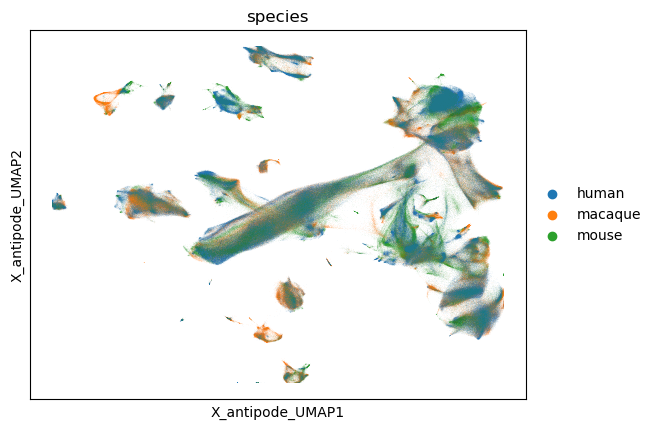

In [19]:
MDE_KEY = 'X_antipode_UMAP'
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['species']
)


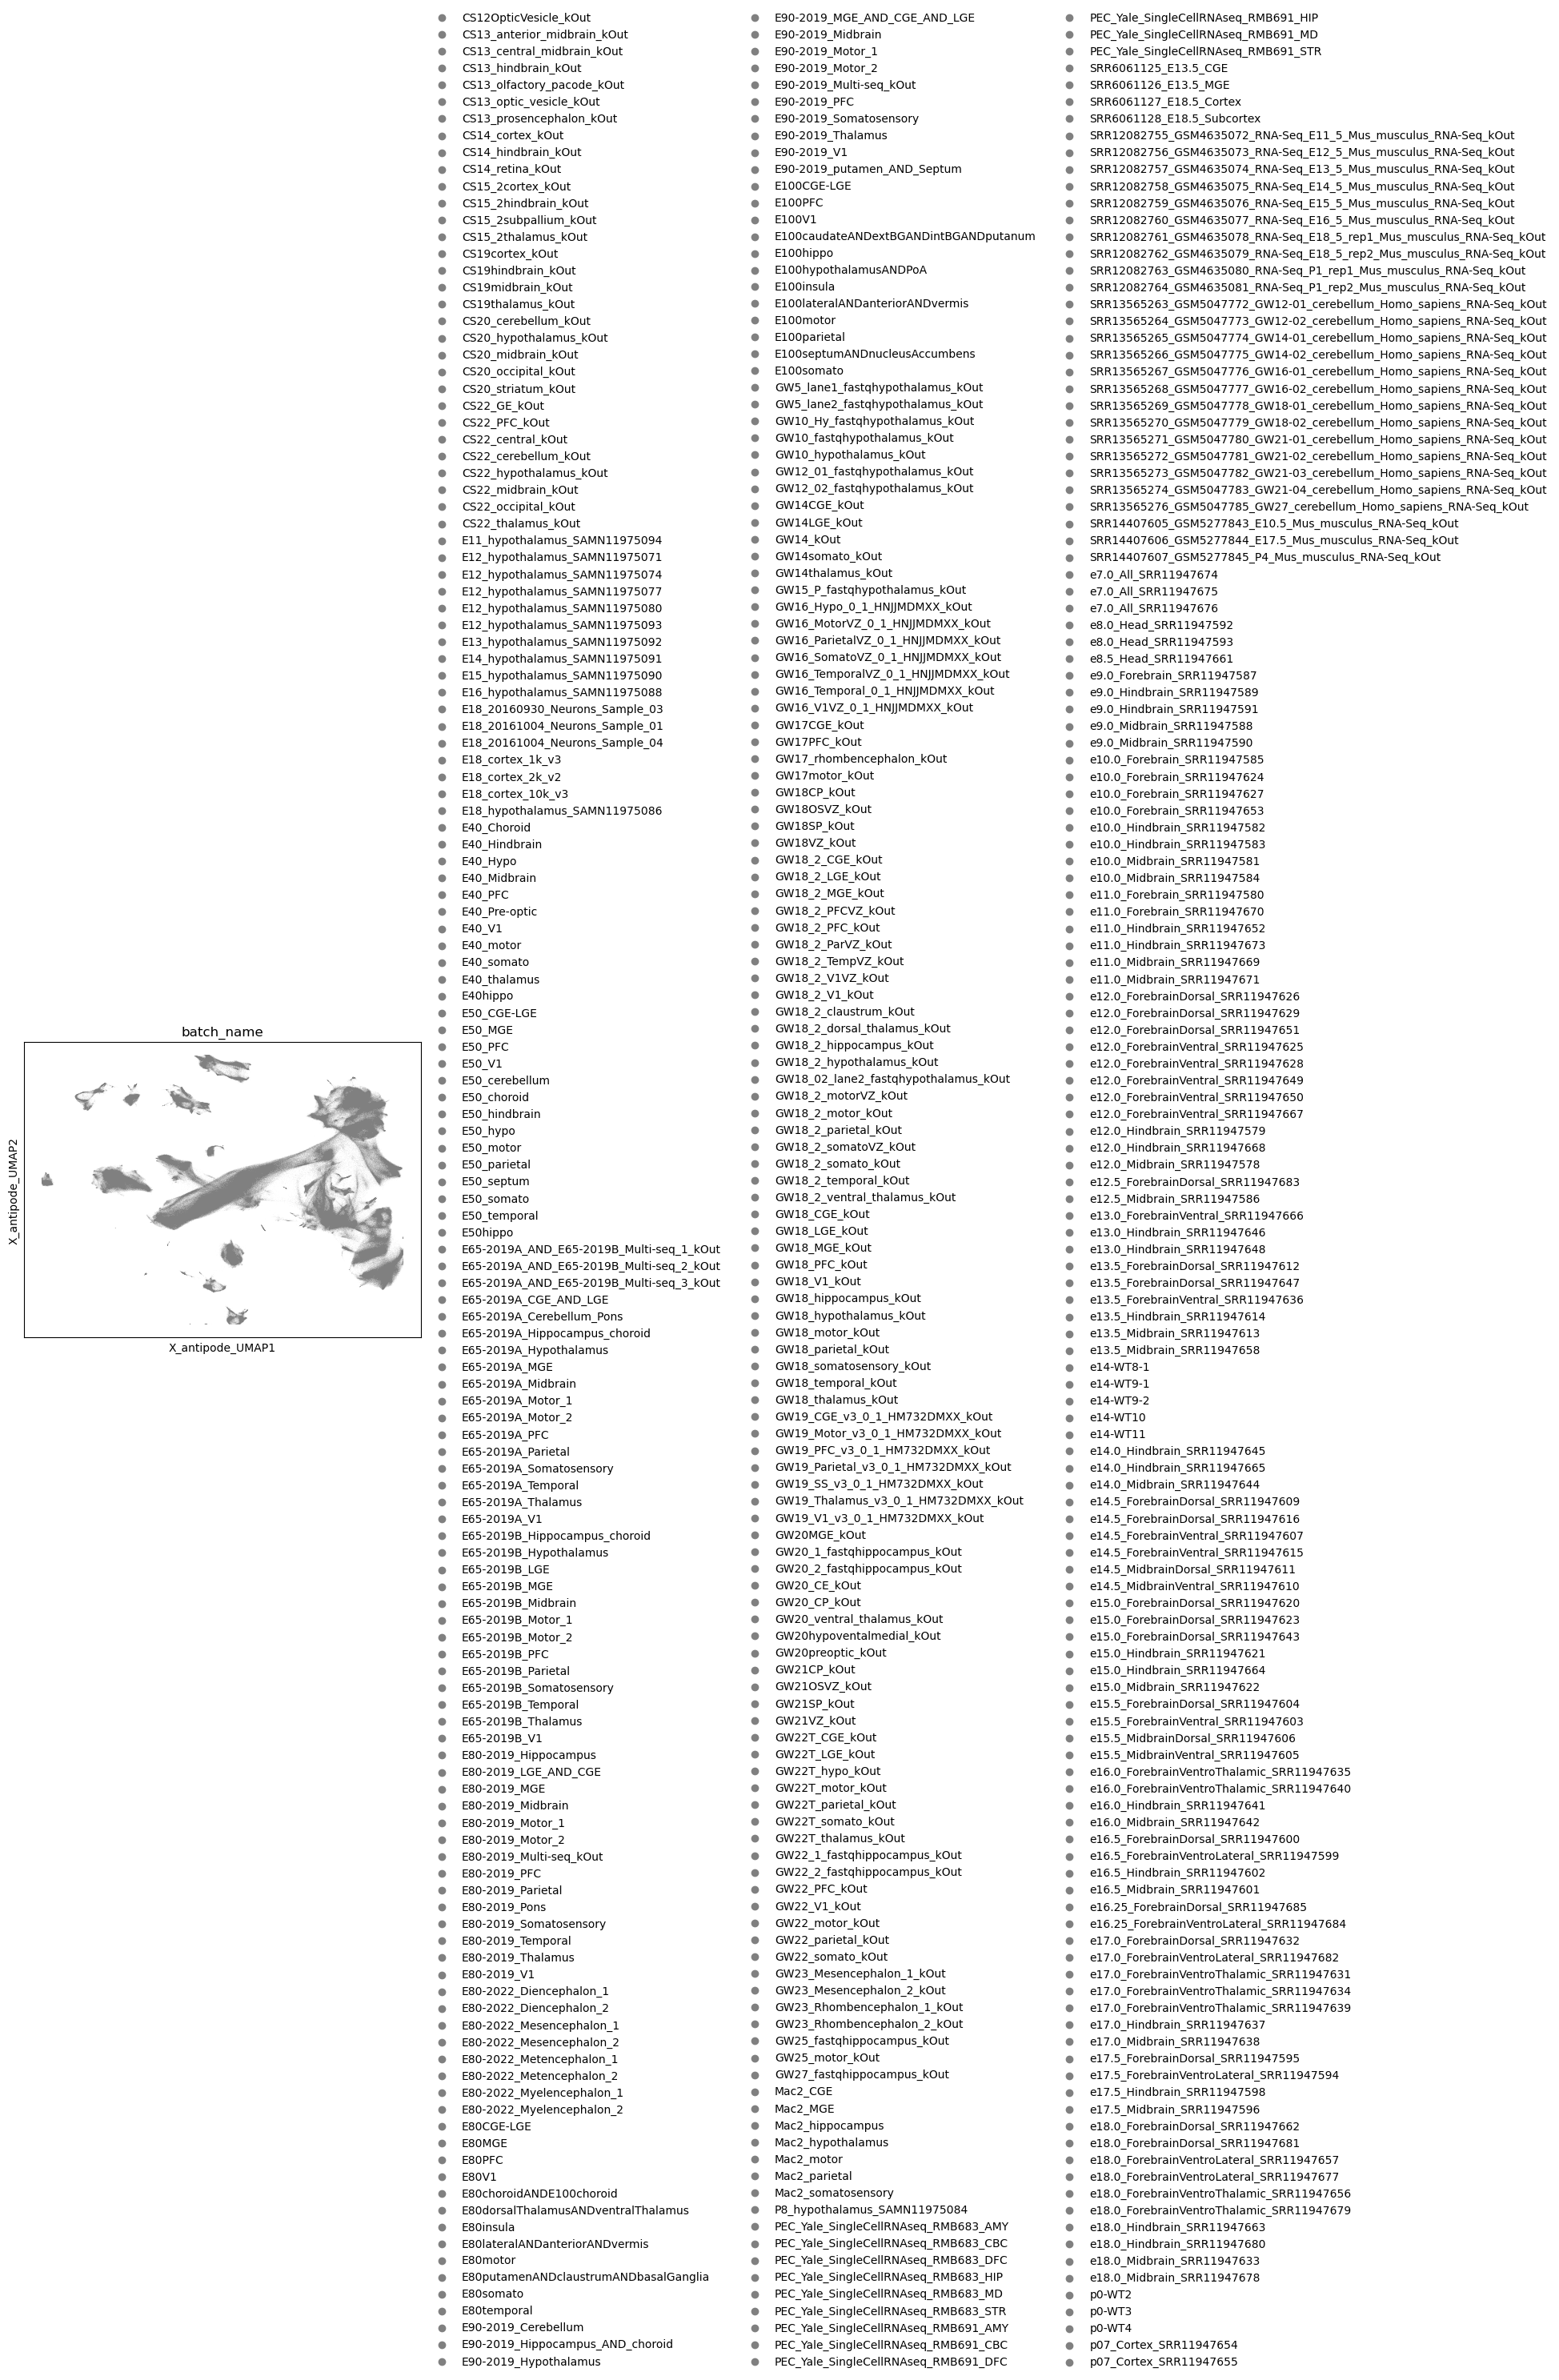

In [20]:
MDE_KEY = 'X_antipode_UMAP'
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['batch_name']
)


In [21]:
pstore=adata.uns['param_store']
# discov_cluster_params,cluster_params, cluster_labels,var_labels,zeros_mask,(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)=antipode_model.calculate_cluster_params(flavor='numpy')
# cluster_index = np.array([int(x) for x in cluster_labels])
# discov_cluster_params = discov_cluster_params[:,cluster_index,:]
# discov_labels=adata.obs[antipode_model.discov_key].cat.categories
# latent_labels=[str(x) for x in range(pstore['discov_dc'].shape[1])]
# n_clusters=antipode_model.level_sizes[-1]

discov_cluster_params,cluster_params, cluster_labels,var_labels, zero_mask,(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)=antipode_model.calculate_cluster_params(flavor='numpy')
cluster_index = np.array([int(x) for x in cluster_labels])
discov_cluster_params = discov_cluster_params[:,cluster_index,:] * zero_mask
prop_discov_di = prop_discov_di[:,cluster_index,:] * zero_mask
prop_discov_dm = prop_discov_dm[:,cluster_index,:] * zero_mask
discov_labels=adata.obs[antipode_model.discov_key].cat.categories
latent_labels=[str(x) for x in range(pstore['discov_dc'].shape[1])]
n_clusters=antipode_model.level_sizes[-1]
discov_cluster_params = antipode.model_functions.safe_log_transform(np.exp(discov_cluster_params) , aggr_sums[0].sum(-1)[np.newaxis,...,np.newaxis])

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:450: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zero_mask = (adata.obs.groupby(self.discov_key)[leaf_level].value_counts().unstack().loc[:,cluster_labels]>=cluster_count_threshold).to_numpy()
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:451: RuntimeWarning: divide by zero encountered in divide
  return discov_cluster_params,cluster_params, cluster_labels,var_labels, 1/zero_mask[...,np.newaxis],(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)


ValueError: operands could not be broadcast together with shapes (3,491,16738) (1,380,1) 

In [22]:
fits=[]
for i in range(discov_cluster_params.shape[0]):
    for g in range(discov_cluster_params.shape[2]):
        x=discov_cluster_params[i,:,g]
        y=log_real_means[i,:,g]
        fits.append(scipy.stats.spearmanr(x,y).statistic)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 491 and the array at index 1 has size 380

nan


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, '')

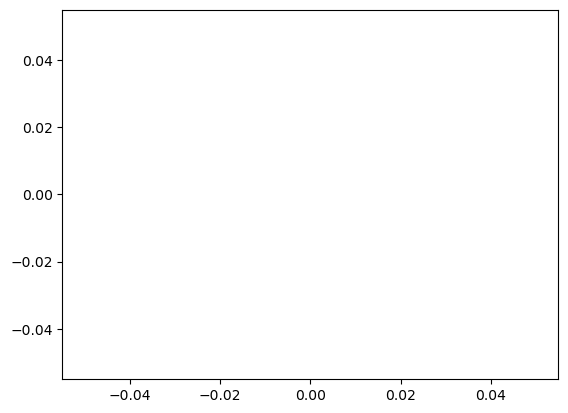

In [23]:
print(np.mean(np.nan_to_num(fits)))
seaborn.histplot(fits)
plt.title('')

Text(0, 0.5, 'actual gene log mean')

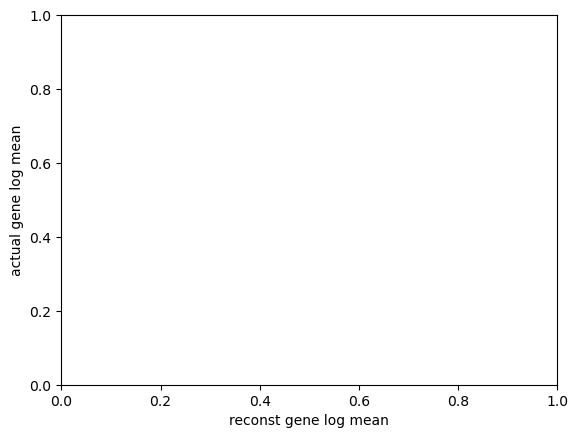

In [24]:
cmap = plt.cm.coolwarm

# Map 'fits' values to the colormap
colors = cmap(np.array(fits))
seaborn.scatterplot(x=discov_cluster_params.mean(1).flatten(),y=log_real_means.mean(1).flatten(),s=0.1,color=colors)
plt.xlabel('reconst gene log mean')
plt.ylabel('actual gene log mean')

In [25]:
# Calculate the regression parameters
x=discov_cluster_params.flatten()
y=log_real_means.flatten()
mask = ~np.isinf(x)
x=x[mask]
y=y[mask]

randinds=np.random.choice(np.array(list(range(x.shape[0]))),size=100000,replace=False)


seaborn.scatterplot(x=x[randinds],y=y[randinds],s=0.2,color='black')
seaborn.kdeplot(x=x[randinds],y=y[randinds],linestyles='--',color='red', linewidths=0.5)
plt.xlabel('reconstructed log mean cluster exp')
plt.ylabel('actual mean cluster exp (counts/1e6)')



slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# Plot the regression line
x_values = np.linspace(np.min(x), np.max(x), 100)
plt.plot(x_values, slope * x_values + intercept, color='blue', label=f'y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.2f}')
plt.title('Mean within species (species x clusters x genes')
# Add legend
plt.legend()

IndexError: boolean index did not match indexed array along axis 0; size of axis is 19081320 but size of corresponding boolean axis is 24655074

In [26]:
# antipode_model.save(os.path.join('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/models',model_tag),save_anndata=True,prefix='p4_recorrect_')

In [27]:
# antipode_model.adata_manager.adata.uns['param_store']['locs'] = antipode_model.adata_manager.adata.uns['param_store']['locs']+antipode_model.adata_manager.adata.uns['param_store']['discov_dm'].mean(0)
# antipode_model.adata_manager.adata.uns['param_store']['discov_dm'] = antipode_model.adata_manager.adata.uns['param_store']['discov_dm']-antipode_model.adata_manager.adata.uns['param_store']['discov_dm'].mean(0)

In [28]:
antipode_model=ANTIPODE.load(out_path,prefix='p1_',device=device,adata=adata) 
antipode_model.adata_manager.adata = adata
antipode_model.store_outputs()

INFO     Generating sequential column names                                                                        


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/pyro/params/param_store.py:334: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s

INFO     Generating sequential column names                                                                        


  0%|          | 0/57962 [00:00<?, ?it/s]

  0%|          | 28/57962 [00:00<03:28, 278.14it/s]

  0%|          | 56/57962 [00:00<03:27, 278.42it/s]

  0%|          | 87/57962 [00:00<03:17, 292.43it/s]

  0%|          | 120/57962 [00:00<03:10, 303.29it/s]

  0%|          | 153/57962 [00:00<03:05, 311.05it/s]

  0%|          | 191/57962 [00:00<02:54, 330.20it/s]

  0%|          | 224/57962 [00:00<02:58, 322.71it/s]

  0%|          | 258/57962 [00:00<02:55, 327.94it/s]

  1%|          | 293/57962 [00:00<02:53, 332.98it/s]

  1%|          | 330/57962 [00:01<02:47, 343.16it/s]

  1%|          | 367/57962 [00:01<02:45, 348.98it/s]

  1%|          | 402/57962 [00:01<02:46, 344.86it/s]

  1%|          | 439/57962 [00:01<02:43, 351.55it/s]

  1%|          | 475/57962 [00:01<02:43, 352.39it/s]

  1%|          | 511/57962 [00:01<02:42, 353.33it/s]

  1%|          | 549/57962 [00:01<02:39, 360.61it/s]

  1%|          | 589/57962 [00:01<02:34, 370.76it/s]

  1%|          | 630/57962 [00:01<02:29, 382.22it/s]

  1%|          | 673/57962 [00:01<02:24, 395.22it/s]

  1%|          | 713/57962 [00:02<02:30, 381.21it/s]

  1%|▏         | 752/57962 [00:02<02:30, 381.39it/s]

  1%|▏         | 793/57962 [00:02<02:27, 387.81it/s]

  1%|▏         | 835/57962 [00:02<02:23, 396.77it/s]

  2%|▏         | 878/57962 [00:02<02:21, 403.53it/s]

  2%|▏         | 919/57962 [00:02<02:29, 382.66it/s]

  2%|▏         | 958/57962 [00:02<03:00, 315.56it/s]

  2%|▏         | 993/57962 [00:02<02:56, 322.00it/s]

  2%|▏         | 1030/57962 [00:02<02:50, 334.47it/s]

  2%|▏         | 1069/57962 [00:03<02:42, 349.15it/s]

  2%|▏         | 1110/57962 [00:03<02:35, 364.94it/s]

  2%|▏         | 1152/57962 [00:03<02:29, 379.05it/s]

  2%|▏         | 1191/57962 [00:03<03:04, 307.71it/s]

  2%|▏         | 1225/57962 [00:03<03:19, 284.91it/s]

  2%|▏         | 1256/57962 [00:03<03:25, 275.60it/s]

  2%|▏         | 1285/57962 [00:03<03:28, 272.20it/s]

  2%|▏         | 1314/57962 [00:03<03:27, 273.49it/s]

  2%|▏         | 1344/57962 [00:04<03:23, 278.51it/s]

  2%|▏         | 1376/57962 [00:04<03:16, 287.96it/s]

  2%|▏         | 1411/57962 [00:04<03:06, 303.45it/s]

  2%|▏         | 1443/57962 [00:04<03:03, 307.40it/s]

  3%|▎         | 1475/57962 [00:04<03:07, 300.69it/s]

  3%|▎         | 1506/57962 [00:04<03:06, 303.09it/s]

  3%|▎         | 1539/57962 [00:04<03:02, 309.41it/s]

  3%|▎         | 1573/57962 [00:04<02:57, 316.89it/s]

  3%|▎         | 1608/57962 [00:04<02:53, 325.55it/s]

  3%|▎         | 1645/57962 [00:04<02:47, 336.94it/s]

  3%|▎         | 1681/57962 [00:05<02:44, 342.40it/s]

  3%|▎         | 1719/57962 [00:05<02:39, 352.01it/s]

  3%|▎         | 1759/57962 [00:05<02:33, 365.33it/s]

  3%|▎         | 1801/57962 [00:05<02:28, 378.91it/s]

  3%|▎         | 1844/57962 [00:05<02:23, 392.11it/s]

  3%|▎         | 1884/57962 [00:05<02:32, 366.96it/s]

  3%|▎         | 1922/57962 [00:05<02:46, 335.62it/s]

  3%|▎         | 1957/57962 [00:05<02:59, 311.68it/s]

  3%|▎         | 1989/57962 [00:05<03:08, 296.92it/s]

  3%|▎         | 2021/57962 [00:06<03:05, 301.93it/s]

  4%|▎         | 2055/57962 [00:06<02:59, 311.15it/s]

  4%|▎         | 2087/57962 [00:06<03:00, 309.59it/s]

  4%|▎         | 2119/57962 [00:06<03:07, 298.03it/s]

  4%|▎         | 2150/57962 [00:06<03:07, 297.08it/s]

  4%|▍         | 2182/57962 [00:06<03:04, 301.99it/s]

  4%|▍         | 2215/57962 [00:06<03:00, 309.12it/s]

  4%|▍         | 2249/57962 [00:06<02:55, 316.94it/s]

  4%|▍         | 2285/57962 [00:06<02:49, 328.36it/s]

  4%|▍         | 2318/57962 [00:07<03:07, 296.90it/s]

  4%|▍         | 2349/57962 [00:07<03:09, 293.14it/s]

  4%|▍         | 2379/57962 [00:07<03:13, 287.83it/s]

  4%|▍         | 2411/57962 [00:07<03:08, 295.04it/s]

  4%|▍         | 2441/57962 [00:07<03:10, 291.60it/s]

  4%|▍         | 2471/57962 [00:07<03:21, 275.73it/s]

  4%|▍         | 2499/57962 [00:07<03:23, 272.07it/s]

  4%|▍         | 2530/57962 [00:07<03:17, 281.21it/s]

  4%|▍         | 2559/57962 [00:07<03:21, 274.50it/s]

  4%|▍         | 2587/57962 [00:08<03:22, 273.55it/s]

  5%|▍         | 2620/57962 [00:08<03:12, 287.61it/s]

  5%|▍         | 2659/57962 [00:08<02:54, 316.60it/s]

  5%|▍         | 2691/57962 [00:08<03:08, 293.58it/s]

  5%|▍         | 2721/57962 [00:08<03:11, 288.75it/s]

  5%|▍         | 2751/57962 [00:08<03:13, 285.01it/s]

  5%|▍         | 2780/57962 [00:08<03:19, 276.23it/s]

  5%|▍         | 2810/57962 [00:08<03:16, 280.54it/s]

  5%|▍         | 2839/57962 [00:08<03:20, 275.60it/s]

  5%|▍         | 2867/57962 [00:09<03:28, 264.51it/s]

  5%|▍         | 2894/57962 [00:09<03:31, 260.19it/s]

  5%|▌         | 2921/57962 [00:09<03:43, 246.78it/s]

  5%|▌         | 2948/57962 [00:09<03:39, 250.95it/s]

  5%|▌         | 2980/57962 [00:09<03:24, 268.84it/s]

  5%|▌         | 3009/57962 [00:09<03:20, 273.63it/s]

  5%|▌         | 3037/57962 [00:09<03:25, 267.81it/s]

  5%|▌         | 3066/57962 [00:09<03:20, 273.43it/s]

  5%|▌         | 3097/57962 [00:09<03:13, 283.46it/s]

  5%|▌         | 3126/57962 [00:09<03:20, 274.04it/s]

  5%|▌         | 3154/57962 [00:10<03:20, 273.15it/s]

  5%|▌         | 3184/57962 [00:10<03:16, 278.67it/s]

  6%|▌         | 3215/57962 [00:10<03:11, 285.88it/s]

  6%|▌         | 3250/57962 [00:10<03:00, 303.21it/s]

  6%|▌         | 3281/57962 [00:10<03:11, 285.49it/s]

  6%|▌         | 3310/57962 [00:10<03:14, 280.83it/s]

  6%|▌         | 3339/57962 [00:10<03:13, 281.94it/s]

  6%|▌         | 3368/57962 [00:10<03:18, 274.72it/s]

  6%|▌         | 3398/57962 [00:10<03:15, 279.73it/s]

  6%|▌         | 3427/57962 [00:11<03:17, 275.86it/s]

  6%|▌         | 3455/57962 [00:11<03:20, 271.44it/s]

  6%|▌         | 3484/57962 [00:11<03:17, 276.05it/s]

  6%|▌         | 3513/57962 [00:11<03:14, 279.48it/s]

  6%|▌         | 3541/57962 [00:11<03:18, 274.54it/s]

  6%|▌         | 3571/57962 [00:11<03:14, 279.67it/s]

  6%|▌         | 3603/57962 [00:11<03:07, 289.46it/s]

  6%|▋         | 3632/57962 [00:11<03:13, 280.20it/s]

  6%|▋         | 3661/57962 [00:11<03:13, 281.25it/s]

  6%|▋         | 3693/57962 [00:11<03:06, 290.44it/s]

  6%|▋         | 3723/57962 [00:12<03:09, 286.28it/s]

  6%|▋         | 3755/57962 [00:12<03:04, 293.89it/s]

  7%|▋         | 3786/57962 [00:12<03:02, 297.42it/s]

  7%|▋         | 3816/57962 [00:12<03:02, 296.27it/s]

  7%|▋         | 3846/57962 [00:12<03:12, 281.48it/s]

  7%|▋         | 3877/57962 [00:12<03:07, 288.79it/s]

  7%|▋         | 3912/57962 [00:12<02:57, 305.27it/s]

  7%|▋         | 3944/57962 [00:12<02:55, 307.73it/s]

  7%|▋         | 3979/57962 [00:12<02:49, 318.09it/s]

  7%|▋         | 4011/57962 [00:13<02:51, 314.45it/s]

  7%|▋         | 4043/57962 [00:13<02:54, 308.32it/s]

  7%|▋         | 4075/57962 [00:13<02:53, 311.42it/s]

  7%|▋         | 4107/57962 [00:13<02:57, 303.39it/s]

  7%|▋         | 4138/57962 [00:13<02:59, 299.81it/s]

  7%|▋         | 4170/57962 [00:13<02:56, 304.96it/s]

  7%|▋         | 4201/57962 [00:13<03:02, 294.52it/s]

  7%|▋         | 4231/57962 [00:13<03:04, 290.68it/s]

  7%|▋         | 4263/57962 [00:13<03:00, 297.13it/s]

  7%|▋         | 4293/57962 [00:13<03:00, 296.67it/s]

  7%|▋         | 4325/57962 [00:14<02:56, 303.42it/s]

  8%|▊         | 4356/57962 [00:14<02:57, 301.29it/s]

  8%|▊         | 4390/57962 [00:14<02:52, 310.30it/s]

  8%|▊         | 4428/57962 [00:14<02:43, 326.79it/s]

  8%|▊         | 4461/57962 [00:14<02:49, 316.54it/s]

  8%|▊         | 4495/57962 [00:14<02:46, 321.50it/s]

  8%|▊         | 4528/57962 [00:14<02:49, 316.11it/s]

  8%|▊         | 4560/57962 [00:14<02:51, 311.79it/s]

  8%|▊         | 4594/57962 [00:14<02:48, 317.34it/s]

  8%|▊         | 4632/57962 [00:15<02:40, 333.13it/s]

  8%|▊         | 4666/57962 [00:15<02:45, 322.15it/s]

  8%|▊         | 4700/57962 [00:15<02:43, 326.57it/s]

  8%|▊         | 4733/57962 [00:15<02:44, 323.33it/s]

  8%|▊         | 4766/57962 [00:15<02:48, 316.05it/s]

  8%|▊         | 4798/57962 [00:15<02:48, 315.89it/s]

  8%|▊         | 4832/57962 [00:15<02:44, 322.78it/s]

  8%|▊         | 4866/57962 [00:15<02:42, 326.61it/s]

  8%|▊         | 4902/57962 [00:15<02:37, 336.33it/s]

  9%|▊         | 4936/57962 [00:15<02:49, 313.45it/s]

  9%|▊         | 4968/57962 [00:16<02:58, 297.60it/s]

  9%|▊         | 5001/57962 [00:16<02:53, 306.09it/s]

  9%|▊         | 5034/57962 [00:16<02:49, 312.45it/s]

  9%|▊         | 5066/57962 [00:16<02:52, 306.01it/s]

  9%|▉         | 5100/57962 [00:16<02:47, 314.75it/s]

  9%|▉         | 5136/57962 [00:16<02:41, 326.43it/s]

  9%|▉         | 5175/57962 [00:16<02:33, 344.33it/s]

  9%|▉         | 5210/57962 [00:16<02:35, 339.57it/s]

  9%|▉         | 5245/57962 [00:16<02:34, 341.33it/s]

  9%|▉         | 5284/57962 [00:17<02:29, 353.04it/s]

  9%|▉         | 5320/57962 [00:17<02:35, 339.34it/s]

  9%|▉         | 5358/57962 [00:17<02:30, 349.59it/s]

  9%|▉         | 5394/57962 [00:17<02:33, 342.56it/s]

  9%|▉         | 5429/57962 [00:17<02:39, 328.84it/s]

  9%|▉         | 5463/57962 [00:17<02:40, 327.45it/s]

  9%|▉         | 5496/57962 [00:17<02:40, 326.72it/s]

 10%|▉         | 5530/57962 [00:17<02:39, 328.46it/s]

 10%|▉         | 5567/57962 [00:17<02:33, 340.41it/s]

 10%|▉         | 5602/57962 [00:17<02:43, 320.34it/s]

 10%|▉         | 5635/57962 [00:18<02:43, 320.69it/s]

 10%|▉         | 5668/57962 [00:18<02:42, 322.01it/s]

 10%|▉         | 5701/57962 [00:18<02:42, 321.40it/s]

 10%|▉         | 5737/57962 [00:18<02:37, 330.78it/s]

 10%|▉         | 5771/57962 [00:18<02:37, 331.82it/s]

 10%|█         | 5805/57962 [00:18<02:37, 332.07it/s]

 10%|█         | 5843/57962 [00:18<02:31, 344.14it/s]

 10%|█         | 5878/57962 [00:18<02:40, 324.41it/s]

 10%|█         | 5911/57962 [00:18<02:44, 315.60it/s]

 10%|█         | 5943/57962 [00:19<02:45, 315.10it/s]

 10%|█         | 5979/57962 [00:19<02:39, 325.96it/s]

 10%|█         | 6012/57962 [00:19<02:57, 292.07it/s]

 10%|█         | 6042/57962 [00:19<03:01, 286.05it/s]

 10%|█         | 6076/57962 [00:19<02:53, 299.68it/s]

 11%|█         | 6107/57962 [00:19<02:53, 298.80it/s]

 11%|█         | 6139/57962 [00:19<02:50, 304.12it/s]

 11%|█         | 6173/57962 [00:19<02:45, 312.24it/s]

 11%|█         | 6205/57962 [00:19<02:50, 303.98it/s]

 11%|█         | 6239/57962 [00:20<02:44, 313.83it/s]

 11%|█         | 6271/57962 [00:20<02:48, 307.51it/s]

 11%|█         | 6304/57962 [00:20<02:45, 312.41it/s]

 11%|█         | 6339/57962 [00:20<02:41, 320.15it/s]

 11%|█         | 6372/57962 [00:20<02:45, 311.17it/s]

 11%|█         | 6406/57962 [00:20<02:41, 319.08it/s]

 11%|█         | 6439/57962 [00:20<02:47, 307.10it/s]

 11%|█         | 6472/57962 [00:20<02:45, 310.98it/s]

 11%|█         | 6506/57962 [00:20<02:41, 317.78it/s]

 11%|█▏        | 6538/57962 [00:20<02:43, 315.03it/s]

 11%|█▏        | 6574/57962 [00:21<02:37, 326.67it/s]

 11%|█▏        | 6607/57962 [00:21<02:43, 314.66it/s]

 11%|█▏        | 6640/57962 [00:21<02:41, 318.10it/s]

 12%|█▏        | 6673/57962 [00:21<02:40, 320.33it/s]

 12%|█▏        | 6708/57962 [00:21<02:37, 325.58it/s]

 12%|█▏        | 6741/57962 [00:21<02:38, 322.99it/s]

 12%|█▏        | 6774/57962 [00:21<02:38, 322.61it/s]

 12%|█▏        | 6807/57962 [00:21<02:38, 322.16it/s]

 12%|█▏        | 6842/57962 [00:21<02:34, 329.90it/s]

 12%|█▏        | 6876/57962 [00:22<02:36, 326.13it/s]

 12%|█▏        | 6910/57962 [00:22<02:35, 327.48it/s]

 12%|█▏        | 6945/57962 [00:22<02:33, 332.60it/s]

 12%|█▏        | 6979/57962 [00:22<02:35, 328.48it/s]

 12%|█▏        | 7016/57962 [00:22<02:30, 338.70it/s]

 12%|█▏        | 7050/57962 [00:22<02:37, 323.73it/s]

 12%|█▏        | 7083/57962 [00:22<02:44, 308.60it/s]

 12%|█▏        | 7117/57962 [00:22<02:40, 316.48it/s]

 12%|█▏        | 7151/57962 [00:22<02:38, 320.36it/s]

 12%|█▏        | 7185/57962 [00:22<02:37, 323.00it/s]

 12%|█▏        | 7219/57962 [00:23<02:35, 326.00it/s]

 13%|█▎        | 7252/57962 [00:23<02:46, 304.30it/s]

 13%|█▎        | 7283/57962 [00:23<02:51, 294.66it/s]

 13%|█▎        | 7313/57962 [00:23<02:55, 289.08it/s]

 13%|█▎        | 7343/57962 [00:23<02:53, 292.09it/s]

 13%|█▎        | 7378/57962 [00:23<02:44, 307.35it/s]

 13%|█▎        | 7409/57962 [00:23<02:46, 303.59it/s]

 13%|█▎        | 7441/57962 [00:23<02:44, 306.96it/s]

 13%|█▎        | 7474/57962 [00:23<02:42, 311.58it/s]

 13%|█▎        | 7506/57962 [00:24<02:41, 312.72it/s]

 13%|█▎        | 7542/57962 [00:24<02:35, 324.47it/s]

 13%|█▎        | 7575/57962 [00:24<02:37, 319.27it/s]

 13%|█▎        | 7607/57962 [00:24<02:37, 319.28it/s]

 13%|█▎        | 7644/57962 [00:24<02:31, 332.35it/s]

 13%|█▎        | 7678/57962 [00:24<02:36, 320.98it/s]

 13%|█▎        | 7712/57962 [00:24<02:34, 325.87it/s]

 13%|█▎        | 7747/57962 [00:24<02:31, 330.41it/s]

 13%|█▎        | 7781/57962 [00:24<02:36, 321.66it/s]

 13%|█▎        | 7818/57962 [00:24<02:30, 333.43it/s]

 14%|█▎        | 7852/57962 [00:25<02:31, 330.96it/s]

 14%|█▎        | 7889/57962 [00:25<02:27, 339.64it/s]

 14%|█▎        | 7924/57962 [00:25<02:31, 330.30it/s]

 14%|█▎        | 7960/57962 [00:25<02:28, 337.80it/s]

 14%|█▍        | 7994/57962 [00:25<02:30, 331.73it/s]

 14%|█▍        | 8031/57962 [00:25<02:26, 340.76it/s]

 14%|█▍        | 8066/57962 [00:25<02:28, 336.34it/s]

 14%|█▍        | 8100/57962 [00:25<02:38, 315.54it/s]

 14%|█▍        | 8135/57962 [00:25<02:34, 323.00it/s]

 14%|█▍        | 8168/57962 [00:26<02:36, 317.73it/s]

 14%|█▍        | 8203/57962 [00:26<02:32, 325.65it/s]

 14%|█▍        | 8241/57962 [00:26<02:26, 340.17it/s]

 14%|█▍        | 8277/57962 [00:26<02:24, 343.10it/s]

 14%|█▍        | 8313/57962 [00:26<02:22, 347.95it/s]

 14%|█▍        | 8348/57962 [00:26<02:26, 338.38it/s]

 14%|█▍        | 8382/57962 [00:26<02:27, 336.38it/s]

 15%|█▍        | 8416/57962 [00:26<02:27, 335.60it/s]

 15%|█▍        | 8450/57962 [00:26<02:28, 333.36it/s]

 15%|█▍        | 8489/57962 [00:26<02:22, 347.94it/s]

 15%|█▍        | 8524/57962 [00:27<02:28, 332.61it/s]

 15%|█▍        | 8559/57962 [00:27<02:26, 337.41it/s]

 15%|█▍        | 8593/57962 [00:27<02:28, 331.46it/s]

 15%|█▍        | 8627/57962 [00:27<02:28, 333.15it/s]

 15%|█▍        | 8664/57962 [00:27<02:23, 343.36it/s]

 15%|█▌        | 8699/57962 [00:27<02:26, 335.60it/s]

 15%|█▌        | 8737/57962 [00:27<02:21, 348.22it/s]

 15%|█▌        | 8772/57962 [00:27<02:25, 337.92it/s]

 15%|█▌        | 8810/57962 [00:27<02:20, 349.43it/s]

 15%|█▌        | 8846/57962 [00:28<02:26, 334.47it/s]

 15%|█▌        | 8881/57962 [00:28<02:24, 338.59it/s]

 15%|█▌        | 8916/57962 [00:28<02:26, 335.90it/s]

 15%|█▌        | 8952/57962 [00:28<02:23, 342.24it/s]

 16%|█▌        | 8987/57962 [00:28<02:24, 338.26it/s]

 16%|█▌        | 9021/57962 [00:28<02:39, 306.34it/s]

 16%|█▌        | 9053/57962 [00:28<02:39, 305.98it/s]

 16%|█▌        | 9085/57962 [00:28<02:38, 307.55it/s]

 16%|█▌        | 9123/57962 [00:28<02:29, 326.59it/s]

 16%|█▌        | 9156/57962 [00:29<02:30, 324.09it/s]

 16%|█▌        | 9189/57962 [00:29<02:36, 311.69it/s]

 16%|█▌        | 9221/57962 [00:29<02:44, 295.65it/s]

 16%|█▌        | 9256/57962 [00:29<02:37, 308.68it/s]

 16%|█▌        | 9290/57962 [00:29<02:33, 316.77it/s]

 16%|█▌        | 9324/57962 [00:29<02:31, 322.03it/s]

 16%|█▌        | 9364/57962 [00:29<02:22, 340.37it/s]

 16%|█▌        | 9399/57962 [00:29<02:36, 310.11it/s]

 16%|█▋        | 9431/57962 [00:29<02:37, 308.28it/s]

 16%|█▋        | 9463/57962 [00:29<02:37, 307.75it/s]

 16%|█▋        | 9495/57962 [00:30<02:37, 306.92it/s]

 16%|█▋        | 9526/57962 [00:30<02:50, 283.75it/s]

 16%|█▋        | 9555/57962 [00:30<02:50, 283.84it/s]

 17%|█▋        | 9584/57962 [00:30<03:03, 263.98it/s]

 17%|█▋        | 9612/57962 [00:30<03:02, 264.55it/s]

 17%|█▋        | 9639/57962 [00:30<03:12, 251.59it/s]

 17%|█▋        | 9665/57962 [00:30<03:13, 249.31it/s]

 17%|█▋        | 9693/57962 [00:30<03:07, 257.64it/s]

 17%|█▋        | 9725/57962 [00:30<02:55, 274.49it/s]

 17%|█▋        | 9762/57962 [00:31<02:39, 301.29it/s]

 17%|█▋        | 9793/57962 [00:31<02:44, 292.75it/s]

 17%|█▋        | 9827/57962 [00:31<02:37, 304.95it/s]

 17%|█▋        | 9862/57962 [00:31<02:32, 314.64it/s]

 17%|█▋        | 9894/57962 [00:31<02:46, 289.44it/s]

 17%|█▋        | 9924/57962 [00:31<02:57, 271.16it/s]

 17%|█▋        | 9953/57962 [00:31<02:55, 273.75it/s]

 17%|█▋        | 9986/57962 [00:31<02:45, 289.11it/s]

 17%|█▋        | 10023/57962 [00:31<02:34, 310.04it/s]

 17%|█▋        | 10055/57962 [00:32<02:38, 302.52it/s]

 17%|█▋        | 10089/57962 [00:32<02:33, 312.52it/s]

 17%|█▋        | 10123/57962 [00:32<02:29, 320.00it/s]

 18%|█▊        | 10156/57962 [00:32<02:41, 295.65it/s]

 18%|█▊        | 10190/57962 [00:32<02:36, 306.21it/s]

 18%|█▊        | 10228/57962 [00:32<02:26, 325.96it/s]

 18%|█▊        | 10262/57962 [00:32<02:26, 325.52it/s]

 18%|█▊        | 10300/57962 [00:32<02:20, 339.39it/s]

 18%|█▊        | 10336/57962 [00:32<02:19, 342.34it/s]

 18%|█▊        | 10371/57962 [00:33<02:24, 330.31it/s]

 18%|█▊        | 10406/57962 [00:33<02:22, 333.98it/s]

 18%|█▊        | 10445/57962 [00:33<02:16, 348.32it/s]

 18%|█▊        | 10480/57962 [00:33<02:25, 327.09it/s]

 18%|█▊        | 10514/57962 [00:33<02:24, 327.26it/s]

 18%|█▊        | 10548/57962 [00:33<02:23, 329.43it/s]

 18%|█▊        | 10583/57962 [00:33<02:21, 334.46it/s]

 18%|█▊        | 10619/57962 [00:33<02:18, 341.68it/s]

 18%|█▊        | 10654/57962 [00:33<02:20, 336.16it/s]

 18%|█▊        | 10688/57962 [00:34<02:25, 323.98it/s]

 18%|█▊        | 10721/57962 [00:34<02:25, 325.10it/s]

 19%|█▊        | 10757/57962 [00:34<02:21, 332.76it/s]

 19%|█▊        | 10795/57962 [00:34<02:16, 345.68it/s]

 19%|█▊        | 10837/57962 [00:34<02:08, 365.74it/s]

 19%|█▉        | 10874/57962 [00:34<02:15, 347.65it/s]

 19%|█▉        | 10910/57962 [00:34<02:17, 341.29it/s]

 19%|█▉        | 10945/57962 [00:34<02:17, 341.10it/s]

 19%|█▉        | 10981/57962 [00:34<02:16, 343.80it/s]

 19%|█▉        | 11018/57962 [00:34<02:14, 348.70it/s]

 19%|█▉        | 11056/57962 [00:35<02:11, 356.61it/s]

 19%|█▉        | 11092/57962 [00:35<02:11, 355.78it/s]

 19%|█▉        | 11128/57962 [00:35<02:19, 336.29it/s]

 19%|█▉        | 11163/57962 [00:35<02:18, 337.45it/s]

 19%|█▉        | 11199/57962 [00:35<02:16, 341.70it/s]

 19%|█▉        | 11234/57962 [00:35<02:22, 328.23it/s]

 19%|█▉        | 11268/57962 [00:35<02:22, 327.11it/s]

 20%|█▉        | 11305/57962 [00:35<02:17, 339.24it/s]

 20%|█▉        | 11343/57962 [00:35<02:12, 350.56it/s]

 20%|█▉        | 11382/57962 [00:36<02:09, 360.43it/s]

 20%|█▉        | 11423/57962 [00:36<02:04, 373.62it/s]

 20%|█▉        | 11463/57962 [00:36<02:02, 379.39it/s]

 20%|█▉        | 11505/57962 [00:36<01:59, 388.99it/s]

 20%|█▉        | 11544/57962 [00:36<02:01, 382.66it/s]

 20%|█▉        | 11583/57962 [00:36<02:07, 362.68it/s]

 20%|██        | 11620/57962 [00:36<02:08, 359.39it/s]

 20%|██        | 11657/57962 [00:36<02:07, 362.25it/s]

 20%|██        | 11697/57962 [00:36<02:04, 370.57it/s]

 20%|██        | 11737/57962 [00:36<02:02, 377.51it/s]

 20%|██        | 11779/57962 [00:37<01:58, 388.72it/s]

 20%|██        | 11818/57962 [00:37<02:00, 384.43it/s]

 20%|██        | 11859/57962 [00:37<01:57, 391.48it/s]

 21%|██        | 11902/57962 [00:37<01:54, 402.22it/s]

 21%|██        | 11943/57962 [00:37<01:55, 399.48it/s]

 21%|██        | 11986/57962 [00:37<01:53, 405.32it/s]

 21%|██        | 12027/57962 [00:37<02:00, 382.36it/s]

 21%|██        | 12066/57962 [00:37<02:04, 369.11it/s]

 21%|██        | 12104/57962 [00:37<02:04, 368.49it/s]

 21%|██        | 12143/57962 [00:38<02:03, 372.07it/s]

 21%|██        | 12182/57962 [00:38<02:01, 376.95it/s]

 21%|██        | 12223/57962 [00:38<01:59, 384.00it/s]

 21%|██        | 12264/57962 [00:38<01:57, 390.03it/s]

 21%|██        | 12306/57962 [00:38<01:55, 396.93it/s]

 21%|██▏       | 12348/57962 [00:38<01:53, 402.81it/s]

 21%|██▏       | 12391/57962 [00:38<01:51, 408.68it/s]

 21%|██▏       | 12432/57962 [00:38<01:53, 400.00it/s]

 22%|██▏       | 12473/57962 [00:38<02:07, 357.88it/s]

 22%|██▏       | 12510/57962 [00:38<02:12, 343.26it/s]

 22%|██▏       | 12548/57962 [00:39<02:09, 351.21it/s]

 22%|██▏       | 12587/57962 [00:39<02:05, 360.27it/s]

 22%|██▏       | 12627/57962 [00:39<02:02, 370.67it/s]

 22%|██▏       | 12668/57962 [00:39<01:59, 380.25it/s]

 22%|██▏       | 12709/57962 [00:39<01:56, 387.67it/s]

 22%|██▏       | 12751/57962 [00:39<01:53, 396.83it/s]

 22%|██▏       | 12794/57962 [00:39<01:51, 406.06it/s]

 22%|██▏       | 12835/57962 [00:39<01:52, 400.54it/s]

 22%|██▏       | 12876/57962 [00:39<01:54, 394.80it/s]

 22%|██▏       | 12916/57962 [00:40<01:54, 394.67it/s]

 22%|██▏       | 12958/57962 [00:40<01:52, 401.38it/s]

 22%|██▏       | 12999/57962 [00:40<01:51, 402.36it/s]

 22%|██▏       | 13040/57962 [00:40<01:59, 376.70it/s]

 23%|██▎       | 13079/57962 [00:40<02:01, 368.82it/s]

 23%|██▎       | 13117/57962 [00:40<02:01, 367.75it/s]

 23%|██▎       | 13156/57962 [00:40<02:00, 371.77it/s]

 23%|██▎       | 13195/57962 [00:40<01:58, 376.88it/s]

 23%|██▎       | 13236/57962 [00:40<01:56, 384.28it/s]

 23%|██▎       | 13278/57962 [00:40<01:53, 392.14it/s]

 23%|██▎       | 13320/57962 [00:41<01:51, 399.21it/s]

 23%|██▎       | 13362/57962 [00:41<01:50, 403.97it/s]

 23%|██▎       | 13405/57962 [00:41<01:49, 406.72it/s]

 23%|██▎       | 13446/57962 [00:41<02:00, 368.47it/s]

 23%|██▎       | 13484/57962 [00:41<02:04, 358.19it/s]

 23%|██▎       | 13521/57962 [00:41<02:05, 353.72it/s]

 23%|██▎       | 13557/57962 [00:41<02:05, 353.02it/s]

 23%|██▎       | 13593/57962 [00:41<02:05, 354.52it/s]

 24%|██▎       | 13630/57962 [00:41<02:03, 357.70it/s]

 24%|██▎       | 13668/57962 [00:42<02:02, 362.30it/s]

 24%|██▎       | 13705/57962 [00:42<02:07, 347.64it/s]

 24%|██▎       | 13740/57962 [00:42<02:07, 348.11it/s]

 24%|██▍       | 13775/57962 [00:42<02:13, 331.45it/s]

 24%|██▍       | 13811/57962 [00:42<02:11, 335.37it/s]

 24%|██▍       | 13845/57962 [00:42<02:12, 332.74it/s]

 24%|██▍       | 13882/57962 [00:42<02:09, 341.47it/s]

 24%|██▍       | 13921/57962 [00:42<02:04, 353.77it/s]

 24%|██▍       | 13962/57962 [00:42<01:59, 368.70it/s]

 24%|██▍       | 14004/57962 [00:42<01:55, 382.12it/s]

 24%|██▍       | 14047/57962 [00:43<01:51, 394.61it/s]

 24%|██▍       | 14087/57962 [00:43<01:58, 368.73it/s]

 24%|██▍       | 14125/57962 [00:43<02:09, 339.16it/s]

 24%|██▍       | 14160/57962 [00:43<02:18, 315.23it/s]

 24%|██▍       | 14193/57962 [00:43<02:29, 292.56it/s]

 25%|██▍       | 14224/57962 [00:43<02:27, 295.64it/s]

 25%|██▍       | 14255/57962 [00:43<02:28, 294.08it/s]

 25%|██▍       | 14287/57962 [00:43<02:26, 298.85it/s]

 25%|██▍       | 14322/57962 [00:44<02:19, 312.36it/s]

 25%|██▍       | 14361/57962 [00:44<02:11, 332.19it/s]

 25%|██▍       | 14397/57962 [00:44<02:08, 338.35it/s]

 25%|██▍       | 14432/57962 [00:44<02:12, 327.82it/s]

 25%|██▍       | 14468/57962 [00:44<02:09, 335.72it/s]

 25%|██▌       | 14502/57962 [00:44<02:12, 327.78it/s]

 25%|██▌       | 14535/57962 [00:44<02:13, 325.92it/s]

 25%|██▌       | 14570/57962 [00:44<02:11, 330.71it/s]

 25%|██▌       | 14606/57962 [00:44<02:07, 338.81it/s]

 25%|██▌       | 14645/57962 [00:44<02:03, 352.06it/s]

 25%|██▌       | 14681/57962 [00:45<02:07, 340.35it/s]

 25%|██▌       | 14717/57962 [00:45<02:05, 345.23it/s]

 25%|██▌       | 14757/57962 [00:45<02:00, 359.48it/s]

 26%|██▌       | 14795/57962 [00:45<01:59, 362.13it/s]

 26%|██▌       | 14832/57962 [00:45<02:06, 340.40it/s]

 26%|██▌       | 14867/57962 [00:45<02:06, 340.46it/s]

 26%|██▌       | 14905/57962 [00:45<02:03, 349.93it/s]

 26%|██▌       | 14941/57962 [00:45<02:03, 348.79it/s]

 26%|██▌       | 14977/57962 [00:45<02:09, 332.33it/s]

 26%|██▌       | 15011/57962 [00:46<02:13, 321.23it/s]

 26%|██▌       | 15050/57962 [00:46<02:06, 339.74it/s]

 26%|██▌       | 15086/57962 [00:46<02:05, 342.82it/s]

 26%|██▌       | 15121/57962 [00:46<02:07, 336.73it/s]

 26%|██▌       | 15158/57962 [00:46<02:03, 345.66it/s]

 26%|██▌       | 15193/57962 [00:46<02:09, 330.80it/s]

 26%|██▋       | 15227/57962 [00:46<02:08, 333.37it/s]

 26%|██▋       | 15265/57962 [00:46<02:03, 344.62it/s]

 26%|██▋       | 15300/57962 [00:46<02:03, 345.97it/s]

 26%|██▋       | 15337/57962 [00:46<02:01, 351.40it/s]

 27%|██▋       | 15375/57962 [00:47<01:58, 357.88it/s]

 27%|██▋       | 15414/57962 [00:47<01:56, 365.12it/s]

 27%|██▋       | 15454/57962 [00:47<01:53, 373.98it/s]

 27%|██▋       | 15496/57962 [00:47<01:50, 385.60it/s]

 27%|██▋       | 15535/57962 [00:47<01:52, 375.49it/s]

 27%|██▋       | 15573/57962 [00:47<01:55, 366.18it/s]

 27%|██▋       | 15610/57962 [00:47<01:56, 365.02it/s]

 27%|██▋       | 15650/57962 [00:47<01:53, 372.79it/s]

 27%|██▋       | 15688/57962 [00:47<01:56, 361.74it/s]

 27%|██▋       | 15725/57962 [00:48<01:57, 358.57it/s]

 27%|██▋       | 15762/57962 [00:48<01:57, 360.45it/s]

 27%|██▋       | 15800/57962 [00:48<01:55, 364.46it/s]

 27%|██▋       | 15839/57962 [00:48<01:53, 369.98it/s]

 27%|██▋       | 15879/57962 [00:48<01:51, 378.29it/s]

 27%|██▋       | 15921/57962 [00:48<01:48, 389.07it/s]

 28%|██▊       | 15960/57962 [00:48<01:54, 367.59it/s]

 28%|██▊       | 15998/57962 [00:48<01:54, 366.25it/s]

 28%|██▊       | 16035/57962 [00:48<01:54, 366.21it/s]

 28%|██▊       | 16074/57962 [00:48<01:52, 372.38it/s]

 28%|██▊       | 16115/57962 [00:49<01:49, 381.69it/s]

 28%|██▊       | 16155/57962 [00:49<01:48, 385.84it/s]

 28%|██▊       | 16194/57962 [00:49<01:52, 370.67it/s]

 28%|██▊       | 16236/57962 [00:49<01:48, 384.71it/s]

 28%|██▊       | 16279/57962 [00:49<01:44, 397.28it/s]

 28%|██▊       | 16319/57962 [00:49<01:48, 385.31it/s]

 28%|██▊       | 16358/57962 [00:49<01:50, 375.35it/s]

 28%|██▊       | 16396/57962 [00:49<01:54, 362.18it/s]

 28%|██▊       | 16433/57962 [00:49<02:00, 344.94it/s]

 28%|██▊       | 16468/57962 [00:50<02:01, 340.50it/s]

 28%|██▊       | 16503/57962 [00:50<02:01, 342.04it/s]

 29%|██▊       | 16541/57962 [00:50<01:58, 350.90it/s]

 29%|██▊       | 16577/57962 [00:50<01:58, 349.04it/s]

 29%|██▊       | 16616/57962 [00:50<01:54, 360.56it/s]

 29%|██▊       | 16653/57962 [00:50<01:59, 346.90it/s]

 29%|██▉       | 16688/57962 [00:50<02:06, 326.11it/s]

 29%|██▉       | 16722/57962 [00:50<02:05, 328.38it/s]

 29%|██▉       | 16758/57962 [00:50<02:03, 334.69it/s]

 29%|██▉       | 16794/57962 [00:50<02:00, 341.79it/s]

 29%|██▉       | 16832/57962 [00:51<01:57, 348.96it/s]

 29%|██▉       | 16868/57962 [00:51<01:57, 348.90it/s]

 29%|██▉       | 16908/57962 [00:51<01:53, 361.65it/s]

 29%|██▉       | 16945/57962 [00:51<01:57, 350.38it/s]

 29%|██▉       | 16981/57962 [00:51<01:56, 352.48it/s]

 29%|██▉       | 17020/57962 [00:51<01:53, 362.19it/s]

 29%|██▉       | 17057/57962 [00:51<01:58, 343.82it/s]

 29%|██▉       | 17092/57962 [00:51<02:08, 319.26it/s]

 30%|██▉       | 17125/57962 [00:51<02:09, 315.14it/s]

 30%|██▉       | 17160/57962 [00:52<02:05, 324.58it/s]

 30%|██▉       | 17195/57962 [00:52<02:03, 331.31it/s]

 30%|██▉       | 17229/57962 [00:52<02:09, 315.16it/s]

 30%|██▉       | 17261/57962 [00:52<02:13, 304.69it/s]

 30%|██▉       | 17292/57962 [00:52<02:22, 285.16it/s]

 30%|██▉       | 17325/57962 [00:52<02:16, 296.86it/s]

 30%|██▉       | 17360/57962 [00:52<02:10, 311.35it/s]

 30%|███       | 17398/57962 [00:52<02:03, 329.22it/s]

 30%|███       | 17432/57962 [00:52<02:03, 328.32it/s]

 30%|███       | 17466/57962 [00:53<02:15, 299.48it/s]

 30%|███       | 17497/57962 [00:53<02:18, 291.44it/s]

 30%|███       | 17527/57962 [00:53<02:18, 291.15it/s]

 30%|███       | 17559/57962 [00:53<02:16, 296.95it/s]

 30%|███       | 17592/57962 [00:53<02:12, 305.81it/s]

 30%|███       | 17627/57962 [00:53<02:07, 316.49it/s]

 30%|███       | 17665/57962 [00:53<02:01, 331.84it/s]

 31%|███       | 17699/57962 [00:53<02:15, 297.76it/s]

 31%|███       | 17730/57962 [00:53<02:17, 292.22it/s]

 31%|███       | 17764/57962 [00:54<02:12, 303.17it/s]

 31%|███       | 17803/57962 [00:54<02:02, 326.62it/s]

 31%|███       | 17845/57962 [00:54<01:53, 352.11it/s]

 31%|███       | 17882/57962 [00:54<01:52, 356.53it/s]

 31%|███       | 17918/57962 [00:54<01:54, 351.19it/s]

 31%|███       | 17955/57962 [00:54<01:53, 354.01it/s]

 31%|███       | 17995/57962 [00:54<01:48, 366.88it/s]

 31%|███       | 18037/57962 [00:54<01:44, 382.09it/s]

 31%|███       | 18076/57962 [00:54<01:59, 333.18it/s]

 31%|███       | 18111/57962 [00:55<02:04, 319.06it/s]

 31%|███▏      | 18144/57962 [00:55<02:06, 315.75it/s]

 31%|███▏      | 18177/57962 [00:55<02:04, 318.79it/s]

 31%|███▏      | 18211/57962 [00:55<02:02, 323.95it/s]

 31%|███▏      | 18247/57962 [00:55<01:59, 331.77it/s]

 32%|███▏      | 18284/57962 [00:55<01:56, 340.62it/s]

 32%|███▏      | 18323/57962 [00:55<01:51, 354.74it/s]

 32%|███▏      | 18359/57962 [00:55<02:01, 325.15it/s]

 32%|███▏      | 18393/57962 [00:55<02:07, 311.46it/s]

 32%|███▏      | 18428/57962 [00:56<02:02, 321.59it/s]

 32%|███▏      | 18461/57962 [00:56<02:09, 304.19it/s]

 32%|███▏      | 18492/57962 [00:56<02:13, 294.60it/s]

 32%|███▏      | 18523/57962 [00:56<02:12, 298.68it/s]

 32%|███▏      | 18561/57962 [00:56<02:03, 319.76it/s]

 32%|███▏      | 18602/57962 [00:56<01:54, 344.03it/s]

 32%|███▏      | 18637/57962 [00:56<01:57, 335.71it/s]

 32%|███▏      | 18672/57962 [00:56<01:56, 337.51it/s]

 32%|███▏      | 18712/57962 [00:56<01:51, 353.59it/s]

 32%|███▏      | 18748/57962 [00:56<01:54, 342.05it/s]

 32%|███▏      | 18783/57962 [00:57<01:54, 343.40it/s]

 32%|███▏      | 18822/57962 [00:57<01:50, 354.31it/s]

 33%|███▎      | 18863/57962 [00:57<01:45, 370.03it/s]

 33%|███▎      | 18901/57962 [00:57<01:44, 372.43it/s]

 33%|███▎      | 18939/57962 [00:57<01:57, 332.52it/s]

 33%|███▎      | 18974/57962 [00:57<01:57, 331.26it/s]

 33%|███▎      | 19010/57962 [00:57<01:54, 339.01it/s]

 33%|███▎      | 19050/57962 [00:57<01:49, 355.52it/s]

 33%|███▎      | 19089/57962 [00:57<01:47, 363.09it/s]

 33%|███▎      | 19126/57962 [00:58<01:59, 325.95it/s]

 33%|███▎      | 19160/57962 [00:58<02:03, 314.44it/s]

 33%|███▎      | 19193/57962 [00:58<02:03, 314.32it/s]

 33%|███▎      | 19227/57962 [00:58<02:00, 321.13it/s]

 33%|███▎      | 19263/57962 [00:58<01:57, 329.53it/s]

 33%|███▎      | 19298/57962 [00:58<01:55, 334.22it/s]

 33%|███▎      | 19335/57962 [00:58<01:52, 342.72it/s]

 33%|███▎      | 19374/57962 [00:58<01:48, 354.35it/s]

 33%|███▎      | 19415/57962 [00:58<01:44, 370.31it/s]

 34%|███▎      | 19453/57962 [00:59<01:50, 348.31it/s]

 34%|███▎      | 19489/57962 [00:59<01:59, 321.80it/s]

 34%|███▎      | 19526/57962 [00:59<01:55, 332.61it/s]

 34%|███▍      | 19564/57962 [00:59<01:51, 345.51it/s]

 34%|███▍      | 19604/57962 [00:59<01:46, 360.49it/s]

 34%|███▍      | 19641/57962 [00:59<01:51, 344.26it/s]

 34%|███▍      | 19676/57962 [00:59<02:02, 311.72it/s]

 34%|███▍      | 19708/57962 [00:59<02:07, 299.56it/s]

 34%|███▍      | 19739/57962 [00:59<02:09, 295.99it/s]

 34%|███▍      | 19770/57962 [01:00<02:07, 299.48it/s]

 34%|███▍      | 19805/57962 [01:00<02:02, 311.62it/s]

 34%|███▍      | 19837/57962 [01:00<02:10, 291.82it/s]

 34%|███▍      | 19867/57962 [01:00<02:12, 287.49it/s]

 34%|███▍      | 19897/57962 [01:00<02:11, 289.07it/s]

 34%|███▍      | 19929/57962 [01:00<02:08, 295.88it/s]

 34%|███▍      | 19963/57962 [01:00<02:04, 306.10it/s]

 35%|███▍      | 19998/57962 [01:00<02:00, 315.80it/s]

 35%|███▍      | 20030/57962 [01:00<02:00, 313.73it/s]

 35%|███▍      | 20065/57962 [01:01<01:57, 322.57it/s]

 35%|███▍      | 20103/57962 [01:01<01:52, 337.37it/s]

 35%|███▍      | 20141/57962 [01:01<01:48, 349.74it/s]

 35%|███▍      | 20179/57962 [01:01<01:45, 357.66it/s]

 35%|███▍      | 20220/57962 [01:01<01:41, 373.13it/s]

 35%|███▍      | 20258/57962 [01:01<01:42, 367.86it/s]

 35%|███▌      | 20295/57962 [01:01<01:44, 359.32it/s]

 35%|███▌      | 20332/57962 [01:01<01:44, 359.41it/s]

 35%|███▌      | 20370/57962 [01:01<01:43, 363.70it/s]

 35%|███▌      | 20410/57962 [01:01<01:40, 372.09it/s]

 35%|███▌      | 20449/57962 [01:02<01:40, 375.09it/s]

 35%|███▌      | 20487/57962 [01:02<01:44, 360.03it/s]

 35%|███▌      | 20524/57962 [01:02<01:51, 336.43it/s]

 35%|███▌      | 20559/57962 [01:02<01:51, 334.88it/s]

 36%|███▌      | 20593/57962 [01:02<01:57, 317.95it/s]

 36%|███▌      | 20629/57962 [01:02<01:53, 328.92it/s]

 36%|███▌      | 20668/57962 [01:02<01:48, 343.82it/s]

 36%|███▌      | 20708/57962 [01:02<01:43, 359.52it/s]

 36%|███▌      | 20745/57962 [01:02<01:48, 341.80it/s]

 36%|███▌      | 20780/57962 [01:03<01:49, 340.42it/s]

 36%|███▌      | 20821/57962 [01:03<01:43, 358.11it/s]

 36%|███▌      | 20858/57962 [01:03<01:51, 333.53it/s]

 36%|███▌      | 20892/57962 [01:03<01:53, 326.90it/s]

 36%|███▌      | 20926/57962 [01:03<01:52, 328.68it/s]

 36%|███▌      | 20962/57962 [01:03<01:50, 335.13it/s]

 36%|███▌      | 20996/57962 [01:03<01:51, 330.54it/s]

 36%|███▋      | 21034/57962 [01:03<01:47, 343.49it/s]

 36%|███▋      | 21076/57962 [01:03<01:41, 365.11it/s]

 36%|███▋      | 21113/57962 [01:04<01:47, 342.59it/s]

 36%|███▋      | 21148/57962 [01:04<01:57, 314.25it/s]

 37%|███▋      | 21181/57962 [01:04<01:59, 307.65it/s]

 37%|███▋      | 21214/57962 [01:04<01:57, 313.32it/s]

 37%|███▋      | 21250/57962 [01:04<01:52, 325.48it/s]

 37%|███▋      | 21287/57962 [01:04<01:48, 337.99it/s]

 37%|███▋      | 21326/57962 [01:04<01:44, 350.40it/s]

 37%|███▋      | 21365/57962 [01:04<01:41, 361.32it/s]

 37%|███▋      | 21406/57962 [01:04<01:38, 372.98it/s]

 37%|███▋      | 21447/57962 [01:04<01:35, 383.55it/s]

 37%|███▋      | 21490/57962 [01:05<01:32, 394.79it/s]

 37%|███▋      | 21530/57962 [01:05<01:40, 361.22it/s]

 37%|███▋      | 21567/57962 [01:05<01:46, 341.44it/s]

 37%|███▋      | 21602/57962 [01:05<01:45, 343.72it/s]

 37%|███▋      | 21637/57962 [01:05<01:52, 323.42it/s]

 37%|███▋      | 21671/57962 [01:05<01:51, 326.50it/s]

 37%|███▋      | 21704/57962 [01:05<01:52, 322.09it/s]

 38%|███▊      | 21737/57962 [01:05<01:53, 318.87it/s]

 38%|███▊      | 21770/57962 [01:05<02:02, 296.08it/s]

 38%|███▊      | 21800/57962 [01:06<02:03, 291.75it/s]

 38%|███▊      | 21830/57962 [01:06<02:03, 293.47it/s]

 38%|███▊      | 21862/57962 [01:06<02:00, 300.45it/s]

 38%|███▊      | 21896/57962 [01:06<01:56, 310.47it/s]

 38%|███▊      | 21932/57962 [01:06<01:50, 324.71it/s]

 38%|███▊      | 21966/57962 [01:06<01:50, 326.67it/s]

 38%|███▊      | 21999/57962 [01:06<01:50, 324.65it/s]

 38%|███▊      | 22035/57962 [01:06<01:47, 332.87it/s]

 38%|███▊      | 22075/57962 [01:06<01:42, 350.83it/s]

 38%|███▊      | 22118/57962 [01:07<01:36, 372.77it/s]

 38%|███▊      | 22156/57962 [01:07<01:38, 362.08it/s]

 38%|███▊      | 22193/57962 [01:07<01:39, 357.85it/s]

 38%|███▊      | 22229/57962 [01:07<01:46, 334.83it/s]

 38%|███▊      | 22263/57962 [01:07<01:47, 333.34it/s]

 38%|███▊      | 22300/57962 [01:07<01:44, 341.71it/s]

 39%|███▊      | 22335/57962 [01:07<01:53, 314.87it/s]

 39%|███▊      | 22367/57962 [01:07<01:55, 309.09it/s]

 39%|███▊      | 22399/57962 [01:07<01:54, 309.41it/s]

 39%|███▊      | 22432/57962 [01:08<01:53, 313.77it/s]

 39%|███▉      | 22466/57962 [01:08<01:51, 319.31it/s]

 39%|███▉      | 22502/57962 [01:08<01:47, 330.05it/s]

 39%|███▉      | 22536/57962 [01:08<02:02, 289.34it/s]

 39%|███▉      | 22566/57962 [01:08<02:07, 278.09it/s]

 39%|███▉      | 22595/57962 [01:08<02:07, 278.40it/s]

 39%|███▉      | 22626/57962 [01:08<02:03, 286.27it/s]

 39%|███▉      | 22660/57962 [01:08<01:57, 300.88it/s]

 39%|███▉      | 22699/57962 [01:08<01:48, 324.28it/s]

 39%|███▉      | 22732/57962 [01:09<02:15, 260.41it/s]

 39%|███▉      | 22761/57962 [01:09<02:19, 251.64it/s]

 39%|███▉      | 22788/57962 [01:09<02:18, 254.28it/s]

 39%|███▉      | 22817/57962 [01:09<02:13, 262.28it/s]

 39%|███▉      | 22849/57962 [01:09<02:07, 276.06it/s]

 39%|███▉      | 22884/57962 [01:09<01:58, 295.88it/s]

 40%|███▉      | 22923/57962 [01:09<01:48, 321.79it/s]

 40%|███▉      | 22956/57962 [01:09<02:02, 284.71it/s]

 40%|███▉      | 22986/57962 [01:09<02:05, 277.85it/s]

 40%|███▉      | 23017/57962 [01:10<02:02, 285.49it/s]

 40%|███▉      | 23051/57962 [01:10<01:56, 298.91it/s]

 40%|███▉      | 23087/57962 [01:10<01:50, 315.61it/s]

 40%|███▉      | 23120/57962 [01:10<02:08, 270.90it/s]

 40%|███▉      | 23149/57962 [01:10<02:08, 270.42it/s]

 40%|███▉      | 23183/57962 [01:10<02:00, 287.51it/s]

 40%|████      | 23220/57962 [01:10<01:52, 309.99it/s]

 40%|████      | 23260/57962 [01:10<01:43, 334.22it/s]

 40%|████      | 23298/57962 [01:10<01:40, 345.68it/s]

 40%|████      | 23334/57962 [01:11<01:39, 349.61it/s]

 40%|████      | 23375/57962 [01:11<01:34, 365.70it/s]

 40%|████      | 23412/57962 [01:11<01:39, 346.03it/s]

 40%|████      | 23448/57962 [01:11<01:44, 331.54it/s]

 41%|████      | 23482/57962 [01:11<01:43, 331.81it/s]

 41%|████      | 23517/57962 [01:11<01:42, 336.32it/s]

 41%|████      | 23554/57962 [01:11<01:39, 345.64it/s]

 41%|████      | 23593/57962 [01:11<01:36, 357.39it/s]

 41%|████      | 23634/57962 [01:11<01:32, 372.43it/s]

 41%|████      | 23672/57962 [01:12<01:45, 326.41it/s]

 41%|████      | 23706/57962 [01:12<01:51, 308.27it/s]

 41%|████      | 23738/57962 [01:12<01:56, 292.54it/s]

 41%|████      | 23768/57962 [01:12<02:00, 284.86it/s]

 41%|████      | 23802/57962 [01:12<01:54, 297.81it/s]

 41%|████      | 23838/57962 [01:12<01:48, 314.11it/s]

 41%|████      | 23870/57962 [01:12<01:54, 297.71it/s]

 41%|████      | 23901/57962 [01:12<01:57, 289.32it/s]

 41%|████▏     | 23932/57962 [01:12<01:56, 292.75it/s]

 41%|████▏     | 23965/57962 [01:13<01:52, 301.93it/s]

 41%|████▏     | 24000/57962 [01:13<01:48, 314.14it/s]

 41%|████▏     | 24038/57962 [01:13<01:42, 332.05it/s]

 42%|████▏     | 24072/57962 [01:13<01:44, 322.95it/s]

 42%|████▏     | 24106/57962 [01:13<01:43, 325.80it/s]

 42%|████▏     | 24141/57962 [01:13<01:41, 332.42it/s]

 42%|████▏     | 24178/57962 [01:13<01:39, 341.17it/s]

 42%|████▏     | 24216/57962 [01:13<01:36, 351.09it/s]

 42%|████▏     | 24255/57962 [01:13<01:33, 360.95it/s]

 42%|████▏     | 24295/57962 [01:13<01:30, 370.76it/s]

 42%|████▏     | 24336/57962 [01:14<01:28, 380.60it/s]

 42%|████▏     | 24378/57962 [01:14<01:25, 390.95it/s]

 42%|████▏     | 24420/57962 [01:14<01:24, 396.01it/s]

 42%|████▏     | 24460/57962 [01:14<01:36, 346.67it/s]

 42%|████▏     | 24496/57962 [01:14<01:39, 337.96it/s]

 42%|████▏     | 24531/57962 [01:14<01:39, 336.74it/s]

 42%|████▏     | 24566/57962 [01:14<01:38, 338.09it/s]

 42%|████▏     | 24602/57962 [01:14<01:37, 341.70it/s]

 43%|████▎     | 24638/57962 [01:14<01:36, 346.07it/s]

 43%|████▎     | 24675/57962 [01:15<01:34, 351.88it/s]

 43%|████▎     | 24712/57962 [01:15<01:33, 356.49it/s]

 43%|████▎     | 24750/57962 [01:15<01:31, 362.31it/s]

 43%|████▎     | 24789/57962 [01:15<01:29, 368.82it/s]

 43%|████▎     | 24829/57962 [01:15<01:28, 375.42it/s]

 43%|████▎     | 24867/57962 [01:15<01:31, 360.91it/s]

 43%|████▎     | 24905/57962 [01:15<01:30, 364.62it/s]

 43%|████▎     | 24947/57962 [01:15<01:27, 379.38it/s]

 43%|████▎     | 24986/57962 [01:15<01:30, 366.24it/s]

 43%|████▎     | 25024/57962 [01:15<01:29, 367.66it/s]

 43%|████▎     | 25064/57962 [01:16<01:27, 375.19it/s]

 43%|████▎     | 25106/57962 [01:16<01:25, 386.14it/s]

 43%|████▎     | 25149/57962 [01:16<01:22, 396.99it/s]

 43%|████▎     | 25189/57962 [01:16<01:24, 386.25it/s]

 44%|████▎     | 25230/57962 [01:16<01:23, 391.92it/s]

 44%|████▎     | 25272/57962 [01:16<01:22, 398.48it/s]

 44%|████▎     | 25312/57962 [01:16<01:22, 393.66it/s]

 44%|████▎     | 25353/57962 [01:16<01:22, 397.12it/s]

 44%|████▍     | 25396/57962 [01:16<01:20, 404.98it/s]

 44%|████▍     | 25437/57962 [01:17<01:26, 374.65it/s]

 44%|████▍     | 25475/57962 [01:17<01:31, 355.26it/s]

 44%|████▍     | 25511/57962 [01:17<01:33, 348.06it/s]

 44%|████▍     | 25547/57962 [01:17<01:33, 346.44it/s]

 44%|████▍     | 25583/57962 [01:17<01:33, 347.64it/s]

 44%|████▍     | 25620/57962 [01:17<01:31, 351.85it/s]

 44%|████▍     | 25658/57962 [01:17<01:30, 357.71it/s]

 44%|████▍     | 25697/57962 [01:17<01:28, 364.86it/s]

 44%|████▍     | 25737/57962 [01:17<01:25, 374.74it/s]

 44%|████▍     | 25779/57962 [01:17<01:23, 386.42it/s]

 45%|████▍     | 25818/57962 [01:18<01:32, 347.82it/s]

 45%|████▍     | 25854/57962 [01:18<01:35, 335.85it/s]

 45%|████▍     | 25889/57962 [01:18<01:35, 335.16it/s]

 45%|████▍     | 25925/57962 [01:18<01:34, 340.54it/s]

 45%|████▍     | 25960/57962 [01:18<01:33, 343.20it/s]

 45%|████▍     | 25995/57962 [01:18<01:35, 335.71it/s]

 45%|████▍     | 26032/57962 [01:18<01:32, 344.50it/s]

 45%|████▍     | 26067/57962 [01:18<01:33, 341.64it/s]

 45%|████▌     | 26103/57962 [01:18<01:32, 345.17it/s]

 45%|████▌     | 26138/57962 [01:19<01:36, 329.43it/s]

 45%|████▌     | 26174/57962 [01:19<01:34, 337.85it/s]

 45%|████▌     | 26213/57962 [01:19<01:30, 349.91it/s]

 45%|████▌     | 26249/57962 [01:19<01:44, 304.65it/s]

 45%|████▌     | 26281/57962 [01:19<01:47, 294.71it/s]

 45%|████▌     | 26312/57962 [01:19<01:48, 292.45it/s]

 45%|████▌     | 26343/57962 [01:19<01:47, 295.18it/s]

 46%|████▌     | 26375/57962 [01:19<01:44, 302.01it/s]

 46%|████▌     | 26410/57962 [01:19<01:40, 314.38it/s]

 46%|████▌     | 26443/57962 [01:20<01:39, 316.91it/s]

 46%|████▌     | 26479/57962 [01:20<01:36, 327.86it/s]

 46%|████▌     | 26512/57962 [01:20<01:43, 305.31it/s]

 46%|████▌     | 26546/57962 [01:20<01:40, 313.92it/s]

 46%|████▌     | 26583/57962 [01:20<01:35, 327.99it/s]

 46%|████▌     | 26622/57962 [01:20<01:31, 342.38it/s]

 46%|████▌     | 26657/57962 [01:20<01:35, 328.41it/s]

 46%|████▌     | 26693/57962 [01:20<01:33, 335.67it/s]

 46%|████▌     | 26731/57962 [01:20<01:30, 345.78it/s]

 46%|████▌     | 26770/57962 [01:21<01:27, 357.87it/s]

 46%|████▋     | 26812/57962 [01:21<01:23, 373.95it/s]

 46%|████▋     | 26850/57962 [01:21<01:28, 351.59it/s]

 46%|████▋     | 26886/57962 [01:21<01:28, 351.50it/s]

 46%|████▋     | 26924/57962 [01:21<01:26, 358.40it/s]

 47%|████▋     | 26966/57962 [01:21<01:22, 374.22it/s]

 47%|████▋     | 27004/57962 [01:21<01:23, 371.09it/s]

 47%|████▋     | 27042/57962 [01:21<01:27, 353.08it/s]

 47%|████▋     | 27078/57962 [01:21<01:27, 351.38it/s]

 47%|████▋     | 27115/57962 [01:21<01:26, 354.95it/s]

 47%|████▋     | 27152/57962 [01:22<01:26, 358.22it/s]

 47%|████▋     | 27188/57962 [01:22<01:29, 343.25it/s]

 47%|████▋     | 27223/57962 [01:22<01:31, 336.23it/s]

 47%|████▋     | 27261/57962 [01:22<01:28, 347.35it/s]

 47%|████▋     | 27302/57962 [01:22<01:24, 364.83it/s]

 47%|████▋     | 27339/57962 [01:22<01:25, 359.19it/s]

 47%|████▋     | 27376/57962 [01:22<01:25, 356.48it/s]

 47%|████▋     | 27416/57962 [01:22<01:23, 366.87it/s]

 47%|████▋     | 27454/57962 [01:22<01:22, 368.55it/s]

 47%|████▋     | 27492/57962 [01:23<01:22, 370.92it/s]

 47%|████▋     | 27530/57962 [01:23<01:25, 357.98it/s]

 48%|████▊     | 27570/57962 [01:23<01:22, 369.09it/s]

 48%|████▊     | 27608/57962 [01:23<01:24, 358.17it/s]

 48%|████▊     | 27644/57962 [01:23<01:28, 340.67it/s]

 48%|████▊     | 27683/57962 [01:23<01:25, 352.50it/s]

 48%|████▊     | 27722/57962 [01:23<01:23, 362.84it/s]

 48%|████▊     | 27759/57962 [01:23<01:27, 346.95it/s]

 48%|████▊     | 27796/57962 [01:23<01:25, 351.96it/s]

 48%|████▊     | 27832/57962 [01:24<01:27, 344.43it/s]

 48%|████▊     | 27867/57962 [01:24<01:29, 334.51it/s]

 48%|████▊     | 27902/57962 [01:24<01:29, 337.02it/s]

 48%|████▊     | 27940/57962 [01:24<01:26, 347.18it/s]

 48%|████▊     | 27975/57962 [01:24<01:28, 337.02it/s]

 48%|████▊     | 28011/57962 [01:24<01:27, 341.48it/s]

 48%|████▊     | 28046/57962 [01:24<01:27, 342.05it/s]

 48%|████▊     | 28081/57962 [01:24<01:28, 338.82it/s]

 49%|████▊     | 28117/57962 [01:24<01:26, 343.90it/s]

 49%|████▊     | 28154/57962 [01:24<01:24, 351.33it/s]

 49%|████▊     | 28195/57962 [01:25<01:21, 366.40it/s]

 49%|████▊     | 28237/57962 [01:25<01:18, 380.81it/s]

 49%|████▉     | 28280/57962 [01:25<01:15, 393.62it/s]

 49%|████▉     | 28322/57962 [01:25<01:14, 397.50it/s]

 49%|████▉     | 28362/57962 [01:25<01:18, 378.01it/s]

 49%|████▉     | 28400/57962 [01:25<01:22, 356.97it/s]

 49%|████▉     | 28438/57962 [01:25<01:21, 361.84it/s]

 49%|████▉     | 28476/57962 [01:25<01:20, 366.28it/s]

 49%|████▉     | 28518/57962 [01:25<01:17, 380.10it/s]

 49%|████▉     | 28557/57962 [01:26<01:16, 382.71it/s]

 49%|████▉     | 28598/57962 [01:26<01:15, 389.34it/s]

 49%|████▉     | 28640/57962 [01:26<01:13, 396.68it/s]

 49%|████▉     | 28680/57962 [01:26<01:14, 390.72it/s]

 50%|████▉     | 28721/57962 [01:26<01:14, 393.04it/s]

 50%|████▉     | 28761/57962 [01:26<01:19, 367.39it/s]

 50%|████▉     | 28799/57962 [01:26<01:19, 368.31it/s]

 50%|████▉     | 28840/57962 [01:26<01:17, 378.00it/s]

 50%|████▉     | 28881/57962 [01:26<01:15, 384.59it/s]

 50%|████▉     | 28921/57962 [01:26<01:15, 386.79it/s]

 50%|████▉     | 28963/57962 [01:27<01:13, 396.18it/s]

 50%|█████     | 29004/57962 [01:27<01:12, 397.43it/s]

 50%|█████     | 29044/57962 [01:27<01:13, 395.36it/s]

 50%|█████     | 29084/57962 [01:27<01:21, 355.95it/s]

 50%|█████     | 29121/57962 [01:27<01:22, 349.91it/s]

 50%|█████     | 29157/57962 [01:27<01:21, 351.41it/s]

 50%|█████     | 29194/57962 [01:27<01:20, 356.61it/s]

 50%|█████     | 29233/57962 [01:27<01:18, 364.23it/s]

 51%|█████     | 29273/57962 [01:27<01:17, 372.04it/s]

 51%|█████     | 29314/57962 [01:28<01:15, 380.52it/s]

 51%|█████     | 29356/57962 [01:28<01:13, 390.79it/s]

 51%|█████     | 29396/57962 [01:28<01:13, 388.94it/s]

 51%|█████     | 29435/57962 [01:28<01:15, 377.00it/s]

 51%|█████     | 29475/57962 [01:28<01:14, 382.06it/s]

 51%|█████     | 29517/57962 [01:28<01:12, 392.40it/s]

 51%|█████     | 29557/57962 [01:28<01:14, 379.86it/s]

 51%|█████     | 29596/57962 [01:28<01:18, 360.87it/s]

 51%|█████     | 29633/57962 [01:28<01:24, 336.78it/s]

 51%|█████     | 29672/57962 [01:29<01:20, 350.91it/s]

 51%|█████▏    | 29708/57962 [01:29<01:21, 348.25it/s]

 51%|█████▏    | 29747/57962 [01:29<01:18, 359.55it/s]

 51%|█████▏    | 29788/57962 [01:29<01:15, 373.63it/s]

 51%|█████▏    | 29830/57962 [01:29<01:12, 386.61it/s]

 52%|█████▏    | 29873/57962 [01:29<01:10, 398.56it/s]

 52%|█████▏    | 29914/57962 [01:29<01:13, 382.68it/s]

 52%|█████▏    | 29953/57962 [01:29<01:13, 382.12it/s]

 52%|█████▏    | 29993/57962 [01:29<01:12, 386.91it/s]

 52%|█████▏    | 30035/57962 [01:29<01:10, 394.63it/s]

 52%|█████▏    | 30078/57962 [01:30<01:09, 402.78it/s]

 52%|█████▏    | 30121/57962 [01:30<01:07, 409.59it/s]

 52%|█████▏    | 30163/57962 [01:30<01:11, 387.22it/s]

 52%|█████▏    | 30203/57962 [01:30<01:12, 382.61it/s]

 52%|█████▏    | 30243/57962 [01:30<01:11, 386.43it/s]

 52%|█████▏    | 30285/57962 [01:30<01:10, 394.25it/s]

 52%|█████▏    | 30326/57962 [01:30<01:09, 395.39it/s]

 52%|█████▏    | 30366/57962 [01:30<01:14, 372.77it/s]

 52%|█████▏    | 30405/57962 [01:30<01:13, 376.92it/s]

 53%|█████▎    | 30443/57962 [01:31<01:15, 363.72it/s]

 53%|█████▎    | 30481/57962 [01:31<01:15, 366.25it/s]

 53%|█████▎    | 30521/57962 [01:31<01:13, 373.33it/s]

 53%|█████▎    | 30559/57962 [01:31<01:14, 368.02it/s]

 53%|█████▎    | 30596/57962 [01:31<01:16, 359.37it/s]

 53%|█████▎    | 30633/57962 [01:31<01:15, 359.88it/s]

 53%|█████▎    | 30672/57962 [01:31<01:14, 367.21it/s]

 53%|█████▎    | 30714/57962 [01:31<01:11, 381.68it/s]

 53%|█████▎    | 30753/57962 [01:31<01:14, 365.99it/s]

 53%|█████▎    | 30790/57962 [01:31<01:14, 362.59it/s]

 53%|█████▎    | 30827/57962 [01:32<01:14, 364.71it/s]

 53%|█████▎    | 30864/57962 [01:32<01:23, 323.37it/s]

 53%|█████▎    | 30898/57962 [01:32<01:24, 318.64it/s]

 53%|█████▎    | 30932/57962 [01:32<01:23, 324.05it/s]

 53%|█████▎    | 30969/57962 [01:32<01:20, 335.07it/s]

 53%|█████▎    | 31003/57962 [01:32<01:20, 333.43it/s]

 54%|█████▎    | 31037/57962 [01:32<01:23, 321.77it/s]

 54%|█████▎    | 31071/57962 [01:32<01:22, 324.52it/s]

 54%|█████▎    | 31107/57962 [01:32<01:20, 332.70it/s]

 54%|█████▎    | 31145/57962 [01:33<01:17, 346.22it/s]

 54%|█████▍    | 31183/57962 [01:33<01:15, 353.17it/s]

 54%|█████▍    | 31219/57962 [01:33<01:23, 322.04it/s]

 54%|█████▍    | 31252/57962 [01:33<01:24, 315.49it/s]

 54%|█████▍    | 31284/57962 [01:33<01:24, 316.65it/s]

 54%|█████▍    | 31318/57962 [01:33<01:23, 320.97it/s]

 54%|█████▍    | 31353/57962 [01:33<01:21, 326.75it/s]

 54%|█████▍    | 31389/57962 [01:33<01:19, 334.44it/s]

 54%|█████▍    | 31426/57962 [01:33<01:17, 343.01it/s]

 54%|█████▍    | 31464/57962 [01:33<01:14, 353.64it/s]

 54%|█████▍    | 31504/57962 [01:34<01:12, 366.49it/s]

 54%|█████▍    | 31544/57962 [01:34<01:10, 375.85it/s]

 54%|█████▍    | 31582/57962 [01:34<01:17, 338.35it/s]

 55%|█████▍    | 31617/57962 [01:34<01:19, 332.28it/s]

 55%|█████▍    | 31651/57962 [01:34<01:19, 332.47it/s]

 55%|█████▍    | 31686/57962 [01:34<01:18, 336.33it/s]

 55%|█████▍    | 31722/57962 [01:34<01:16, 341.98it/s]

 55%|█████▍    | 31759/57962 [01:34<01:14, 350.01it/s]

 55%|█████▍    | 31798/57962 [01:34<01:12, 359.04it/s]

 55%|█████▍    | 31838/57962 [01:35<01:10, 370.92it/s]

 55%|█████▌    | 31880/57962 [01:35<01:07, 385.26it/s]

 55%|█████▌    | 31919/57962 [01:35<01:17, 334.05it/s]

 55%|█████▌    | 31954/57962 [01:35<01:21, 318.28it/s]

 55%|█████▌    | 31987/57962 [01:35<01:22, 314.34it/s]

 55%|█████▌    | 32020/57962 [01:35<01:28, 294.27it/s]

 55%|█████▌    | 32052/57962 [01:35<01:26, 300.11it/s]

 55%|█████▌    | 32087/57962 [01:35<01:22, 313.62it/s]

 55%|█████▌    | 32124/57962 [01:35<01:18, 328.76it/s]

 55%|█████▌    | 32164/57962 [01:36<01:14, 347.50it/s]

 56%|█████▌    | 32206/57962 [01:36<01:10, 366.45it/s]

 56%|█████▌    | 32246/57962 [01:36<01:09, 371.77it/s]

 56%|█████▌    | 32284/57962 [01:36<01:15, 340.01it/s]

 56%|█████▌    | 32319/57962 [01:36<01:16, 336.59it/s]

 56%|█████▌    | 32355/57962 [01:36<01:15, 340.54it/s]

 56%|█████▌    | 32392/57962 [01:36<01:13, 348.18it/s]

 56%|█████▌    | 32431/57962 [01:36<01:10, 360.01it/s]

 56%|█████▌    | 32472/57962 [01:36<01:08, 373.00it/s]

 56%|█████▌    | 32510/57962 [01:37<01:15, 336.93it/s]

 56%|█████▌    | 32545/57962 [01:37<01:15, 337.01it/s]

 56%|█████▌    | 32581/57962 [01:37<01:13, 343.16it/s]

 56%|█████▋    | 32620/57962 [01:37<01:11, 354.58it/s]

 56%|█████▋    | 32661/57962 [01:37<01:08, 370.02it/s]

 56%|█████▋    | 32699/57962 [01:37<01:11, 351.54it/s]

 56%|█████▋    | 32735/57962 [01:37<01:11, 350.58it/s]

 57%|█████▋    | 32771/57962 [01:37<01:11, 353.12it/s]

 57%|█████▋    | 32809/57962 [01:37<01:10, 358.65it/s]

 57%|█████▋    | 32848/57962 [01:37<01:08, 365.70it/s]

 57%|█████▋    | 32887/57962 [01:38<01:07, 372.66it/s]

 57%|█████▋    | 32928/57962 [01:38<01:05, 381.49it/s]

 57%|█████▋    | 32970/57962 [01:38<01:04, 390.36it/s]

 57%|█████▋    | 33012/57962 [01:38<01:02, 398.96it/s]

 57%|█████▋    | 33054/57962 [01:38<01:01, 403.91it/s]

 57%|█████▋    | 33096/57962 [01:38<01:01, 407.15it/s]

 57%|█████▋    | 33137/57962 [01:38<01:07, 366.36it/s]

 57%|█████▋    | 33175/57962 [01:38<01:08, 361.78it/s]

 57%|█████▋    | 33212/57962 [01:38<01:08, 362.19it/s]

 57%|█████▋    | 33249/57962 [01:39<01:12, 338.94it/s]

 57%|█████▋    | 33287/57962 [01:39<01:10, 348.93it/s]

 57%|█████▋    | 33327/57962 [01:39<01:07, 362.83it/s]

 58%|█████▊    | 33368/57962 [01:39<01:05, 375.66it/s]

 58%|█████▊    | 33410/57962 [01:39<01:03, 386.68it/s]

 58%|█████▊    | 33452/57962 [01:39<01:01, 395.96it/s]

 58%|█████▊    | 33495/57962 [01:39<01:00, 404.36it/s]

 58%|█████▊    | 33536/57962 [01:39<01:02, 390.03it/s]

 58%|█████▊    | 33576/57962 [01:39<01:14, 325.74it/s]

 58%|█████▊    | 33611/57962 [01:40<01:18, 311.99it/s]

 58%|█████▊    | 33647/57962 [01:40<01:15, 323.22it/s]

 58%|█████▊    | 33681/57962 [01:40<01:19, 305.97it/s]

 58%|█████▊    | 33713/57962 [01:40<01:20, 301.31it/s]

 58%|█████▊    | 33745/57962 [01:40<01:19, 304.60it/s]

 58%|█████▊    | 33779/57962 [01:40<01:17, 312.01it/s]

 58%|█████▊    | 33816/57962 [01:40<01:13, 327.78it/s]

 58%|█████▊    | 33850/57962 [01:40<01:17, 312.75it/s]

 58%|█████▊    | 33882/57962 [01:40<01:24, 286.30it/s]

 59%|█████▊    | 33912/57962 [01:41<01:23, 288.89it/s]

 59%|█████▊    | 33942/57962 [01:41<01:25, 279.68it/s]

 59%|█████▊    | 33978/57962 [01:41<01:19, 300.19it/s]

 59%|█████▊    | 34017/57962 [01:41<01:14, 323.57it/s]

 59%|█████▉    | 34058/57962 [01:41<01:08, 346.85it/s]

 59%|█████▉    | 34100/57962 [01:41<01:04, 367.16it/s]

 59%|█████▉    | 34141/57962 [01:41<01:02, 378.47it/s]

 59%|█████▉    | 34180/57962 [01:41<01:05, 362.99it/s]

 59%|█████▉    | 34217/57962 [01:41<01:05, 361.15it/s]

 59%|█████▉    | 34255/57962 [01:42<01:05, 364.48it/s]

 59%|█████▉    | 34294/57962 [01:42<01:04, 369.59it/s]

 59%|█████▉    | 34334/57962 [01:42<01:02, 377.85it/s]

 59%|█████▉    | 34372/57962 [01:42<01:04, 367.26it/s]

 59%|█████▉    | 34409/57962 [01:42<01:04, 365.73it/s]

 59%|█████▉    | 34452/57962 [01:42<01:01, 382.73it/s]

 60%|█████▉    | 34493/57962 [01:42<01:00, 389.09it/s]

 60%|█████▉    | 34532/57962 [01:42<01:02, 377.53it/s]

 60%|█████▉    | 34572/57962 [01:42<01:01, 382.86it/s]

 60%|█████▉    | 34614/57962 [01:42<00:59, 393.56it/s]

 60%|█████▉    | 34654/57962 [01:43<01:05, 354.51it/s]

 60%|█████▉    | 34691/57962 [01:43<01:05, 353.66it/s]

 60%|█████▉    | 34729/57962 [01:43<01:04, 358.78it/s]

 60%|█████▉    | 34766/57962 [01:43<01:05, 355.72it/s]

 60%|██████    | 34803/57962 [01:43<01:04, 358.93it/s]

 60%|██████    | 34841/57962 [01:43<01:03, 364.54it/s]

 60%|██████    | 34881/57962 [01:43<01:01, 373.67it/s]

 60%|██████    | 34923/57962 [01:43<00:59, 385.32it/s]

 60%|██████    | 34962/57962 [01:43<01:02, 368.18it/s]

 60%|██████    | 35000/57962 [01:44<01:03, 363.58it/s]

 60%|██████    | 35038/57962 [01:44<01:02, 366.15it/s]

 61%|██████    | 35077/57962 [01:44<01:01, 372.28it/s]

 61%|██████    | 35117/57962 [01:44<01:00, 380.34it/s]

 61%|██████    | 35159/57962 [01:44<00:58, 390.88it/s]

 61%|██████    | 35199/57962 [01:44<00:58, 390.10it/s]

 61%|██████    | 35240/57962 [01:44<00:57, 395.10it/s]

 61%|██████    | 35281/57962 [01:44<00:57, 397.12it/s]

 61%|██████    | 35322/57962 [01:44<00:56, 399.96it/s]

 61%|██████    | 35363/57962 [01:44<00:56, 400.07it/s]

 61%|██████    | 35404/57962 [01:45<00:56, 400.02it/s]

 61%|██████    | 35447/57962 [01:45<00:55, 406.30it/s]

 61%|██████    | 35490/57962 [01:45<00:54, 413.19it/s]

 61%|██████▏   | 35532/57962 [01:45<00:54, 407.82it/s]

 61%|██████▏   | 35574/57962 [01:45<00:54, 408.65it/s]

 61%|██████▏   | 35615/57962 [01:45<00:55, 400.88it/s]

 62%|██████▏   | 35656/57962 [01:45<00:58, 384.38it/s]

 62%|██████▏   | 35695/57962 [01:45<01:00, 366.41it/s]

 62%|██████▏   | 35734/57962 [01:45<00:59, 371.66it/s]

 62%|██████▏   | 35776/57962 [01:46<00:57, 383.12it/s]

 62%|██████▏   | 35819/57962 [01:46<00:55, 395.78it/s]

 62%|██████▏   | 35859/57962 [01:46<00:58, 380.22it/s]

 62%|██████▏   | 35898/57962 [01:46<00:58, 376.13it/s]

 62%|██████▏   | 35937/57962 [01:46<00:58, 378.57it/s]

 62%|██████▏   | 35978/57962 [01:46<00:56, 385.85it/s]

 62%|██████▏   | 36020/57962 [01:46<00:55, 395.30it/s]

 62%|██████▏   | 36060/57962 [01:46<00:55, 395.25it/s]

 62%|██████▏   | 36101/57962 [01:46<00:55, 397.45it/s]

 62%|██████▏   | 36144/57962 [01:46<00:53, 406.16it/s]

 62%|██████▏   | 36185/57962 [01:47<00:56, 384.90it/s]

 62%|██████▏   | 36224/57962 [01:47<00:58, 372.89it/s]

 63%|██████▎   | 36262/57962 [01:47<00:58, 372.07it/s]

 63%|██████▎   | 36301/57962 [01:47<00:57, 376.14it/s]

 63%|██████▎   | 36342/57962 [01:47<00:56, 384.00it/s]

 63%|██████▎   | 36384/57962 [01:47<00:54, 394.05it/s]

 63%|██████▎   | 36427/57962 [01:47<00:53, 400.95it/s]

 63%|██████▎   | 36468/57962 [01:47<00:54, 396.93it/s]

 63%|██████▎   | 36508/57962 [01:47<00:55, 384.08it/s]

 63%|██████▎   | 36548/57962 [01:48<00:55, 387.15it/s]

 63%|██████▎   | 36590/57962 [01:48<00:54, 395.26it/s]

 63%|██████▎   | 36633/57962 [01:48<00:52, 404.70it/s]

 63%|██████▎   | 36674/57962 [01:48<00:53, 397.61it/s]

 63%|██████▎   | 36714/57962 [01:48<00:53, 393.82it/s]

 63%|██████▎   | 36756/57962 [01:48<00:53, 398.97it/s]

 63%|██████▎   | 36799/57962 [01:48<00:52, 406.22it/s]

 64%|██████▎   | 36842/57962 [01:48<00:51, 413.19it/s]

 64%|██████▎   | 36884/57962 [01:48<00:57, 367.31it/s]

 64%|██████▎   | 36922/57962 [01:49<01:02, 335.85it/s]

 64%|██████▍   | 36957/57962 [01:49<01:03, 330.12it/s]

 64%|██████▍   | 36994/57962 [01:49<01:01, 338.64it/s]

 64%|██████▍   | 37032/57962 [01:49<00:59, 349.40it/s]

 64%|██████▍   | 37073/57962 [01:49<00:57, 365.12it/s]

 64%|██████▍   | 37110/57962 [01:49<00:56, 366.24it/s]

 64%|██████▍   | 37147/57962 [01:49<00:57, 364.89it/s]

 64%|██████▍   | 37186/57962 [01:49<00:56, 370.45it/s]

 64%|██████▍   | 37227/57962 [01:49<00:54, 380.03it/s]

 64%|██████▍   | 37269/57962 [01:49<00:53, 389.90it/s]

 64%|██████▍   | 37312/57962 [01:50<00:51, 401.56it/s]

 64%|██████▍   | 37353/57962 [01:50<00:53, 385.23it/s]

 65%|██████▍   | 37393/57962 [01:50<00:53, 386.76it/s]

 65%|██████▍   | 37432/57962 [01:50<00:53, 387.29it/s]

 65%|██████▍   | 37474/57962 [01:50<00:51, 394.67it/s]

 65%|██████▍   | 37514/57962 [01:50<00:52, 390.60it/s]

 65%|██████▍   | 37556/57962 [01:50<00:51, 398.36it/s]

 65%|██████▍   | 37596/57962 [01:50<00:51, 396.36it/s]

 65%|██████▍   | 37638/57962 [01:50<00:50, 403.13it/s]

 65%|██████▌   | 37681/57962 [01:50<00:49, 410.61it/s]

 65%|██████▌   | 37723/57962 [01:51<00:50, 404.41it/s]

 65%|██████▌   | 37764/57962 [01:51<00:50, 402.28it/s]

 65%|██████▌   | 37806/57962 [01:51<00:49, 406.54it/s]

 65%|██████▌   | 37847/57962 [01:51<00:53, 379.33it/s]

 65%|██████▌   | 37886/57962 [01:51<00:53, 373.77it/s]

 65%|██████▌   | 37925/57962 [01:51<00:53, 376.68it/s]

 65%|██████▌   | 37965/57962 [01:51<00:52, 383.30it/s]

 66%|██████▌   | 38004/57962 [01:51<00:55, 360.25it/s]

 66%|██████▌   | 38041/57962 [01:51<01:00, 330.16it/s]

 66%|██████▌   | 38075/57962 [01:52<00:59, 331.53it/s]

 66%|██████▌   | 38111/57962 [01:52<00:58, 339.05it/s]

 66%|██████▌   | 38146/57962 [01:52<00:59, 334.75it/s]

 66%|██████▌   | 38180/57962 [01:52<01:05, 301.93it/s]

 66%|██████▌   | 38211/57962 [01:52<01:05, 301.44it/s]

 66%|██████▌   | 38247/57962 [01:52<01:02, 315.25it/s]

 66%|██████▌   | 38286/57962 [01:52<00:58, 335.00it/s]

 66%|██████▌   | 38324/57962 [01:52<00:56, 347.56it/s]

 66%|██████▌   | 38360/57962 [01:52<01:01, 319.21it/s]

 66%|██████▌   | 38394/57962 [01:53<01:00, 323.18it/s]

 66%|██████▋   | 38430/57962 [01:53<00:58, 333.05it/s]

 66%|██████▋   | 38469/57962 [01:53<00:56, 347.78it/s]

 66%|██████▋   | 38511/57962 [01:53<00:53, 366.41it/s]

 67%|██████▋   | 38548/57962 [01:53<00:55, 349.49it/s]

 67%|██████▋   | 38584/57962 [01:53<00:56, 343.69it/s]

 67%|██████▋   | 38620/57962 [01:53<00:55, 346.87it/s]

 67%|██████▋   | 38658/57962 [01:53<00:54, 355.46it/s]

 67%|██████▋   | 38694/57962 [01:53<00:54, 353.08it/s]

 67%|██████▋   | 38730/57962 [01:54<00:56, 343.38it/s]

 67%|██████▋   | 38769/57962 [01:54<00:54, 354.98it/s]

 67%|██████▋   | 38810/57962 [01:54<00:51, 369.91it/s]

 67%|██████▋   | 38853/57962 [01:54<00:49, 385.26it/s]

 67%|██████▋   | 38892/57962 [01:54<00:50, 374.32it/s]

 67%|██████▋   | 38930/57962 [01:54<00:53, 359.07it/s]

 67%|██████▋   | 38967/57962 [01:54<00:53, 357.30it/s]

 67%|██████▋   | 39006/57962 [01:54<00:51, 365.53it/s]

 67%|██████▋   | 39048/57962 [01:54<00:49, 380.28it/s]

 67%|██████▋   | 39087/57962 [01:54<00:52, 361.85it/s]

 67%|██████▋   | 39124/57962 [01:55<00:54, 346.40it/s]

 68%|██████▊   | 39159/57962 [01:55<00:54, 346.31it/s]

 68%|██████▊   | 39197/57962 [01:55<00:53, 353.39it/s]

 68%|██████▊   | 39236/57962 [01:55<00:51, 363.59it/s]

 68%|██████▊   | 39273/57962 [01:55<00:52, 358.95it/s]

 68%|██████▊   | 39310/57962 [01:55<00:51, 361.06it/s]

 68%|██████▊   | 39347/57962 [01:55<00:59, 314.39it/s]

 68%|██████▊   | 39380/57962 [01:55<00:59, 311.21it/s]

 68%|██████▊   | 39415/57962 [01:55<00:58, 318.90it/s]

 68%|██████▊   | 39452/57962 [01:56<00:55, 330.77it/s]

 68%|██████▊   | 39486/57962 [01:56<00:55, 333.31it/s]

 68%|██████▊   | 39525/57962 [01:56<00:52, 348.11it/s]

 68%|██████▊   | 39567/57962 [01:56<00:49, 368.55it/s]

 68%|██████▊   | 39605/57962 [01:56<00:59, 310.68it/s]

 68%|██████▊   | 39638/57962 [01:56<01:01, 298.20it/s]

 68%|██████▊   | 39670/57962 [01:56<01:01, 299.64it/s]

 68%|██████▊   | 39703/57962 [01:56<00:59, 306.29it/s]

 69%|██████▊   | 39737/57962 [01:56<00:57, 314.65it/s]

 69%|██████▊   | 39772/57962 [01:57<00:56, 323.96it/s]

 69%|██████▊   | 39809/57962 [01:57<00:54, 335.32it/s]

 69%|██████▊   | 39843/57962 [01:57<00:53, 336.52it/s]

 69%|██████▉   | 39877/57962 [01:57<00:54, 334.72it/s]

 69%|██████▉   | 39915/57962 [01:57<00:52, 345.88it/s]

 69%|██████▉   | 39956/57962 [01:57<00:49, 363.55it/s]

 69%|██████▉   | 39994/57962 [01:57<00:49, 364.15it/s]

 69%|██████▉   | 40031/57962 [01:57<00:54, 326.60it/s]

 69%|██████▉   | 40065/57962 [01:57<00:56, 319.26it/s]

 69%|██████▉   | 40099/57962 [01:58<00:55, 324.33it/s]

 69%|██████▉   | 40135/57962 [01:58<00:53, 333.47it/s]

 69%|██████▉   | 40173/57962 [01:58<00:51, 346.60it/s]

 69%|██████▉   | 40213/57962 [01:58<00:49, 361.74it/s]

 69%|██████▉   | 40255/57962 [01:58<00:46, 377.93it/s]

 70%|██████▉   | 40294/57962 [01:58<00:50, 348.60it/s]

 70%|██████▉   | 40330/57962 [01:58<00:55, 319.62it/s]

 70%|██████▉   | 40363/57962 [01:58<00:59, 294.64it/s]

 70%|██████▉   | 40394/57962 [01:58<00:59, 294.35it/s]

 70%|██████▉   | 40428/57962 [01:59<00:57, 305.61it/s]

 70%|██████▉   | 40463/57962 [01:59<00:55, 317.72it/s]

 70%|██████▉   | 40499/57962 [01:59<00:53, 329.25it/s]

 70%|██████▉   | 40536/57962 [01:59<00:51, 340.21it/s]

 70%|███████   | 40575/57962 [01:59<00:49, 354.60it/s]

 70%|███████   | 40611/57962 [01:59<00:53, 324.71it/s]

 70%|███████   | 40645/57962 [01:59<00:52, 328.75it/s]

 70%|███████   | 40682/57962 [01:59<00:51, 338.53it/s]

 70%|███████   | 40719/57962 [01:59<00:49, 346.26it/s]

 70%|███████   | 40754/57962 [01:59<00:49, 347.14it/s]

 70%|███████   | 40791/57962 [02:00<00:48, 351.98it/s]

 70%|███████   | 40829/57962 [02:00<00:47, 359.07it/s]

 71%|███████   | 40870/57962 [02:00<00:46, 371.51it/s]

 71%|███████   | 40913/57962 [02:00<00:44, 386.73it/s]

 71%|███████   | 40952/57962 [02:00<00:51, 329.53it/s]

 71%|███████   | 40987/57962 [02:00<00:54, 314.02it/s]

 71%|███████   | 41020/57962 [02:00<00:54, 311.92it/s]

 71%|███████   | 41054/57962 [02:00<00:53, 317.71it/s]

 71%|███████   | 41090/57962 [02:00<00:51, 327.46it/s]

 71%|███████   | 41128/57962 [02:01<00:49, 339.99it/s]

 71%|███████   | 41166/57962 [02:01<00:47, 350.38it/s]

 71%|███████   | 41202/57962 [02:01<00:53, 315.69it/s]

 71%|███████   | 41235/57962 [02:01<00:54, 304.96it/s]

 71%|███████   | 41267/57962 [02:01<00:54, 304.35it/s]

 71%|███████▏  | 41300/57962 [02:01<00:53, 310.03it/s]

 71%|███████▏  | 41336/57962 [02:01<00:51, 322.17it/s]

 71%|███████▏  | 41369/57962 [02:01<00:52, 313.16it/s]

 71%|███████▏  | 41401/57962 [02:01<00:54, 306.17it/s]

 71%|███████▏  | 41432/57962 [02:02<00:56, 293.81it/s]

 72%|███████▏  | 41462/57962 [02:02<00:55, 294.85it/s]

 72%|███████▏  | 41498/57962 [02:02<00:52, 311.49it/s]

 72%|███████▏  | 41535/57962 [02:02<00:50, 326.94it/s]

 72%|███████▏  | 41573/57962 [02:02<00:47, 341.56it/s]

 72%|███████▏  | 41613/57962 [02:02<00:45, 357.48it/s]

 72%|███████▏  | 41649/57962 [02:02<00:47, 344.43it/s]

 72%|███████▏  | 41684/57962 [02:02<00:48, 338.63it/s]

 72%|███████▏  | 41721/57962 [02:02<00:46, 345.78it/s]

 72%|███████▏  | 41756/57962 [02:03<00:46, 346.16it/s]

 72%|███████▏  | 41791/57962 [02:03<00:46, 344.26it/s]

 72%|███████▏  | 41828/57962 [02:03<00:46, 349.82it/s]

 72%|███████▏  | 41868/57962 [02:03<00:44, 363.79it/s]

 72%|███████▏  | 41911/57962 [02:03<00:42, 380.76it/s]

 72%|███████▏  | 41954/57962 [02:03<00:40, 395.16it/s]

 72%|███████▏  | 41998/57962 [02:03<00:39, 406.35it/s]

 73%|███████▎  | 42039/57962 [02:03<00:42, 374.85it/s]

 73%|███████▎  | 42077/57962 [02:03<00:42, 370.30it/s]

 73%|███████▎  | 42115/57962 [02:03<00:42, 370.04it/s]

 73%|███████▎  | 42153/57962 [02:04<00:42, 372.36it/s]

 73%|███████▎  | 42192/57962 [02:04<00:41, 376.77it/s]

 73%|███████▎  | 42233/57962 [02:04<00:40, 384.83it/s]

 73%|███████▎  | 42276/57962 [02:04<00:39, 395.75it/s]

 73%|███████▎  | 42316/57962 [02:04<00:44, 355.48it/s]

 73%|███████▎  | 42353/57962 [02:04<00:45, 343.85it/s]

 73%|███████▎  | 42388/57962 [02:04<00:45, 344.01it/s]

 73%|███████▎  | 42425/57962 [02:04<00:44, 349.01it/s]

 73%|███████▎  | 42464/57962 [02:04<00:43, 358.76it/s]

 73%|███████▎  | 42505/57962 [02:05<00:41, 371.79it/s]

 73%|███████▎  | 42546/57962 [02:05<00:40, 379.01it/s]

 73%|███████▎  | 42585/57962 [02:05<00:42, 361.99it/s]

 74%|███████▎  | 42622/57962 [02:05<00:44, 344.40it/s]

 74%|███████▎  | 42657/57962 [02:05<00:44, 344.26it/s]

 74%|███████▎  | 42699/57962 [02:05<00:41, 364.61it/s]

 74%|███████▎  | 42736/57962 [02:05<00:41, 363.70it/s]

 74%|███████▍  | 42773/57962 [02:05<00:43, 352.90it/s]

 74%|███████▍  | 42812/57962 [02:05<00:41, 362.89it/s]

 74%|███████▍  | 42853/57962 [02:06<00:40, 376.37it/s]

 74%|███████▍  | 42896/57962 [02:06<00:38, 389.54it/s]

 74%|███████▍  | 42936/57962 [02:06<00:39, 383.52it/s]

 74%|███████▍  | 42975/57962 [02:06<00:41, 365.36it/s]

 74%|███████▍  | 43012/57962 [02:06<00:41, 363.46it/s]

 74%|███████▍  | 43051/57962 [02:06<00:40, 369.86it/s]

 74%|███████▍  | 43093/57962 [02:06<00:38, 381.84it/s]

 74%|███████▍  | 43136/57962 [02:06<00:37, 394.38it/s]

 74%|███████▍  | 43176/57962 [02:06<00:39, 371.14it/s]

 75%|███████▍  | 43214/57962 [02:06<00:40, 363.98it/s]

 75%|███████▍  | 43251/57962 [02:07<00:40, 364.44it/s]

 75%|███████▍  | 43289/57962 [02:07<00:39, 366.89it/s]

 75%|███████▍  | 43328/57962 [02:07<00:39, 371.69it/s]

 75%|███████▍  | 43368/57962 [02:07<00:38, 378.33it/s]

 75%|███████▍  | 43409/57962 [02:07<00:37, 385.54it/s]

 75%|███████▍  | 43451/57962 [02:07<00:36, 392.89it/s]

 75%|███████▌  | 43493/57962 [02:07<00:36, 400.12it/s]

 75%|███████▌  | 43536/57962 [02:07<00:35, 407.20it/s]

 75%|███████▌  | 43577/57962 [02:07<00:35, 407.79it/s]

 75%|███████▌  | 43618/57962 [02:07<00:35, 405.92it/s]

 75%|███████▌  | 43659/57962 [02:08<00:37, 383.83it/s]

 75%|███████▌  | 43698/57962 [02:08<00:38, 374.70it/s]

 75%|███████▌  | 43736/57962 [02:08<00:38, 373.54it/s]

 76%|███████▌  | 43775/57962 [02:08<00:37, 376.19it/s]

 76%|███████▌  | 43816/57962 [02:08<00:36, 384.61it/s]

 76%|███████▌  | 43855/57962 [02:08<00:36, 382.72it/s]

 76%|███████▌  | 43894/57962 [02:08<00:40, 345.91it/s]

 76%|███████▌  | 43930/57962 [02:08<00:41, 337.50it/s]

 76%|███████▌  | 43965/57962 [02:08<00:41, 336.21it/s]

 76%|███████▌  | 43999/57962 [02:09<00:41, 335.28it/s]

 76%|███████▌  | 44034/57962 [02:09<00:41, 338.85it/s]

 76%|███████▌  | 44070/57962 [02:09<00:40, 344.61it/s]

 76%|███████▌  | 44107/57962 [02:09<00:39, 351.49it/s]

 76%|███████▌  | 44146/57962 [02:09<00:38, 360.24it/s]

 76%|███████▌  | 44187/57962 [02:09<00:36, 372.51it/s]

 76%|███████▋  | 44230/57962 [02:09<00:35, 387.09it/s]

 76%|███████▋  | 44269/57962 [02:09<00:37, 362.31it/s]

 76%|███████▋  | 44306/57962 [02:09<00:38, 352.16it/s]

 77%|███████▋  | 44342/57962 [02:10<00:38, 349.65it/s]

 77%|███████▋  | 44378/57962 [02:10<00:38, 352.11it/s]

 77%|███████▋  | 44415/57962 [02:10<00:38, 355.95it/s]

 77%|███████▋  | 44455/57962 [02:10<00:36, 366.56it/s]

 77%|███████▋  | 44496/57962 [02:10<00:35, 378.72it/s]

 77%|███████▋  | 44539/57962 [02:10<00:34, 391.53it/s]

 77%|███████▋  | 44579/57962 [02:10<00:35, 380.51it/s]

 77%|███████▋  | 44618/57962 [02:10<00:35, 381.03it/s]

 77%|███████▋  | 44657/57962 [02:10<00:35, 374.98it/s]

 77%|███████▋  | 44695/57962 [02:10<00:36, 361.00it/s]

 77%|███████▋  | 44732/57962 [02:11<00:37, 356.71it/s]

 77%|███████▋  | 44769/57962 [02:11<00:36, 358.73it/s]

 77%|███████▋  | 44808/57962 [02:11<00:36, 365.37it/s]

 77%|███████▋  | 44849/57962 [02:11<00:34, 377.43it/s]

 77%|███████▋  | 44887/57962 [02:11<00:34, 376.31it/s]

 78%|███████▊  | 44925/57962 [02:11<00:36, 352.87it/s]

 78%|███████▊  | 44962/57962 [02:11<00:36, 355.02it/s]

 78%|███████▊  | 45000/57962 [02:11<00:35, 360.77it/s]

 78%|███████▊  | 45037/57962 [02:11<00:36, 357.02it/s]

 78%|███████▊  | 45073/57962 [02:12<00:36, 353.56it/s]

 78%|███████▊  | 45116/57962 [02:12<00:34, 373.56it/s]

 78%|███████▊  | 45154/57962 [02:12<00:37, 341.38it/s]

 78%|███████▊  | 45189/57962 [02:12<00:38, 336.04it/s]

 78%|███████▊  | 45223/57962 [02:12<00:38, 335.14it/s]

 78%|███████▊  | 45258/57962 [02:12<00:37, 337.27it/s]

 78%|███████▊  | 45293/57962 [02:12<00:37, 340.15it/s]

 78%|███████▊  | 45329/57962 [02:12<00:36, 345.34it/s]

 78%|███████▊  | 45366/57962 [02:12<00:35, 352.55it/s]

 78%|███████▊  | 45405/57962 [02:12<00:34, 362.49it/s]

 78%|███████▊  | 45446/57962 [02:13<00:33, 376.24it/s]

 78%|███████▊  | 45484/57962 [02:13<00:34, 366.87it/s]

 79%|███████▊  | 45522/57962 [02:13<00:33, 370.54it/s]

 79%|███████▊  | 45563/57962 [02:13<00:32, 381.10it/s]

 79%|███████▊  | 45606/57962 [02:13<00:31, 393.09it/s]

 79%|███████▉  | 45648/57962 [02:13<00:30, 398.62it/s]

 79%|███████▉  | 45688/57962 [02:13<00:31, 391.36it/s]

 79%|███████▉  | 45728/57962 [02:13<00:31, 387.29it/s]

 79%|███████▉  | 45770/57962 [02:13<00:30, 394.58it/s]

 79%|███████▉  | 45810/57962 [02:14<00:31, 391.55it/s]

 79%|███████▉  | 45850/57962 [02:14<00:31, 389.84it/s]

 79%|███████▉  | 45891/57962 [02:14<00:30, 395.47it/s]

 79%|███████▉  | 45933/57962 [02:14<00:29, 401.86it/s]

 79%|███████▉  | 45976/57962 [02:14<00:29, 408.66it/s]

 79%|███████▉  | 46020/57962 [02:14<00:28, 416.00it/s]

 79%|███████▉  | 46062/57962 [02:14<00:29, 405.59it/s]

 80%|███████▉  | 46103/57962 [02:14<00:29, 404.86it/s]

 80%|███████▉  | 46146/57962 [02:14<00:28, 409.63it/s]

 80%|███████▉  | 46187/57962 [02:14<00:30, 386.30it/s]

 80%|███████▉  | 46226/57962 [02:15<00:30, 384.30it/s]

 80%|███████▉  | 46267/57962 [02:15<00:29, 390.12it/s]

 80%|███████▉  | 46307/57962 [02:15<00:31, 371.97it/s]

 80%|███████▉  | 46345/57962 [02:15<00:32, 362.73it/s]

 80%|████████  | 46385/57962 [02:15<00:31, 371.52it/s]

 80%|████████  | 46426/57962 [02:15<00:30, 382.26it/s]

 80%|████████  | 46465/57962 [02:15<00:30, 376.22it/s]

 80%|████████  | 46507/57962 [02:15<00:29, 385.82it/s]

 80%|████████  | 46547/57962 [02:15<00:29, 387.83it/s]

 80%|████████  | 46590/57962 [02:16<00:28, 398.05it/s]

 80%|████████  | 46630/57962 [02:16<00:28, 390.76it/s]

 81%|████████  | 46670/57962 [02:16<00:28, 391.68it/s]

 81%|████████  | 46710/57962 [02:16<00:28, 391.95it/s]

 81%|████████  | 46752/57962 [02:16<00:28, 399.42it/s]

 81%|████████  | 46794/57962 [02:16<00:27, 403.11it/s]

 81%|████████  | 46835/57962 [02:16<00:29, 379.59it/s]

 81%|████████  | 46874/57962 [02:16<00:29, 373.86it/s]

 81%|████████  | 46913/57962 [02:16<00:29, 377.00it/s]

 81%|████████  | 46955/57962 [02:16<00:28, 388.72it/s]

 81%|████████  | 46995/57962 [02:17<00:28, 380.72it/s]

 81%|████████  | 47034/57962 [02:17<00:28, 382.34it/s]

 81%|████████  | 47076/57962 [02:17<00:27, 391.61it/s]

 81%|████████▏ | 47119/57962 [02:17<00:27, 401.50it/s]

 81%|████████▏ | 47160/57962 [02:17<00:28, 384.33it/s]

 81%|████████▏ | 47200/57962 [02:17<00:27, 387.92it/s]

 82%|████████▏ | 47243/57962 [02:17<00:26, 399.25it/s]

 82%|████████▏ | 47284/57962 [02:17<00:27, 393.03it/s]

 82%|████████▏ | 47325/57962 [02:17<00:26, 396.29it/s]

 82%|████████▏ | 47365/57962 [02:18<00:27, 379.64it/s]

 82%|████████▏ | 47404/57962 [02:18<00:28, 374.74it/s]

 82%|████████▏ | 47444/57962 [02:18<00:27, 379.92it/s]

 82%|████████▏ | 47485/57962 [02:18<00:27, 387.88it/s]

 82%|████████▏ | 47527/57962 [02:18<00:26, 397.14it/s]

 82%|████████▏ | 47567/57962 [02:18<00:26, 387.71it/s]

 82%|████████▏ | 47606/57962 [02:18<00:27, 370.25it/s]

 82%|████████▏ | 47644/57962 [02:18<00:27, 369.56it/s]

 82%|████████▏ | 47685/57962 [02:18<00:27, 379.76it/s]

 82%|████████▏ | 47724/57962 [02:18<00:27, 372.87it/s]

 82%|████████▏ | 47762/57962 [02:19<00:27, 373.12it/s]

 82%|████████▏ | 47805/57962 [02:19<00:26, 387.34it/s]

 83%|████████▎ | 47844/57962 [02:19<00:26, 386.04it/s]

 83%|████████▎ | 47886/57962 [02:19<00:25, 395.83it/s]

 83%|████████▎ | 47926/57962 [02:19<00:25, 392.40it/s]

 83%|████████▎ | 47966/57962 [02:19<00:25, 392.33it/s]

 83%|████████▎ | 48006/57962 [02:19<00:27, 368.45it/s]

 83%|████████▎ | 48044/57962 [02:19<00:27, 359.79it/s]

 83%|████████▎ | 48081/57962 [02:19<00:27, 358.24it/s]

 83%|████████▎ | 48118/57962 [02:20<00:27, 361.38it/s]

 83%|████████▎ | 48157/57962 [02:20<00:26, 366.85it/s]

 83%|████████▎ | 48197/57962 [02:20<00:26, 374.97it/s]

 83%|████████▎ | 48238/57962 [02:20<00:25, 383.91it/s]

 83%|████████▎ | 48280/57962 [02:20<00:24, 394.40it/s]

 83%|████████▎ | 48320/57962 [02:20<00:25, 380.36it/s]

 83%|████████▎ | 48359/57962 [02:20<00:27, 351.89it/s]

 83%|████████▎ | 48395/57962 [02:20<00:27, 346.70it/s]

 84%|████████▎ | 48431/57962 [02:20<00:27, 348.17it/s]

 84%|████████▎ | 48469/57962 [02:20<00:26, 355.07it/s]

 84%|████████▎ | 48508/57962 [02:21<00:26, 363.55it/s]

 84%|████████▍ | 48548/57962 [02:21<00:25, 373.72it/s]

 84%|████████▍ | 48590/57962 [02:21<00:24, 385.82it/s]

 84%|████████▍ | 48629/57962 [02:21<00:25, 368.98it/s]

 84%|████████▍ | 48667/57962 [02:21<00:27, 338.07it/s]

 84%|████████▍ | 48702/57962 [02:21<00:27, 333.70it/s]

 84%|████████▍ | 48736/57962 [02:21<00:27, 334.15it/s]

 84%|████████▍ | 48772/57962 [02:21<00:27, 339.76it/s]

 84%|████████▍ | 48811/57962 [02:21<00:26, 350.19it/s]

 84%|████████▍ | 48847/57962 [02:22<00:28, 322.70it/s]

 84%|████████▍ | 48881/57962 [02:22<00:27, 324.72it/s]

 84%|████████▍ | 48915/57962 [02:22<00:27, 327.47it/s]

 84%|████████▍ | 48949/57962 [02:22<00:28, 316.87it/s]

 85%|████████▍ | 48989/57962 [02:22<00:26, 338.74it/s]

 85%|████████▍ | 49024/57962 [02:22<00:28, 315.85it/s]

 85%|████████▍ | 49057/57962 [02:22<00:28, 309.06it/s]

 85%|████████▍ | 49089/57962 [02:22<00:28, 309.86it/s]

 85%|████████▍ | 49123/57962 [02:22<00:27, 315.92it/s]

 85%|████████▍ | 49158/57962 [02:23<00:27, 324.32it/s]

 85%|████████▍ | 49195/57962 [02:23<00:26, 336.25it/s]

 85%|████████▍ | 49235/57962 [02:23<00:24, 354.02it/s]

 85%|████████▌ | 49271/57962 [02:23<00:24, 350.57it/s]

 85%|████████▌ | 49307/57962 [02:23<00:24, 349.18it/s]

 85%|████████▌ | 49346/57962 [02:23<00:23, 359.17it/s]

 85%|████████▌ | 49387/57962 [02:23<00:23, 372.01it/s]

 85%|████████▌ | 49430/57962 [02:23<00:22, 387.78it/s]

 85%|████████▌ | 49469/57962 [02:23<00:24, 350.83it/s]

 85%|████████▌ | 49505/57962 [02:24<00:25, 327.63it/s]

 85%|████████▌ | 49539/57962 [02:24<00:25, 325.29it/s]

 86%|████████▌ | 49574/57962 [02:24<00:25, 330.90it/s]

 86%|████████▌ | 49608/57962 [02:24<00:25, 325.30it/s]

 86%|████████▌ | 49642/57962 [02:24<00:25, 328.84it/s]

 86%|████████▌ | 49679/57962 [02:24<00:24, 338.84it/s]

 86%|████████▌ | 49718/57962 [02:24<00:23, 351.67it/s]

 86%|████████▌ | 49754/57962 [02:24<00:25, 327.14it/s]

 86%|████████▌ | 49788/57962 [02:24<00:25, 321.63it/s]

 86%|████████▌ | 49823/57962 [02:24<00:24, 327.37it/s]

 86%|████████▌ | 49859/57962 [02:25<00:24, 336.52it/s]

 86%|████████▌ | 49897/57962 [02:25<00:23, 346.73it/s]

 86%|████████▌ | 49936/57962 [02:25<00:22, 358.15it/s]

 86%|████████▌ | 49977/57962 [02:25<00:21, 371.59it/s]

 86%|████████▋ | 50019/57962 [02:25<00:20, 383.56it/s]

 86%|████████▋ | 50058/57962 [02:25<00:23, 331.21it/s]

 86%|████████▋ | 50093/57962 [02:25<00:25, 308.63it/s]

 86%|████████▋ | 50125/57962 [02:25<00:25, 310.35it/s]

 87%|████████▋ | 50160/57962 [02:25<00:24, 319.47it/s]

 87%|████████▋ | 50196/57962 [02:26<00:23, 329.47it/s]

 87%|████████▋ | 50230/57962 [02:26<00:25, 303.83it/s]

 87%|████████▋ | 50262/57962 [02:26<00:25, 301.54it/s]

 87%|████████▋ | 50296/57962 [02:26<00:24, 309.67it/s]

 87%|████████▋ | 50332/57962 [02:26<00:23, 321.53it/s]

 87%|████████▋ | 50369/57962 [02:26<00:22, 335.26it/s]

 87%|████████▋ | 50409/57962 [02:26<00:21, 353.06it/s]

 87%|████████▋ | 50445/57962 [02:26<00:24, 307.90it/s]

 87%|████████▋ | 50477/57962 [02:27<00:24, 300.86it/s]

 87%|████████▋ | 50509/57962 [02:27<00:24, 304.98it/s]

 87%|████████▋ | 50543/57962 [02:27<00:23, 314.47it/s]

 87%|████████▋ | 50579/57962 [02:27<00:22, 326.15it/s]

 87%|████████▋ | 50617/57962 [02:27<00:21, 341.60it/s]

 87%|████████▋ | 50652/57962 [02:27<00:23, 315.87it/s]

 87%|████████▋ | 50685/57962 [02:27<00:23, 311.03it/s]

 88%|████████▊ | 50718/57962 [02:27<00:23, 314.76it/s]

 88%|████████▊ | 50753/57962 [02:27<00:22, 322.92it/s]

 88%|████████▊ | 50790/57962 [02:27<00:21, 334.41it/s]

 88%|████████▊ | 50830/57962 [02:28<00:20, 351.85it/s]

 88%|████████▊ | 50866/57962 [02:28<00:21, 325.00it/s]

 88%|████████▊ | 50900/57962 [02:28<00:22, 308.99it/s]

 88%|████████▊ | 50932/57962 [02:28<00:22, 306.36it/s]

 88%|████████▊ | 50965/57962 [02:28<00:22, 309.54it/s]

 88%|████████▊ | 50997/57962 [02:28<00:24, 280.79it/s]

 88%|████████▊ | 51026/57962 [02:28<00:25, 275.29it/s]

 88%|████████▊ | 51054/57962 [02:28<00:26, 264.60it/s]

 88%|████████▊ | 51084/57962 [02:28<00:25, 273.55it/s]

 88%|████████▊ | 51114/57962 [02:29<00:24, 277.78it/s]

 88%|████████▊ | 51143/57962 [02:29<00:25, 272.47it/s]

 88%|████████▊ | 51172/57962 [02:29<00:24, 276.66it/s]

 88%|████████▊ | 51205/57962 [02:29<00:23, 291.28it/s]

 88%|████████▊ | 51239/57962 [02:29<00:22, 305.20it/s]

 88%|████████▊ | 51270/57962 [02:29<00:24, 272.01it/s]

 89%|████████▊ | 51298/57962 [02:29<00:25, 264.73it/s]

 89%|████████▊ | 51325/57962 [02:29<00:25, 263.99it/s]

 89%|████████▊ | 51354/57962 [02:29<00:24, 270.43it/s]

 89%|████████▊ | 51387/57962 [02:30<00:22, 286.01it/s]

 89%|████████▊ | 51424/57962 [02:30<00:21, 309.28it/s]

 89%|████████▉ | 51456/57962 [02:30<00:23, 271.83it/s]

 89%|████████▉ | 51485/57962 [02:30<00:24, 262.90it/s]

 89%|████████▉ | 51512/57962 [02:30<00:24, 262.14it/s]

 89%|████████▉ | 51541/57962 [02:30<00:23, 268.31it/s]

 89%|████████▉ | 51573/57962 [02:30<00:22, 282.20it/s]

 89%|████████▉ | 51609/57962 [02:30<00:21, 302.40it/s]

 89%|████████▉ | 51640/57962 [02:30<00:21, 299.70it/s]

 89%|████████▉ | 51673/57962 [02:31<00:20, 307.47it/s]

 89%|████████▉ | 51710/57962 [02:31<00:19, 324.23it/s]

 89%|████████▉ | 51749/57962 [02:31<00:18, 342.84it/s]

 89%|████████▉ | 51784/57962 [02:31<00:18, 337.23it/s]

 89%|████████▉ | 51818/57962 [02:31<00:18, 334.86it/s]

 89%|████████▉ | 51855/57962 [02:31<00:17, 343.68it/s]

 90%|████████▉ | 51895/57962 [02:31<00:16, 360.09it/s]

 90%|████████▉ | 51932/57962 [02:31<00:16, 362.83it/s]

 90%|████████▉ | 51971/57962 [02:31<00:16, 370.70it/s]

 90%|████████▉ | 52010/57962 [02:31<00:15, 375.89it/s]

 90%|████████▉ | 52048/57962 [02:32<00:17, 341.32it/s]

 90%|████████▉ | 52083/57962 [02:32<00:17, 335.56it/s]

 90%|████████▉ | 52121/57962 [02:32<00:16, 346.80it/s]

 90%|████████▉ | 52158/57962 [02:32<00:16, 351.73it/s]

 90%|█████████ | 52197/57962 [02:32<00:15, 362.63it/s]

 90%|█████████ | 52238/57962 [02:32<00:15, 376.12it/s]

 90%|█████████ | 52280/57962 [02:32<00:14, 388.18it/s]

 90%|█████████ | 52319/57962 [02:32<00:15, 369.95it/s]

 90%|█████████ | 52357/57962 [02:32<00:15, 372.22it/s]

 90%|█████████ | 52398/57962 [02:33<00:14, 381.51it/s]

 90%|█████████ | 52437/57962 [02:33<00:14, 376.16it/s]

 91%|█████████ | 52475/57962 [02:33<00:15, 355.49it/s]

 91%|█████████ | 52511/57962 [02:33<00:15, 346.17it/s]

 91%|█████████ | 52546/57962 [02:33<00:16, 337.38it/s]

 91%|█████████ | 52580/57962 [02:33<00:16, 334.57it/s]

 91%|█████████ | 52614/57962 [02:33<00:16, 320.74it/s]

 91%|█████████ | 52647/57962 [02:33<00:18, 284.96it/s]

 91%|█████████ | 52677/57962 [02:33<00:19, 271.68it/s]

 91%|█████████ | 52705/57962 [02:34<00:19, 265.76it/s]

 91%|█████████ | 52732/57962 [02:34<00:19, 264.48it/s]

 91%|█████████ | 52759/57962 [02:34<00:19, 265.16it/s]

 91%|█████████ | 52787/57962 [02:34<00:19, 267.52it/s]

 91%|█████████ | 52816/57962 [02:34<00:18, 271.38it/s]

 91%|█████████ | 52846/57962 [02:34<00:18, 277.86it/s]

 91%|█████████ | 52877/57962 [02:34<00:17, 285.14it/s]

 91%|█████████▏| 52910/57962 [02:34<00:17, 296.76it/s]

 91%|█████████▏| 52940/57962 [02:34<00:17, 284.20it/s]

 91%|█████████▏| 52969/57962 [02:35<00:18, 263.23it/s]

 91%|█████████▏| 52996/57962 [02:35<00:19, 256.01it/s]

 91%|█████████▏| 53022/57962 [02:35<00:19, 253.06it/s]

 92%|█████████▏| 53048/57962 [02:35<00:20, 242.25it/s]

 92%|█████████▏| 53073/57962 [02:35<00:20, 233.75it/s]

 92%|█████████▏| 53100/57962 [02:35<00:20, 241.52it/s]

 92%|█████████▏| 53128/57962 [02:35<00:19, 249.84it/s]

 92%|█████████▏| 53156/57962 [02:35<00:18, 256.51it/s]

 92%|█████████▏| 53185/57962 [02:35<00:18, 264.90it/s]

 92%|█████████▏| 53215/57962 [02:36<00:17, 274.54it/s]

 92%|█████████▏| 53247/57962 [02:36<00:16, 287.32it/s]

 92%|█████████▏| 53285/57962 [02:36<00:14, 313.58it/s]

 92%|█████████▏| 53324/57962 [02:36<00:13, 335.27it/s]

 92%|█████████▏| 53363/57962 [02:36<00:13, 350.85it/s]

 92%|█████████▏| 53399/57962 [02:36<00:13, 349.39it/s]

 92%|█████████▏| 53435/57962 [02:36<00:12, 348.44it/s]

 92%|█████████▏| 53470/57962 [02:36<00:12, 347.53it/s]

 92%|█████████▏| 53505/57962 [02:36<00:12, 348.16it/s]

 92%|█████████▏| 53540/57962 [02:36<00:12, 348.11it/s]

 92%|█████████▏| 53575/57962 [02:37<00:12, 346.47it/s]

 92%|█████████▏| 53610/57962 [02:37<00:12, 347.11it/s]

 93%|█████████▎| 53645/57962 [02:37<00:12, 346.71it/s]

 93%|█████████▎| 53680/57962 [02:37<00:12, 346.06it/s]

 93%|█████████▎| 53716/57962 [02:37<00:12, 349.60it/s]

 93%|█████████▎| 53752/57962 [02:37<00:11, 352.65it/s]

 93%|█████████▎| 53788/57962 [02:37<00:11, 354.64it/s]

 93%|█████████▎| 53824/57962 [02:37<00:11, 355.71it/s]

 93%|█████████▎| 53861/57962 [02:37<00:11, 357.05it/s]

 93%|█████████▎| 53897/57962 [02:37<00:11, 350.81it/s]

 93%|█████████▎| 53933/57962 [02:38<00:11, 341.15it/s]

 93%|█████████▎| 53968/57962 [02:38<00:11, 340.91it/s]

 93%|█████████▎| 54005/57962 [02:38<00:11, 347.02it/s]

 93%|█████████▎| 54042/57962 [02:38<00:11, 351.73it/s]

 93%|█████████▎| 54078/57962 [02:38<00:10, 353.43it/s]

 93%|█████████▎| 54114/57962 [02:38<00:10, 354.57it/s]

 93%|█████████▎| 54150/57962 [02:38<00:11, 338.51it/s]

 93%|█████████▎| 54185/57962 [02:38<00:11, 326.15it/s]

 94%|█████████▎| 54221/57962 [02:38<00:11, 334.68it/s]

 94%|█████████▎| 54256/57962 [02:39<00:10, 337.37it/s]

 94%|█████████▎| 54290/57962 [02:39<00:11, 329.40it/s]

 94%|█████████▎| 54324/57962 [02:39<00:11, 325.40it/s]

 94%|█████████▍| 54357/57962 [02:39<00:11, 322.64it/s]

 94%|█████████▍| 54390/57962 [02:39<00:11, 320.20it/s]

 94%|█████████▍| 54423/57962 [02:39<00:11, 321.70it/s]

 94%|█████████▍| 54460/57962 [02:39<00:10, 333.85it/s]

 94%|█████████▍| 54497/57962 [02:39<00:10, 342.26it/s]

 94%|█████████▍| 54535/57962 [02:39<00:09, 351.55it/s]

 94%|█████████▍| 54573/57962 [02:39<00:09, 358.37it/s]

 94%|█████████▍| 54609/57962 [02:40<00:09, 358.10it/s]

 94%|█████████▍| 54645/57962 [02:40<00:09, 357.56it/s]

 94%|█████████▍| 54681/57962 [02:40<00:09, 357.44it/s]

 94%|█████████▍| 54717/57962 [02:40<00:09, 356.51it/s]

 94%|█████████▍| 54753/57962 [02:40<00:09, 348.60it/s]

 95%|█████████▍| 54788/57962 [02:40<00:09, 342.38it/s]

 95%|█████████▍| 54823/57962 [02:40<00:09, 342.25it/s]

 95%|█████████▍| 54860/57962 [02:40<00:08, 349.29it/s]

 95%|█████████▍| 54897/57962 [02:40<00:08, 354.74it/s]

 95%|█████████▍| 54934/57962 [02:40<00:08, 358.89it/s]

 95%|█████████▍| 54971/57962 [02:41<00:08, 361.07it/s]

 95%|█████████▍| 55008/57962 [02:41<00:08, 362.46it/s]

 95%|█████████▍| 55045/57962 [02:41<00:08, 363.68it/s]

 95%|█████████▌| 55082/57962 [02:41<00:07, 362.14it/s]

 95%|█████████▌| 55119/57962 [02:41<00:07, 361.96it/s]

 95%|█████████▌| 55156/57962 [02:41<00:07, 361.56it/s]

 95%|█████████▌| 55193/57962 [02:41<00:08, 337.98it/s]

 95%|█████████▌| 55228/57962 [02:41<00:08, 323.80it/s]

 95%|█████████▌| 55261/57962 [02:41<00:08, 316.51it/s]

 95%|█████████▌| 55293/57962 [02:42<00:08, 302.58it/s]

 95%|█████████▌| 55330/57962 [02:42<00:08, 318.84it/s]

 96%|█████████▌| 55369/57962 [02:42<00:07, 338.02it/s]

 96%|█████████▌| 55404/57962 [02:42<00:08, 310.20it/s]

 96%|█████████▌| 55436/57962 [02:42<00:08, 298.30it/s]

 96%|█████████▌| 55467/57962 [02:42<00:08, 294.27it/s]

 96%|█████████▌| 55497/57962 [02:42<00:08, 294.25it/s]

 96%|█████████▌| 55528/57962 [02:42<00:08, 297.36it/s]

 96%|█████████▌| 55560/57962 [02:42<00:07, 301.09it/s]

 96%|█████████▌| 55593/57962 [02:43<00:07, 307.97it/s]

 96%|█████████▌| 55627/57962 [02:43<00:07, 315.11it/s]

 96%|█████████▌| 55662/57962 [02:43<00:07, 324.40it/s]

 96%|█████████▌| 55695/57962 [02:43<00:07, 318.11it/s]

 96%|█████████▌| 55727/57962 [02:43<00:07, 304.84it/s]

 96%|█████████▌| 55758/57962 [02:43<00:07, 303.58it/s]

 96%|█████████▋| 55790/57962 [02:43<00:07, 306.24it/s]

 96%|█████████▋| 55823/57962 [02:43<00:06, 311.23it/s]

 96%|█████████▋| 55857/57962 [02:43<00:06, 318.39it/s]

 96%|█████████▋| 55893/57962 [02:43<00:06, 329.22it/s]

 96%|█████████▋| 55931/57962 [02:44<00:05, 342.32it/s]

 97%|█████████▋| 55966/57962 [02:44<00:05, 342.19it/s]

 97%|█████████▋| 56001/57962 [02:44<00:05, 332.21it/s]

 97%|█████████▋| 56035/57962 [02:44<00:05, 326.88it/s]

 97%|█████████▋| 56071/57962 [02:44<00:05, 335.42it/s]

 97%|█████████▋| 56105/57962 [02:44<00:05, 314.86it/s]

 97%|█████████▋| 56137/57962 [02:44<00:06, 279.25it/s]

 97%|█████████▋| 56166/57962 [02:44<00:06, 266.52it/s]

 97%|█████████▋| 56194/57962 [02:45<00:06, 260.85it/s]

 97%|█████████▋| 56221/57962 [02:45<00:06, 260.01it/s]

 97%|█████████▋| 56249/57962 [02:45<00:06, 263.13it/s]

 97%|█████████▋| 56276/57962 [02:45<00:06, 248.24it/s]

 97%|█████████▋| 56305/57962 [02:45<00:06, 257.28it/s]

 97%|█████████▋| 56336/57962 [02:45<00:06, 270.50it/s]

 97%|█████████▋| 56369/57962 [02:45<00:05, 284.93it/s]

 97%|█████████▋| 56403/57962 [02:45<00:05, 299.09it/s]

 97%|█████████▋| 56438/57962 [02:45<00:04, 312.57it/s]

 97%|█████████▋| 56475/57962 [02:45<00:04, 328.87it/s]

 98%|█████████▊| 56514/57962 [02:46<00:04, 345.29it/s]

 98%|█████████▊| 56551/57962 [02:46<00:04, 350.01it/s]

 98%|█████████▊| 56587/57962 [02:46<00:04, 308.06it/s]

 98%|█████████▊| 56619/57962 [02:46<00:04, 299.42it/s]

 98%|█████████▊| 56650/57962 [02:46<00:04, 299.83it/s]

 98%|█████████▊| 56683/57962 [02:46<00:04, 307.72it/s]

 98%|█████████▊| 56715/57962 [02:46<00:04, 288.67it/s]

 98%|█████████▊| 56745/57962 [02:46<00:04, 266.24it/s]

 98%|█████████▊| 56773/57962 [02:46<00:04, 260.61it/s]

 98%|█████████▊| 56800/57962 [02:47<00:04, 260.84it/s]

 98%|█████████▊| 56828/57962 [02:47<00:04, 264.47it/s]

 98%|█████████▊| 56857/57962 [02:47<00:04, 270.03it/s]

 98%|█████████▊| 56887/57962 [02:47<00:03, 277.09it/s]

 98%|█████████▊| 56915/57962 [02:47<00:07, 132.59it/s]

 98%|█████████▊| 56946/57962 [02:47<00:06, 161.39it/s]

 98%|█████████▊| 56977/57962 [02:48<00:05, 188.46it/s]

 98%|█████████▊| 57010/57962 [02:48<00:04, 217.47it/s]

 98%|█████████▊| 57038/57962 [02:48<00:04, 224.94it/s]

 98%|█████████▊| 57065/57962 [02:48<00:03, 226.62it/s]

 98%|█████████▊| 57091/57962 [02:48<00:03, 229.46it/s]

 99%|█████████▊| 57117/57962 [02:48<00:03, 227.45it/s]

 99%|█████████▊| 57150/57962 [02:48<00:03, 252.52it/s]

 99%|█████████▊| 57177/57962 [02:48<00:03, 238.14it/s]

 99%|█████████▊| 57202/57962 [02:48<00:03, 233.52it/s]

 99%|█████████▊| 57227/57962 [02:49<00:03, 234.90it/s]

 99%|█████████▉| 57253/57962 [02:49<00:02, 240.32it/s]

 99%|█████████▉| 57281/57962 [02:49<00:02, 248.98it/s]

 99%|█████████▉| 57310/57962 [02:49<00:02, 259.75it/s]

 99%|█████████▉| 57342/57962 [02:49<00:02, 275.11it/s]

 99%|█████████▉| 57370/57962 [02:49<00:02, 257.72it/s]

 99%|█████████▉| 57397/57962 [02:49<00:02, 236.14it/s]

 99%|█████████▉| 57422/57962 [02:49<00:02, 228.53it/s]

 99%|█████████▉| 57446/57962 [02:50<00:02, 226.03it/s]

 99%|█████████▉| 57469/57962 [02:50<00:02, 226.59it/s]

 99%|█████████▉| 57493/57962 [02:50<00:02, 228.93it/s]

 99%|█████████▉| 57518/57962 [02:50<00:01, 232.58it/s]

 99%|█████████▉| 57544/57962 [02:50<00:01, 239.32it/s]

 99%|█████████▉| 57572/57962 [02:50<00:01, 248.92it/s]

 99%|█████████▉| 57602/57962 [02:50<00:01, 262.41it/s]

 99%|█████████▉| 57629/57962 [02:50<00:01, 249.58it/s]

 99%|█████████▉| 57655/57962 [02:50<00:01, 248.08it/s]

100%|█████████▉| 57682/57962 [02:50<00:01, 252.68it/s]

100%|█████████▉| 57710/57962 [02:51<00:00, 259.82it/s]

100%|█████████▉| 57740/57962 [02:51<00:00, 270.61it/s]

100%|█████████▉| 57772/57962 [02:51<00:00, 284.43it/s]

100%|█████████▉| 57804/57962 [02:51<00:00, 291.18it/s]

100%|█████████▉| 57834/57962 [02:51<00:00, 254.42it/s]

100%|█████████▉| 57861/57962 [02:51<00:00, 247.35it/s]

100%|█████████▉| 57887/57962 [02:51<00:00, 249.57it/s]

100%|█████████▉| 57913/57962 [02:51<00:00, 251.62it/s]

100%|█████████▉| 57939/57962 [02:51<00:00, 243.03it/s]

100%|██████████| 57962/57962 [02:52<00:00, 336.96it/s]

  0%|          | 0/906 [00:00<?, ?it/s]

  1%|          | 10/906 [00:00<00:09, 98.91it/s]

  2%|▏         | 20/906 [00:00<00:08, 99.53it/s]

  4%|▍         | 35/906 [00:00<00:07, 122.26it/s]

  6%|▌         | 50/906 [00:00<00:06, 132.36it/s]

  7%|▋         | 66/906 [00:00<00:05, 140.71it/s]

  9%|▉         | 81/906 [00:00<00:05, 143.23it/s]

 11%|█         | 97/906 [00:00<00:05, 145.92it/s]

 12%|█▏        | 112/906 [00:00<00:05, 146.30it/s]

 14%|█▍        | 127/906 [00:00<00:05, 146.94it/s]

 16%|█▌        | 142/906 [00:01<00:05, 147.04it/s]

 17%|█▋        | 157/906 [00:01<00:05, 146.25it/s]

 19%|█▉        | 173/906 [00:01<00:04, 149.02it/s]

 21%|██        | 189/906 [00:01<00:04, 151.46it/s]

 23%|██▎       | 205/906 [00:01<00:04, 150.72it/s]

 24%|██▍       | 221/906 [00:01<00:04, 148.99it/s]

 26%|██▌       | 236/906 [00:01<00:04, 143.41it/s]

 28%|██▊       | 251/906 [00:01<00:04, 143.69it/s]

 29%|██▉       | 266/906 [00:01<00:04, 143.90it/s]

 31%|███       | 281/906 [00:01<00:04, 143.83it/s]

 33%|███▎      | 297/906 [00:02<00:04, 146.01it/s]

 35%|███▍      | 313/906 [00:02<00:04, 147.86it/s]

 36%|███▌      | 328/906 [00:02<00:03, 148.31it/s]

 38%|███▊      | 343/906 [00:02<00:03, 147.69it/s]

 40%|███▉      | 358/906 [00:02<00:03, 145.88it/s]

 41%|████      | 373/906 [00:02<00:03, 146.10it/s]

 43%|████▎     | 389/906 [00:02<00:03, 147.52it/s]

 45%|████▍     | 405/906 [00:02<00:03, 148.50it/s]

 46%|████▋     | 420/906 [00:02<00:03, 148.66it/s]

 48%|████▊     | 435/906 [00:03<00:03, 148.81it/s]

 50%|████▉     | 451/906 [00:03<00:03, 149.32it/s]

 52%|█████▏    | 467/906 [00:03<00:02, 150.19it/s]

 53%|█████▎    | 483/906 [00:03<00:02, 151.66it/s]

 55%|█████▌    | 499/906 [00:03<00:02, 152.50it/s]

 57%|█████▋    | 515/906 [00:03<00:02, 153.03it/s]

 59%|█████▊    | 531/906 [00:03<00:02, 153.64it/s]

 60%|██████    | 547/906 [00:03<00:02, 153.14it/s]

 62%|██████▏   | 563/906 [00:03<00:02, 152.27it/s]

 64%|██████▍   | 579/906 [00:03<00:02, 151.72it/s]

 66%|██████▌   | 595/906 [00:04<00:02, 151.36it/s]

 67%|██████▋   | 611/906 [00:04<00:01, 150.92it/s]

 69%|██████▉   | 627/906 [00:04<00:01, 150.58it/s]

 71%|███████   | 643/906 [00:04<00:01, 151.07it/s]

 73%|███████▎  | 659/906 [00:04<00:01, 150.99it/s]

 75%|███████▍  | 675/906 [00:04<00:01, 151.04it/s]

 76%|███████▋  | 691/906 [00:04<00:01, 150.96it/s]

 78%|███████▊  | 707/906 [00:04<00:01, 150.69it/s]

 80%|███████▉  | 723/906 [00:04<00:01, 149.74it/s]

 81%|████████▏ | 738/906 [00:05<00:01, 147.14it/s]

 83%|████████▎ | 754/906 [00:05<00:01, 148.17it/s]

 85%|████████▍ | 769/906 [00:05<00:00, 148.28it/s]

 87%|████████▋ | 784/906 [00:05<00:00, 148.44it/s]

 88%|████████▊ | 799/906 [00:05<00:00, 148.86it/s]

 90%|████████▉ | 814/906 [00:05<00:00, 149.12it/s]

 92%|█████████▏| 829/906 [00:05<00:00, 148.89it/s]

 93%|█████████▎| 844/906 [00:05<00:00, 148.81it/s]

 95%|█████████▍| 859/906 [00:05<00:00, 148.47it/s]

 96%|█████████▋| 874/906 [00:05<00:00, 148.39it/s]

 98%|█████████▊| 890/906 [00:06<00:00, 148.92it/s]

100%|█████████▉| 905/906 [00:06<00:00, 148.90it/s]

100%|██████████| 906/906 [00:06<00:00, 147.55it/s]

In [29]:
MDE_KEY = "X_antipode_UMAP"
umap = cuml.UMAP(n_neighbors = 60,min_dist=0.2,spread=1,metric='manhattan',)
adata.obsm[MDE_KEY] = clip_latent_dimensions(umap.fit_transform(adata.obsm['X_antipode']),0.1)

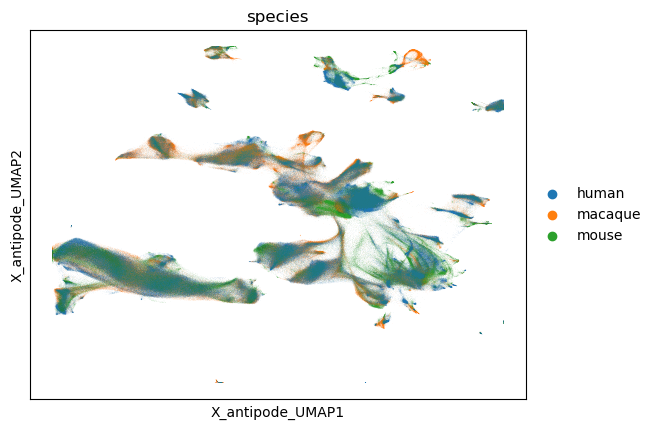

In [30]:
MDE_KEY = 'X_antipode_UMAP'
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['species']
)


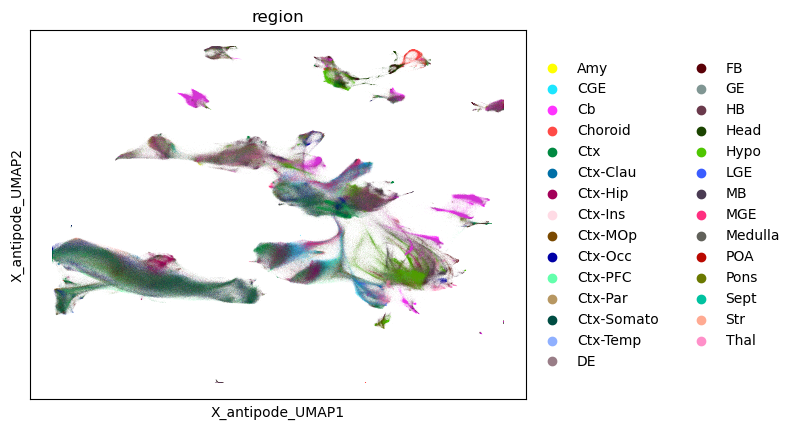

In [31]:

sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['region']
)


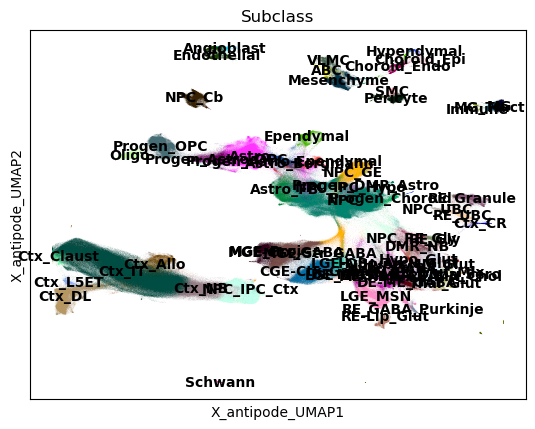

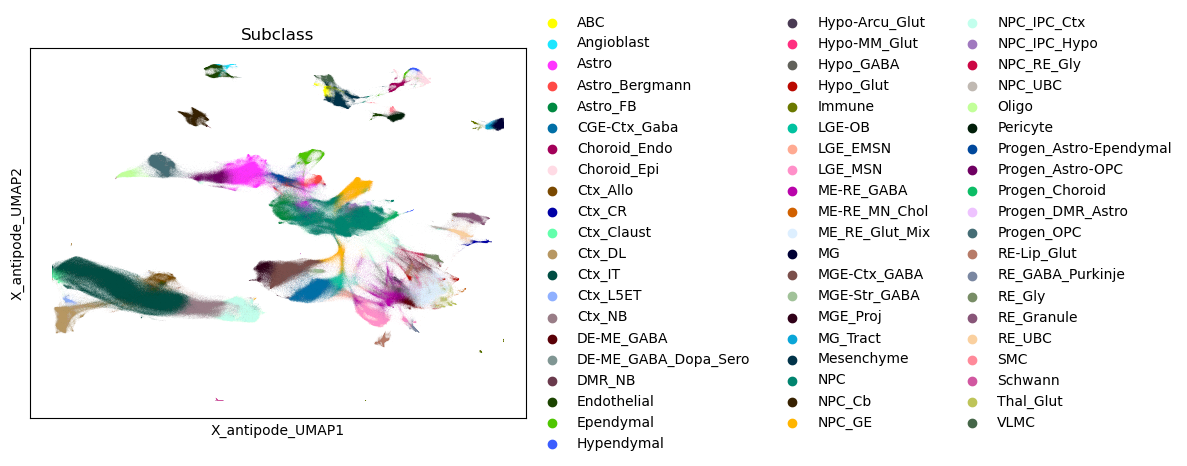

In [32]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,legend_loc='on data',
    color=['Subclass']
)
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['Subclass']
)


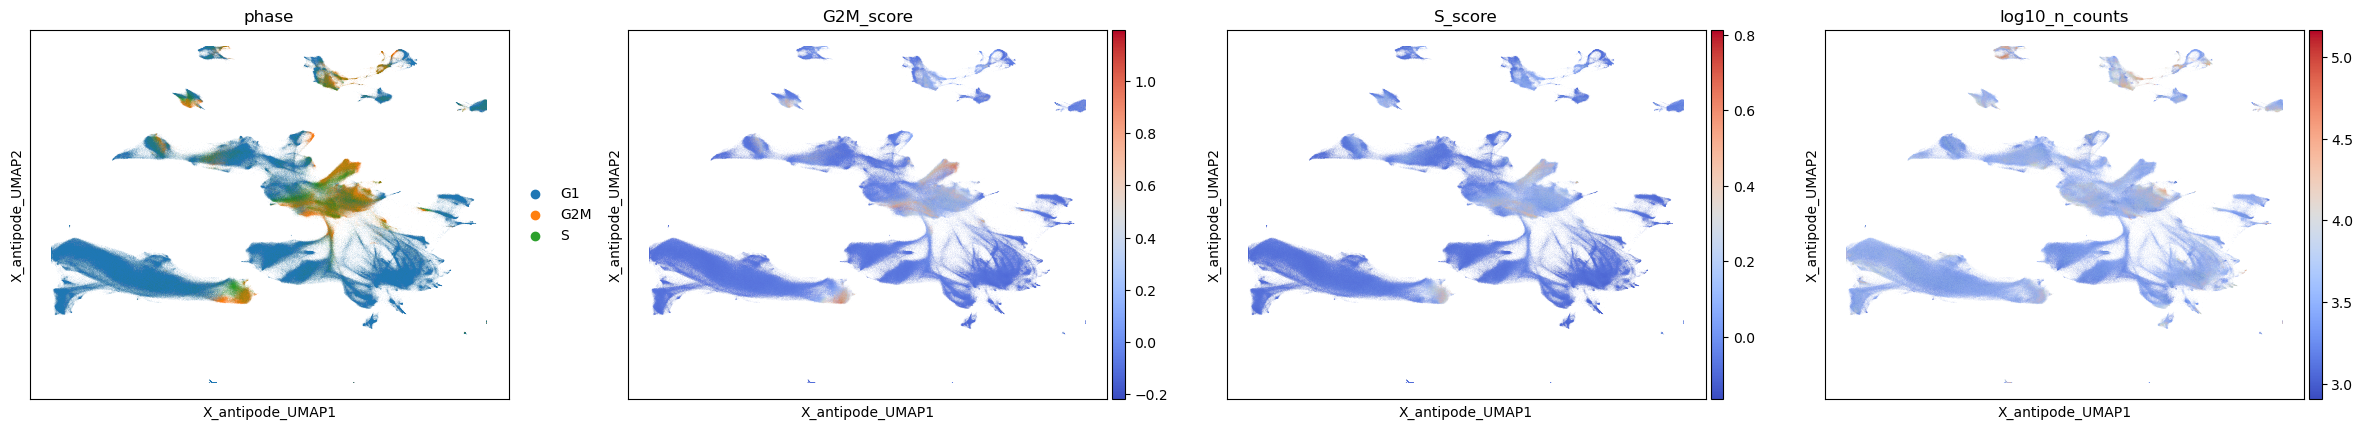

In [33]:
sc.pl.embedding(
    adata,
    basis=MDE_KEY,
    color=['phase','G2M_score','S_score','log10_n_counts'],cmap='coolwarm'
)

In [34]:
import pyro
import torch

In [35]:
d=pyro.distributions.Laplace(0,1)
d.log_prob(torch.ones(1))-d.log_prob(torch.zeros(1))

tensor([-1.])

In [36]:
d=pyro.distributions.Laplace(0,1)
d.log_prob(2*torch.ones(1))-d.log_prob(torch.zeros(1))

tensor([-2.])

In [37]:
d=pyro.distributions.Laplace(0,2)
d.log_prob(torch.ones(1))-d.log_prob(torch.zeros(1))

tensor([-0.5000])

In [38]:
d=pyro.distributions.Laplace(0,5)
d.log_prob(torch.ones(1))-d.log_prob(torch.zeros(1))

tensor([-0.2000])